In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 5) remove checkpoints
# import os; _ = [os.remove(p) for p in __import__("glob").glob("libs/.ipynb_checkpoints/*.py") if os.path.exists(p)]

import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

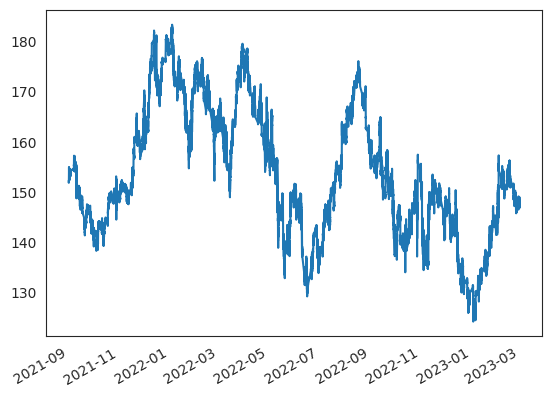

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_9,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,151.953148,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.31,151.82,0.000000,0.003217,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,84.482759,94.827586,84.482759,94.827586,466.666667,657.602451,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,1,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.024518,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.31,151.82,0.000000,0.003217,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,84.482759,89.655172,84.482759,89.655172,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,1,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.079614,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.649316,27.633299,69.132130,12.694655,18.306713,151.598286,152.246714,0.004268,151.436178,152.408822,0.006402,151.645288,152.092112,0.0029

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
trading_combinations = {
    # EMA based
    # "tc_ema_3_8":     {"col_signal": "ema_3",    "sign_thresh": "ema_8"},
    # "tc_ema_5_13":   {"col_signal": "ema_5",    "sign_thresh": "ema_13"},
    "tc_ema_9_21":   {"col_signal": "ema_9",    "sign_thresh": "ema_21"},
    "tc_ema_21_50":  {"col_signal": "ema_21",    "sign_thresh": "ema_50"},
    
    # # ROC based
    # "tc_roc5_ema21": {"col_signal": "roc_5",    "sign_thresh": "ema_21"},
    # "tc_roc5_zero":  {"col_signal": "roc_5",    "sign_thresh": 0.0},
    # # MACD-based:
    # "tc_macd_line":  {"col_signal": "macd_line_12_26_9", "sign_thresh": 0.0},
    # "tc_macd_diff":  {"col_signal": "macd_diff_6_13_5",  "sign_thresh": 0.0},
    # # RSI gate as signal:
    # "tc_rsi_mid":    {"col_signal": "rsi_14",   "sign_thresh": 50.0},
    # "tc_rsi_fast":   {"col_signal": "rsi_6",    "sign_thresh": 50.0},

}

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb = trading_combinations[
        trial.suggest_categorical("tc_id", list(trading_combinations.keys()))
    ]
    
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    
    # RSI band
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 20, 60)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", rsi_min_thresh + 1, 100)
    # Volume spike threshold (ratio-ish)
    vol_thresh     = trial.suggest_float("vol_thresh", 3.0, 6.0)
    # Trend filter
    adx_thresh     = trial.suggest_float("adx_thresh", 30.0, 60.0)
    # ATR multipliers (log for breadth)
    atr_mult       = trial.suggest_float("atr_mult", 1.0, 6.0, log=True)
    # VWAP+ATR gate; allow negative/positive tilt
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -20.0, 5.0)
    # Scaling factors (wire these into your strategy if used)
    buy_factor     = trial.suggest_float("buy_factor", 0.1, 1.0)
    sell_factor    = trial.suggest_float("sell_factor", 0.1, 1.0)
    # Trailing stop percentage (as percent; kept wider but sane)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 3.0, 15.0)
    
    print('-' * 150)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strategies.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_actions_alpaca(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = params.sess_start_tick
        )

        sim_results = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = params.sess_start_tick
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strategies._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strategies._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)




Baseline mean daily B&H: -9.5162
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=74; vol_thresh=5.074753179731104; adx_thresh=44.962731727397184; atr_mult=4.132699301565175; vwap_atr_mult=-8.286344575583374; buy_factor=0.2956935681736661; sell_factor=0.7989250403281791; trailstop_pct=5.9875810816757955


/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
Trial 0: 100%|██████████| 375/375 [00:28<00:00, 13.00it/s]


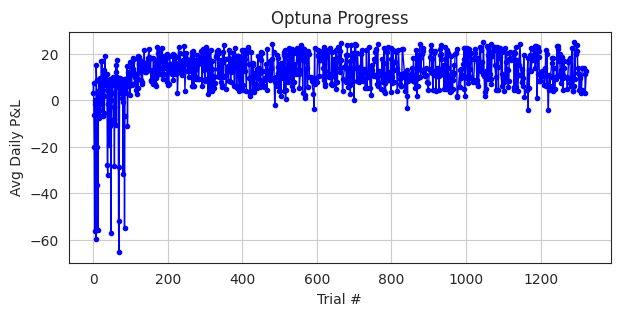

[Results] mean_pnl:-5.5985 mean_excess:3.1506 improv:-136.01%
Action counts: {'Buy': 71, 'Sell': 268, 'Hold': 350372}
Best trial is: 0 with best_val: 3.1506
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=100; vol_thresh=4.919458927318587; adx_thresh=57.00406014154106; atr_mult=2.364674172282105; vwap_atr_mult=-3.155439462365397; buy_factor=0.25065858663461277; sell_factor=0.40226206397135633; trailstop_pct=5.092087483482438


Trial 1: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:-1.1852 mean_excess:7.5639 improv:-186.45%
Action counts: {'Buy': 8, 'Sell': 57, 'Hold': 350646}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=60; vol_thresh=4.295650274422037; adx_thresh=44.54831285748593; atr_mult=2.834677427863715; vwap_atr_mult=-10.35276408602903; buy_factor=0.7501827736723318; sell_factor=0.970738970300448; trailstop_pct=13.735631108299785


Trial 2: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:-14.9479 mean_excess:-6.1988 improv:-29.15%
Action counts: {'Buy': 111, 'Sell': 190, 'Hold': 350410}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=60; vol_thresh=5.568159045038862; adx_thresh=33.211085728491156; atr_mult=1.0529610376016783; vwap_atr_mult=0.056164926831783646; buy_factor=0.8848903121566317; sell_factor=0.4127754794105839; trailstop_pct=8.634509933152863


Trial 3: 100%|██████████| 375/375 [00:24<00:00, 15.28it/s]


[Results] mean_pnl:-28.8014 mean_excess:-20.0523 improv:129.19%
Action counts: {'Buy': 180, 'Sell': 1833, 'Hold': 348698}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=81; vol_thresh=4.002271463249166; adx_thresh=31.34394500702405; atr_mult=5.062999586435461; vwap_atr_mult=-7.909528564970458; buy_factor=0.7860126878217126; sell_factor=0.9461911091603632; trailstop_pct=12.24123854772708


Trial 4: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:-65.1463 mean_excess:-56.3972 improv:544.61%
Action counts: {'Buy': 479, 'Sell': 966, 'Hold': 349266}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=59; vol_thresh=3.942142068539443; adx_thresh=43.30837352191931; atr_mult=1.3987920846487123; vwap_atr_mult=-14.60195358112507; buy_factor=0.921126917554822; sell_factor=0.4355044354641745; trailstop_pct=10.804093027680011


Trial 5: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:-10.2261 mean_excess:-1.4771 improv:-83.12%
Action counts: {'Buy': 152, 'Sell': 1235, 'Hold': 349324}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; vol_thresh=4.671829523469542; adx_thresh=33.67076412786505; atr_mult=2.13002337746868; vwap_atr_mult=-14.888459711307323; buy_factor=0.18075882888569267; sell_factor=0.7242664476779197; trailstop_pct=10.123275235094072


Trial 6: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:-8.6376 mean_excess:0.1115 improv:-101.27%
Action counts: {'Buy': 270, 'Sell': 841, 'Hold': 349600}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=95; vol_thresh=3.808339490457756; adx_thresh=31.3914864795333; atr_mult=1.300027754461674; vwap_atr_mult=-17.68087688187456; buy_factor=0.9651282500402525; sell_factor=0.5750493940157745; trailstop_pct=9.6596648516051


Trial 7: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:-68.3080 mean_excess:-59.5589 improv:580.74%
Action counts: {'Buy': 512, 'Sell': 2944, 'Hold': 347255}
Best trial is: 1 with best_val: 7.5639
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=77; vol_thresh=5.791428570666657; adx_thresh=45.31883029778887; atr_mult=5.703807430609139; vwap_atr_mult=-1.2911863312709109; buy_factor=0.7894678848660266; sell_factor=0.1132638934223081; trailstop_pct=5.211312872663784


Trial 8: 100%|██████████| 375/375 [00:27<00:00, 13.58it/s]


[Results] mean_pnl:6.5433 mean_excess:15.2924 improv:-274.79%
Action counts: {'Buy': 57, 'Sell': 1947, 'Hold': 348707}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=90; vol_thresh=4.593412954091946; adx_thresh=51.65265336967687; atr_mult=1.7782072070898292; vwap_atr_mult=-1.434225157563393; buy_factor=0.5372995040712403; sell_factor=0.4261102091340977; trailstop_pct=11.77498899952116


Trial 9: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:-0.0270 mean_excess:8.7221 improv:-199.69%
Action counts: {'Buy': 36, 'Sell': 292, 'Hold': 350383}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=62; vol_thresh=4.538058050512058; adx_thresh=30.98853007332954; atr_mult=4.656521818188403; vwap_atr_mult=-9.674376822729677; buy_factor=0.7756204514792994; sell_factor=0.9923556032711301; trailstop_pct=9.268760948275085


Trial 10: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s]


[Results] mean_pnl:-45.2023 mean_excess:-36.4532 improv:316.65%
Action counts: {'Buy': 357, 'Sell': 516, 'Hold': 349838}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=38; vol_thresh=4.325789122624057; adx_thresh=36.33086674347489; atr_mult=2.79589070636431; vwap_atr_mult=-8.556307642827717; buy_factor=0.6291858397775335; sell_factor=0.931883028130803; trailstop_pct=12.372542353855373


Trial 11: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:-28.8858 mean_excess:-20.1367 improv:130.16%
Action counts: {'Buy': 249, 'Sell': 620, 'Hold': 349842}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; vol_thresh=5.4384404007315545; adx_thresh=39.634002232527116; atr_mult=1.3738693242781763; vwap_atr_mult=-15.419503021939644; buy_factor=0.6933146228613438; sell_factor=0.9792084447239235; trailstop_pct=6.453255527751174


Trial 12: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:-4.9025 mean_excess:3.8466 improv:-143.97%
Action counts: {'Buy': 114, 'Sell': 194, 'Hold': 350403}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=27; vol_thresh=3.5437391845650144; adx_thresh=30.16645704479262; atr_mult=1.439085830725309; vwap_atr_mult=-12.280631509935057; buy_factor=0.531174818737307; sell_factor=0.4353269929497672; trailstop_pct=5.821264910963386


Trial 13: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:-64.5823 mean_excess:-55.8332 improv:538.16%
Action counts: {'Buy': 704, 'Sell': 4924, 'Hold': 345083}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=47; vol_thresh=4.812083080658666; adx_thresh=30.580390919437395; atr_mult=2.1252145090316548; vwap_atr_mult=4.9244281785533275; buy_factor=0.8181560204063726; sell_factor=0.32009294668567956; trailstop_pct=8.875173201829353


Trial 14: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:-13.1333 mean_excess:-4.3842 improv:-49.89%
Action counts: {'Buy': 142, 'Sell': 1808, 'Hold': 348761}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=75; vol_thresh=3.2374183207498946; adx_thresh=50.802868262580816; atr_mult=1.5155857566574837; vwap_atr_mult=-16.95403832412606; buy_factor=0.5743456498023731; sell_factor=0.20388963879156008; trailstop_pct=9.051587957239997


Trial 15: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:-0.4641 mean_excess:8.2849 improv:-194.69%
Action counts: {'Buy': 94, 'Sell': 1488, 'Hold': 349129}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=90; vol_thresh=3.5551693162727975; adx_thresh=44.18455912852821; atr_mult=1.0004424230100373; vwap_atr_mult=4.0466680680303035; buy_factor=0.5655050864761185; sell_factor=0.6580275274458389; trailstop_pct=6.526700047059041


Trial 16: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:-16.5463 mean_excess:-7.7972 improv:-10.88%
Action counts: {'Buy': 171, 'Sell': 797, 'Hold': 349743}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=75; vol_thresh=5.4659932123262465; adx_thresh=52.75259291858966; atr_mult=5.934591999953806; vwap_atr_mult=-19.138426103450495; buy_factor=0.5629795838532462; sell_factor=0.7802874728383097; trailstop_pct=12.386038355653197


Trial 17: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:0.7860 mean_excess:9.5351 improv:-208.98%
Action counts: {'Buy': 20, 'Sell': 75, 'Hold': 350616}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=74; vol_thresh=3.143445483255227; adx_thresh=46.86771592940471; atr_mult=1.5225638194357567; vwap_atr_mult=-10.654698452243132; buy_factor=0.4358970460703613; sell_factor=0.2800090881328234; trailstop_pct=12.226821752481648


Trial 18: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:-10.3148 mean_excess:-1.5657 improv:-82.10%
Action counts: {'Buy': 177, 'Sell': 1941, 'Hold': 348593}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=74; vol_thresh=5.692900604441045; adx_thresh=30.102210040381408; atr_mult=3.9190467537220623; vwap_atr_mult=-0.8392895371313713; buy_factor=0.3735124382502778; sell_factor=0.19489519161184826; trailstop_pct=12.36162348524718


Trial 19: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:-15.3934 mean_excess:-6.6443 improv:-24.06%
Action counts: {'Buy': 245, 'Sell': 4411, 'Hold': 346055}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=99; vol_thresh=4.5710257824464104; adx_thresh=39.08445083652438; atr_mult=1.799667551842902; vwap_atr_mult=-17.686655554836406; buy_factor=0.9562954140801184; sell_factor=0.5316950258208057; trailstop_pct=7.1415208995638455


Trial 20: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:-13.0540 mean_excess:-4.3049 improv:-50.80%
Action counts: {'Buy': 170, 'Sell': 1060, 'Hold': 349481}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; vol_thresh=4.588248360774837; adx_thresh=56.80133121393882; atr_mult=3.6967705708670997; vwap_atr_mult=-10.018346085219708; buy_factor=0.5188936807537471; sell_factor=0.46876831666284846; trailstop_pct=7.277179201852569


Trial 21: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:-3.3911 mean_excess:5.3580 improv:-161.24%
Action counts: {'Buy': 13, 'Sell': 91, 'Hold': 350607}
Best trial is: 8 with best_val: 15.2924
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=100; vol_thresh=3.6379156309443945; adx_thresh=53.45908761772887; atr_mult=1.0732335377675037; vwap_atr_mult=-2.5460296299696914; buy_factor=0.37423671949163506; sell_factor=0.9885180395423981; trailstop_pct=7.724612927561061


Trial 22: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:8.1468 mean_excess:16.8959 improv:-293.12%
Action counts: {'Buy': 53, 'Sell': 78, 'Hold': 350580}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=62; vol_thresh=3.627415449513531; adx_thresh=38.56970518417171; atr_mult=3.0041042705585133; vwap_atr_mult=-9.650151027049017; buy_factor=0.2504804900837275; sell_factor=0.9769094293964486; trailstop_pct=10.500622955697914


Trial 23: 100%|██████████| 375/375 [00:27<00:00, 13.55it/s]


[Results] mean_pnl:-10.5646 mean_excess:-1.8155 improv:-79.25%
Action counts: {'Buy': 322, 'Sell': 418, 'Hold': 349971}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=53; vol_thresh=4.382392878283329; adx_thresh=53.44295564159637; atr_mult=1.9106153999420206; vwap_atr_mult=-9.599543784719188; buy_factor=0.7464130134462401; sell_factor=0.6791169673427806; trailstop_pct=4.5718756906620435


Trial 24: 100%|██████████| 375/375 [00:21<00:00, 17.38it/s]


[Results] mean_pnl:8.0784 mean_excess:16.8275 improv:-292.33%
Action counts: {'Buy': 34, 'Sell': 162, 'Hold': 350515}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=35; vol_thresh=3.4584176785156173; adx_thresh=44.5448951935426; atr_mult=1.8877190624705318; vwap_atr_mult=4.064295515267943; buy_factor=0.6133042043243903; sell_factor=0.3180825816883911; trailstop_pct=11.181442639820046


Trial 25: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:-7.1015 mean_excess:1.6476 improv:-118.83%
Action counts: {'Buy': 113, 'Sell': 1217, 'Hold': 349381}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=83; vol_thresh=3.9098518679189933; adx_thresh=45.56461050256476; atr_mult=2.767202570167921; vwap_atr_mult=-15.604918034927508; buy_factor=0.8239339635686076; sell_factor=0.44430874116195707; trailstop_pct=13.074107514936692


Trial 26: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:-15.7651 mean_excess:-7.0160 improv:-19.81%
Action counts: {'Buy': 117, 'Sell': 1026, 'Hold': 349568}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=99; vol_thresh=5.81671888530188; adx_thresh=38.00229285931984; atr_mult=1.0200082950156157; vwap_atr_mult=-9.569946757840391; buy_factor=0.30854643618369126; sell_factor=0.410674354630309; trailstop_pct=12.093955867627356


Trial 27: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:-6.7227 mean_excess:2.0264 improv:-123.16%
Action counts: {'Buy': 123, 'Sell': 1099, 'Hold': 349489}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; vol_thresh=4.159721197411853; adx_thresh=40.963653809977245; atr_mult=3.582656475931832; vwap_atr_mult=4.312823208090897; buy_factor=0.7977371408384742; sell_factor=0.9424981578306374; trailstop_pct=14.145230332265125


Trial 28: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:-6.9891 mean_excess:1.7600 improv:-120.12%
Action counts: {'Buy': 107, 'Sell': 258, 'Hold': 350346}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=60; vol_thresh=3.030090093194707; adx_thresh=56.03756063826166; atr_mult=1.1035112118798442; vwap_atr_mult=-7.389292139342869; buy_factor=0.3620691903232597; sell_factor=0.24633100212441236; trailstop_pct=7.990426199696156


Trial 29: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:4.3830 mean_excess:13.1321 improv:-250.10%
Action counts: {'Buy': 55, 'Sell': 685, 'Hold': 349971}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; vol_thresh=3.1295920138302993; adx_thresh=50.73471998699909; atr_mult=1.3639385766391134; vwap_atr_mult=-18.635946417390187; buy_factor=0.8693679684560163; sell_factor=0.8653695573251423; trailstop_pct=9.199481548279966


Trial 30: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:-14.3115 mean_excess:-5.5624 improv:-36.42%
Action counts: {'Buy': 98, 'Sell': 280, 'Hold': 350333}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=96; vol_thresh=5.674222753180411; adx_thresh=48.747072119912666; atr_mult=1.7380851259399879; vwap_atr_mult=-4.660890345026472; buy_factor=0.9670058787009498; sell_factor=0.33499335553391174; trailstop_pct=4.1287419717228255


Trial 31: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:-2.4008 mean_excess:6.3483 improv:-172.56%
Action counts: {'Buy': 32, 'Sell': 424, 'Hold': 350255}
Best trial is: 22 with best_val: 16.8959
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=74; vol_thresh=3.5357960489578475; adx_thresh=56.20440998129786; atr_mult=1.8496553142599672; vwap_atr_mult=-15.42165196426556; buy_factor=0.6924550530376028; sell_factor=0.4783244685957647; trailstop_pct=10.699084988495448


Trial 32: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:10.0502 mean_excess:18.7993 improv:-314.87%
Action counts: {'Buy': 32, 'Sell': 238, 'Hold': 350441}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=62; vol_thresh=4.026440239991093; adx_thresh=50.437735489047554; atr_mult=2.3145239758094887; vwap_atr_mult=-6.103577706183673; buy_factor=0.12042235640536492; sell_factor=0.16465364723281384; trailstop_pct=7.433016265791155


Trial 33: 100%|██████████| 375/375 [00:29<00:00, 12.91it/s]


[Results] mean_pnl:-0.5301 mean_excess:8.2190 improv:-193.94%
Action counts: {'Buy': 55, 'Sell': 835, 'Hold': 349821}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=47; vol_thresh=5.802873431328761; adx_thresh=59.97687054310973; atr_mult=4.435347577735045; vwap_atr_mult=-9.563763782685626; buy_factor=0.9113818573205257; sell_factor=0.15346170574051776; trailstop_pct=6.612692206795446


Trial 34: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:-2.1439 mean_excess:6.6052 improv:-175.50%
Action counts: {'Buy': 7, 'Sell': 188, 'Hold': 350516}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=85; vol_thresh=4.328738781975783; adx_thresh=47.12230548866016; atr_mult=1.2786660995997354; vwap_atr_mult=-6.953409609572349; buy_factor=0.22481987407040663; sell_factor=0.21015638353743293; trailstop_pct=5.271287843247487


Trial 35: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:0.4619 mean_excess:9.2110 improv:-205.28%
Action counts: {'Buy': 86, 'Sell': 1247, 'Hold': 349378}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=75; vol_thresh=3.330601817899538; adx_thresh=55.035842014867484; atr_mult=1.0802970762139832; vwap_atr_mult=1.969766858559396; buy_factor=0.1870475069947783; sell_factor=0.2858588837931689; trailstop_pct=8.265295479098047


Trial 36: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:2.6156 mean_excess:11.3647 improv:-229.90%
Action counts: {'Buy': 50, 'Sell': 465, 'Hold': 350196}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=96; vol_thresh=5.916529557084738; adx_thresh=33.774130538315674; atr_mult=2.9048164892934745; vwap_atr_mult=2.1496280300545223; buy_factor=0.13327090038886852; sell_factor=0.9054697022613384; trailstop_pct=13.015206822741398


Trial 37: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:-4.5258 mean_excess:4.2233 improv:-148.27%
Action counts: {'Buy': 174, 'Sell': 331, 'Hold': 350206}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=83; vol_thresh=3.5557789859392663; adx_thresh=36.32625989524767; atr_mult=2.1434234865497315; vwap_atr_mult=-1.010256783795807; buy_factor=0.6103837103415997; sell_factor=0.15433604241043772; trailstop_pct=7.808149670234776


Trial 38: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:-36.7815 mean_excess:-28.0324 improv:220.40%
Action counts: {'Buy': 406, 'Sell': 7957, 'Hold': 342348}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=76; vol_thresh=3.295994715109334; adx_thresh=41.780524325321274; atr_mult=2.5307922587911515; vwap_atr_mult=4.131906192140605; buy_factor=0.9961070099779833; sell_factor=0.18630747267215497; trailstop_pct=7.214701113028404


Trial 39: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


[Results] mean_pnl:-41.0109 mean_excess:-32.2618 improv:268.74%
Action counts: {'Buy': 213, 'Sell': 4020, 'Hold': 346478}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=96; vol_thresh=4.16789661965503; adx_thresh=41.98874726742564; atr_mult=5.9911689872049525; vwap_atr_mult=-9.929933089695876; buy_factor=0.2227687620336638; sell_factor=0.28823430442954234; trailstop_pct=8.135710319199095


Trial 40: 100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


[Results] mean_pnl:-1.1731 mean_excess:7.5760 improv:-186.59%
Action counts: {'Buy': 164, 'Sell': 1573, 'Hold': 348974}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=81; vol_thresh=3.8947156701741785; adx_thresh=41.73508597728765; atr_mult=5.356821874496851; vwap_atr_mult=4.359053531482633; buy_factor=0.38356508830472946; sell_factor=0.8081173810596819; trailstop_pct=12.793266644468192


Trial 41: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:-10.2737 mean_excess:-1.5247 improv:-82.57%
Action counts: {'Buy': 147, 'Sell': 467, 'Hold': 350097}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=55; vol_thresh=3.678683132637646; adx_thresh=41.73134443400288; atr_mult=3.404481936921027; vwap_atr_mult=-15.806391790219987; buy_factor=0.9614515420494234; sell_factor=0.3141342082924785; trailstop_pct=8.173284837739176


Trial 42: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:-27.9817 mean_excess:-19.2327 improv:119.82%
Action counts: {'Buy': 207, 'Sell': 2506, 'Hold': 347998}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=60; vol_thresh=4.60718541496254; adx_thresh=57.86415718592286; atr_mult=1.979647878213319; vwap_atr_mult=-9.949351240710449; buy_factor=0.7534735782670435; sell_factor=0.2449167768892036; trailstop_pct=5.161539549502763


Trial 43: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:-2.1518 mean_excess:6.5973 improv:-175.41%
Action counts: {'Buy': 13, 'Sell': 205, 'Hold': 350493}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=69; vol_thresh=5.4517089535117425; adx_thresh=34.14209928419878; atr_mult=4.450469213862514; vwap_atr_mult=-11.623492675951091; buy_factor=0.7772303006104672; sell_factor=0.5175470959983904; trailstop_pct=13.089017366876826


Trial 44: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-20.0363 mean_excess:-11.2873 improv:29.01%
Action counts: {'Buy': 193, 'Sell': 1259, 'Hold': 349259}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=86; vol_thresh=5.5329148478100265; adx_thresh=39.254081180277296; atr_mult=1.573484595711343; vwap_atr_mult=-8.616685564130437; buy_factor=0.7772309004938115; sell_factor=0.7312082825499834; trailstop_pct=10.705457112580405


Trial 45: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:-5.1979 mean_excess:3.5512 improv:-140.59%
Action counts: {'Buy': 120, 'Sell': 505, 'Hold': 350086}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=55; vol_thresh=5.555711214683065; adx_thresh=49.88655198215571; atr_mult=2.345028035581402; vwap_atr_mult=-15.530311466919857; buy_factor=0.14770377650291414; sell_factor=0.8746720790219893; trailstop_pct=9.611994329089866


Trial 46: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:0.2592 mean_excess:9.0083 improv:-202.96%
Action counts: {'Buy': 25, 'Sell': 72, 'Hold': 350614}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=90; vol_thresh=3.7796512304628624; adx_thresh=40.45248720376718; atr_mult=1.4279644110451704; vwap_atr_mult=-15.673149293972326; buy_factor=0.20920441097234815; sell_factor=0.31417166838113836; trailstop_pct=9.036032122722863


Trial 47: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:-5.5976 mean_excess:3.1515 improv:-136.02%
Action counts: {'Buy': 230, 'Sell': 2084, 'Hold': 348397}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=65; vol_thresh=3.5291394589860796; adx_thresh=36.481005976793696; atr_mult=1.6458889552425229; vwap_atr_mult=-18.168550021883476; buy_factor=0.9651246714557975; sell_factor=0.9060016975371162; trailstop_pct=14.337130909553508


Trial 48: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-65.8198 mean_excess:-57.0707 improv:552.30%
Action counts: {'Buy': 392, 'Sell': 899, 'Hold': 349420}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=96; vol_thresh=4.286284030006198; adx_thresh=33.193950061746996; atr_mult=1.6085086394475514; vwap_atr_mult=-15.050271705822372; buy_factor=0.1297223478392018; sell_factor=0.25546673814096327; trailstop_pct=10.585975502123986


Trial 49: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:-8.7074 mean_excess:0.0417 improv:-100.48%
Action counts: {'Buy': 351, 'Sell': 3221, 'Hold': 347139}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=72; vol_thresh=5.427877583247112; adx_thresh=43.009757284761875; atr_mult=1.129907873349591; vwap_atr_mult=-17.792184333173452; buy_factor=0.18855956072866142; sell_factor=0.21037901475015008; trailstop_pct=4.580901368144119


Trial 50: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:-2.1236 mean_excess:6.6255 improv:-175.73%
Action counts: {'Buy': 74, 'Sell': 1128, 'Hold': 349509}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=55; vol_thresh=5.522192567022312; adx_thresh=50.270036513414354; atr_mult=3.768373916378647; vwap_atr_mult=-1.2291689313850114; buy_factor=0.7609809087454834; sell_factor=0.4594552049312045; trailstop_pct=6.360017320906556


Trial 51: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:-0.4491 mean_excess:8.3000 improv:-194.87%
Action counts: {'Buy': 25, 'Sell': 235, 'Hold': 350451}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=36; vol_thresh=4.0287316905433475; adx_thresh=57.788242385413156; atr_mult=2.359289603006181; vwap_atr_mult=-15.99707415809317; buy_factor=0.5899512766242209; sell_factor=0.2899490777839553; trailstop_pct=7.864522131334531


Trial 52: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:1.3441 mean_excess:10.0932 improv:-215.36%
Action counts: {'Buy': 21, 'Sell': 255, 'Hold': 350435}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=54; vol_thresh=4.365934554356057; adx_thresh=45.784633314539384; atr_mult=1.5228433154878325; vwap_atr_mult=4.9163550965668; buy_factor=0.41342954784911357; sell_factor=0.26479874611265974; trailstop_pct=12.313869157021488


Trial 53: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:-5.6040 mean_excess:3.1451 improv:-135.95%
Action counts: {'Buy': 58, 'Sell': 775, 'Hold': 349878}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=97; vol_thresh=3.286458388294718; adx_thresh=41.30778654098383; atr_mult=1.6861927547912923; vwap_atr_mult=-19.70575888988878; buy_factor=0.29964293831335126; sell_factor=0.8257753572532586; trailstop_pct=9.556312146029253


Trial 54: 100%|██████████| 375/375 [00:22<00:00, 16.84it/s]


[Results] mean_pnl:-18.4843 mean_excess:-9.7352 improv:11.27%
Action counts: {'Buy': 321, 'Sell': 707, 'Hold': 349683}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=44; vol_thresh=4.233353609090138; adx_thresh=43.49649971018996; atr_mult=4.7280443376674635; vwap_atr_mult=1.9140753584524504; buy_factor=0.9167244901501455; sell_factor=0.8688425450369807; trailstop_pct=4.768892332053507


Trial 55: 100%|██████████| 375/375 [00:23<00:00, 16.06it/s]


[Results] mean_pnl:-17.0034 mean_excess:-8.2543 improv:-5.65%
Action counts: {'Buy': 115, 'Sell': 357, 'Hold': 350239}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=84; vol_thresh=5.092814942276737; adx_thresh=46.42880256835536; atr_mult=2.874677066315174; vwap_atr_mult=-9.259277906765764; buy_factor=0.8897728471257857; sell_factor=0.9787461059046499; trailstop_pct=14.631168155596699


Trial 56: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:-11.6389 mean_excess:-2.8898 improv:-66.97%
Action counts: {'Buy': 58, 'Sell': 110, 'Hold': 350543}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=64; vol_thresh=3.7306194924468046; adx_thresh=35.00004333107668; atr_mult=1.6296374103325366; vwap_atr_mult=-3.1456237504587783; buy_factor=0.5335278703944157; sell_factor=0.2833838790177964; trailstop_pct=12.056030856307531


Trial 57: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-36.9247 mean_excess:-28.1756 improv:222.04%
Action counts: {'Buy': 400, 'Sell': 4682, 'Hold': 345629}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; vol_thresh=5.548850671689571; adx_thresh=57.897660538376; atr_mult=1.734034717450583; vwap_atr_mult=-13.927588814841084; buy_factor=0.21596621705796532; sell_factor=0.46333516630525073; trailstop_pct=13.510827375079762


Trial 58: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:0.0123 mean_excess:8.7614 improv:-200.14%
Action counts: {'Buy': 6, 'Sell': 41, 'Hold': 350664}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=96; vol_thresh=5.298303295943409; adx_thresh=51.08644586689579; atr_mult=1.24532908194345; vwap_atr_mult=-6.468409592535931; buy_factor=0.21402722375891053; sell_factor=0.8407410519316307; trailstop_pct=12.738461260570562


Trial 59: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-0.0130 mean_excess:8.7361 improv:-199.85%
Action counts: {'Buy': 26, 'Sell': 72, 'Hold': 350613}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=83; vol_thresh=5.008698041785519; adx_thresh=53.25895753001306; atr_mult=5.619538456201465; vwap_atr_mult=2.9016837359530108; buy_factor=0.31659958072973354; sell_factor=0.47914463729010914; trailstop_pct=13.741349849740018


Trial 60: 100%|██████████| 375/375 [00:20<00:00, 17.92it/s]


[Results] mean_pnl:3.2185 mean_excess:11.9676 improv:-236.79%
Action counts: {'Buy': 20, 'Sell': 147, 'Hold': 350544}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=66; vol_thresh=5.98388218444643; adx_thresh=45.98443957448586; atr_mult=1.1518924200701244; vwap_atr_mult=-5.541605084235304; buy_factor=0.7808617519487581; sell_factor=0.9629939392752025; trailstop_pct=11.942154006585818


Trial 61: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:6.3480 mean_excess:15.0971 improv:-272.56%
Action counts: {'Buy': 48, 'Sell': 88, 'Hold': 350575}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=49; vol_thresh=4.955246357846006; adx_thresh=34.20011017586091; atr_mult=1.3623572754282975; vwap_atr_mult=-19.497302609937876; buy_factor=0.3968643403832789; sell_factor=0.2274492829254517; trailstop_pct=12.88278065338877


Trial 62: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


[Results] mean_pnl:-19.2918 mean_excess:-10.5427 improv:20.50%
Action counts: {'Buy': 230, 'Sell': 3355, 'Hold': 347126}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=74; vol_thresh=3.7531456027090204; adx_thresh=50.197695367489025; atr_mult=4.413903567414385; vwap_atr_mult=-1.3578633399584348; buy_factor=0.8887738551178888; sell_factor=0.12781648761297357; trailstop_pct=11.922893474583601


Trial 63: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:8.3969 mean_excess:17.1460 improv:-295.97%
Action counts: {'Buy': 69, 'Sell': 1852, 'Hold': 348790}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=89; vol_thresh=3.356790518048158; adx_thresh=49.67897827208891; atr_mult=1.5225845639078919; vwap_atr_mult=-4.189425754305983; buy_factor=0.18422809415975683; sell_factor=0.6303166771488242; trailstop_pct=13.604789040109983


Trial 64: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:1.3969 mean_excess:10.1460 improv:-215.97%
Action counts: {'Buy': 94, 'Sell': 354, 'Hold': 350263}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=97; vol_thresh=5.252941875877262; adx_thresh=51.88283406593258; atr_mult=5.76755583802858; vwap_atr_mult=-15.79034123853721; buy_factor=0.638995049325722; sell_factor=0.5158841718255979; trailstop_pct=13.66663522901153


Trial 65: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:0.6148 mean_excess:9.3639 improv:-207.03%
Action counts: {'Buy': 25, 'Sell': 179, 'Hold': 350507}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=70; vol_thresh=4.815431193406477; adx_thresh=46.66342488809356; atr_mult=1.015565165769771; vwap_atr_mult=-15.393609784270902; buy_factor=0.43896819550728594; sell_factor=0.4157141824705344; trailstop_pct=6.632832394038157


Trial 66: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-2.8717 mean_excess:5.8774 improv:-167.18%
Action counts: {'Buy': 64, 'Sell': 582, 'Hold': 350065}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=78; vol_thresh=4.043925146884903; adx_thresh=46.55797497640113; atr_mult=2.1019661844497244; vwap_atr_mult=2.677463692160824; buy_factor=0.23873222844446096; sell_factor=0.8005444160970855; trailstop_pct=5.572300713526479


Trial 67: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:-1.4851 mean_excess:7.2640 improv:-183.03%
Action counts: {'Buy': 94, 'Sell': 273, 'Hold': 350344}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=75; vol_thresh=3.0251773788350307; adx_thresh=39.13450976002177; atr_mult=5.782264732052313; vwap_atr_mult=-7.640094730973736; buy_factor=0.8455708083834282; sell_factor=0.16643097764381215; trailstop_pct=9.795707838567626


Trial 68: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:-60.5760 mean_excess:-51.8269 improv:492.37%
Action counts: {'Buy': 478, 'Sell': 7795, 'Hold': 342438}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=74; vol_thresh=3.178297729058505; adx_thresh=33.90753959679587; atr_mult=4.893132063343153; vwap_atr_mult=3.5814592029837193; buy_factor=0.6424384419063291; sell_factor=0.42941632243570393; trailstop_pct=12.379116204499846


Trial 69: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:-74.1835 mean_excess:-65.4345 improv:647.90%
Action counts: {'Buy': 571, 'Sell': 3484, 'Hold': 346656}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=61; vol_thresh=4.930583575034114; adx_thresh=30.168151133111643; atr_mult=3.2886677038544936; vwap_atr_mult=-9.505214377260536; buy_factor=0.4911903157808395; sell_factor=0.6249376390118421; trailstop_pct=10.496853617685451


Trial 70: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:-37.4799 mean_excess:-28.7308 improv:228.39%
Action counts: {'Buy': 327, 'Sell': 1536, 'Hold': 348848}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=46; vol_thresh=5.4377400857449905; adx_thresh=54.0503873816703; atr_mult=5.5618485037876; vwap_atr_mult=-4.522365907540365; buy_factor=0.11622357742825878; sell_factor=0.3110628513967346; trailstop_pct=6.251108179314864


Trial 71: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:0.7782 mean_excess:9.5273 improv:-208.89%
Action counts: {'Buy': 15, 'Sell': 135, 'Hold': 350561}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=63; vol_thresh=5.011482604914428; adx_thresh=38.77631631711751; atr_mult=1.9581255261556583; vwap_atr_mult=-12.276224320034387; buy_factor=0.2507210642854524; sell_factor=0.5290621779854497; trailstop_pct=14.485555824738574


Trial 72: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:-5.7807 mean_excess:2.9684 improv:-133.93%
Action counts: {'Buy': 147, 'Sell': 827, 'Hold': 349737}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; vol_thresh=5.042836877236293; adx_thresh=47.36024682349161; atr_mult=3.8782750125402914; vwap_atr_mult=-17.4014641909959; buy_factor=0.5119286068406925; sell_factor=0.2731161021159563; trailstop_pct=6.300667768180954


Trial 73: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:-2.5191 mean_excess:6.2300 improv:-171.21%
Action counts: {'Buy': 59, 'Sell': 854, 'Hold': 349798}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=92; vol_thresh=3.1957160466769277; adx_thresh=58.91528209445216; atr_mult=5.9906466133389005; vwap_atr_mult=-9.385967541152425; buy_factor=0.22900771307920623; sell_factor=0.4695521675449763; trailstop_pct=4.0278046292753045


Trial 74: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:0.0236 mean_excess:8.7727 improv:-200.27%
Action counts: {'Buy': 30, 'Sell': 178, 'Hold': 350503}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=79; vol_thresh=4.7410697492664795; adx_thresh=47.049351243018876; atr_mult=3.0053036432380225; vwap_atr_mult=4.965156485967086; buy_factor=0.5230150267725755; sell_factor=0.5356601068957941; trailstop_pct=5.81620084331829


Trial 75: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:-2.2029 mean_excess:6.5462 improv:-174.82%
Action counts: {'Buy': 45, 'Sell': 290, 'Hold': 350376}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=75; vol_thresh=5.739108047753635; adx_thresh=44.22047746998343; atr_mult=1.4160022688715708; vwap_atr_mult=-9.521683734188432; buy_factor=0.30640414919113823; sell_factor=0.7841467907453548; trailstop_pct=7.806752505706422


Trial 76: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:-4.8402 mean_excess:3.9089 improv:-144.68%
Action counts: {'Buy': 61, 'Sell': 236, 'Hold': 350414}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=61; vol_thresh=4.196700039579275; adx_thresh=52.28371791506341; atr_mult=2.9029561950693794; vwap_atr_mult=-6.259369469651517; buy_factor=0.4990991138032822; sell_factor=0.23954200723954128; trailstop_pct=4.254060147017615


Trial 77: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:-0.8299 mean_excess:7.9192 improv:-190.51%
Action counts: {'Buy': 44, 'Sell': 656, 'Hold': 350011}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=83; vol_thresh=3.1819929915762; adx_thresh=48.121289749241846; atr_mult=2.4549228142747643; vwap_atr_mult=-12.988756148349594; buy_factor=0.5012948476127188; sell_factor=0.5025841894739209; trailstop_pct=4.258549016813782


Trial 78: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:-7.6296 mean_excess:1.1195 improv:-112.80%
Action counts: {'Buy': 139, 'Sell': 850, 'Hold': 349722}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=98; vol_thresh=5.593483587623242; adx_thresh=34.17796169440511; atr_mult=2.9118428094737943; vwap_atr_mult=-2.5184303815976143; buy_factor=0.27183166847927365; sell_factor=0.8345591688070904; trailstop_pct=5.614068139785319


Trial 79: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:-9.4854 mean_excess:-0.7363 improv:-91.58%
Action counts: {'Buy': 181, 'Sell': 509, 'Hold': 350021}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=73; vol_thresh=3.476580874907243; adx_thresh=33.33298630081006; atr_mult=2.2646994155104894; vwap_atr_mult=-3.3860419060247757; buy_factor=0.32195494452488294; sell_factor=0.4679262096624184; trailstop_pct=8.64384456945908


Trial 80: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:-40.3278 mean_excess:-31.5788 improv:260.94%
Action counts: {'Buy': 581, 'Sell': 3008, 'Hold': 347122}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=89; vol_thresh=3.614663472974407; adx_thresh=50.15739845951347; atr_mult=1.9225441412608746; vwap_atr_mult=-2.849329182896618; buy_factor=0.4219777552384488; sell_factor=0.5693360038460477; trailstop_pct=12.849446787743315


Trial 81: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:-0.8880 mean_excess:7.8611 improv:-189.85%
Action counts: {'Buy': 78, 'Sell': 428, 'Hold': 350205}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=62; vol_thresh=5.198657338404007; adx_thresh=44.84893519404937; atr_mult=3.4579349712770955; vwap_atr_mult=-10.4749902974832; buy_factor=0.1871822137231175; sell_factor=0.5142940421162379; trailstop_pct=9.590263391333975


Trial 82: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-3.4925 mean_excess:5.2566 improv:-160.08%
Action counts: {'Buy': 68, 'Sell': 401, 'Hold': 350242}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=100; vol_thresh=4.447829151791607; adx_thresh=50.662198496454984; atr_mult=4.521224160942918; vwap_atr_mult=-0.4284985156601735; buy_factor=0.6573528474127118; sell_factor=0.6743404221071818; trailstop_pct=11.350361418886129


Trial 83: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:0.5520 mean_excess:9.3011 improv:-206.31%
Action counts: {'Buy': 46, 'Sell': 221, 'Hold': 350444}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=85; vol_thresh=3.0994312725136526; adx_thresh=39.081208861145036; atr_mult=1.9488318728206302; vwap_atr_mult=-1.2023991176295894; buy_factor=0.9766976302024479; sell_factor=0.461842643073489; trailstop_pct=7.946337774643764


Trial 84: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:-63.7744 mean_excess:-55.0253 improv:528.93%
Action counts: {'Buy': 399, 'Sell': 2960, 'Hold': 347352}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=75; vol_thresh=4.629414537875141; adx_thresh=38.5363429959553; atr_mult=4.252523973780383; vwap_atr_mult=-12.976190021931309; buy_factor=0.8774491786301069; sell_factor=0.20509414444424623; trailstop_pct=5.304449602099885


Trial 85: 100%|██████████| 375/375 [00:21<00:00, 17.18it/s]


[Results] mean_pnl:-15.3990 mean_excess:-6.6499 improv:-23.99%
Action counts: {'Buy': 172, 'Sell': 3222, 'Hold': 347317}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=47; vol_thresh=4.747577868947933; adx_thresh=46.600896512085185; atr_mult=1.876177401190317; vwap_atr_mult=-11.816547160327902; buy_factor=0.3498698563467966; sell_factor=0.5973103377901773; trailstop_pct=5.605647695792807


Trial 86: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:-1.5366 mean_excess:7.2125 improv:-182.44%
Action counts: {'Buy': 71, 'Sell': 373, 'Hold': 350267}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=54; vol_thresh=5.806147576410488; adx_thresh=56.37623033983934; atr_mult=1.2575858967093085; vwap_atr_mult=-9.37153479729194; buy_factor=0.8458303776604138; sell_factor=0.16405094237687448; trailstop_pct=11.632205783740847


Trial 87: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:-0.9075 mean_excess:7.8416 improv:-189.63%
Action counts: {'Buy': 6, 'Sell': 144, 'Hold': 350561}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=81; vol_thresh=5.197062380312437; adx_thresh=57.78656309758121; atr_mult=3.31521736128674; vwap_atr_mult=-3.110762179565331; buy_factor=0.5755773051803661; sell_factor=0.8665707381870542; trailstop_pct=14.601635505778281


Trial 88: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:-1.7397 mean_excess:7.0094 improv:-180.12%
Action counts: {'Buy': 8, 'Sell': 22, 'Hold': 350681}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=97; vol_thresh=5.9761880581134665; adx_thresh=39.00108121058229; atr_mult=1.868747158151349; vwap_atr_mult=-19.588379372716453; buy_factor=0.4981455408986757; sell_factor=0.30189125289640784; trailstop_pct=10.34954692483907


Trial 89: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:-5.8547 mean_excess:2.8944 improv:-133.08%
Action counts: {'Buy': 107, 'Sell': 1396, 'Hold': 349208}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=53; vol_thresh=3.5871906240114493; adx_thresh=51.630828444690735; atr_mult=1.471090889451195; vwap_atr_mult=-14.308329452241168; buy_factor=0.10312080494069396; sell_factor=0.2160743151810564; trailstop_pct=11.060700776896423


Trial 90: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:0.9536 mean_excess:9.7027 improv:-210.90%
Action counts: {'Buy': 69, 'Sell': 729, 'Hold': 349913}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=64; vol_thresh=3.487726787905423; adx_thresh=52.136188674145124; atr_mult=1.276161658762907; vwap_atr_mult=-3.423060944614921; buy_factor=0.3930504825608818; sell_factor=0.544527321831675; trailstop_pct=8.643842883141197


Trial 91: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:6.0800 mean_excess:14.8291 improv:-269.49%
Action counts: {'Buy': 68, 'Sell': 349, 'Hold': 350294}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; vol_thresh=3.438506817999091; adx_thresh=31.335604283162954; atr_mult=5.159690143813625; vwap_atr_mult=-14.828954336433776; buy_factor=0.1562183473000759; sell_factor=0.12307713420355587; trailstop_pct=11.377379325894319


Trial 92: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:-19.7043 mean_excess:-10.9552 improv:25.22%
Action counts: {'Buy': 712, 'Sell': 11745, 'Hold': 338254}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=84; vol_thresh=4.673891236390556; adx_thresh=59.96559773914516; atr_mult=4.74343298786074; vwap_atr_mult=-12.768021362898597; buy_factor=0.6867099628788268; sell_factor=0.8503532107858676; trailstop_pct=9.019633964037428


Trial 93: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:-2.3857 mean_excess:6.3634 improv:-172.73%
Action counts: {'Buy': 10, 'Sell': 35, 'Hold': 350666}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=32; vol_thresh=4.1723462433864915; adx_thresh=55.15524453567416; atr_mult=1.0602538879348058; vwap_atr_mult=0.7421916283205086; buy_factor=0.5587394313134845; sell_factor=0.2199109424871899; trailstop_pct=13.392349066222478


Trial 94: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s]


[Results] mean_pnl:3.3148 mean_excess:12.0639 improv:-237.89%
Action counts: {'Buy': 27, 'Sell': 443, 'Hold': 350241}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=79; vol_thresh=4.4652464247681944; adx_thresh=49.517542102349196; atr_mult=5.250116153198829; vwap_atr_mult=-6.24547480098553; buy_factor=0.7335564778853043; sell_factor=0.24328327873224512; trailstop_pct=14.859287118142722


Trial 95: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:-2.5368 mean_excess:6.2123 improv:-171.01%
Action counts: {'Buy': 49, 'Sell': 791, 'Hold': 349871}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=99; vol_thresh=5.597868924414469; adx_thresh=52.476364094087245; atr_mult=1.0900812868089058; vwap_atr_mult=-6.521091595146112; buy_factor=0.23566145234784375; sell_factor=0.8454310356243794; trailstop_pct=8.425162972988293


Trial 96: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:2.3004 mean_excess:11.0495 improv:-226.29%
Action counts: {'Buy': 18, 'Sell': 51, 'Hold': 350642}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=97; vol_thresh=5.500105703666158; adx_thresh=45.26605793777954; atr_mult=1.6010142594725985; vwap_atr_mult=-1.787392390905996; buy_factor=0.7813098745365046; sell_factor=0.31214660375364434; trailstop_pct=7.453751791278323


Trial 97: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:0.0808 mean_excess:8.8299 improv:-200.92%
Action counts: {'Buy': 61, 'Sell': 830, 'Hold': 349820}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=35; vol_thresh=3.361357013878279; adx_thresh=56.43985123915209; atr_mult=5.066514666636392; vwap_atr_mult=-1.969610189271119; buy_factor=0.654418985255338; sell_factor=0.1239475532950334; trailstop_pct=11.766344225598207


Trial 98: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:7.6235 mean_excess:16.3726 improv:-287.13%
Action counts: {'Buy': 38, 'Sell': 978, 'Hold': 349695}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=48; vol_thresh=4.9476915733839455; adx_thresh=36.438056184594494; atr_mult=4.054713854047535; vwap_atr_mult=4.45513326530758; buy_factor=0.2952651232778948; sell_factor=0.5922893362681414; trailstop_pct=10.23444109224217


Trial 99: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:-6.6925 mean_excess:2.0566 improv:-123.51%
Action counts: {'Buy': 87, 'Sell': 455, 'Hold': 350169}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=30; vol_thresh=3.470659365657311; adx_thresh=54.383174840949955; atr_mult=4.428648039611521; vwap_atr_mult=-0.795449410122902; buy_factor=0.8748631292704594; sell_factor=0.2527387250552199; trailstop_pct=12.324558462224855


Trial 100: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:2.6881 mean_excess:11.4372 improv:-230.72%
Action counts: {'Buy': 52, 'Sell': 721, 'Hold': 349938}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=69; vol_thresh=5.803462133458277; adx_thresh=40.90785588787655; atr_mult=3.2765048936759413; vwap_atr_mult=1.704756560386059; buy_factor=0.8233705297362647; sell_factor=0.1084473306689204; trailstop_pct=4.9868020424747685


Trial 101: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:-1.9965 mean_excess:6.7526 improv:-177.18%
Action counts: {'Buy': 80, 'Sell': 2799, 'Hold': 347832}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=67; vol_thresh=3.4216126755017893; adx_thresh=50.82179547858138; atr_mult=1.146851243628877; vwap_atr_mult=-3.4463158842269586; buy_factor=0.22141218581777933; sell_factor=0.9857511660691318; trailstop_pct=6.210504030110512


Trial 102: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:2.4626 mean_excess:11.2117 improv:-228.15%
Action counts: {'Buy': 81, 'Sell': 118, 'Hold': 350512}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=22; vol_thresh=4.673775771015772; adx_thresh=58.4017976683533; atr_mult=1.2674694492664016; vwap_atr_mult=-2.666235048182644; buy_factor=0.3767284521659458; sell_factor=0.1975017639218721; trailstop_pct=12.600864204019937


Trial 103: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:-2.4106 mean_excess:6.3385 improv:-172.45%
Action counts: {'Buy': 11, 'Sell': 169, 'Hold': 350531}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=32; vol_thresh=3.074424935960007; adx_thresh=58.21449524654269; atr_mult=1.0172472951011169; vwap_atr_mult=-8.214364749574129; buy_factor=0.4868873628746534; sell_factor=0.23941178390037604; trailstop_pct=4.939263039713255


Trial 104: 100%|██████████| 375/375 [00:25<00:00, 14.90it/s]


[Results] mean_pnl:7.0957 mean_excess:15.8448 improv:-281.10%
Action counts: {'Buy': 41, 'Sell': 539, 'Hold': 350131}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=34; vol_thresh=3.258030213256181; adx_thresh=51.732980702862456; atr_mult=1.0240263876225892; vwap_atr_mult=-6.2321165987317935; buy_factor=0.4363234122303309; sell_factor=0.13449373871545517; trailstop_pct=8.396350493470663


Trial 105: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:5.7127 mean_excess:14.4618 improv:-265.30%
Action counts: {'Buy': 86, 'Sell': 1784, 'Hold': 348841}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=34; vol_thresh=3.2709735717571733; adx_thresh=52.112130465816186; atr_mult=1.277767801273699; vwap_atr_mult=-11.943885565882288; buy_factor=0.41593965026440666; sell_factor=0.35500857161207716; trailstop_pct=4.174509666128976


Trial 106: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:4.6831 mean_excess:13.4322 improv:-253.53%
Action counts: {'Buy': 79, 'Sell': 673, 'Hold': 349959}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=34; vol_thresh=3.775414205340877; adx_thresh=54.36315757755681; atr_mult=1.067977588417219; vwap_atr_mult=-0.32537796988783807; buy_factor=0.46662981108450163; sell_factor=0.7253625781205074; trailstop_pct=8.362795003179473


Trial 107: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:9.5963 mean_excess:18.3454 improv:-309.68%
Action counts: {'Buy': 38, 'Sell': 130, 'Hold': 350543}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=38; vol_thresh=4.054353162061564; adx_thresh=51.53199086456286; atr_mult=2.1646124725948206; vwap_atr_mult=-6.691475074630697; buy_factor=0.6809960161836157; sell_factor=0.855545386250838; trailstop_pct=3.4971226906074615


Trial 108: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:3.4810 mean_excess:12.2301 improv:-239.79%
Action counts: {'Buy': 49, 'Sell': 152, 'Hold': 350510}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=33; vol_thresh=4.318495251520275; adx_thresh=50.83772955013856; atr_mult=1.0370770357472368; vwap_atr_mult=-5.2139834588677765; buy_factor=0.5824885865601876; sell_factor=0.651449710346384; trailstop_pct=8.877652168702058


Trial 109: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:2.0453 mean_excess:10.7944 improv:-223.38%
Action counts: {'Buy': 47, 'Sell': 234, 'Hold': 350430}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=48; vol_thresh=4.196351184323367; adx_thresh=51.67387814903931; atr_mult=2.606999647678875; vwap_atr_mult=-3.858099476737154; buy_factor=0.7744852579711159; sell_factor=0.1067308619682864; trailstop_pct=10.754062567842812


Trial 110: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:9.1719 mean_excess:17.9210 improv:-304.83%
Action counts: {'Buy': 47, 'Sell': 1496, 'Hold': 349168}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=36; vol_thresh=3.2243706735195623; adx_thresh=56.443987000787935; atr_mult=1.1668556214101897; vwap_atr_mult=3.8318738553706773; buy_factor=0.4354690811931212; sell_factor=0.7345477131396329; trailstop_pct=10.476036776145687


Trial 111: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:-1.2711 mean_excess:7.4780 improv:-185.47%
Action counts: {'Buy': 29, 'Sell': 100, 'Hold': 350582}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=55; vol_thresh=3.279952023071525; adx_thresh=51.348139417130874; atr_mult=2.033923117856957; vwap_atr_mult=-13.848070921366025; buy_factor=0.6947563218808318; sell_factor=0.4972285804611519; trailstop_pct=10.94951487895885


Trial 112: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:1.3699 mean_excess:10.1190 improv:-215.66%
Action counts: {'Buy': 84, 'Sell': 551, 'Hold': 350076}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=41; vol_thresh=5.869517017459736; adx_thresh=42.06486881537239; atr_mult=1.105262065523819; vwap_atr_mult=-0.6382891448112105; buy_factor=0.7402646058552866; sell_factor=0.9311976549788394; trailstop_pct=14.306169440129349


Trial 113: 100%|██████████| 375/375 [00:25<00:00, 14.64it/s]


[Results] mean_pnl:1.4338 mean_excess:10.1829 improv:-216.39%
Action counts: {'Buy': 77, 'Sell': 204, 'Hold': 350430}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=68; vol_thresh=3.9698201131058566; adx_thresh=49.60997004595353; atr_mult=3.1140332271987337; vwap_atr_mult=1.2813335850796923; buy_factor=0.605902520444902; sell_factor=0.14460840167405875; trailstop_pct=10.018246610241926


Trial 114: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:-4.3313 mean_excess:4.4178 improv:-150.49%
Action counts: {'Buy': 58, 'Sell': 1376, 'Hold': 349277}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=62; vol_thresh=5.306888670157271; adx_thresh=50.29413869960579; atr_mult=5.65000314905727; vwap_atr_mult=-2.3693262565107; buy_factor=0.5145960041860445; sell_factor=0.10555241341999465; trailstop_pct=3.38236243137818


Trial 115: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:0.6452 mean_excess:9.3943 improv:-207.37%
Action counts: {'Buy': 28, 'Sell': 929, 'Hold': 349754}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=33; vol_thresh=3.000911380674177; adx_thresh=39.53520058304504; atr_mult=1.043688185118922; vwap_atr_mult=-1.0321783329935634; buy_factor=0.39243633362506414; sell_factor=0.17958417642536995; trailstop_pct=9.174380067433372


Trial 116:  53%|█████▎    | 198/375 [00:13<00:11, 14.83it/s]


[PRUNE] value=27.970080 thr=69.854260
[Results] mean_pnl:-44.9361 mean_excess:27.9701 improv:-138.36%
Action counts: {'Buy': 254, 'Sell': 3372, 'Hold': 183604}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=70; vol_thresh=5.782053222310801; adx_thresh=41.62370011010782; atr_mult=5.603205364756398; vwap_atr_mult=-3.103443513586938; buy_factor=0.5620418048718273; sell_factor=0.48823847757913363; trailstop_pct=4.627721309520563


Trial 117: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:0.5878 mean_excess:9.3369 improv:-206.72%
Action counts: {'Buy': 83, 'Sell': 664, 'Hold': 349964}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=58; vol_thresh=5.238226660963616; adx_thresh=48.91820481420446; atr_mult=1.1480834236604958; vwap_atr_mult=-4.985647670879009; buy_factor=0.8255626579294122; sell_factor=0.9966616929637689; trailstop_pct=11.37473120094117


Trial 118: 100%|██████████| 375/375 [00:27<00:00, 13.80it/s]


[Results] mean_pnl:-6.1836 mean_excess:2.5655 improv:-129.32%
Action counts: {'Buy': 39, 'Sell': 70, 'Hold': 350602}
Best trial is: 32 with best_val: 18.7993
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=57; vol_thresh=3.7895720981687426; adx_thresh=57.93072206930684; atr_mult=1.0900608970185526; vwap_atr_mult=-3.1013938073507776; buy_factor=0.4802331379520176; sell_factor=0.9955697880753911; trailstop_pct=9.793075529172645


Trial 119: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:10.4150 mean_excess:19.1641 improv:-319.04%
Action counts: {'Buy': 25, 'Sell': 36, 'Hold': 350650}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=51; vol_thresh=3.7989986672053813; adx_thresh=55.28916413669721; atr_mult=1.0972318952947921; vwap_atr_mult=3.4168057218680015; buy_factor=0.5492149918390206; sell_factor=0.9477738989381438; trailstop_pct=11.010583501609648


Trial 120: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


[Results] mean_pnl:2.9826 mean_excess:11.7317 improv:-234.09%
Action counts: {'Buy': 26, 'Sell': 42, 'Hold': 350643}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=61; vol_thresh=4.214001602249112; adx_thresh=49.589189779099485; atr_mult=1.2603849149815813; vwap_atr_mult=-4.4847196226964705; buy_factor=0.46844681641077784; sell_factor=0.9988920265419061; trailstop_pct=8.829071479893665


Trial 121: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:-3.3935 mean_excess:5.3556 improv:-161.21%
Action counts: {'Buy': 55, 'Sell': 47, 'Hold': 350609}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; vol_thresh=3.7052273655819348; adx_thresh=52.185500873324955; atr_mult=2.2558062538841437; vwap_atr_mult=-6.887204310786175; buy_factor=0.6907843484389886; sell_factor=0.13909725475933798; trailstop_pct=9.722140885422217


Trial 122: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:6.9290 mean_excess:15.6780 improv:-279.20%
Action counts: {'Buy': 60, 'Sell': 1392, 'Hold': 349259}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=53; vol_thresh=3.2144042601760296; adx_thresh=55.84155762644839; atr_mult=1.11662705477974; vwap_atr_mult=-9.477595443889863; buy_factor=0.4137314410449333; sell_factor=0.9872286926721946; trailstop_pct=11.856771638741282


Trial 123: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:8.3348 mean_excess:17.0839 improv:-295.26%
Action counts: {'Buy': 51, 'Sell': 68, 'Hold': 350592}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; vol_thresh=3.4531237454333623; adx_thresh=58.67112800139555; atr_mult=1.499317815614778; vwap_atr_mult=-14.290413950164474; buy_factor=0.44614927117274783; sell_factor=0.8434856525309935; trailstop_pct=10.059789372994116


Trial 124: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:9.9347 mean_excess:18.6837 improv:-313.55%
Action counts: {'Buy': 28, 'Sell': 77, 'Hold': 350606}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; vol_thresh=3.0579260168190467; adx_thresh=58.458889187157446; atr_mult=1.281938252842766; vwap_atr_mult=-14.82681302366982; buy_factor=0.4123435660161113; sell_factor=0.9813745069855702; trailstop_pct=12.743639759720935


Trial 125: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


[Results] mean_pnl:8.3527 mean_excess:17.1018 improv:-295.47%
Action counts: {'Buy': 39, 'Sell': 54, 'Hold': 350618}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=43; vol_thresh=3.2292111369531282; adx_thresh=52.88309451741177; atr_mult=1.104366305166836; vwap_atr_mult=-17.822627661917927; buy_factor=0.4881099648804287; sell_factor=0.9990580442895002; trailstop_pct=12.512367057072822


Trial 126: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


[Results] mean_pnl:4.6415 mean_excess:13.3906 improv:-253.05%
Action counts: {'Buy': 75, 'Sell': 52, 'Hold': 350584}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=48; vol_thresh=3.1771355188783517; adx_thresh=54.20474471543971; atr_mult=1.2297902455907057; vwap_atr_mult=-7.75573738593042; buy_factor=0.2956515164123963; sell_factor=0.761535643398262; trailstop_pct=10.88904356885913


Trial 127: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:5.6632 mean_excess:14.4123 improv:-264.73%
Action counts: {'Buy': 65, 'Sell': 186, 'Hold': 350460}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=62; vol_thresh=3.4532171089809576; adx_thresh=59.36089318515498; atr_mult=1.8269982264604072; vwap_atr_mult=-16.218006972470125; buy_factor=0.38413176302104707; sell_factor=0.8427592914592471; trailstop_pct=11.543645095757402


Trial 128: 100%|██████████| 375/375 [00:21<00:00, 17.58it/s]


[Results] mean_pnl:3.9174 mean_excess:12.6665 improv:-244.78%
Action counts: {'Buy': 24, 'Sell': 55, 'Hold': 350632}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=41; vol_thresh=3.688315478350387; adx_thresh=59.87979501846906; atr_mult=4.121780977101101; vwap_atr_mult=-6.223041346159696; buy_factor=0.30156120542231507; sell_factor=0.22497419671861343; trailstop_pct=11.202260329641708


Trial 129: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:0.0306 mean_excess:8.7797 improv:-200.35%
Action counts: {'Buy': 19, 'Sell': 249, 'Hold': 350443}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=47; vol_thresh=4.0357073384527355; adx_thresh=44.20338143910863; atr_mult=2.9392219891652527; vwap_atr_mult=-3.7673902745664782; buy_factor=0.812947783439748; sell_factor=0.17769134386909657; trailstop_pct=12.272435598785307


Trial 130: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:-2.0015 mean_excess:6.7476 improv:-177.12%
Action counts: {'Buy': 136, 'Sell': 2635, 'Hold': 347940}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=58; vol_thresh=5.681157480255756; adx_thresh=55.94638752013516; atr_mult=4.36412740134726; vwap_atr_mult=3.1226943196107095; buy_factor=0.7260201370517018; sell_factor=0.30654573726092127; trailstop_pct=6.598185707078461


Trial 131: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:5.1951 mean_excess:13.9442 improv:-259.38%
Action counts: {'Buy': 8, 'Sell': 107, 'Hold': 350596}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=62; vol_thresh=4.632170550498672; adx_thresh=58.598495716568145; atr_mult=1.141967566859449; vwap_atr_mult=-5.4327560206432555; buy_factor=0.2759152067879299; sell_factor=0.895538488680756; trailstop_pct=8.352351747455383


Trial 132: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:-1.1109 mean_excess:7.6382 improv:-187.30%
Action counts: {'Buy': 11, 'Sell': 27, 'Hold': 350673}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=44; vol_thresh=3.9435108372582857; adx_thresh=52.979672242928174; atr_mult=1.9796566074654687; vwap_atr_mult=-1.7382988808702597; buy_factor=0.7242697349794774; sell_factor=0.18290771190723432; trailstop_pct=7.44074418924777


Trial 133: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:4.9196 mean_excess:13.6687 improv:-256.23%
Action counts: {'Buy': 41, 'Sell': 800, 'Hold': 349870}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=60; vol_thresh=3.322451254880959; adx_thresh=55.195594784399404; atr_mult=1.1307682796795908; vwap_atr_mult=-8.472399767665983; buy_factor=0.4482997753377258; sell_factor=0.8844258746334487; trailstop_pct=9.540477808624765


Trial 134: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:7.8236 mean_excess:16.5727 improv:-289.42%
Action counts: {'Buy': 50, 'Sell': 102, 'Hold': 350559}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=54; vol_thresh=3.2793407543092816; adx_thresh=56.19685408945847; atr_mult=1.053868260711923; vwap_atr_mult=-8.879033087177746; buy_factor=0.5836358004314646; sell_factor=0.9182481001840103; trailstop_pct=9.540856470897314


Trial 135: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:6.6067 mean_excess:15.3558 improv:-275.51%
Action counts: {'Buy': 41, 'Sell': 90, 'Hold': 350580}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=23; vol_thresh=3.4187557065306606; adx_thresh=58.33899227143969; atr_mult=1.189270750248115; vwap_atr_mult=-10.90454594811925; buy_factor=0.49111539486579847; sell_factor=0.45676277684248145; trailstop_pct=5.506439076258621


Trial 136: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:5.5006 mean_excess:14.2497 improv:-262.87%
Action counts: {'Buy': 28, 'Sell': 200, 'Hold': 350483}
Best trial is: 119 with best_val: 19.1641
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=62; vol_thresh=3.6136823170311048; adx_thresh=57.56793837845392; atr_mult=1.507363615032441; vwap_atr_mult=-18.905393641842746; buy_factor=0.8638771419755257; sell_factor=0.39133717533522805; trailstop_pct=10.349166999881614


Trial 137: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:12.9641 mean_excess:21.7132 improv:-348.18%
Action counts: {'Buy': 27, 'Sell': 229, 'Hold': 350455}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=63; vol_thresh=3.256714748363284; adx_thresh=59.734747430109955; atr_mult=1.5541299273533435; vwap_atr_mult=-16.799082813386022; buy_factor=0.7178005845903731; sell_factor=0.18612025261634; trailstop_pct=9.936942822641042


Trial 138: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:3.8036 mean_excess:12.5527 improv:-243.47%
Action counts: {'Buy': 28, 'Sell': 473, 'Hold': 350210}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; vol_thresh=3.256325134349643; adx_thresh=56.520157802553264; atr_mult=1.065748039185789; vwap_atr_mult=-6.378371047935652; buy_factor=0.55382512796997; sell_factor=0.30120421739228304; trailstop_pct=4.710255728245306


Trial 139: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:7.0054 mean_excess:15.7545 improv:-280.07%
Action counts: {'Buy': 41, 'Sell': 422, 'Hold': 350248}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; vol_thresh=3.7499745544549725; adx_thresh=58.823550206267484; atr_mult=5.5849672797102095; vwap_atr_mult=-0.15890313004297707; buy_factor=0.5500082659823907; sell_factor=0.2328870373128282; trailstop_pct=8.658710263303199


Trial 140: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:3.2304 mean_excess:11.9795 improv:-236.92%
Action counts: {'Buy': 22, 'Sell': 311, 'Hold': 350378}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=57; vol_thresh=3.278408050719789; adx_thresh=55.9430593516797; atr_mult=1.2041040792844822; vwap_atr_mult=-19.31381750461282; buy_factor=0.8628191791342578; sell_factor=0.5329143389095479; trailstop_pct=7.662207878110632


Trial 141: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:5.8051 mean_excess:14.5542 improv:-266.35%
Action counts: {'Buy': 46, 'Sell': 256, 'Hold': 350409}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=43; vol_thresh=3.44974743549151; adx_thresh=48.458595175073214; atr_mult=1.0389752621622823; vwap_atr_mult=-0.2132170904031545; buy_factor=0.5466857340909378; sell_factor=0.23274617066464248; trailstop_pct=3.1677882547985536


Trial 142:  53%|█████▎    | 199/375 [00:16<00:14, 11.88it/s]


[PRUNE] value=47.876880 thr=70.612770
[Results] mean_pnl:-25.0293 mean_excess:47.8769 improv:-165.67%
Action counts: {'Buy': 67, 'Sell': 953, 'Hold': 186210}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=48; vol_thresh=4.237734307320572; adx_thresh=50.951986269855404; atr_mult=1.751280269718541; vwap_atr_mult=-13.921397310641458; buy_factor=0.9453689089629074; sell_factor=0.7541483475353088; trailstop_pct=8.06547832243999


Trial 143: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:3.5836 mean_excess:12.3327 improv:-240.96%
Action counts: {'Buy': 49, 'Sell': 205, 'Hold': 350457}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; vol_thresh=3.185376884436876; adx_thresh=58.81924530309434; atr_mult=1.137464253446025; vwap_atr_mult=-3.130129116524801; buy_factor=0.6215626380875576; sell_factor=0.5046417319214667; trailstop_pct=4.167715308341344


Trial 144: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:4.5820 mean_excess:13.3311 improv:-252.37%
Action counts: {'Buy': 34, 'Sell': 190, 'Hold': 350487}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=62; vol_thresh=3.849071864495086; adx_thresh=51.27842673884988; atr_mult=1.1161921219696156; vwap_atr_mult=-3.3791186580024224; buy_factor=0.5243768617044349; sell_factor=0.9228972551982074; trailstop_pct=10.48540960327451


Trial 145: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:6.0373 mean_excess:14.7864 improv:-269.01%
Action counts: {'Buy': 57, 'Sell': 129, 'Hold': 350525}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=61; vol_thresh=3.0209431053092217; adx_thresh=54.58178648120635; atr_mult=1.3216008700464774; vwap_atr_mult=-11.901397127816562; buy_factor=0.959614398353878; sell_factor=0.4039515797961121; trailstop_pct=12.931743114145558


Trial 146:  53%|█████▎    | 199/375 [00:13<00:11, 14.99it/s]


[PRUNE] value=43.272210 thr=70.559193
[Results] mean_pnl:-29.6339 mean_excess:43.2722 improv:-159.35%
Action counts: {'Buy': 41, 'Sell': 360, 'Hold': 186829}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=57; vol_thresh=3.9650773715673338; adx_thresh=55.56308542928111; atr_mult=2.5936059270259846; vwap_atr_mult=-19.812706450336304; buy_factor=0.9370943541558534; sell_factor=0.4091695508340152; trailstop_pct=11.014464511280947


Trial 147: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:8.1249 mean_excess:16.8740 improv:-292.87%
Action counts: {'Buy': 28, 'Sell': 276, 'Hold': 350407}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=59; vol_thresh=4.207632908694987; adx_thresh=53.556123988530516; atr_mult=3.0974082402055654; vwap_atr_mult=-15.587470013725317; buy_factor=0.9018689916523154; sell_factor=0.28680221394853744; trailstop_pct=13.766870965807168


Trial 148: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:9.3451 mean_excess:18.0941 improv:-306.81%
Action counts: {'Buy': 36, 'Sell': 488, 'Hold': 350187}
Best trial is: 137 with best_val: 21.7132
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=55; vol_thresh=3.793395799034009; adx_thresh=54.55586564201614; atr_mult=4.250397088239262; vwap_atr_mult=-15.880997715202026; buy_factor=0.7072493868399219; sell_factor=0.3404219626722897; trailstop_pct=14.425481812867957


Trial 149: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:13.2311 mean_excess:21.9802 improv:-351.23%
Action counts: {'Buy': 38, 'Sell': 360, 'Hold': 350313}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=56; vol_thresh=3.6050268327264745; adx_thresh=54.056592134006436; atr_mult=5.105900109522988; vwap_atr_mult=-11.924277386360693; buy_factor=0.8433630333800275; sell_factor=0.23588199382694064; trailstop_pct=14.913941643637953


Trial 150: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:9.6177 mean_excess:18.3668 improv:-309.93%
Action counts: {'Buy': 52, 'Sell': 776, 'Hold': 349883}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=59; vol_thresh=3.6731424065109874; adx_thresh=59.750063849833126; atr_mult=4.411053843528243; vwap_atr_mult=-14.634064330530322; buy_factor=0.8680918764548289; sell_factor=0.1529688429145022; trailstop_pct=13.699863545902613


Trial 151: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:4.3624 mean_excess:13.1114 improv:-249.86%
Action counts: {'Buy': 20, 'Sell': 460, 'Hold': 350231}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=55; vol_thresh=3.4145034748619443; adx_thresh=50.78765496615729; atr_mult=3.2747776217992937; vwap_atr_mult=-13.40490391288894; buy_factor=0.8306233347898894; sell_factor=0.44007451203149783; trailstop_pct=14.989023637355137


Trial 152:  53%|█████▎    | 199/375 [00:10<00:08, 19.57it/s]


[PRUNE] value=44.210990 thr=70.559193
[Results] mean_pnl:-28.6952 mean_excess:44.2110 improv:-160.64%
Action counts: {'Buy': 47, 'Sell': 365, 'Hold': 186818}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=61; vol_thresh=4.997469661912693; adx_thresh=52.922680171331294; atr_mult=2.181865734875253; vwap_atr_mult=-17.131999637590457; buy_factor=0.8676073497897419; sell_factor=0.43984026856324443; trailstop_pct=11.215814430757812


Trial 153: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s]


[Results] mean_pnl:4.0546 mean_excess:12.8037 improv:-246.34%
Action counts: {'Buy': 23, 'Sell': 225, 'Hold': 350463}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=55; vol_thresh=4.1074435825345335; adx_thresh=53.38705510071131; atr_mult=1.7306768042818441; vwap_atr_mult=-11.736964748105454; buy_factor=0.8981456927787752; sell_factor=0.4217331791709408; trailstop_pct=3.568092183945943


Trial 154: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:9.4285 mean_excess:18.1776 improv:-307.77%
Action counts: {'Buy': 38, 'Sell': 334, 'Hold': 350339}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; vol_thresh=5.234752110196232; adx_thresh=58.81270347192448; atr_mult=1.8157211554754764; vwap_atr_mult=-15.63074391210316; buy_factor=0.7381089854083996; sell_factor=0.5535523351244461; trailstop_pct=5.080925066933408


Trial 155: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:-0.5347 mean_excess:8.2144 improv:-193.89%
Action counts: {'Buy': 7, 'Sell': 40, 'Hold': 350664}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; vol_thresh=4.06252716858006; adx_thresh=56.613921612524116; atr_mult=1.4985039264677198; vwap_atr_mult=-7.335833121577962; buy_factor=0.957041971298431; sell_factor=0.24335483866286692; trailstop_pct=4.388704954323296


Trial 156: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-0.2546 mean_excess:8.4945 improv:-197.09%
Action counts: {'Buy': 21, 'Sell': 353, 'Hold': 350337}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=54; vol_thresh=3.49244728418227; adx_thresh=58.200759285595346; atr_mult=1.4007269713565202; vwap_atr_mult=-18.19746519753564; buy_factor=0.14605229673697046; sell_factor=0.8678369110027027; trailstop_pct=12.870679550608182


Trial 157: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:4.4091 mean_excess:13.1582 improv:-250.39%
Action counts: {'Buy': 29, 'Sell': 60, 'Hold': 350622}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; vol_thresh=3.922677263344532; adx_thresh=49.728166572384254; atr_mult=2.000448321404014; vwap_atr_mult=-12.729782223048291; buy_factor=0.7925793337789722; sell_factor=0.42407269764782146; trailstop_pct=4.657296447729458


Trial 158:  53%|█████▎    | 199/375 [00:11<00:10, 17.04it/s]


[PRUNE] value=47.659045 thr=70.628690
[Results] mean_pnl:-25.2471 mean_excess:47.6590 improv:-165.37%
Action counts: {'Buy': 39, 'Sell': 330, 'Hold': 186861}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=62; vol_thresh=4.044523608525409; adx_thresh=45.280552270292645; atr_mult=2.5412377476537715; vwap_atr_mult=-18.239747884479407; buy_factor=0.8338260756600369; sell_factor=0.4557479390088969; trailstop_pct=13.180687577827044


Trial 159:  53%|█████▎    | 198/375 [00:14<00:12, 13.95it/s]


[PRUNE] value=41.432135 thr=70.628690
[Results] mean_pnl:-31.4740 mean_excess:41.4321 improv:-156.83%
Action counts: {'Buy': 77, 'Sell': 577, 'Hold': 186576}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=56; vol_thresh=3.892489211294014; adx_thresh=59.26076827143247; atr_mult=1.9164757416747606; vwap_atr_mult=-16.732485123575433; buy_factor=0.7794135176676665; sell_factor=0.3854411841957539; trailstop_pct=10.537647600507489


Trial 160: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:-1.7973 mean_excess:6.9518 improv:-179.46%
Action counts: {'Buy': 16, 'Sell': 148, 'Hold': 350547}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=58; vol_thresh=3.82525285545217; adx_thresh=51.07663317040991; atr_mult=5.669544596536264; vwap_atr_mult=-4.2934657995909635; buy_factor=0.7630306024988742; sell_factor=0.146451634104873; trailstop_pct=14.957533363139998


Trial 161: 100%|██████████| 375/375 [00:28<00:00, 13.25it/s]


[Results] mean_pnl:9.5397 mean_excess:18.2888 improv:-309.04%
Action counts: {'Buy': 60, 'Sell': 1377, 'Hold': 349274}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=56; vol_thresh=3.69664471251762; adx_thresh=50.45971874677758; atr_mult=5.842738625741762; vwap_atr_mult=-1.1277395228528506; buy_factor=0.9259075950799631; sell_factor=0.2519592822262642; trailstop_pct=12.38841019197908


Trial 162:  53%|█████▎    | 198/375 [00:11<00:09, 17.88it/s]


[PRUNE] value=45.797380 thr=70.652570
[Results] mean_pnl:-27.1088 mean_excess:45.7974 improv:-162.82%
Action counts: {'Buy': 42, 'Sell': 589, 'Hold': 186599}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=62; vol_thresh=3.8583757947519346; adx_thresh=49.13873688399377; atr_mult=4.3811602309230855; vwap_atr_mult=-8.001676725862618; buy_factor=0.8141183724408899; sell_factor=0.27741504315494314; trailstop_pct=14.524979799833382


Trial 163:  53%|█████▎    | 199/375 [00:12<00:10, 16.19it/s]


[PRUNE] value=44.569790 thr=70.652570
[Results] mean_pnl:-28.3364 mean_excess:44.5698 improv:-161.13%
Action counts: {'Buy': 45, 'Sell': 610, 'Hold': 186575}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; vol_thresh=3.9045956826547235; adx_thresh=53.05367369963821; atr_mult=4.869853580051814; vwap_atr_mult=-14.862022243942938; buy_factor=0.5911659082568312; sell_factor=0.34223701527884315; trailstop_pct=11.149850498617182


Trial 164: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:3.8115 mean_excess:12.5606 improv:-243.56%
Action counts: {'Buy': 41, 'Sell': 421, 'Hold': 350249}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=57; vol_thresh=4.2641621983975835; adx_thresh=56.60425208843469; atr_mult=1.9945753425484793; vwap_atr_mult=-14.381808722443292; buy_factor=0.40850239163961466; sell_factor=0.6153053928854102; trailstop_pct=8.094408358986344


Trial 165: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:1.4443 mean_excess:10.1934 improv:-216.51%
Action counts: {'Buy': 18, 'Sell': 86, 'Hold': 350607}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=57; vol_thresh=4.909977305139745; adx_thresh=52.43611578284633; atr_mult=2.700487739304111; vwap_atr_mult=-7.488687301984374; buy_factor=0.8176510650340065; sell_factor=0.15243054405051165; trailstop_pct=14.953114446841592


Trial 166: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:-1.6150 mean_excess:7.1341 improv:-181.54%
Action counts: {'Buy': 26, 'Sell': 689, 'Hold': 349996}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; vol_thresh=3.648964049951759; adx_thresh=58.76838737926119; atr_mult=1.3786999815059326; vwap_atr_mult=-13.460119829030667; buy_factor=0.37779627224961865; sell_factor=0.8913227348346577; trailstop_pct=12.043708644624044


Trial 167: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:8.5314 mean_excess:17.2804 improv:-297.51%
Action counts: {'Buy': 24, 'Sell': 54, 'Hold': 350633}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=55; vol_thresh=4.3159462803869015; adx_thresh=57.31080123203455; atr_mult=2.545120025449928; vwap_atr_mult=-14.995483831268709; buy_factor=0.9193426994695901; sell_factor=0.422263696557565; trailstop_pct=7.231053301577139


Trial 168: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:0.7463 mean_excess:9.4954 improv:-208.53%
Action counts: {'Buy': 17, 'Sell': 157, 'Hold': 350537}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; vol_thresh=4.033866875268665; adx_thresh=59.15440784903335; atr_mult=4.7049121573311075; vwap_atr_mult=-17.457622757497315; buy_factor=0.6439905442252197; sell_factor=0.5111863504634551; trailstop_pct=14.933486736334645


Trial 169: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-2.6679 mean_excess:6.0812 improv:-169.51%
Action counts: {'Buy': 16, 'Sell': 98, 'Hold': 350597}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=58; vol_thresh=3.8967168855384733; adx_thresh=56.36163650843698; atr_mult=1.1140597090941782; vwap_atr_mult=-9.90722338342656; buy_factor=0.2969556412948756; sell_factor=0.9881205557832785; trailstop_pct=13.672184772912434


Trial 170: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:2.2119 mean_excess:10.9610 improv:-225.28%
Action counts: {'Buy': 24, 'Sell': 42, 'Hold': 350645}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; vol_thresh=4.165850709982044; adx_thresh=52.31473618974079; atr_mult=1.5262244837530463; vwap_atr_mult=-14.472014580286663; buy_factor=0.6267156269523808; sell_factor=0.8200191146650418; trailstop_pct=10.066986378726783


Trial 171: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:4.1860 mean_excess:12.9351 improv:-247.84%
Action counts: {'Buy': 45, 'Sell': 144, 'Hold': 350522}
Best trial is: 149 with best_val: 21.9802
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=60; vol_thresh=3.6595565529576257; adx_thresh=58.654512485761735; atr_mult=3.3709911089326017; vwap_atr_mult=-19.668061709646427; buy_factor=0.8949576369655325; sell_factor=0.5132402304394953; trailstop_pct=11.342911857015189


Trial 172: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:14.1782 mean_excess:22.9273 improv:-362.05%
Action counts: {'Buy': 24, 'Sell': 160, 'Hold': 350527}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=56; vol_thresh=3.551957921135289; adx_thresh=57.11784445613082; atr_mult=1.609302137345348; vwap_atr_mult=-14.724830561589235; buy_factor=0.6690776756208091; sell_factor=0.9992133450980852; trailstop_pct=13.916325532580391


Trial 173: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:11.4081 mean_excess:20.1572 improv:-330.39%
Action counts: {'Buy': 29, 'Sell': 21, 'Hold': 350661}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=56; vol_thresh=3.4695547134464997; adx_thresh=53.392648474783684; atr_mult=2.64625341224574; vwap_atr_mult=-10.304588981974394; buy_factor=0.684755526982538; sell_factor=0.9174181913265134; trailstop_pct=14.036168058321614


Trial 174: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:7.3600 mean_excess:16.1091 improv:-284.12%
Action counts: {'Buy': 62, 'Sell': 135, 'Hold': 350514}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=51; vol_thresh=3.1903675774947655; adx_thresh=53.953334871013666; atr_mult=5.484618745895862; vwap_atr_mult=-11.803507313327481; buy_factor=0.9495247790923385; sell_factor=0.19782085184699755; trailstop_pct=14.620094932657294


Trial 175: 100%|██████████| 375/375 [00:26<00:00, 14.12it/s]


[Results] mean_pnl:4.4041 mean_excess:13.1532 improv:-250.34%
Action counts: {'Buy': 63, 'Sell': 1117, 'Hold': 349531}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=55; vol_thresh=3.706123277214121; adx_thresh=58.14689134716663; atr_mult=1.3377914996479618; vwap_atr_mult=-10.161464512619833; buy_factor=0.6134253878151168; sell_factor=0.9374374214733546; trailstop_pct=12.789618183444428


Trial 176: 100%|██████████| 375/375 [00:25<00:00, 14.82it/s]


[Results] mean_pnl:11.4462 mean_excess:20.1953 improv:-330.83%
Action counts: {'Buy': 26, 'Sell': 57, 'Hold': 350628}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=55; vol_thresh=3.463788211724115; adx_thresh=58.870575855310356; atr_mult=1.5316455562754765; vwap_atr_mult=-13.92336273407007; buy_factor=0.8526034084071968; sell_factor=0.8421270075137836; trailstop_pct=14.515048549998578


Trial 177: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:4.9058 mean_excess:13.6549 improv:-256.07%
Action counts: {'Buy': 27, 'Sell': 76, 'Hold': 350608}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; vol_thresh=3.529084357448317; adx_thresh=51.583801758573; atr_mult=1.2294062773998609; vwap_atr_mult=-11.410484810168818; buy_factor=0.4066280864325728; sell_factor=0.9820230985276842; trailstop_pct=13.344555532909611


Trial 178: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:5.1179 mean_excess:13.8670 improv:-258.50%
Action counts: {'Buy': 70, 'Sell': 102, 'Hold': 350539}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=69; vol_thresh=3.863640225238178; adx_thresh=58.42203412791957; atr_mult=1.5161473770117; vwap_atr_mult=-2.069634471589259; buy_factor=0.7179264176496779; sell_factor=0.9670450754483657; trailstop_pct=13.555572325094916


Trial 179: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:12.6053 mean_excess:21.3544 improv:-344.08%
Action counts: {'Buy': 22, 'Sell': 34, 'Hold': 350655}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=72; vol_thresh=4.034321984764231; adx_thresh=58.30175342387304; atr_mult=1.2457728350436634; vwap_atr_mult=-6.39308261616843; buy_factor=0.6488932093184158; sell_factor=0.9186080289375077; trailstop_pct=13.90894723950738


Trial 180: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:2.6653 mean_excess:11.4144 improv:-230.46%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=68; vol_thresh=3.4794603959065356; adx_thresh=57.28097131298027; atr_mult=2.031892902753519; vwap_atr_mult=-16.43961343016545; buy_factor=0.5798834636189178; sell_factor=0.9834863893495491; trailstop_pct=14.320127670227135


Trial 181: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:10.3961 mean_excess:19.1452 improv:-318.83%
Action counts: {'Buy': 31, 'Sell': 44, 'Hold': 350636}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=70; vol_thresh=4.05543410404442; adx_thresh=49.94131063676299; atr_mult=1.058639406491278; vwap_atr_mult=-11.896209109865085; buy_factor=0.9384568671261944; sell_factor=0.5423970959219762; trailstop_pct=3.7707527610026426


Trial 182:  53%|█████▎    | 198/375 [00:11<00:10, 17.25it/s]


[PRUNE] value=43.019850 thr=71.342471
[Results] mean_pnl:-29.8863 mean_excess:43.0199 improv:-159.01%
Action counts: {'Buy': 38, 'Sell': 240, 'Hold': 186952}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=71; vol_thresh=3.705164811194741; adx_thresh=53.06489681569198; atr_mult=1.4447742469330698; vwap_atr_mult=-1.414837287716351; buy_factor=0.8020295280729048; sell_factor=0.9800452456653697; trailstop_pct=10.021532493737794


Trial 183: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:8.6358 mean_excess:17.3849 improv:-298.71%
Action counts: {'Buy': 53, 'Sell': 78, 'Hold': 350580}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=69; vol_thresh=3.8615740038036126; adx_thresh=54.26533026434641; atr_mult=1.2474733677747583; vwap_atr_mult=-4.915729443195888; buy_factor=0.9337122837704468; sell_factor=0.9934485490181216; trailstop_pct=5.992474616724814


Trial 184: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:13.7169 mean_excess:22.4660 improv:-356.78%
Action counts: {'Buy': 35, 'Sell': 52, 'Hold': 350624}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=70; vol_thresh=4.403784452907301; adx_thresh=55.40243563118906; atr_mult=1.0574617578323036; vwap_atr_mult=2.4930656646281357; buy_factor=0.9381874162174324; sell_factor=0.8869678698797157; trailstop_pct=12.019892925164404


Trial 185: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:2.4549 mean_excess:11.2040 improv:-228.06%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=68; vol_thresh=4.625858870736861; adx_thresh=55.36842890090003; atr_mult=2.4568100025879027; vwap_atr_mult=-5.113590581824048; buy_factor=0.921127841310292; sell_factor=0.13816684200560964; trailstop_pct=9.540655339715277


Trial 186: 100%|██████████| 375/375 [00:25<00:00, 14.54it/s]


[Results] mean_pnl:0.1892 mean_excess:8.9383 improv:-202.16%
Action counts: {'Buy': 19, 'Sell': 536, 'Hold': 350156}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=70; vol_thresh=3.633239288848906; adx_thresh=54.65612255415297; atr_mult=2.740778413392135; vwap_atr_mult=-19.24563448254677; buy_factor=0.7253836631035281; sell_factor=0.9020768791854981; trailstop_pct=14.22422417764458


Trial 187: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:10.1845 mean_excess:18.9336 improv:-316.41%
Action counts: {'Buy': 45, 'Sell': 102, 'Hold': 350564}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=71; vol_thresh=3.9433530830271755; adx_thresh=56.98308057053021; atr_mult=2.6432497931660186; vwap_atr_mult=-16.303250480246145; buy_factor=0.6691851570904473; sell_factor=0.8374509414142902; trailstop_pct=14.108380715085904


Trial 188: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:1.9464 mean_excess:10.6955 improv:-222.25%
Action counts: {'Buy': 21, 'Sell': 64, 'Hold': 350626}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=68; vol_thresh=3.788254438852304; adx_thresh=45.10454387660698; atr_mult=1.2994941382780107; vwap_atr_mult=-4.024866471722574; buy_factor=0.9919304714670092; sell_factor=0.914156416852824; trailstop_pct=5.853123156717487


Trial 189:  53%|█████▎    | 198/375 [00:14<00:13, 13.24it/s]


[PRUNE] value=38.281850 thr=71.330613
[Results] mean_pnl:-34.6243 mean_excess:38.2818 improv:-152.51%
Action counts: {'Buy': 79, 'Sell': 177, 'Hold': 186974}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=69; vol_thresh=3.953598617438171; adx_thresh=58.6784915284875; atr_mult=1.262423985019996; vwap_atr_mult=-2.4080937118835113; buy_factor=0.9727472655061298; sell_factor=0.924743056221266; trailstop_pct=6.87452005709006


Trial 190: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:2.6898 mean_excess:11.4388 improv:-230.74%
Action counts: {'Buy': 17, 'Sell': 45, 'Hold': 350649}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=68; vol_thresh=3.6050478638987693; adx_thresh=59.388765830407145; atr_mult=2.0198500785168787; vwap_atr_mult=-0.6256282045818566; buy_factor=0.7432640418358685; sell_factor=0.9363232771104057; trailstop_pct=12.413586435363422


Trial 191: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:5.1547 mean_excess:13.9038 improv:-258.92%
Action counts: {'Buy': 22, 'Sell': 48, 'Hold': 350641}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=69; vol_thresh=3.202072084962141; adx_thresh=44.143585153028624; atr_mult=2.4765087041854206; vwap_atr_mult=2.027142340912763; buy_factor=0.6543113379552398; sell_factor=0.8354816104917602; trailstop_pct=10.149954792294293


Trial 192:  53%|█████▎    | 199/375 [00:16<00:14, 12.39it/s]


[PRUNE] value=19.656400 thr=71.476817
[Results] mean_pnl:-53.2497 mean_excess:19.6564 improv:-126.96%
Action counts: {'Buy': 133, 'Sell': 328, 'Hold': 186769}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=65; vol_thresh=3.3886971363531675; adx_thresh=57.320530653227486; atr_mult=3.0967290635141995; vwap_atr_mult=-18.669174868424186; buy_factor=0.5971858847876067; sell_factor=0.9609277181489825; trailstop_pct=12.124087025748373


Trial 193: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:8.5732 mean_excess:17.3223 improv:-297.99%
Action counts: {'Buy': 33, 'Sell': 48, 'Hold': 350630}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=66; vol_thresh=3.5842418830921705; adx_thresh=56.58107790166795; atr_mult=2.905758056510237; vwap_atr_mult=-17.021774710349867; buy_factor=0.5206803606078078; sell_factor=0.9780351689082153; trailstop_pct=10.93601072666444


Trial 194: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:9.4281 mean_excess:18.1771 improv:-307.76%
Action counts: {'Buy': 31, 'Sell': 46, 'Hold': 350634}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=67; vol_thresh=3.3905895597976894; adx_thresh=58.64574167561629; atr_mult=2.8728197099417767; vwap_atr_mult=-11.581795288441038; buy_factor=0.5205097852345243; sell_factor=0.9232984889647595; trailstop_pct=9.547733204689766


Trial 195: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:10.5428 mean_excess:19.2918 improv:-320.50%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=66; vol_thresh=3.2845412498483513; adx_thresh=56.46526211950859; atr_mult=3.9241111632048735; vwap_atr_mult=-13.233771375711862; buy_factor=0.4689540154463286; sell_factor=0.7505799187810428; trailstop_pct=6.857583695936881


Trial 196: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:6.8071 mean_excess:15.5562 improv:-277.80%
Action counts: {'Buy': 39, 'Sell': 118, 'Hold': 350554}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=64; vol_thresh=3.85824047784267; adx_thresh=54.29821687952774; atr_mult=5.510363770548649; vwap_atr_mult=-2.236272887298996; buy_factor=0.6042766557619672; sell_factor=0.3060773984096341; trailstop_pct=14.718499445678844


Trial 197: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:10.9230 mean_excess:19.6721 improv:-324.85%
Action counts: {'Buy': 37, 'Sell': 409, 'Hold': 350265}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=65; vol_thresh=3.5452250722741825; adx_thresh=48.97795971904672; atr_mult=3.8037080409803266; vwap_atr_mult=-12.839625725201516; buy_factor=0.35918151501992573; sell_factor=0.9810563868096274; trailstop_pct=8.453309953119621


Trial 198: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:-0.7493 mean_excess:7.9998 improv:-191.44%
Action counts: {'Buy': 92, 'Sell': 150, 'Hold': 350469}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=64; vol_thresh=3.5553391092012134; adx_thresh=59.13408326898686; atr_mult=1.3151370261456188; vwap_atr_mult=-14.096149575128441; buy_factor=0.6413873348500916; sell_factor=0.9839928865581702; trailstop_pct=13.403298465874034


Trial 199: 100%|██████████| 375/375 [00:26<00:00, 14.07it/s]


[Results] mean_pnl:5.1327 mean_excess:13.8818 improv:-258.67%
Action counts: {'Buy': 22, 'Sell': 32, 'Hold': 350657}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=64; vol_thresh=3.594455879388745; adx_thresh=59.863169135277026; atr_mult=4.0232425154931315; vwap_atr_mult=-5.935336914960222; buy_factor=0.43243151516359685; sell_factor=0.95860105443314; trailstop_pct=8.838970157226793


Trial 200: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:4.4079 mean_excess:13.1570 improv:-250.38%
Action counts: {'Buy': 22, 'Sell': 32, 'Hold': 350657}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=65; vol_thresh=3.5496990453859043; adx_thresh=47.815467469260376; atr_mult=5.716797519801755; vwap_atr_mult=-5.480280565847455; buy_factor=0.5620381980145731; sell_factor=0.24675952158164993; trailstop_pct=14.393469379241457


Trial 201: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-2.4201 mean_excess:6.3290 improv:-172.34%
Action counts: {'Buy': 119, 'Sell': 1717, 'Hold': 348875}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=74; vol_thresh=4.0811452362013325; adx_thresh=44.928196401425495; atr_mult=2.6835327324747134; vwap_atr_mult=-18.80589660063754; buy_factor=0.952357102791546; sell_factor=0.9290234791812311; trailstop_pct=13.3064989640462


Trial 202:  53%|█████▎    | 199/375 [00:18<00:16, 10.73it/s]


[PRUNE] value=37.734865 thr=71.522240
[Results] mean_pnl:-35.1713 mean_excess:37.7349 improv:-151.76%
Action counts: {'Buy': 76, 'Sell': 168, 'Hold': 186986}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=62; vol_thresh=4.676518454482606; adx_thresh=51.129321258085724; atr_mult=3.601118937301262; vwap_atr_mult=-17.82510996942376; buy_factor=0.9008116855524634; sell_factor=0.3273547366082721; trailstop_pct=14.997057657517216


Trial 203: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:-1.8794 mean_excess:6.8697 improv:-178.52%
Action counts: {'Buy': 34, 'Sell': 436, 'Hold': 350241}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=65; vol_thresh=3.210759416490847; adx_thresh=59.43555914421976; atr_mult=2.851552356311235; vwap_atr_mult=-11.755188328901978; buy_factor=0.6368551203921995; sell_factor=0.986951809818738; trailstop_pct=6.474812567500015


Trial 204: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:4.6273 mean_excess:13.3764 improv:-252.89%
Action counts: {'Buy': 30, 'Sell': 42, 'Hold': 350639}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=60; vol_thresh=3.0643481590234227; adx_thresh=58.656641262920935; atr_mult=3.8280533960919247; vwap_atr_mult=-16.60954595255466; buy_factor=0.8992340589201836; sell_factor=0.45020454269612387; trailstop_pct=11.852283672959766


Trial 205: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:10.1945 mean_excess:18.9435 improv:-316.52%
Action counts: {'Buy': 37, 'Sell': 290, 'Hold': 350384}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=61; vol_thresh=4.10170236271474; adx_thresh=53.49393225964707; atr_mult=5.522121257330702; vwap_atr_mult=-2.9554125131645246; buy_factor=0.5951553299317381; sell_factor=0.372600583892707; trailstop_pct=12.414795604889921


Trial 206: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:6.6754 mean_excess:15.4245 improv:-276.30%
Action counts: {'Buy': 38, 'Sell': 352, 'Hold': 350321}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=63; vol_thresh=3.195060176664064; adx_thresh=55.49591266073928; atr_mult=3.6643055406128875; vwap_atr_mult=-19.48177776264987; buy_factor=0.8944584965528374; sell_factor=0.45575528692332484; trailstop_pct=11.10513047912942


Trial 207: 100%|██████████| 375/375 [00:27<00:00, 13.47it/s]


[Results] mean_pnl:6.4985 mean_excess:15.2476 improv:-274.28%
Action counts: {'Buy': 51, 'Sell': 364, 'Hold': 350296}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=74; vol_thresh=4.33070281587921; adx_thresh=55.31940946758678; atr_mult=1.2333275158742218; vwap_atr_mult=-1.8564048927997423; buy_factor=0.37128226096588157; sell_factor=0.9982453748800852; trailstop_pct=7.784310636573194


Trial 208: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:4.6217 mean_excess:13.3708 improv:-252.82%
Action counts: {'Buy': 25, 'Sell': 20, 'Hold': 350666}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=61; vol_thresh=3.200679927853528; adx_thresh=59.16464046392967; atr_mult=5.1420030281382205; vwap_atr_mult=-1.1066493464256715; buy_factor=0.4193974614504504; sell_factor=0.3606010136675252; trailstop_pct=14.838579325170718


Trial 209: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:3.2884 mean_excess:12.0375 improv:-237.59%
Action counts: {'Buy': 31, 'Sell': 258, 'Hold': 350422}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=62; vol_thresh=4.010559682389998; adx_thresh=55.69192988475216; atr_mult=5.2447951496237115; vwap_atr_mult=-1.2852388395702272; buy_factor=0.7443210033698685; sell_factor=0.13035476653295885; trailstop_pct=14.934919946309954


Trial 210: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:6.9632 mean_excess:15.7123 improv:-279.59%
Action counts: {'Buy': 29, 'Sell': 782, 'Hold': 349900}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=59; vol_thresh=4.437396458666597; adx_thresh=50.72000527530295; atr_mult=1.0728190607714567; vwap_atr_mult=-17.378877577045532; buy_factor=0.6417725480050578; sell_factor=0.25323344963799854; trailstop_pct=9.78380929140067


Trial 211: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:2.3072 mean_excess:11.0563 improv:-226.37%
Action counts: {'Buy': 47, 'Sell': 701, 'Hold': 349963}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=69; vol_thresh=3.7294754139102664; adx_thresh=48.48859597534396; atr_mult=1.7156487187258593; vwap_atr_mult=-8.320798842939547; buy_factor=0.7240287547860663; sell_factor=0.9646522263087588; trailstop_pct=14.97432138227553


Trial 212:  53%|█████▎    | 198/375 [00:15<00:14, 12.42it/s]


[PRUNE] value=45.520860 thr=71.551720
[Results] mean_pnl:-27.3853 mean_excess:45.5209 improv:-162.44%
Action counts: {'Buy': 59, 'Sell': 90, 'Hold': 187081}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=59; vol_thresh=4.033477358172647; adx_thresh=52.616467141515116; atr_mult=3.475024387942485; vwap_atr_mult=-19.145437623715523; buy_factor=0.26058673147558703; sell_factor=0.9515619557135339; trailstop_pct=11.676587940775054


Trial 213: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:2.4255 mean_excess:11.1746 improv:-227.72%
Action counts: {'Buy': 45, 'Sell': 70, 'Hold': 350596}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=59; vol_thresh=3.3267349853252166; adx_thresh=58.272531284375454; atr_mult=2.3421051492088347; vwap_atr_mult=-3.6539399626808553; buy_factor=0.6421878518032427; sell_factor=0.6244745735702253; trailstop_pct=10.74738655056411


Trial 214: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:11.0092 mean_excess:19.7583 improv:-325.83%
Action counts: {'Buy': 33, 'Sell': 151, 'Hold': 350527}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=59; vol_thresh=3.5208565704885038; adx_thresh=59.270404319073926; atr_mult=2.0681601631914264; vwap_atr_mult=-4.970856607046771; buy_factor=0.6506084301954592; sell_factor=0.8781420843355476; trailstop_pct=11.633471568918107


Trial 215: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:-0.1950 mean_excess:8.5541 improv:-197.77%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=59; vol_thresh=3.68680685608913; adx_thresh=53.16560074095816; atr_mult=4.881206729698796; vwap_atr_mult=-16.815648012711073; buy_factor=0.7175499491357544; sell_factor=0.214692883379435; trailstop_pct=13.892786602589046


Trial 216: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:10.5903 mean_excess:19.3394 improv:-321.04%
Action counts: {'Buy': 52, 'Sell': 809, 'Hold': 349850}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=60; vol_thresh=3.1887393531833457; adx_thresh=57.398669326807315; atr_mult=2.1352003731363953; vwap_atr_mult=-7.526759571398001; buy_factor=0.5172217524386896; sell_factor=0.6808309651261201; trailstop_pct=9.783667987562076


Trial 217: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:7.8559 mean_excess:16.6050 improv:-289.79%
Action counts: {'Buy': 40, 'Sell': 141, 'Hold': 350530}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=67; vol_thresh=3.5066156383568354; adx_thresh=59.17471168834546; atr_mult=1.5793206553491743; vwap_atr_mult=-0.7403734820463246; buy_factor=0.5607855301546422; sell_factor=0.4344777088466922; trailstop_pct=6.382835617209191


Trial 218: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:4.5249 mean_excess:13.2739 improv:-251.72%
Action counts: {'Buy': 23, 'Sell': 164, 'Hold': 350524}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=60; vol_thresh=3.1347982036456683; adx_thresh=59.787153685983384; atr_mult=4.050403049495947; vwap_atr_mult=-12.604523523964101; buy_factor=0.7994261933190192; sell_factor=0.5216104825284367; trailstop_pct=11.847883938567152


Trial 219: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:3.1671 mean_excess:11.9162 improv:-236.20%
Action counts: {'Buy': 30, 'Sell': 171, 'Hold': 350510}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=61; vol_thresh=3.512662046520485; adx_thresh=59.87979173098119; atr_mult=4.639944591928813; vwap_atr_mult=-19.08037953286914; buy_factor=0.9205956217528679; sell_factor=0.7314096125383158; trailstop_pct=9.6228818857077


Trial 220: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:2.5580 mean_excess:11.3071 improv:-229.24%
Action counts: {'Buy': 21, 'Sell': 80, 'Hold': 350610}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=74; vol_thresh=4.092673668910497; adx_thresh=48.76359207318583; atr_mult=1.8189880627635062; vwap_atr_mult=-17.184429994921274; buy_factor=0.8532756672894716; sell_factor=0.24758341087157712; trailstop_pct=3.9415294821714086


Trial 221:  53%|█████▎    | 199/375 [00:15<00:13, 13.14it/s]


[PRUNE] value=54.652655 thr=71.524145
[Results] mean_pnl:-18.2535 mean_excess:54.6527 improv:-174.96%
Action counts: {'Buy': 43, 'Sell': 686, 'Hold': 186501}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=59; vol_thresh=4.425056491742892; adx_thresh=53.6726396148903; atr_mult=1.1227882270265657; vwap_atr_mult=-11.38221393635908; buy_factor=0.8564542925895713; sell_factor=0.9229312778267725; trailstop_pct=3.9715181218494746


Trial 222: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:9.8415 mean_excess:18.5906 improv:-312.49%
Action counts: {'Buy': 32, 'Sell': 75, 'Hold': 350604}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=59; vol_thresh=3.915925673836103; adx_thresh=50.37388079585465; atr_mult=1.0773843439733846; vwap_atr_mult=-15.690197427554555; buy_factor=0.764487983141948; sell_factor=0.9801406987419212; trailstop_pct=4.371499441353308


Trial 223:  53%|█████▎    | 198/375 [00:11<00:10, 17.24it/s]


[PRUNE] value=54.110200 thr=71.523510
[Results] mean_pnl:-18.7959 mean_excess:54.1102 improv:-174.22%
Action counts: {'Buy': 39, 'Sell': 64, 'Hold': 187127}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=67; vol_thresh=3.954234672913224; adx_thresh=54.20895302356286; atr_mult=1.6932296191026408; vwap_atr_mult=-18.888702700221803; buy_factor=0.5981239998952407; sell_factor=0.9535287777905423; trailstop_pct=14.100448890981623


Trial 224: 100%|██████████| 375/375 [00:20<00:00, 17.93it/s]


[Results] mean_pnl:6.7197 mean_excess:15.4688 improv:-276.80%
Action counts: {'Buy': 33, 'Sell': 55, 'Hold': 350623}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=68; vol_thresh=4.06726156455442; adx_thresh=53.704178031182416; atr_mult=1.3781678614276094; vwap_atr_mult=-9.660290014876658; buy_factor=0.9606475183683753; sell_factor=0.868129484324877; trailstop_pct=3.3900872765322996


Trial 225: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:3.1468 mean_excess:11.8959 improv:-235.97%
Action counts: {'Buy': 35, 'Sell': 115, 'Hold': 350561}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=59; vol_thresh=4.978046020253864; adx_thresh=58.856145600697104; atr_mult=1.369919381250164; vwap_atr_mult=-14.562479753886015; buy_factor=0.9559198384647182; sell_factor=0.8692012518219241; trailstop_pct=4.848442836851327


Trial 226: 100%|██████████| 375/375 [00:26<00:00, 13.99it/s]


[Results] mean_pnl:-5.8416 mean_excess:2.9075 improv:-133.23%
Action counts: {'Buy': 8, 'Sell': 24, 'Hold': 350679}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=66; vol_thresh=4.570342106339193; adx_thresh=50.400207672028515; atr_mult=1.382277266477865; vwap_atr_mult=-11.130388227626776; buy_factor=0.7939883871546571; sell_factor=0.9022811416419678; trailstop_pct=3.9657243454362683


Trial 227:  53%|█████▎    | 199/375 [00:14<00:12, 13.98it/s]


[PRUNE] value=56.025875 thr=71.524780
[Results] mean_pnl:-16.8803 mean_excess:56.0259 improv:-176.85%
Action counts: {'Buy': 27, 'Sell': 66, 'Hold': 187137}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=58; vol_thresh=3.25889162695454; adx_thresh=58.93470593534272; atr_mult=1.917236372660777; vwap_atr_mult=-0.4745488429583977; buy_factor=0.5166425472690623; sell_factor=0.4851968884835768; trailstop_pct=13.619882631545584


Trial 228: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:3.2158 mean_excess:11.9649 improv:-236.76%
Action counts: {'Buy': 31, 'Sell': 186, 'Hold': 350494}
Best trial is: 172 with best_val: 22.9273
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.633006737154603; adx_thresh=58.59810993038431; atr_mult=1.101589176148549; vwap_atr_mult=-17.255880211823865; buy_factor=0.8415094745476469; sell_factor=0.9592568837964153; trailstop_pct=4.671037699163768


Trial 229: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:14.3352 mean_excess:23.0843 improv:-363.85%
Action counts: {'Buy': 24, 'Sell': 39, 'Hold': 350648}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=73; vol_thresh=4.069851429433521; adx_thresh=56.01553197809946; atr_mult=1.2202182276266802; vwap_atr_mult=-18.334200788038896; buy_factor=0.7731614063292451; sell_factor=0.7903063217494465; trailstop_pct=3.4191066858637607


Trial 230: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:7.2110 mean_excess:15.9601 improv:-282.42%
Action counts: {'Buy': 25, 'Sell': 83, 'Hold': 350603}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=76; vol_thresh=3.586420872518316; adx_thresh=51.46845959654469; atr_mult=2.343799690558718; vwap_atr_mult=-15.053983623993016; buy_factor=0.31478254377697473; sell_factor=0.9027187462654258; trailstop_pct=7.905685722667035


Trial 231: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:4.5002 mean_excess:13.2493 improv:-251.44%
Action counts: {'Buy': 71, 'Sell': 156, 'Hold': 350484}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=78; vol_thresh=3.298704906624164; adx_thresh=55.059283836036975; atr_mult=1.1935753337692447; vwap_atr_mult=2.057184010741365; buy_factor=0.32804236922542623; sell_factor=0.8481801071734991; trailstop_pct=4.318551664968155


Trial 232: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:3.6708 mean_excess:12.4199 improv:-241.96%
Action counts: {'Buy': 51, 'Sell': 121, 'Hold': 350539}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=62; vol_thresh=3.0137157549166087; adx_thresh=53.20201392986725; atr_mult=2.2682216153239563; vwap_atr_mult=-0.2624965000721522; buy_factor=0.6915164617222114; sell_factor=0.626541123860022; trailstop_pct=11.813897979485239


Trial 233:  53%|█████▎    | 199/375 [00:16<00:14, 12.21it/s]


[PRUNE] value=54.328005 thr=71.630635
[Results] mean_pnl:-18.5781 mean_excess:54.3280 improv:-174.52%
Action counts: {'Buy': 51, 'Sell': 204, 'Hold': 186975}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=70; vol_thresh=3.5562202246609687; adx_thresh=55.83715200956529; atr_mult=1.5675458822168071; vwap_atr_mult=-11.162432992588043; buy_factor=0.8440346400981803; sell_factor=0.9372261419377982; trailstop_pct=4.166030583173436


Trial 234: 100%|██████████| 375/375 [00:21<00:00, 17.05it/s]


[Results] mean_pnl:11.6996 mean_excess:20.4487 improv:-333.72%
Action counts: {'Buy': 38, 'Sell': 81, 'Hold': 350592}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=58; vol_thresh=3.0959054292532096; adx_thresh=54.6630176589392; atr_mult=4.5389374256482995; vwap_atr_mult=-18.672516439048966; buy_factor=0.6638880694494309; sell_factor=0.21888070826217526; trailstop_pct=10.828546504299688


Trial 235: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:4.7501 mean_excess:13.4992 improv:-254.29%
Action counts: {'Buy': 65, 'Sell': 994, 'Hold': 349652}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=72; vol_thresh=3.45589042654689; adx_thresh=51.58326788778935; atr_mult=1.6423368797057611; vwap_atr_mult=-9.281766658429284; buy_factor=0.8709332142443511; sell_factor=0.98380716727656; trailstop_pct=6.602536931569528


Trial 236:  53%|█████▎    | 198/375 [00:11<00:10, 16.88it/s]


[PRUNE] value=48.152095 thr=71.578025
[Results] mean_pnl:-24.7540 mean_excess:48.1521 improv:-166.05%
Action counts: {'Buy': 41, 'Sell': 58, 'Hold': 187131}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=77; vol_thresh=4.069213735331928; adx_thresh=58.06461012102581; atr_mult=1.9420234019975036; vwap_atr_mult=-8.163122534874926; buy_factor=0.6978728361909359; sell_factor=0.8163395494062151; trailstop_pct=3.5375855768503532


Trial 237: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:1.9171 mean_excess:10.6662 improv:-221.91%
Action counts: {'Buy': 21, 'Sell': 64, 'Hold': 350626}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=57; vol_thresh=3.4386542590649976; adx_thresh=52.835870659057115; atr_mult=5.0215082712847074; vwap_atr_mult=-16.702549188207257; buy_factor=0.7366253993121785; sell_factor=0.1944278763818514; trailstop_pct=14.361666512636706


Trial 238:  53%|█████▎    | 199/375 [00:12<00:11, 15.77it/s]


[PRUNE] value=51.271895 thr=71.659038
[Results] mean_pnl:-21.6343 mean_excess:51.2719 improv:-170.33%
Action counts: {'Buy': 39, 'Sell': 673, 'Hold': 186518}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=59; vol_thresh=3.142590153246873; adx_thresh=49.23834876940944; atr_mult=3.509357180560315; vwap_atr_mult=-2.359019380554437; buy_factor=0.674124294318644; sell_factor=0.26787671548547837; trailstop_pct=14.831065281447717


Trial 239:  53%|█████▎    | 199/375 [00:12<00:11, 15.33it/s]


[PRUNE] value=53.314240 thr=71.659038
[Results] mean_pnl:-19.5919 mean_excess:53.3142 improv:-173.13%
Action counts: {'Buy': 64, 'Sell': 802, 'Hold': 186364}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=74; vol_thresh=3.185343510950828; adx_thresh=57.355198414235545; atr_mult=1.385134163296196; vwap_atr_mult=-11.379148481503561; buy_factor=0.7176900524522243; sell_factor=0.9176850904248103; trailstop_pct=3.6613813800836192


Trial 240: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:8.4445 mean_excess:17.1936 improv:-296.52%
Action counts: {'Buy': 40, 'Sell': 81, 'Hold': 350590}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=69; vol_thresh=3.6720086774759073; adx_thresh=59.081616686095806; atr_mult=1.1533562430761874; vwap_atr_mult=-19.827073554564073; buy_factor=0.6296998419345075; sell_factor=0.8963820669420064; trailstop_pct=6.086282167629178


Trial 241: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:4.1146 mean_excess:12.8637 improv:-247.03%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=3.324749111223349; adx_thresh=56.218748220588516; atr_mult=1.0139559214552074; vwap_atr_mult=-17.945877867492833; buy_factor=0.8599026898359357; sell_factor=0.9992634366254157; trailstop_pct=3.8076008437384847


Trial 242: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:6.6232 mean_excess:15.3723 improv:-275.70%
Action counts: {'Buy': 39, 'Sell': 29, 'Hold': 350643}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=67; vol_thresh=3.616669429728431; adx_thresh=53.65589774344849; atr_mult=3.9416813386716525; vwap_atr_mult=-18.61930009404249; buy_factor=0.8520876137737615; sell_factor=0.8614092772053271; trailstop_pct=14.767529842942139


Trial 243: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:11.0893 mean_excess:19.8384 improv:-326.75%
Action counts: {'Buy': 53, 'Sell': 152, 'Hold': 350506}
Best trial is: 229 with best_val: 23.0843
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=3.80107023459843; adx_thresh=58.277658351096626; atr_mult=1.2698469872039209; vwap_atr_mult=-19.85602457590077; buy_factor=0.8212844532157174; sell_factor=0.3329055787134056; trailstop_pct=11.326359096089117


Trial 244: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:14.6168 mean_excess:23.3659 improv:-367.07%
Action counts: {'Buy': 24, 'Sell': 249, 'Hold': 350438}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=68; vol_thresh=3.4921671373921983; adx_thresh=55.152867570874434; atr_mult=1.2410107148641307; vwap_atr_mult=-18.793731643921728; buy_factor=0.8949279211344554; sell_factor=0.256935006106787; trailstop_pct=12.038978453754252


Trial 245: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:10.2271 mean_excess:18.9762 improv:-316.89%
Action counts: {'Buy': 40, 'Sell': 550, 'Hold': 350121}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=66; vol_thresh=3.975837600305896; adx_thresh=59.77744579611974; atr_mult=1.6730732522942438; vwap_atr_mult=-18.016300653177726; buy_factor=0.8847087625567166; sell_factor=0.35245281347675644; trailstop_pct=9.894048014082252


Trial 246: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:-4.6360 mean_excess:4.1131 improv:-147.01%
Action counts: {'Buy': 16, 'Sell': 164, 'Hold': 350531}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=67; vol_thresh=3.330900573222185; adx_thresh=46.70062924971134; atr_mult=1.092604168903962; vwap_atr_mult=-17.29561731109189; buy_factor=0.8945371770779916; sell_factor=0.1465629684154885; trailstop_pct=9.698375714184213


Trial 247:  53%|█████▎    | 199/375 [00:11<00:09, 17.84it/s]


[PRUNE] value=23.572055 thr=71.720194
[Results] mean_pnl:-49.3341 mean_excess:23.5721 improv:-132.33%
Action counts: {'Buy': 94, 'Sell': 2199, 'Hold': 184937}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=66; vol_thresh=3.4492623987134716; adx_thresh=59.31880075146657; atr_mult=1.4617443101917942; vwap_atr_mult=-19.78319553386797; buy_factor=0.8482235475437782; sell_factor=0.3757619120643695; trailstop_pct=13.640335323133643


Trial 248: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:3.7352 mean_excess:12.4843 improv:-242.69%
Action counts: {'Buy': 24, 'Sell': 212, 'Hold': 350475}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=71; vol_thresh=3.9150878096616037; adx_thresh=50.265134473738144; atr_mult=4.030127036442241; vwap_atr_mult=-17.54057056809414; buy_factor=0.9363662824349167; sell_factor=0.8487058351166256; trailstop_pct=13.546701173835013


Trial 249:  53%|█████▎    | 197/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=41.445760 thr=71.707003
[Results] mean_pnl:-31.4604 mean_excess:41.4458 improv:-156.85%
Action counts: {'Buy': 39, 'Sell': 124, 'Hold': 187067}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=79; vol_thresh=3.5935160572588347; adx_thresh=56.8166420569154; atr_mult=3.999004595083392; vwap_atr_mult=-19.032163370112478; buy_factor=0.8026259449403332; sell_factor=0.6203374589278022; trailstop_pct=13.958442924015701


Trial 250: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:11.6749 mean_excess:20.4240 improv:-333.44%
Action counts: {'Buy': 29, 'Sell': 147, 'Hold': 350535}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=79; vol_thresh=3.0548395252851073; adx_thresh=55.96516289709038; atr_mult=2.299454187709455; vwap_atr_mult=-16.807154845013834; buy_factor=0.8706328054373642; sell_factor=0.9789500930003685; trailstop_pct=13.525820293131684


Trial 251:  53%|█████▎    | 199/375 [00:15<00:13, 12.66it/s]


[PRUNE] value=56.506525 thr=71.693812
[Results] mean_pnl:-16.3996 mean_excess:56.5065 improv:-177.51%
Action counts: {'Buy': 34, 'Sell': 46, 'Hold': 187150}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=81; vol_thresh=3.879622224471785; adx_thresh=51.83794404924225; atr_mult=4.4549279125161645; vwap_atr_mult=-19.23889066452628; buy_factor=0.8278572455676533; sell_factor=0.34851468801354113; trailstop_pct=13.379543474395847


Trial 252: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:7.0625 mean_excess:15.8116 improv:-280.72%
Action counts: {'Buy': 52, 'Sell': 524, 'Hold': 350135}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.5283361049509336; adx_thresh=54.222868596139165; atr_mult=4.914672708284041; vwap_atr_mult=-11.00290736698948; buy_factor=0.8796941653389418; sell_factor=0.6007719578051057; trailstop_pct=12.74491069277908


Trial 253: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:8.9141 mean_excess:17.6632 improv:-301.89%
Action counts: {'Buy': 49, 'Sell': 252, 'Hold': 350410}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=70; vol_thresh=3.116083642488184; adx_thresh=56.683729147467275; atr_mult=2.0818142886630824; vwap_atr_mult=0.06382295655374559; buy_factor=0.8991839777511147; sell_factor=0.4661109660167362; trailstop_pct=8.729924437227229


Trial 254: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:4.3133 mean_excess:13.0624 improv:-249.30%
Action counts: {'Buy': 42, 'Sell': 310, 'Hold': 350359}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=69; vol_thresh=3.933461413189323; adx_thresh=52.540484299067614; atr_mult=1.1384409498196713; vwap_atr_mult=-1.3059757544279258; buy_factor=0.903523480576833; sell_factor=0.6081857236623502; trailstop_pct=13.963145609365615


Trial 255: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:6.4858 mean_excess:15.2349 improv:-274.13%
Action counts: {'Buy': 44, 'Sell': 245, 'Hold': 350422}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=67; vol_thresh=4.021231112200191; adx_thresh=57.405031951900455; atr_mult=1.1313310655464743; vwap_atr_mult=-9.397794825991783; buy_factor=0.6990102217475174; sell_factor=0.3033764096596907; trailstop_pct=13.794527279827099


Trial 256: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:1.2216 mean_excess:9.9707 improv:-213.96%
Action counts: {'Buy': 21, 'Sell': 245, 'Hold': 350445}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=80; vol_thresh=3.4278224841769402; adx_thresh=56.12594359422502; atr_mult=4.043408396356582; vwap_atr_mult=-17.337329565127607; buy_factor=0.7321569843092516; sell_factor=0.8227896411402784; trailstop_pct=14.66739898861113


Trial 257: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:8.3265 mean_excess:17.0756 improv:-295.17%
Action counts: {'Buy': 39, 'Sell': 112, 'Hold': 350560}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=67; vol_thresh=3.796160689195997; adx_thresh=49.234421739346814; atr_mult=1.0805490350763087; vwap_atr_mult=-10.008918523063475; buy_factor=0.6801028861143816; sell_factor=0.5871747446058837; trailstop_pct=3.334387674627405


Trial 258:  53%|█████▎    | 198/375 [00:10<00:09, 19.30it/s]


[PRUNE] value=50.622375 thr=71.680621
[Results] mean_pnl:-22.2838 mean_excess:50.6224 improv:-169.43%
Action counts: {'Buy': 48, 'Sell': 252, 'Hold': 186930}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=74; vol_thresh=3.391580048829059; adx_thresh=59.62036590501738; atr_mult=4.549915614612265; vwap_atr_mult=-18.114522918478354; buy_factor=0.5540703459662497; sell_factor=0.5662591721409462; trailstop_pct=13.822160157720715


Trial 259: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:4.2398 mean_excess:12.9889 improv:-248.46%
Action counts: {'Buy': 24, 'Sell': 123, 'Hold': 350564}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=63; vol_thresh=3.716203309603405; adx_thresh=59.1987028346567; atr_mult=1.1057654597816944; vwap_atr_mult=-2.4708466639003017; buy_factor=0.5785503899885336; sell_factor=0.9207006273081506; trailstop_pct=7.129519164423608


Trial 260: 100%|██████████| 375/375 [00:31<00:00, 12.02it/s]


[Results] mean_pnl:3.9387 mean_excess:12.6878 improv:-245.02%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=63; vol_thresh=3.002973964780171; adx_thresh=53.09474722497311; atr_mult=1.2928157116947525; vwap_atr_mult=-19.256385676813615; buy_factor=0.49173845355243073; sell_factor=0.5392506243619933; trailstop_pct=11.303424423710766


Trial 261:  53%|█████▎    | 198/375 [00:13<00:11, 15.08it/s]


[PRUNE] value=53.260375 thr=71.742453
[Results] mean_pnl:-19.6458 mean_excess:53.2604 improv:-173.05%
Action counts: {'Buy': 56, 'Sell': 270, 'Hold': 186904}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=77; vol_thresh=4.16211811997117; adx_thresh=50.649309601473036; atr_mult=3.5518252352171844; vwap_atr_mult=-19.463660750200585; buy_factor=0.778561222760101; sell_factor=0.6707234131982862; trailstop_pct=14.15052141488995


Trial 262:  53%|█████▎    | 198/375 [00:11<00:09, 17.74it/s]


[PRUNE] value=49.064180 thr=71.742453
[Results] mean_pnl:-23.8420 mean_excess:49.0642 improv:-167.30%
Action counts: {'Buy': 36, 'Sell': 168, 'Hold': 187026}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=69; vol_thresh=3.9265349437532584; adx_thresh=54.59448243845897; atr_mult=1.300163891707635; vwap_atr_mult=-13.042597836455254; buy_factor=0.8210783379146973; sell_factor=0.9519503785086117; trailstop_pct=3.6551137490207557


Trial 263: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:8.4979 mean_excess:17.2470 improv:-297.13%
Action counts: {'Buy': 31, 'Sell': 75, 'Hold': 350605}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=3.848440554938876; adx_thresh=58.45608722916186; atr_mult=1.6710720460564923; vwap_atr_mult=-8.71782239748664; buy_factor=0.6826191218599318; sell_factor=0.5087438463122369; trailstop_pct=10.174328224190742


Trial 264: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:11.7916 mean_excess:20.5407 improv:-334.78%
Action counts: {'Buy': 22, 'Sell': 138, 'Hold': 350551}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=64; vol_thresh=4.154435455053349; adx_thresh=59.31745275939019; atr_mult=1.9329443906385548; vwap_atr_mult=-3.895321087295044; buy_factor=0.7240057255195071; sell_factor=0.9719206493989865; trailstop_pct=13.691416237361102


Trial 265: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:-2.8194 mean_excess:5.9297 improv:-167.77%
Action counts: {'Buy': 15, 'Sell': 24, 'Hold': 350672}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=64; vol_thresh=3.6659741676700013; adx_thresh=54.368973547075605; atr_mult=1.1763846111497347; vwap_atr_mult=-17.007134581585245; buy_factor=0.862245079893868; sell_factor=0.2223679647222438; trailstop_pct=10.339306942557446


Trial 266: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:10.3863 mean_excess:19.1353 improv:-318.71%
Action counts: {'Buy': 45, 'Sell': 711, 'Hold': 349955}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=65; vol_thresh=3.4027274499724474; adx_thresh=58.6932077083491; atr_mult=3.902865444156668; vwap_atr_mult=-18.857881724359142; buy_factor=0.9598032544770464; sell_factor=0.44529454755912007; trailstop_pct=11.887687545563168


Trial 267: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:12.4336 mean_excess:21.1827 improv:-342.11%
Action counts: {'Buy': 26, 'Sell': 231, 'Hold': 350454}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=3.852985556197115; adx_thresh=58.289324896274714; atr_mult=2.34171698201785; vwap_atr_mult=-10.329881046304354; buy_factor=0.7073030631969508; sell_factor=0.5475540424101077; trailstop_pct=10.500469445531051


Trial 268: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:12.1733 mean_excess:20.9224 improv:-339.14%
Action counts: {'Buy': 22, 'Sell': 136, 'Hold': 350553}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=67; vol_thresh=4.099249837766332; adx_thresh=59.05086586895421; atr_mult=1.673186610848156; vwap_atr_mult=-4.431266059881418; buy_factor=0.6278194623017563; sell_factor=0.5169957606540515; trailstop_pct=8.048902341606171


Trial 269: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s]


[Results] mean_pnl:-2.4981 mean_excess:6.2510 improv:-171.45%
Action counts: {'Buy': 16, 'Sell': 96, 'Hold': 350599}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=66; vol_thresh=3.626958284377027; adx_thresh=52.99979089665726; atr_mult=1.3409713859631565; vwap_atr_mult=-16.6647421023514; buy_factor=0.9916584197030993; sell_factor=0.22194937332144843; trailstop_pct=12.438869850778875


Trial 270:  53%|█████▎    | 199/375 [00:17<00:15, 11.09it/s]


[PRUNE] value=52.003655 thr=71.914464
[Results] mean_pnl:-20.9025 mean_excess:52.0037 improv:-171.33%
Action counts: {'Buy': 30, 'Sell': 525, 'Hold': 186675}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=71; vol_thresh=3.935318815905165; adx_thresh=57.96622804019074; atr_mult=3.0652413365618143; vwap_atr_mult=-17.97361007271831; buy_factor=0.7336124555311251; sell_factor=0.8326507363525473; trailstop_pct=13.215333056771597


Trial 271: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:-2.7103 mean_excess:6.0388 improv:-169.02%
Action counts: {'Buy': 20, 'Sell': 67, 'Hold': 350624}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=67; vol_thresh=3.428567991184285; adx_thresh=59.66356223879414; atr_mult=2.7780403382713823; vwap_atr_mult=-14.199879558810975; buy_factor=0.7149567461675769; sell_factor=0.1568468533255766; trailstop_pct=12.720687761506305


Trial 272: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:4.0543 mean_excess:12.8034 improv:-246.34%
Action counts: {'Buy': 24, 'Sell': 492, 'Hold': 350195}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=64; vol_thresh=4.027218223903395; adx_thresh=55.8670635438776; atr_mult=4.964411924698761; vwap_atr_mult=-14.237857159895256; buy_factor=0.9154358121162076; sell_factor=0.5148178841645403; trailstop_pct=11.031500465358386


Trial 273: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:8.6500 mean_excess:17.3991 improv:-298.87%
Action counts: {'Buy': 27, 'Sell': 197, 'Hold': 350487}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=3.470065057926848; adx_thresh=55.057445995457186; atr_mult=5.8310533316458795; vwap_atr_mult=-19.386084465600955; buy_factor=0.7778955577666942; sell_factor=0.4799184753383264; trailstop_pct=11.698598661127173


Trial 274: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:7.6665 mean_excess:16.4156 improv:-287.63%
Action counts: {'Buy': 48, 'Sell': 340, 'Hold': 350323}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=4.199068516062584; adx_thresh=56.6546084406893; atr_mult=1.8681061883560222; vwap_atr_mult=-8.844247680104132; buy_factor=0.8235354796116408; sell_factor=0.6454682632253732; trailstop_pct=12.428991675355531


Trial 275: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:0.5499 mean_excess:9.2990 improv:-206.28%
Action counts: {'Buy': 21, 'Sell': 102, 'Hold': 350588}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=69; vol_thresh=3.9949656306237937; adx_thresh=55.841540334619474; atr_mult=4.938557748816702; vwap_atr_mult=2.26338165631114; buy_factor=0.6031289805296913; sell_factor=0.3769287518327081; trailstop_pct=14.586800740931263


Trial 276: 100%|██████████| 375/375 [00:29<00:00, 12.75it/s]


[Results] mean_pnl:1.3335 mean_excess:10.0826 improv:-215.24%
Action counts: {'Buy': 26, 'Sell': 239, 'Hold': 350446}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=64; vol_thresh=3.5077074748147083; adx_thresh=55.06315740543254; atr_mult=2.3551106482925603; vwap_atr_mult=-7.8617233573455385; buy_factor=0.6591466034190328; sell_factor=0.4832612046042254; trailstop_pct=9.111532147739354


Trial 277: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:5.0713 mean_excess:13.8203 improv:-257.96%
Action counts: {'Buy': 47, 'Sell': 321, 'Hold': 350343}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=64; vol_thresh=3.585850248024405; adx_thresh=55.22044286190062; atr_mult=1.200049392791877; vwap_atr_mult=-18.477107312897413; buy_factor=0.8605694035110057; sell_factor=0.13992984779023682; trailstop_pct=13.09740480307294


Trial 278: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:10.6894 mean_excess:19.4385 improv:-322.18%
Action counts: {'Buy': 40, 'Sell': 925, 'Hold': 349746}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=65; vol_thresh=3.393914099571716; adx_thresh=57.557586014579066; atr_mult=1.73688436647091; vwap_atr_mult=-5.282038305775666; buy_factor=0.6037729158549134; sell_factor=0.3847504248862157; trailstop_pct=10.388981025507029


Trial 279: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:8.7262 mean_excess:17.4753 improv:-299.74%
Action counts: {'Buy': 32, 'Sell': 274, 'Hold': 350405}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=62; vol_thresh=3.106057638023403; adx_thresh=45.16708574830437; atr_mult=1.3615722992456993; vwap_atr_mult=-12.967724870131612; buy_factor=0.7671837192416846; sell_factor=0.11713769575332797; trailstop_pct=14.174022177883321


Trial 280:  53%|█████▎    | 198/375 [00:15<00:13, 13.02it/s]


[PRUNE] value=10.671745 thr=71.783402
[Results] mean_pnl:-62.2344 mean_excess:10.6717 improv:-114.64%
Action counts: {'Buy': 129, 'Sell': 3129, 'Hold': 183972}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=64; vol_thresh=3.465035786219993; adx_thresh=56.13316424425045; atr_mult=3.6625906220906566; vwap_atr_mult=-19.19877441538504; buy_factor=0.95456358477078; sell_factor=0.497668285965147; trailstop_pct=11.104296403321602


Trial 281: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:6.7004 mean_excess:15.4495 improv:-276.58%
Action counts: {'Buy': 36, 'Sell': 269, 'Hold': 350406}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=62; vol_thresh=3.6158400368520605; adx_thresh=59.99183852091385; atr_mult=4.265056133541441; vwap_atr_mult=-17.824304857409384; buy_factor=0.9538874195372894; sell_factor=0.5730730489015852; trailstop_pct=10.987268824502438


Trial 282: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:0.4618 mean_excess:9.2109 improv:-205.28%
Action counts: {'Buy': 20, 'Sell': 123, 'Hold': 350568}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=3.9205402495279236; adx_thresh=56.58775512396699; atr_mult=1.1634941465203539; vwap_atr_mult=-12.39293370111496; buy_factor=0.9304818434751567; sell_factor=0.494041013376624; trailstop_pct=10.924601843639334


Trial 283: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:0.2300 mean_excess:8.9791 improv:-202.63%
Action counts: {'Buy': 21, 'Sell': 170, 'Hold': 350520}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=63; vol_thresh=3.48474322207123; adx_thresh=47.04038209006296; atr_mult=2.031055617972755; vwap_atr_mult=-18.815612105598714; buy_factor=0.9095471900169071; sell_factor=0.323581874623847; trailstop_pct=9.27692733744925


Trial 284:  53%|█████▎    | 198/375 [00:13<00:11, 14.97it/s]


[PRUNE] value=38.790235 thr=71.744720
[Results] mean_pnl:-34.1159 mean_excess:38.7902 improv:-153.21%
Action counts: {'Buy': 78, 'Sell': 887, 'Hold': 186265}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=62; vol_thresh=3.2557474215755495; adx_thresh=57.62943331004231; atr_mult=1.1372142814540669; vwap_atr_mult=-15.709003743847257; buy_factor=0.867767231260092; sell_factor=0.16485191868067106; trailstop_pct=11.844282081161879


Trial 285: 100%|██████████| 375/375 [00:22<00:00, 16.43it/s]


[Results] mean_pnl:8.7989 mean_excess:17.5480 improv:-300.57%
Action counts: {'Buy': 37, 'Sell': 724, 'Hold': 349950}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=60; vol_thresh=3.7393829312160913; adx_thresh=54.837462133975635; atr_mult=1.1828400545864544; vwap_atr_mult=-2.6669854534722774; buy_factor=0.3723912078882513; sell_factor=0.948897881133062; trailstop_pct=10.06493488785211


Trial 286: 100%|██████████| 375/375 [00:22<00:00, 16.95it/s]


[Results] mean_pnl:8.8813 mean_excess:17.6304 improv:-301.51%
Action counts: {'Buy': 40, 'Sell': 65, 'Hold': 350606}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=65; vol_thresh=4.276563458351226; adx_thresh=54.552990382736255; atr_mult=1.5315295858000337; vwap_atr_mult=-19.92803214631075; buy_factor=0.7400640961020141; sell_factor=0.2740364550548686; trailstop_pct=11.048261633034889


Trial 287: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:7.4424 mean_excess:16.1915 improv:-285.07%
Action counts: {'Buy': 27, 'Sell': 378, 'Hold': 350306}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=4.100295593469709; adx_thresh=49.84872314049653; atr_mult=1.1621159138825754; vwap_atr_mult=-17.25159495136395; buy_factor=0.7616692851821618; sell_factor=0.270408573303228; trailstop_pct=11.166067971556643


Trial 288:  53%|█████▎    | 199/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=48.381030 thr=71.737919
[Results] mean_pnl:-24.5251 mean_excess:48.3810 improv:-166.36%
Action counts: {'Buy': 39, 'Sell': 521, 'Hold': 186670}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=64; vol_thresh=3.275037060382841; adx_thresh=55.11200454056456; atr_mult=1.1360828547173287; vwap_atr_mult=-10.789011071314441; buy_factor=0.9319935300446226; sell_factor=0.20798452579789847; trailstop_pct=7.958670808784659


Trial 289:  53%|█████▎    | 198/375 [00:11<00:10, 16.99it/s]


[PRUNE] value=56.772230 thr=71.737919
[Results] mean_pnl:-16.1339 mean_excess:56.7722 improv:-177.87%
Action counts: {'Buy': 31, 'Sell': 484, 'Hold': 186715}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=63; vol_thresh=3.4164307757682444; adx_thresh=58.32077570948347; atr_mult=2.1943511497586594; vwap_atr_mult=-8.997407323346495; buy_factor=0.8933211663525211; sell_factor=0.5729144922140851; trailstop_pct=10.208932413144858


Trial 290: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:12.4512 mean_excess:21.2003 improv:-342.31%
Action counts: {'Buy': 28, 'Sell': 160, 'Hold': 350523}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=66; vol_thresh=3.955829243602408; adx_thresh=55.84367865776161; atr_mult=2.731909619636058; vwap_atr_mult=-10.344813896938987; buy_factor=0.633062289663426; sell_factor=0.5107248022026941; trailstop_pct=12.330735795030206


Trial 291: 100%|██████████| 375/375 [00:26<00:00, 13.89it/s]


[Results] mean_pnl:6.7097 mean_excess:15.4588 improv:-276.69%
Action counts: {'Buy': 28, 'Sell': 178, 'Hold': 350505}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=75; vol_thresh=4.3912003304732705; adx_thresh=58.1925069116267; atr_mult=2.0005271620425833; vwap_atr_mult=0.5454817323549777; buy_factor=0.7960511174474584; sell_factor=0.9922523470962721; trailstop_pct=14.553794631163719


Trial 292: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:-2.4814 mean_excess:6.2677 improv:-171.64%
Action counts: {'Buy': 17, 'Sell': 30, 'Hold': 350664}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=68; vol_thresh=3.780523638952636; adx_thresh=51.18972449328703; atr_mult=1.4089944105415861; vwap_atr_mult=-15.439021689015172; buy_factor=0.9351931980664854; sell_factor=0.16973953601218608; trailstop_pct=14.549309417261572


Trial 293:  53%|█████▎    | 198/375 [00:17<00:15, 11.44it/s]


[PRUNE] value=54.921315 thr=71.720194
[Results] mean_pnl:-17.9848 mean_excess:54.9213 improv:-175.33%
Action counts: {'Buy': 34, 'Sell': 666, 'Hold': 186530}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=70; vol_thresh=3.3423937585578294; adx_thresh=44.35775248065964; atr_mult=2.407084229532372; vwap_atr_mult=-4.947409387813223; buy_factor=0.9877032769109043; sell_factor=0.6772004412292111; trailstop_pct=9.612677085888825


Trial 294:  53%|█████▎    | 199/375 [00:12<00:11, 15.95it/s]


[PRUNE] value=18.538130 thr=71.720194
[Results] mean_pnl:-54.3680 mean_excess:18.5381 improv:-125.43%
Action counts: {'Buy': 114, 'Sell': 504, 'Hold': 186612}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=59; vol_thresh=3.7680369698613023; adx_thresh=57.029899035496136; atr_mult=2.493123398926063; vwap_atr_mult=-5.315597635926238; buy_factor=0.8469578864675955; sell_factor=0.6118389503624984; trailstop_pct=10.318986026152672


Trial 295: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:13.1304 mean_excess:21.8795 improv:-350.08%
Action counts: {'Buy': 26, 'Sell': 133, 'Hold': 350552}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=58; vol_thresh=3.668788486714238; adx_thresh=54.066461867290116; atr_mult=2.885977419913063; vwap_atr_mult=-2.1759845374445823; buy_factor=0.7562754104996605; sell_factor=0.6497514496764473; trailstop_pct=9.521462887587417


Trial 296: 100%|██████████| 375/375 [00:29<00:00, 12.85it/s]


[Results] mean_pnl:12.0849 mean_excess:20.8340 improv:-338.13%
Action counts: {'Buy': 48, 'Sell': 215, 'Hold': 350448}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=61; vol_thresh=3.069820329232231; adx_thresh=56.391707742476996; atr_mult=2.694245692145098; vwap_atr_mult=-2.4397977114257507; buy_factor=0.7948614362931753; sell_factor=0.5797928231238298; trailstop_pct=7.0566168828127225


Trial 297: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:4.2394 mean_excess:12.9885 improv:-248.46%
Action counts: {'Buy': 46, 'Sell': 239, 'Hold': 350426}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=61; vol_thresh=3.297256407121334; adx_thresh=57.12328479623582; atr_mult=3.889082037828187; vwap_atr_mult=-18.252400234095706; buy_factor=0.8844531883105957; sell_factor=0.4653617690709646; trailstop_pct=14.834679467231522


Trial 298: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:7.8487 mean_excess:16.5978 improv:-289.71%
Action counts: {'Buy': 35, 'Sell': 261, 'Hold': 350415}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=57; vol_thresh=3.959415554159468; adx_thresh=59.27821113647987; atr_mult=4.86123835628484; vwap_atr_mult=-9.20731919027876; buy_factor=0.4294555732018294; sell_factor=0.13150978801385765; trailstop_pct=14.444870525174714


Trial 299: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:-0.4694 mean_excess:8.2797 improv:-194.64%
Action counts: {'Buy': 16, 'Sell': 369, 'Hold': 350326}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=63; vol_thresh=3.6614066553108904; adx_thresh=57.558529279288265; atr_mult=2.6294954406587547; vwap_atr_mult=-7.087149241410094; buy_factor=0.8339142811761383; sell_factor=0.7929461443511165; trailstop_pct=11.337903293857497


Trial 300: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:13.2411 mean_excess:21.9902 improv:-351.34%
Action counts: {'Buy': 26, 'Sell': 83, 'Hold': 350602}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=64; vol_thresh=3.1650028378048027; adx_thresh=59.95126745165176; atr_mult=2.321946572730691; vwap_atr_mult=-11.277869289103663; buy_factor=0.9890857394440625; sell_factor=0.4739056756226607; trailstop_pct=9.816088415098859


Trial 301: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:0.4899 mean_excess:9.2390 improv:-205.60%
Action counts: {'Buy': 25, 'Sell': 210, 'Hold': 350476}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=58; vol_thresh=3.8079485648776306; adx_thresh=56.973106685597266; atr_mult=3.0765980300326166; vwap_atr_mult=-2.397437571790147; buy_factor=0.8026891609521323; sell_factor=0.8006446364875; trailstop_pct=9.028820368712653


Trial 302: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:14.0598 mean_excess:22.8089 improv:-360.70%
Action counts: {'Buy': 25, 'Sell': 72, 'Hold': 350614}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=55; vol_thresh=3.06371127699658; adx_thresh=58.57762730570278; atr_mult=1.0643924487064793; vwap_atr_mult=-11.670891407246387; buy_factor=0.6288063000847324; sell_factor=0.7814987242695393; trailstop_pct=10.212337607650502


Trial 303: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:5.5286 mean_excess:14.2777 improv:-263.19%
Action counts: {'Buy': 34, 'Sell': 112, 'Hold': 350565}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=61; vol_thresh=4.017448080808505; adx_thresh=52.8852981960771; atr_mult=3.1491488455057035; vwap_atr_mult=-1.651973663999649; buy_factor=0.9430170544092586; sell_factor=0.7725862784619663; trailstop_pct=9.722510707202403


Trial 304:  53%|█████▎    | 199/375 [00:13<00:12, 14.50it/s]


[PRUNE] value=58.799085 thr=71.733385
[Results] mean_pnl:-14.1071 mean_excess:58.7991 improv:-180.65%
Action counts: {'Buy': 26, 'Sell': 100, 'Hold': 187104}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=57; vol_thresh=3.86729221399719; adx_thresh=55.95975127251385; atr_mult=3.8935464801077213; vwap_atr_mult=-3.9135923004825646; buy_factor=0.9490511145007613; sell_factor=0.5985266265938747; trailstop_pct=11.193838586760645


Trial 305: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:11.7181 mean_excess:20.4672 improv:-333.94%
Action counts: {'Buy': 29, 'Sell': 154, 'Hold': 350528}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=55; vol_thresh=3.871030148829667; adx_thresh=53.530602759877716; atr_mult=5.617090233685559; vwap_atr_mult=-5.300646248387098; buy_factor=0.9841899302927204; sell_factor=0.6659441384447548; trailstop_pct=10.424134684262407


Trial 306: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:10.1458 mean_excess:18.8949 improv:-315.96%
Action counts: {'Buy': 37, 'Sell': 181, 'Hold': 350493}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=57; vol_thresh=4.137567799204487; adx_thresh=52.27356065719853; atr_mult=2.736391159844581; vwap_atr_mult=-1.431285174149001; buy_factor=0.7991851394725662; sell_factor=0.587605347360337; trailstop_pct=12.259020486794011


Trial 307: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:4.9955 mean_excess:13.7446 improv:-257.10%
Action counts: {'Buy': 45, 'Sell': 252, 'Hold': 350414}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=55; vol_thresh=4.615619324379465; adx_thresh=56.8910237846559; atr_mult=1.6132035126661814; vwap_atr_mult=-0.4770326542174108; buy_factor=0.8954138116407482; sell_factor=0.9520810583041053; trailstop_pct=12.953445391744907


Trial 308: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:-6.2904 mean_excess:2.4587 improv:-128.10%
Action counts: {'Buy': 12, 'Sell': 30, 'Hold': 350669}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=56; vol_thresh=3.4009049435000356; adx_thresh=57.5617443998816; atr_mult=2.9371698642239426; vwap_atr_mult=-6.163087456406202; buy_factor=0.9099462260749193; sell_factor=0.5685935545058469; trailstop_pct=11.452006227505018


Trial 309: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:9.4352 mean_excess:18.1843 improv:-307.84%
Action counts: {'Buy': 30, 'Sell': 184, 'Hold': 350497}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=54; vol_thresh=3.5659381428820747; adx_thresh=57.647274800377666; atr_mult=2.7830265639419673; vwap_atr_mult=-12.510506657479418; buy_factor=0.8536662776718738; sell_factor=0.5215475740018262; trailstop_pct=13.948717184688105


Trial 310: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:12.6149 mean_excess:21.3640 improv:-344.19%
Action counts: {'Buy': 28, 'Sell': 163, 'Hold': 350520}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=62; vol_thresh=4.024570866616423; adx_thresh=53.25850931208561; atr_mult=3.431600539604346; vwap_atr_mult=-7.946220734145801; buy_factor=0.6269494990062082; sell_factor=0.8107806587045779; trailstop_pct=10.418138072549972


Trial 311: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:7.1526 mean_excess:15.9017 improv:-281.75%
Action counts: {'Buy': 39, 'Sell': 120, 'Hold': 350552}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=46; vol_thresh=3.7674791879791156; adx_thresh=51.51659906309495; atr_mult=2.0738790901117152; vwap_atr_mult=-11.650910307908731; buy_factor=0.6049256712760732; sell_factor=0.4063902452356143; trailstop_pct=12.937563070903671


Trial 312: 100%|██████████| 375/375 [00:27<00:00, 13.60it/s]


[Results] mean_pnl:9.1027 mean_excess:17.8518 improv:-304.04%
Action counts: {'Buy': 59, 'Sell': 474, 'Hold': 350178}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; vol_thresh=3.199775721799701; adx_thresh=51.95163275408583; atr_mult=1.6574913546912966; vwap_atr_mult=-8.809206165977637; buy_factor=0.9716511832093002; sell_factor=0.4880356259657172; trailstop_pct=14.157698541691829


Trial 313:  53%|█████▎    | 198/375 [00:13<00:12, 14.28it/s]


[PRUNE] value=43.107640 thr=71.693812
[Results] mean_pnl:-29.7985 mean_excess:43.1076 improv:-159.13%
Action counts: {'Buy': 41, 'Sell': 310, 'Hold': 186879}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; vol_thresh=4.013626121993264; adx_thresh=59.07733172373043; atr_mult=4.0472198450985335; vwap_atr_mult=-19.546640811972285; buy_factor=0.8734867028887517; sell_factor=0.5362823800427283; trailstop_pct=12.650211786890521


Trial 314: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:-4.2955 mean_excess:4.4536 improv:-150.90%
Action counts: {'Buy': 16, 'Sell': 96, 'Hold': 350599}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=60; vol_thresh=3.7456489374039346; adx_thresh=58.387203632132476; atr_mult=2.0840258890785885; vwap_atr_mult=-8.652663734763403; buy_factor=0.7345969496578753; sell_factor=0.4057932289876488; trailstop_pct=8.866960211276213


Trial 315: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:12.7953 mean_excess:21.5444 improv:-346.25%
Action counts: {'Buy': 25, 'Sell': 208, 'Hold': 350478}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=64; vol_thresh=3.818352626087129; adx_thresh=59.894104545040705; atr_mult=2.917595999396712; vwap_atr_mult=-5.614064147180985; buy_factor=0.8035104934205428; sell_factor=0.864866462880131; trailstop_pct=10.93666834637796


Trial 316: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:-0.2973 mean_excess:8.4518 improv:-196.60%
Action counts: {'Buy': 17, 'Sell': 52, 'Hold': 350642}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; vol_thresh=3.745995300754865; adx_thresh=59.048405755023616; atr_mult=2.61435721963675; vwap_atr_mult=-9.761967055160422; buy_factor=0.9914222480913951; sell_factor=0.5422887778942; trailstop_pct=11.434871191757166


Trial 317: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:4.6772 mean_excess:13.4263 improv:-253.46%
Action counts: {'Buy': 18, 'Sell': 120, 'Hold': 350573}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=62; vol_thresh=4.619374118243794; adx_thresh=56.64095153554963; atr_mult=2.443051703653817; vwap_atr_mult=-3.0624027724533156; buy_factor=0.7384518946028418; sell_factor=0.9510168602641278; trailstop_pct=5.456384486559476


Trial 318: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:-4.8893 mean_excess:3.8598 improv:-144.12%
Action counts: {'Buy': 13, 'Sell': 29, 'Hold': 350669}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=62; vol_thresh=3.4942924201339722; adx_thresh=59.47701816370703; atr_mult=2.3598399666209797; vwap_atr_mult=-17.86402320330733; buy_factor=0.5909154075085884; sell_factor=0.6254923698418855; trailstop_pct=8.115802132303823


Trial 319: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:4.7683 mean_excess:13.5174 improv:-254.50%
Action counts: {'Buy': 23, 'Sell': 100, 'Hold': 350588}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=59; vol_thresh=4.4300501085038455; adx_thresh=56.13196094555092; atr_mult=2.1574068374305195; vwap_atr_mult=-9.446855557152386; buy_factor=0.770678517129502; sell_factor=0.6240893040107535; trailstop_pct=8.922289080363687


Trial 320: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:8.0859 mean_excess:16.8350 improv:-292.42%
Action counts: {'Buy': 20, 'Sell': 112, 'Hold': 350579}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=63; vol_thresh=3.7110585102083955; adx_thresh=46.56508709961172; atr_mult=3.809494715879449; vwap_atr_mult=-5.828049331789043; buy_factor=0.8953159913363322; sell_factor=0.3742428893437467; trailstop_pct=7.298515966100137


Trial 321:  53%|█████▎    | 198/375 [00:12<00:11, 15.53it/s]


[PRUNE] value=39.855960 thr=71.946480
[Results] mean_pnl:-33.0502 mean_excess:39.8560 improv:-154.67%
Action counts: {'Buy': 75, 'Sell': 695, 'Hold': 186460}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=58; vol_thresh=4.072882794518691; adx_thresh=57.31143726629953; atr_mult=5.343584741005657; vwap_atr_mult=-5.336182456179923; buy_factor=0.8920762973423796; sell_factor=0.7583600906649698; trailstop_pct=14.357562132528345


Trial 322: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:1.6250 mean_excess:10.3741 improv:-218.57%
Action counts: {'Buy': 20, 'Sell': 80, 'Hold': 350611}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=58; vol_thresh=3.9025295580551145; adx_thresh=58.95699202851558; atr_mult=1.90064908350585; vwap_atr_mult=-8.52110512997535; buy_factor=0.8346149796784149; sell_factor=0.5365732877213262; trailstop_pct=9.650438530887145


Trial 323: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:-3.4511 mean_excess:5.2980 improv:-160.56%
Action counts: {'Buy': 17, 'Sell': 104, 'Hold': 350590}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=57; vol_thresh=3.6186186722084366; adx_thresh=48.0314327090528; atr_mult=5.908722194976948; vwap_atr_mult=2.6385632775608365; buy_factor=0.575446320576486; sell_factor=0.3943932378582277; trailstop_pct=14.823351514404205


Trial 324:  53%|█████▎    | 198/375 [00:13<00:11, 15.13it/s]


[PRUNE] value=54.694055 thr=72.018995
[Results] mean_pnl:-18.2121 mean_excess:54.6941 improv:-175.02%
Action counts: {'Buy': 53, 'Sell': 458, 'Hold': 186719}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=3.348746776323166; adx_thresh=58.927437494447695; atr_mult=3.519779175213767; vwap_atr_mult=-16.390682166601906; buy_factor=0.9796216545601558; sell_factor=0.2403901480235778; trailstop_pct=12.19782224455708


Trial 325: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:1.0513 mean_excess:9.8004 improv:-212.02%
Action counts: {'Buy': 28, 'Sell': 444, 'Hold': 350239}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=57; vol_thresh=4.313141226795339; adx_thresh=56.87711951379781; atr_mult=3.5276347192817274; vwap_atr_mult=-0.30012983861883313; buy_factor=0.8360308181188509; sell_factor=0.6168174412690552; trailstop_pct=7.291771333298003


Trial 326: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:-1.4736 mean_excess:7.2755 improv:-183.16%
Action counts: {'Buy': 17, 'Sell': 91, 'Hold': 350603}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=48; vol_thresh=3.8121252504043346; adx_thresh=49.823557370850295; atr_mult=1.251904858535755; vwap_atr_mult=-10.747909145189542; buy_factor=0.9256741506404417; sell_factor=0.935164631343912; trailstop_pct=4.802023879786668


Trial 327:  53%|█████▎    | 198/375 [00:13<00:12, 14.55it/s]


[PRUNE] value=41.725100 thr=72.008631
[Results] mean_pnl:-31.1810 mean_excess:41.7251 improv:-157.23%
Action counts: {'Buy': 41, 'Sell': 93, 'Hold': 187096}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=57; vol_thresh=3.4935378119682956; adx_thresh=52.18023849922665; atr_mult=2.9258226818456197; vwap_atr_mult=-0.06897873025958878; buy_factor=0.7116306754773731; sell_factor=0.68822415857394; trailstop_pct=10.018155789554905


Trial 328:  53%|█████▎    | 198/375 [00:14<00:12, 13.97it/s]


[PRUNE] value=55.928580 thr=72.008631
[Results] mean_pnl:-16.9776 mean_excess:55.9286 improv:-176.71%
Action counts: {'Buy': 38, 'Sell': 157, 'Hold': 187035}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=84; vol_thresh=3.899130505685591; adx_thresh=56.58009804689182; atr_mult=5.404984760900353; vwap_atr_mult=-16.434138622227582; buy_factor=0.9876113464511439; sell_factor=0.6253599619418336; trailstop_pct=14.619175014106311


Trial 329: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:9.7608 mean_excess:18.5099 improv:-311.56%
Action counts: {'Buy': 20, 'Sell': 126, 'Hold': 350565}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; vol_thresh=3.7821445287358806; adx_thresh=57.63947792288145; atr_mult=3.059681195072228; vwap_atr_mult=0.9770738048914418; buy_factor=0.809920040605776; sell_factor=0.7717362128743518; trailstop_pct=8.067477913965284


Trial 330: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:10.2166 mean_excess:18.9657 improv:-316.77%
Action counts: {'Buy': 23, 'Sell': 85, 'Hold': 350603}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=60; vol_thresh=3.7893869080519496; adx_thresh=55.942969771618564; atr_mult=2.6341878405504087; vwap_atr_mult=-11.947706484368165; buy_factor=0.9494328813191433; sell_factor=0.7930746983294261; trailstop_pct=11.796987736675849


Trial 331: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:12.2943 mean_excess:21.0434 improv:-340.52%
Action counts: {'Buy': 31, 'Sell': 108, 'Hold': 350572}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=59; vol_thresh=3.247845925029563; adx_thresh=55.45699549036531; atr_mult=2.099115539173305; vwap_atr_mult=-10.113783541842746; buy_factor=0.9737771838401903; sell_factor=0.7716277221102621; trailstop_pct=13.817587489367021


Trial 332:  53%|█████▎    | 199/375 [00:13<00:12, 14.22it/s]


[PRUNE] value=55.902355 thr=72.019323
[Results] mean_pnl:-17.0038 mean_excess:55.9024 improv:-176.68%
Action counts: {'Buy': 28, 'Sell': 100, 'Hold': 187102}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=58; vol_thresh=3.635598050872583; adx_thresh=57.382672634574355; atr_mult=1.7867390387988356; vwap_atr_mult=-7.0188117283616105; buy_factor=0.7456530756438923; sell_factor=0.7133746524591975; trailstop_pct=10.664106742860435


Trial 333: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:11.7347 mean_excess:20.4838 improv:-334.12%
Action counts: {'Buy': 27, 'Sell': 103, 'Hold': 350581}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=58; vol_thresh=3.93927763093135; adx_thresh=57.41342828962514; atr_mult=2.5515389590523347; vwap_atr_mult=-15.042842028707199; buy_factor=0.8668320079287266; sell_factor=0.8472668600660894; trailstop_pct=11.80768848562828


Trial 334: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:1.7746 mean_excess:10.5237 improv:-220.28%
Action counts: {'Buy': 21, 'Sell': 64, 'Hold': 350626}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; vol_thresh=3.5375569401249543; adx_thresh=54.30454334584652; atr_mult=4.857712122517704; vwap_atr_mult=-1.125274640860653; buy_factor=0.9291007567563828; sell_factor=0.511929954853864; trailstop_pct=11.54690259450194


Trial 335: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:4.6666 mean_excess:13.4157 improv:-253.34%
Action counts: {'Buy': 49, 'Sell': 325, 'Hold': 350337}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=62; vol_thresh=3.640949599098737; adx_thresh=56.95155425065751; atr_mult=1.3174831085085827; vwap_atr_mult=-19.729714286446182; buy_factor=0.7807718589283978; sell_factor=0.6234181949815398; trailstop_pct=11.07953091865891


Trial 336: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:12.6850 mean_excess:21.4341 improv:-344.99%
Action counts: {'Buy': 26, 'Sell': 133, 'Hold': 350552}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=57; vol_thresh=4.328718116981941; adx_thresh=57.38581715102587; atr_mult=1.3067735680872579; vwap_atr_mult=-15.697057302499786; buy_factor=0.7385987452501649; sell_factor=0.6308772568481912; trailstop_pct=12.721304253152823


Trial 337: 100%|██████████| 375/375 [00:28<00:00, 13.37it/s]


[Results] mean_pnl:1.3600 mean_excess:10.1091 improv:-215.54%
Action counts: {'Buy': 18, 'Sell': 91, 'Hold': 350602}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=44; vol_thresh=3.459444193490563; adx_thresh=58.20900642070792; atr_mult=2.634912736049588; vwap_atr_mult=-14.064880892615843; buy_factor=0.8038908694136215; sell_factor=0.48192241605834957; trailstop_pct=14.987032833231055


Trial 338: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:11.7313 mean_excess:20.4804 improv:-334.09%
Action counts: {'Buy': 29, 'Sell': 210, 'Hold': 350472}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=48; vol_thresh=3.465005020131146; adx_thresh=59.947180893745696; atr_mult=1.6713250491632163; vwap_atr_mult=-15.588779744236087; buy_factor=0.7795911311549283; sell_factor=0.549654040608603; trailstop_pct=14.740223371564609


Trial 339: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:1.7921 mean_excess:10.5412 improv:-220.48%
Action counts: {'Buy': 23, 'Sell': 136, 'Hold': 350552}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=40; vol_thresh=3.0056535383876373; adx_thresh=56.56003034248524; atr_mult=3.4481978142602596; vwap_atr_mult=-15.07947407900621; buy_factor=0.8170329951866724; sell_factor=0.5152640386680841; trailstop_pct=13.968189343169652


Trial 340:  53%|█████▎    | 199/375 [00:13<00:11, 15.11it/s]


[PRUNE] value=53.125650 thr=72.033266
[Results] mean_pnl:-19.7805 mean_excess:53.1256 improv:-172.87%
Action counts: {'Buy': 34, 'Sell': 198, 'Hold': 186998}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; vol_thresh=4.185839734733469; adx_thresh=53.36306872348326; atr_mult=3.711864050378837; vwap_atr_mult=-11.779637589664105; buy_factor=0.4183471301209056; sell_factor=0.35807033961856927; trailstop_pct=14.60991214287587


Trial 341: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:4.6516 mean_excess:13.4007 improv:-253.17%
Action counts: {'Buy': 38, 'Sell': 354, 'Hold': 350319}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=44; vol_thresh=4.1944767107600205; adx_thresh=52.5760970689508; atr_mult=2.7731948860390236; vwap_atr_mult=-16.515591260303164; buy_factor=0.9797121722781015; sell_factor=0.48734797980667344; trailstop_pct=13.887649418786156


Trial 342:  53%|█████▎    | 199/375 [00:12<00:10, 16.14it/s]


[PRUNE] value=58.452670 thr=72.030015
[Results] mean_pnl:-14.4535 mean_excess:58.4527 improv:-180.18%
Action counts: {'Buy': 25, 'Sell': 200, 'Hold': 187005}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=56; vol_thresh=3.8462688246035466; adx_thresh=51.719971068613276; atr_mult=2.503317889109018; vwap_atr_mult=-8.488667587037881; buy_factor=0.5478003517747089; sell_factor=0.38782494836489073; trailstop_pct=9.532191568647137


Trial 343: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:8.5033 mean_excess:17.2524 improv:-297.19%
Action counts: {'Buy': 54, 'Sell': 452, 'Hold': 350205}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=78; vol_thresh=4.094974884708023; adx_thresh=51.69718960210237; atr_mult=1.9766838779763931; vwap_atr_mult=2.1019048299849272; buy_factor=0.5129033954396709; sell_factor=0.997675554437031; trailstop_pct=13.66525730125237


Trial 344: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:-0.9593 mean_excess:7.7897 improv:-189.03%
Action counts: {'Buy': 46, 'Sell': 43, 'Hold': 350622}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; vol_thresh=4.208823278433686; adx_thresh=58.02755382367006; atr_mult=1.1474304382431038; vwap_atr_mult=4.606017599182019; buy_factor=0.5849699380512399; sell_factor=0.8124134745217686; trailstop_pct=14.046216404162074


Trial 345: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:-3.2824 mean_excess:5.4667 improv:-162.48%
Action counts: {'Buy': 14, 'Sell': 40, 'Hold': 350657}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=4.029967290957532; adx_thresh=56.61243996540574; atr_mult=1.592087400161139; vwap_atr_mult=-18.814594879066334; buy_factor=0.6131721817181732; sell_factor=0.5916722867508777; trailstop_pct=13.32051883337765


Trial 346: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:-2.4293 mean_excess:6.3198 improv:-172.23%
Action counts: {'Buy': 22, 'Sell': 126, 'Hold': 350563}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; vol_thresh=3.6674482664923636; adx_thresh=56.167750645241064; atr_mult=1.1386224687233222; vwap_atr_mult=-10.626711610003216; buy_factor=0.8482991866427819; sell_factor=0.8759682114284001; trailstop_pct=9.70700964563803


Trial 347: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:11.9049 mean_excess:20.6540 improv:-336.07%
Action counts: {'Buy': 29, 'Sell': 72, 'Hold': 350610}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=48; vol_thresh=4.17260756461085; adx_thresh=54.32723987947588; atr_mult=1.9527644981227057; vwap_atr_mult=-7.607796570022345; buy_factor=0.7405986704067915; sell_factor=0.8894430582790166; trailstop_pct=8.087551269580867


Trial 348: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:7.6780 mean_excess:16.4271 improv:-287.76%
Action counts: {'Buy': 32, 'Sell': 75, 'Hold': 350604}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=64; vol_thresh=4.1186377052512135; adx_thresh=56.66509065261783; atr_mult=1.4934623563891196; vwap_atr_mult=-19.692410856302974; buy_factor=0.5547168144489472; sell_factor=0.6188432889088767; trailstop_pct=11.552022524033742


Trial 349: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:1.0143 mean_excess:9.7634 improv:-211.59%
Action counts: {'Buy': 21, 'Sell': 107, 'Hold': 350583}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=46; vol_thresh=4.256582307709733; adx_thresh=58.37180036928123; atr_mult=3.582654093133283; vwap_atr_mult=-11.590724696843592; buy_factor=0.7131291838474146; sell_factor=0.5184430383172731; trailstop_pct=14.665471694988106


Trial 350: 100%|██████████| 375/375 [00:26<00:00, 13.99it/s]


[Results] mean_pnl:1.6330 mean_excess:10.3821 improv:-218.66%
Action counts: {'Buy': 18, 'Sell': 112, 'Hold': 350581}
Best trial is: 244 with best_val: 23.3659
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.71859992347612; adx_thresh=58.30042977056151; atr_mult=1.526423412853153; vwap_atr_mult=-10.614458721601812; buy_factor=0.9925378819776897; sell_factor=0.6176273970855937; trailstop_pct=7.84559880986697


Trial 351: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:14.8732 mean_excess:23.6222 improv:-370.00%
Action counts: {'Buy': 22, 'Sell': 126, 'Hold': 350563}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=59; vol_thresh=3.872369954059498; adx_thresh=56.52630830924014; atr_mult=1.4987055791266004; vwap_atr_mult=-8.204106530918953; buy_factor=0.8125197126824635; sell_factor=0.802978232758782; trailstop_pct=8.477803750589734


Trial 352: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:8.7551 mean_excess:17.5042 improv:-300.07%
Action counts: {'Buy': 23, 'Sell': 72, 'Hold': 350616}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=58; vol_thresh=4.309161465889226; adx_thresh=51.8053291024548; atr_mult=3.148595787127013; vwap_atr_mult=-10.5332432072398; buy_factor=0.9466358076784117; sell_factor=0.6231068975655216; trailstop_pct=13.367572458148931


Trial 353:  53%|█████▎    | 199/375 [00:13<00:12, 14.35it/s]


[PRUNE] value=59.557545 thr=72.046270
[Results] mean_pnl:-13.3486 mean_excess:59.5575 improv:-181.69%
Action counts: {'Buy': 25, 'Sell': 133, 'Hold': 187072}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=74; vol_thresh=3.458195471625928; adx_thresh=53.08593849510816; atr_mult=1.363435377754938; vwap_atr_mult=-6.05865593840278; buy_factor=0.864693419690641; sell_factor=0.8389832817887154; trailstop_pct=8.829409401385904


Trial 354:  53%|█████▎    | 199/375 [00:12<00:11, 15.73it/s]


[PRUNE] value=50.451155 thr=72.046270
[Results] mean_pnl:-22.4550 mean_excess:50.4512 improv:-169.20%
Action counts: {'Buy': 36, 'Sell': 104, 'Hold': 187090}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; vol_thresh=3.911788363662703; adx_thresh=54.58076684185063; atr_mult=1.0911643407123406; vwap_atr_mult=-9.92279288077046; buy_factor=0.9069855150961834; sell_factor=0.9993742417539585; trailstop_pct=9.188896464223921


Trial 355: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:9.1554 mean_excess:17.9045 improv:-304.64%
Action counts: {'Buy': 30, 'Sell': 25, 'Hold': 350656}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=60; vol_thresh=4.041288485988241; adx_thresh=59.30064791346747; atr_mult=2.5555423748199386; vwap_atr_mult=-8.742545122193068; buy_factor=0.782181039228948; sell_factor=0.3287518994925883; trailstop_pct=9.252083757890528


Trial 356: 100%|██████████| 375/375 [00:26<00:00, 13.97it/s]


[Results] mean_pnl:-3.8396 mean_excess:4.9095 improv:-156.11%
Action counts: {'Buy': 16, 'Sell': 178, 'Hold': 350517}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=63; vol_thresh=3.439243380937439; adx_thresh=54.014634059897396; atr_mult=1.1313113156120589; vwap_atr_mult=-18.636207283905758; buy_factor=0.7091253101906035; sell_factor=0.7525599673119264; trailstop_pct=12.127162955375896


Trial 357:  53%|█████▎    | 199/375 [00:12<00:11, 15.44it/s]


[PRUNE] value=59.714890 thr=72.092107
[Results] mean_pnl:-13.1913 mean_excess:59.7149 improv:-181.91%
Action counts: {'Buy': 34, 'Sell': 115, 'Hold': 187081}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=73; vol_thresh=4.121877685038623; adx_thresh=52.52469082680109; atr_mult=1.5168278125021157; vwap_atr_mult=-10.179767679301031; buy_factor=0.9781653656845737; sell_factor=0.5983591957277374; trailstop_pct=8.713437583288636


Trial 358:  53%|█████▎    | 198/375 [00:13<00:12, 14.59it/s]


[PRUNE] value=58.541585 thr=72.092107
[Results] mean_pnl:-14.3646 mean_excess:58.5416 improv:-180.30%
Action counts: {'Buy': 25, 'Sell': 140, 'Hold': 187065}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=73; vol_thresh=3.4337350315751776; adx_thresh=53.1704305078191; atr_mult=1.3618540335551677; vwap_atr_mult=-13.391305985271856; buy_factor=0.8057180797422984; sell_factor=0.734985876518899; trailstop_pct=7.417267894444972


Trial 359:  53%|█████▎    | 198/375 [00:12<00:11, 15.39it/s]


[PRUNE] value=55.505940 thr=72.092107
[Results] mean_pnl:-17.4002 mean_excess:55.5059 improv:-176.13%
Action counts: {'Buy': 36, 'Sell': 130, 'Hold': 187064}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; vol_thresh=3.6550089843056477; adx_thresh=59.705464072376856; atr_mult=1.4214137558923416; vwap_atr_mult=-12.008578195313492; buy_factor=0.9702826818245747; sell_factor=0.582277487467796; trailstop_pct=6.0008043907520525


Trial 360: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:4.6983 mean_excess:13.4474 improv:-253.70%
Action counts: {'Buy': 18, 'Sell': 108, 'Hold': 350585}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=75; vol_thresh=3.2858120099454022; adx_thresh=46.82615414059244; atr_mult=1.024495531055588; vwap_atr_mult=-8.948408821739672; buy_factor=0.7341418843880781; sell_factor=0.7649350908907946; trailstop_pct=11.45065022365919


Trial 361:  53%|█████▎    | 197/375 [00:09<00:08, 20.66it/s]


[PRUNE] value=32.941150 thr=72.076828
[Results] mean_pnl:-39.9650 mean_excess:32.9412 improv:-145.18%
Action counts: {'Buy': 94, 'Sell': 343, 'Hold': 186793}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; vol_thresh=3.0581388307103765; adx_thresh=55.744319699784825; atr_mult=1.332144611313798; vwap_atr_mult=-2.208901704281172; buy_factor=0.6101294207778143; sell_factor=0.9631418138502161; trailstop_pct=14.467936819698018


Trial 362: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s]


[Results] mean_pnl:5.8236 mean_excess:14.5727 improv:-266.56%
Action counts: {'Buy': 57, 'Sell': 80, 'Hold': 350574}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=4.099263504736845; adx_thresh=52.64613300881685; atr_mult=2.1997966181837167; vwap_atr_mult=-13.719951152583967; buy_factor=0.952388956609894; sell_factor=0.955583088404667; trailstop_pct=10.893049423633935


Trial 363: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-0.6115 mean_excess:8.1376 improv:-193.01%
Action counts: {'Buy': 42, 'Sell': 105, 'Hold': 350564}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=72; vol_thresh=3.671351802349831; adx_thresh=57.813341930660584; atr_mult=1.4740594419865343; vwap_atr_mult=-7.097380222759151; buy_factor=0.8619211715233667; sell_factor=0.4346771661318335; trailstop_pct=8.271901502694433


Trial 364: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:12.9293 mean_excess:21.6783 improv:-347.78%
Action counts: {'Buy': 26, 'Sell': 209, 'Hold': 350476}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=62; vol_thresh=3.999411982822427; adx_thresh=53.36498778437789; atr_mult=3.280248944788918; vwap_atr_mult=-9.57823434677222; buy_factor=0.8833654405875428; sell_factor=0.7235973980490404; trailstop_pct=10.17619548484539


Trial 365: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:9.5513 mean_excess:18.3004 improv:-309.17%
Action counts: {'Buy': 38, 'Sell': 150, 'Hold': 350523}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=74; vol_thresh=3.769798574031901; adx_thresh=55.711385114448774; atr_mult=1.1094794524010432; vwap_atr_mult=-7.10123719287665; buy_factor=0.8463316623665099; sell_factor=0.36915082442063085; trailstop_pct=10.627806766336754


Trial 366: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:12.1317 mean_excess:20.8808 improv:-338.66%
Action counts: {'Buy': 35, 'Sell': 324, 'Hold': 350352}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=75; vol_thresh=3.554527443352039; adx_thresh=59.210109727891016; atr_mult=1.0039854928256817; vwap_atr_mult=0.1412117215550821; buy_factor=0.7997212064685147; sell_factor=0.9740261135811303; trailstop_pct=13.170281881790501


Trial 367: 100%|██████████| 375/375 [00:23<00:00, 15.68it/s]


[Results] mean_pnl:5.1874 mean_excess:13.9365 improv:-259.29%
Action counts: {'Buy': 22, 'Sell': 32, 'Hold': 350657}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=76; vol_thresh=3.7052084868310327; adx_thresh=59.12036410367284; atr_mult=1.2253360086394287; vwap_atr_mult=-1.7663037446219967; buy_factor=0.8409982101231654; sell_factor=0.4970197251082327; trailstop_pct=10.117148042844569


Trial 368: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:4.2984 mean_excess:13.0475 improv:-249.13%
Action counts: {'Buy': 20, 'Sell': 148, 'Hold': 350543}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=75; vol_thresh=4.5702253328584135; adx_thresh=51.88430764714415; atr_mult=1.1969289381160615; vwap_atr_mult=-5.263051485120034; buy_factor=0.7682428615393705; sell_factor=0.3770785345094059; trailstop_pct=9.640161762843848


Trial 369: 100%|██████████| 375/375 [00:25<00:00, 14.69it/s]


[Results] mean_pnl:-0.7287 mean_excess:8.0204 improv:-191.67%
Action counts: {'Buy': 35, 'Sell': 351, 'Hold': 350325}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=83; vol_thresh=3.337727690711692; adx_thresh=57.97786365383909; atr_mult=2.8924330341018316; vwap_atr_mult=-12.353527872517818; buy_factor=0.7967266772198685; sell_factor=0.5107674783188279; trailstop_pct=14.169985007695711


Trial 370: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:8.9185 mean_excess:17.6676 improv:-301.94%
Action counts: {'Buy': 34, 'Sell': 208, 'Hold': 350469}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=72; vol_thresh=3.1174969855540517; adx_thresh=59.51168042259113; atr_mult=2.0061505546101404; vwap_atr_mult=-7.299476328314232; buy_factor=0.6667553043131476; sell_factor=0.5495581435147204; trailstop_pct=6.879302953225509


Trial 371: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:3.4626 mean_excess:12.2117 improv:-239.58%
Action counts: {'Buy': 30, 'Sell': 167, 'Hold': 350514}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=4.0452602305166545; adx_thresh=50.1429471364611; atr_mult=1.842820386696314; vwap_atr_mult=-19.83787460953981; buy_factor=0.8676562989900739; sell_factor=0.5554558141338195; trailstop_pct=10.76585874501509


Trial 372:  53%|█████▎    | 199/375 [00:14<00:13, 13.53it/s]


[PRUNE] value=45.339390 thr=72.013977
[Results] mean_pnl:-27.5668 mean_excess:45.3394 improv:-162.19%
Action counts: {'Buy': 39, 'Sell': 240, 'Hold': 186951}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=73; vol_thresh=4.149595225697048; adx_thresh=55.495828251516876; atr_mult=1.1291456600009122; vwap_atr_mult=-5.177358709754032; buy_factor=0.7865256368401167; sell_factor=0.34296311805573954; trailstop_pct=12.271629966185706


Trial 373: 100%|██████████| 375/375 [00:27<00:00, 13.77it/s]


[Results] mean_pnl:6.8922 mean_excess:15.6413 improv:-278.78%
Action counts: {'Buy': 28, 'Sell': 319, 'Hold': 350364}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=70; vol_thresh=3.047306381837748; adx_thresh=56.89861341735288; atr_mult=1.3308305929783344; vwap_atr_mult=-6.89054455034198; buy_factor=0.6468939855756282; sell_factor=0.5020112181189711; trailstop_pct=11.648786566882421


Trial 374: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:4.9200 mean_excess:13.6691 improv:-256.23%
Action counts: {'Buy': 46, 'Sell': 270, 'Hold': 350395}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=71; vol_thresh=3.5405582691937534; adx_thresh=56.94803205786855; atr_mult=1.1513315045640966; vwap_atr_mult=-6.067070493079968; buy_factor=0.8754960867971461; sell_factor=0.36009906041919865; trailstop_pct=8.944177485808185


Trial 375: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:11.4759 mean_excess:20.2250 improv:-331.17%
Action counts: {'Buy': 28, 'Sell': 274, 'Hold': 350409}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=3.0439031242276338; adx_thresh=34.46947060910548; atr_mult=1.0791487331128853; vwap_atr_mult=2.1583941977202876; buy_factor=0.5375720906158922; sell_factor=0.11765505947349364; trailstop_pct=10.217048150586425


Trial 376:  53%|█████▎    | 198/375 [00:13<00:11, 14.91it/s]


[PRUNE] value=-10.188365 thr=72.003121
[Results] mean_pnl:-83.0945 mean_excess:-10.1884 improv:-86.03%
Action counts: {'Buy': 295, 'Sell': 5829, 'Hold': 181106}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=81; vol_thresh=3.706484710909663; adx_thresh=58.2217722395698; atr_mult=4.181038607182273; vwap_atr_mult=-5.538914409383079; buy_factor=0.6098393624769407; sell_factor=0.5652563674290476; trailstop_pct=14.467260362081932


Trial 377: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:6.6149 mean_excess:15.3640 improv:-275.61%
Action counts: {'Buy': 26, 'Sell': 143, 'Hold': 350542}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=54; vol_thresh=3.8897302473614137; adx_thresh=49.88775567722847; atr_mult=3.223391660537116; vwap_atr_mult=-13.739116918437038; buy_factor=0.9836007600070823; sell_factor=0.9330753286504165; trailstop_pct=8.637348618916729


Trial 378:  53%|█████▎    | 197/375 [00:13<00:11, 15.00it/s]


[PRUNE] value=39.787060 thr=72.002957
[Results] mean_pnl:-33.1191 mean_excess:39.7871 improv:-154.57%
Action counts: {'Buy': 37, 'Sell': 93, 'Hold': 187100}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=73; vol_thresh=3.9370930392583032; adx_thresh=58.5540184679033; atr_mult=2.0997557839427596; vwap_atr_mult=-16.596432439146625; buy_factor=0.8893150218723433; sell_factor=0.7059405405308596; trailstop_pct=7.47757913780861


Trial 379: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:-2.5151 mean_excess:6.2340 improv:-171.25%
Action counts: {'Buy': 18, 'Sell': 87, 'Hold': 350606}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=83; vol_thresh=3.2283606904807955; adx_thresh=58.30254328546147; atr_mult=3.0731237689857362; vwap_atr_mult=-12.572958235528434; buy_factor=0.9911827997059452; sell_factor=0.48382498130882823; trailstop_pct=13.235542916185214


Trial 380: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:10.3140 mean_excess:19.0631 improv:-317.89%
Action counts: {'Buy': 31, 'Sell': 227, 'Hold': 350453}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=3.8380492326351634; adx_thresh=56.92027896426938; atr_mult=2.611994055341524; vwap_atr_mult=-3.646567886843841; buy_factor=0.8826767754658295; sell_factor=0.5782523510486263; trailstop_pct=9.112603723295118


Trial 381: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:13.6528 mean_excess:22.4019 improv:-356.05%
Action counts: {'Buy': 22, 'Sell': 130, 'Hold': 350559}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=69; vol_thresh=3.186266701983983; adx_thresh=47.999367662662635; atr_mult=1.4894151189757918; vwap_atr_mult=-6.607039567152942; buy_factor=0.9099053345512085; sell_factor=0.4665856951260366; trailstop_pct=7.3980262801306225


Trial 382:  53%|█████▎    | 197/375 [00:15<00:14, 12.71it/s]


[PRUNE] value=33.996300 thr=72.003285
[Results] mean_pnl:-38.9098 mean_excess:33.9963 improv:-146.63%
Action counts: {'Buy': 80, 'Sell': 589, 'Hold': 186561}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=70; vol_thresh=3.5507436191752024; adx_thresh=57.66583225214699; atr_mult=1.1952441262126654; vwap_atr_mult=-4.130973689043306; buy_factor=0.7436305160864444; sell_factor=0.4540124110014339; trailstop_pct=10.46016892042143


Trial 383: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:7.6439 mean_excess:16.3930 improv:-287.37%
Action counts: {'Buy': 28, 'Sell': 220, 'Hold': 350463}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=71; vol_thresh=4.115962169701034; adx_thresh=59.68555504647092; atr_mult=1.5383550195611413; vwap_atr_mult=-14.30547065293058; buy_factor=0.7253032944113775; sell_factor=0.9687738572907175; trailstop_pct=10.234889762370358


Trial 384: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:-2.8271 mean_excess:5.9220 improv:-167.69%
Action counts: {'Buy': 15, 'Sell': 24, 'Hold': 350672}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=59; vol_thresh=4.526428358319766; adx_thresh=30.74561873983918; atr_mult=1.2562748154610845; vwap_atr_mult=-12.62520778557471; buy_factor=0.5632018695975833; sell_factor=0.8646526623959077; trailstop_pct=5.306200319919874


Trial 385:  53%|█████▎    | 199/375 [00:10<00:09, 18.68it/s]


[PRUNE] value=33.802045 thr=72.019323
[Results] mean_pnl:-39.1041 mean_excess:33.8020 improv:-146.36%
Action counts: {'Buy': 201, 'Sell': 530, 'Hold': 186499}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=60; vol_thresh=4.009304929258603; adx_thresh=59.06689542776798; atr_mult=1.7313271667391212; vwap_atr_mult=-5.958086669845574; buy_factor=0.8150997242123296; sell_factor=0.6584555990437473; trailstop_pct=13.594276442354754


Trial 386: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:-3.6910 mean_excess:5.0581 improv:-157.81%
Action counts: {'Buy': 16, 'Sell': 72, 'Hold': 350623}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=61; vol_thresh=3.7859638692784325; adx_thresh=57.667611866897396; atr_mult=1.640590319943868; vwap_atr_mult=-8.50407602939195; buy_factor=0.8995903503833694; sell_factor=0.6009399187837222; trailstop_pct=10.655499427487683


Trial 387: 100%|██████████| 375/375 [00:22<00:00, 16.51it/s]


[Results] mean_pnl:10.0922 mean_excess:18.8413 improv:-315.35%
Action counts: {'Buy': 25, 'Sell': 133, 'Hold': 350553}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=3.648795498217172; adx_thresh=54.51707174401931; atr_mult=3.0527521917907703; vwap_atr_mult=-5.476356300535342; buy_factor=0.906500681559727; sell_factor=0.569478195589368; trailstop_pct=9.564859342982789


Trial 388: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:10.2496 mean_excess:18.9987 improv:-317.15%
Action counts: {'Buy': 44, 'Sell': 264, 'Hold': 350403}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=63; vol_thresh=3.302312642002654; adx_thresh=58.440715264970606; atr_mult=2.7424618839678683; vwap_atr_mult=-10.165832095946598; buy_factor=0.600302575109368; sell_factor=0.3660351047465647; trailstop_pct=4.806237046402457


Trial 389: 100%|██████████| 375/375 [00:26<00:00, 14.17it/s]


[Results] mean_pnl:10.3627 mean_excess:19.1118 improv:-318.44%
Action counts: {'Buy': 34, 'Sell': 282, 'Hold': 350395}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=73; vol_thresh=3.07561605044331; adx_thresh=56.5555702082327; atr_mult=1.0711456469495793; vwap_atr_mult=-9.389439122617539; buy_factor=0.9750809335350611; sell_factor=0.9190180379357322; trailstop_pct=11.59801775064931


Trial 390:  53%|█████▎    | 198/375 [00:10<00:09, 18.31it/s]


[PRUNE] value=55.945550 thr=72.024669
[Results] mean_pnl:-16.9606 mean_excess:55.9455 improv:-176.74%
Action counts: {'Buy': 26, 'Sell': 63, 'Hold': 187141}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=60; vol_thresh=4.16565695045619; adx_thresh=57.32957333219034; atr_mult=1.8475278868268894; vwap_atr_mult=-6.878647026090679; buy_factor=0.5833816084252994; sell_factor=0.532340149688003; trailstop_pct=12.14663064591035


Trial 391: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:1.5003 mean_excess:10.2494 improv:-217.15%
Action counts: {'Buy': 20, 'Sell': 128, 'Hold': 350563}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=70; vol_thresh=4.025541836995092; adx_thresh=59.99763061230741; atr_mult=1.5988925430032688; vwap_atr_mult=-6.729641607296664; buy_factor=0.962522285512211; sell_factor=0.6220037505579962; trailstop_pct=5.8588669333437196


Trial 392: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:-4.8807 mean_excess:3.8683 improv:-144.21%
Action counts: {'Buy': 14, 'Sell': 84, 'Hold': 350613}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=59; vol_thresh=3.806166353588779; adx_thresh=54.3662730661883; atr_mult=2.873254557639279; vwap_atr_mult=2.10581673667737; buy_factor=0.8907363897285598; sell_factor=0.8051119078309932; trailstop_pct=9.330914346509037


Trial 393: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:9.0497 mean_excess:17.7988 improv:-303.44%
Action counts: {'Buy': 33, 'Sell': 95, 'Hold': 350583}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=77; vol_thresh=3.421841771812324; adx_thresh=59.19218735255743; atr_mult=1.1048531446772285; vwap_atr_mult=-11.815699799906483; buy_factor=0.8466755566437312; sell_factor=0.38819588981093994; trailstop_pct=10.496256421906336


Trial 394: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:3.1525 mean_excess:11.9016 improv:-236.03%
Action counts: {'Buy': 25, 'Sell': 217, 'Hold': 350469}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=62; vol_thresh=3.8345551509523976; adx_thresh=51.31158284807044; atr_mult=1.396970397490808; vwap_atr_mult=-0.6803849013640031; buy_factor=0.8902557545134593; sell_factor=0.646595906207356; trailstop_pct=10.016434841739528


Trial 395:  53%|█████▎    | 197/375 [00:14<00:13, 13.46it/s]


[PRUNE] value=56.032860 thr=72.046270
[Results] mean_pnl:-16.8733 mean_excess:56.0329 improv:-176.86%
Action counts: {'Buy': 32, 'Sell': 148, 'Hold': 187050}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=61; vol_thresh=3.6917588963087766; adx_thresh=58.819586209845085; atr_mult=1.73815377662043; vwap_atr_mult=-8.306447848178411; buy_factor=0.6896217150877081; sell_factor=0.7323204164019322; trailstop_pct=12.235678672906612


Trial 396: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:5.8781 mean_excess:14.6272 improv:-267.19%
Action counts: {'Buy': 23, 'Sell': 85, 'Hold': 350603}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=59; vol_thresh=3.9419875787587495; adx_thresh=59.551464614977874; atr_mult=2.437375237623947; vwap_atr_mult=-4.204972768601794; buy_factor=0.7378816213453421; sell_factor=0.714605105121671; trailstop_pct=9.498108711650913


Trial 397: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:-3.0566 mean_excess:5.6925 improv:-165.06%
Action counts: {'Buy': 16, 'Sell': 60, 'Hold': 350635}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=56; vol_thresh=3.5833390369208784; adx_thresh=57.25168264162292; atr_mult=1.6664731762169867; vwap_atr_mult=-2.5537100399717363; buy_factor=0.984984675807494; sell_factor=0.9491206048367123; trailstop_pct=5.215271607958838


Trial 398: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:12.6461 mean_excess:21.3952 improv:-344.54%
Action counts: {'Buy': 25, 'Sell': 63, 'Hold': 350623}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=55; vol_thresh=3.6397608162803587; adx_thresh=48.64829432128105; atr_mult=3.548551378963919; vwap_atr_mult=-18.254517817948244; buy_factor=0.5806933678946355; sell_factor=0.3867327879833326; trailstop_pct=14.89404551824442


Trial 399:  53%|█████▎    | 198/375 [00:14<00:12, 14.14it/s]


[PRUNE] value=59.460935 thr=72.134893
[Results] mean_pnl:-13.4452 mean_excess:59.4609 improv:-181.56%
Action counts: {'Buy': 55, 'Sell': 482, 'Hold': 186693}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=61; vol_thresh=3.8901536427179804; adx_thresh=57.477614406503406; atr_mult=2.9847021180240194; vwap_atr_mult=-18.13679593055849; buy_factor=0.7844615813774267; sell_factor=0.4501820685023926; trailstop_pct=12.878713564996021


Trial 400: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:9.0068 mean_excess:17.7559 improv:-302.95%
Action counts: {'Buy': 22, 'Sell': 173, 'Hold': 350516}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=68; vol_thresh=4.224581371668729; adx_thresh=59.505159824339664; atr_mult=1.776820090376204; vwap_atr_mult=-5.015972350509995; buy_factor=0.9401616726332401; sell_factor=0.8319006193685012; trailstop_pct=5.38030076137672


Trial 401: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:-4.5288 mean_excess:4.2203 improv:-148.24%
Action counts: {'Buy': 15, 'Sell': 48, 'Hold': 350648}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=68; vol_thresh=3.4687051859686537; adx_thresh=52.78948176841337; atr_mult=1.0413963188544528; vwap_atr_mult=-6.142920770903471; buy_factor=0.885097123979206; sell_factor=0.9181996726377075; trailstop_pct=4.653768515751721


Trial 402:  53%|█████▎    | 198/375 [00:10<00:09, 18.52it/s]


[PRUNE] value=48.445765 thr=72.202075
[Results] mean_pnl:-24.4604 mean_excess:48.4458 improv:-166.45%
Action counts: {'Buy': 36, 'Sell': 81, 'Hold': 187113}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=54; vol_thresh=4.283373711450164; adx_thresh=57.94483311470272; atr_mult=1.174556853150176; vwap_atr_mult=-1.5892028223603036; buy_factor=0.6027051868540306; sell_factor=0.7716744877531757; trailstop_pct=13.86911481097274


Trial 403: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:-2.3210 mean_excess:6.4281 improv:-173.47%
Action counts: {'Buy': 18, 'Sell': 65, 'Hold': 350628}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=60; vol_thresh=3.737869680417166; adx_thresh=57.94798884514713; atr_mult=1.3481171659387907; vwap_atr_mult=-18.459986475188696; buy_factor=0.7539987401659857; sell_factor=0.4582612585439333; trailstop_pct=8.54842434032955


Trial 404: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:12.2815 mean_excess:21.0306 improv:-340.37%
Action counts: {'Buy': 26, 'Sell': 192, 'Hold': 350493}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=62; vol_thresh=3.5896849888672704; adx_thresh=58.35366511186647; atr_mult=1.160976623523641; vwap_atr_mult=-18.642842649652014; buy_factor=0.7160455066847797; sell_factor=0.5261369143064352; trailstop_pct=9.515948056778178


Trial 405: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:12.6809 mean_excess:21.4300 improv:-344.94%
Action counts: {'Buy': 27, 'Sell': 153, 'Hold': 350531}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=58; vol_thresh=3.549786862745871; adx_thresh=55.83875913424349; atr_mult=2.08464612723447; vwap_atr_mult=-1.4404523644684541; buy_factor=0.9680593821589986; sell_factor=0.8853224692875001; trailstop_pct=5.387107959919538


Trial 406: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:11.0094 mean_excess:19.7585 improv:-325.84%
Action counts: {'Buy': 34, 'Sell': 84, 'Hold': 350593}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=60; vol_thresh=3.7036082564770014; adx_thresh=59.15939367347839; atr_mult=1.3300160284892857; vwap_atr_mult=-17.647996455799905; buy_factor=0.6966146785066607; sell_factor=0.43656970647503524; trailstop_pct=9.863456803499627


Trial 407: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:3.8649 mean_excess:12.6140 improv:-244.18%
Action counts: {'Buy': 20, 'Sell': 156, 'Hold': 350535}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=63; vol_thresh=3.401982302560347; adx_thresh=56.10648873152826; atr_mult=1.2980013253992633; vwap_atr_mult=-19.256845847308224; buy_factor=0.6197004094060142; sell_factor=0.5381719269850571; trailstop_pct=9.101951569189312


Trial 408: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:8.7607 mean_excess:17.5098 improv:-300.13%
Action counts: {'Buy': 40, 'Sell': 230, 'Hold': 350441}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=61; vol_thresh=4.034647436064066; adx_thresh=51.968007501946445; atr_mult=1.8848985372259248; vwap_atr_mult=-18.09919274862574; buy_factor=0.8237260766560024; sell_factor=0.32411689429936363; trailstop_pct=4.414435798038872


Trial 409:  53%|█████▎    | 197/375 [00:15<00:14, 12.32it/s]


[PRUNE] value=60.084015 thr=72.192307
[Results] mean_pnl:-12.8221 mean_excess:60.0840 improv:-182.41%
Action counts: {'Buy': 29, 'Sell': 315, 'Hold': 186886}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=3.3648190989241646; adx_thresh=53.64958433458614; atr_mult=1.3747654810782877; vwap_atr_mult=-19.854053776464163; buy_factor=0.9009938658248651; sell_factor=0.5956320108363943; trailstop_pct=8.949352014779452


Trial 410:  53%|█████▎    | 198/375 [00:12<00:11, 15.25it/s]


[PRUNE] value=54.803305 thr=72.192307
[Results] mean_pnl:-18.1028 mean_excess:54.8033 improv:-175.17%
Action counts: {'Buy': 35, 'Sell': 168, 'Hold': 187027}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=73; vol_thresh=4.3476932178725995; adx_thresh=59.44489090636724; atr_mult=1.1212426594653289; vwap_atr_mult=-16.28133512591196; buy_factor=0.9823678844728586; sell_factor=0.9719226724062784; trailstop_pct=3.596991462021764


Trial 411: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:-4.6264 mean_excess:4.1227 improv:-147.12%
Action counts: {'Buy': 14, 'Sell': 24, 'Hold': 350673}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=62; vol_thresh=3.7573410395292455; adx_thresh=55.12755451079138; atr_mult=3.261776681319266; vwap_atr_mult=-2.2869569797856344; buy_factor=0.7465718487786114; sell_factor=0.8836757623237685; trailstop_pct=7.913071248313809


Trial 412: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:12.1159 mean_excess:20.8650 improv:-338.48%
Action counts: {'Buy': 37, 'Sell': 78, 'Hold': 350596}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=67; vol_thresh=4.000104438513986; adx_thresh=48.856174796829066; atr_mult=1.273962020180579; vwap_atr_mult=-19.75208494486886; buy_factor=0.8725068394371407; sell_factor=0.6370948741142436; trailstop_pct=11.696457021906918


Trial 413:  53%|█████▎    | 198/375 [00:14<00:12, 13.91it/s]


[PRUNE] value=54.895325 thr=72.223907
[Results] mean_pnl:-18.0108 mean_excess:54.8953 improv:-175.30%
Action counts: {'Buy': 43, 'Sell': 233, 'Hold': 186954}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=84; vol_thresh=3.7778063838985196; adx_thresh=55.52071608432627; atr_mult=2.1817498572062495; vwap_atr_mult=-5.9253643959724265; buy_factor=0.9548952559124682; sell_factor=0.4317833924789756; trailstop_pct=7.9823391447426655


Trial 414: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:13.1478 mean_excess:21.8969 improv:-350.28%
Action counts: {'Buy': 34, 'Sell': 264, 'Hold': 350413}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=85; vol_thresh=3.721145879669553; adx_thresh=58.274022024180425; atr_mult=3.4573564551244913; vwap_atr_mult=-5.531832212466409; buy_factor=0.8518451446332068; sell_factor=0.13116555289149467; trailstop_pct=7.300251767593877


Trial 415: 100%|██████████| 375/375 [00:21<00:00, 17.58it/s]


[Results] mean_pnl:14.2321 mean_excess:22.9812 improv:-362.67%
Action counts: {'Buy': 25, 'Sell': 625, 'Hold': 350061}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=82; vol_thresh=3.309577358269594; adx_thresh=51.907202944156744; atr_mult=2.076887952697633; vwap_atr_mult=-4.078522192843853; buy_factor=0.8747377178026681; sell_factor=0.3869753372622033; trailstop_pct=5.441204735434845


Trial 416:  53%|█████▎    | 198/375 [00:13<00:12, 14.21it/s]


[PRUNE] value=45.526785 thr=72.256655
[Results] mean_pnl:-27.3794 mean_excess:45.5268 improv:-162.45%
Action counts: {'Buy': 44, 'Sell': 365, 'Hold': 186821}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=90; vol_thresh=3.4838782375839896; adx_thresh=51.7908948813617; atr_mult=2.5127483657444283; vwap_atr_mult=-7.4593295152331045; buy_factor=0.6707361133663805; sell_factor=0.517443206073679; trailstop_pct=8.69332696231843


Trial 417:  53%|█████▎    | 199/375 [00:11<00:09, 18.00it/s]


[PRUNE] value=56.477655 thr=72.256655
[Results] mean_pnl:-16.4285 mean_excess:56.4777 improv:-177.47%
Action counts: {'Buy': 41, 'Sell': 224, 'Hold': 186965}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=84; vol_thresh=3.0985351764198885; adx_thresh=57.79342361902984; atr_mult=1.122477334266698; vwap_atr_mult=-10.928840076039382; buy_factor=0.7549254911191299; sell_factor=0.6628393312088754; trailstop_pct=10.236403883529093


Trial 418: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:6.6385 mean_excess:15.3876 improv:-275.88%
Action counts: {'Buy': 41, 'Sell': 174, 'Hold': 350496}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=84; vol_thresh=3.925481574882644; adx_thresh=57.83328729837491; atr_mult=3.6317109222916915; vwap_atr_mult=-5.604848302761413; buy_factor=0.9759123145648432; sell_factor=0.35551835823964184; trailstop_pct=7.598627286164145


Trial 419: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:0.8181 mean_excess:9.5672 improv:-209.35%
Action counts: {'Buy': 18, 'Sell': 219, 'Hold': 350474}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=89; vol_thresh=4.518934952568283; adx_thresh=59.60276493015015; atr_mult=3.3380472233522545; vwap_atr_mult=0.5735244797576673; buy_factor=0.8212150283492337; sell_factor=0.31607780095377835; trailstop_pct=3.851084860373634


Trial 420: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:-6.9874 mean_excess:1.7617 improv:-120.14%
Action counts: {'Buy': 13, 'Sell': 165, 'Hold': 350533}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=89; vol_thresh=3.46133919067093; adx_thresh=53.945882254640715; atr_mult=2.428512453601139; vwap_atr_mult=-13.29076820807147; buy_factor=0.8171831822302771; sell_factor=0.538031456970946; trailstop_pct=8.515503404145397


Trial 421:  53%|█████▎    | 199/375 [00:16<00:14, 11.78it/s]


[PRUNE] value=58.638260 thr=72.269091
[Results] mean_pnl:-14.2679 mean_excess:58.6383 improv:-180.43%
Action counts: {'Buy': 32, 'Sell': 176, 'Hold': 187022}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=85; vol_thresh=4.536298414969124; adx_thresh=58.833461706622614; atr_mult=1.8109625335814512; vwap_atr_mult=-5.01559340537914; buy_factor=0.8023252043683172; sell_factor=0.6141848828814503; trailstop_pct=6.999106025613086


Trial 422: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:-5.9410 mean_excess:2.8080 improv:-132.10%
Action counts: {'Buy': 12, 'Sell': 70, 'Hold': 350629}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=90; vol_thresh=3.0820933349130692; adx_thresh=55.197497031135335; atr_mult=3.562209877866556; vwap_atr_mult=-3.601047457671788; buy_factor=0.6855281631354253; sell_factor=0.2177335706943432; trailstop_pct=7.261709728718592


Trial 423:  53%|█████▎    | 199/375 [00:13<00:11, 15.16it/s]


[PRUNE] value=59.459490 thr=72.298015
[Results] mean_pnl:-13.4467 mean_excess:59.4595 improv:-181.56%
Action counts: {'Buy': 38, 'Sell': 508, 'Hold': 186684}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=83; vol_thresh=3.3089739684162067; adx_thresh=58.68798652531583; atr_mult=1.5782928393936297; vwap_atr_mult=-2.4422975664257467; buy_factor=0.8103689139650772; sell_factor=0.9205828381689528; trailstop_pct=5.713175161231278


Trial 424: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:11.9749 mean_excess:20.7240 improv:-336.87%
Action counts: {'Buy': 33, 'Sell': 69, 'Hold': 350609}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=3.197201676558053; adx_thresh=50.81277120088707; atr_mult=3.1437661880714747; vwap_atr_mult=-9.015950352992157; buy_factor=0.778332440218158; sell_factor=0.775422473689707; trailstop_pct=12.537676759701522


Trial 425:  53%|█████▎    | 198/375 [00:11<00:10, 17.67it/s]


[PRUNE] value=45.422410 thr=72.287745
[Results] mean_pnl:-27.4837 mean_excess:45.4224 improv:-162.30%
Action counts: {'Buy': 55, 'Sell': 171, 'Hold': 187004}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=84; vol_thresh=3.467098510658141; adx_thresh=53.467873305557205; atr_mult=3.030517224740463; vwap_atr_mult=-11.704813330536775; buy_factor=0.8978757057768959; sell_factor=0.2600117221313687; trailstop_pct=7.740403170804307


Trial 426:  53%|█████▎    | 198/375 [00:13<00:12, 14.66it/s]


[PRUNE] value=55.543495 thr=72.287745
[Results] mean_pnl:-17.3626 mean_excess:55.5435 improv:-176.18%
Action counts: {'Buy': 33, 'Sell': 450, 'Hold': 186747}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=63; vol_thresh=4.79497503644911; adx_thresh=59.408865362404; atr_mult=1.0670733031449706; vwap_atr_mult=-19.690753451869213; buy_factor=0.7149222731324698; sell_factor=0.5430164142720239; trailstop_pct=11.212775796125936


Trial 427: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:-4.6559 mean_excess:4.0932 improv:-146.78%
Action counts: {'Buy': 9, 'Sell': 56, 'Hold': 350646}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=85; vol_thresh=4.418906086245062; adx_thresh=51.59263852577978; atr_mult=1.8257795746615753; vwap_atr_mult=1.460490597896447; buy_factor=0.8988852102538774; sell_factor=0.31773720289025953; trailstop_pct=8.344453493735392


Trial 428: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:1.3200 mean_excess:10.0691 improv:-215.09%
Action counts: {'Buy': 40, 'Sell': 505, 'Hold': 350166}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=3.882692710938989; adx_thresh=56.52953683524183; atr_mult=2.717875392547657; vwap_atr_mult=-18.98028415309631; buy_factor=0.6696080714294114; sell_factor=0.34009474038173887; trailstop_pct=8.76101575394182


Trial 429: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:7.2077 mean_excess:15.9568 improv:-282.38%
Action counts: {'Buy': 23, 'Sell': 236, 'Hold': 350452}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=64; vol_thresh=3.7267980869018964; adx_thresh=56.44189927282653; atr_mult=1.1516115266266713; vwap_atr_mult=-13.629141064445077; buy_factor=0.5893603247495725; sell_factor=0.4716069529547633; trailstop_pct=9.138904919668258


Trial 430: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:6.1988 mean_excess:14.9479 improv:-270.85%
Action counts: {'Buy': 29, 'Sell': 211, 'Hold': 350471}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=79; vol_thresh=4.556289479497611; adx_thresh=56.34070790366597; atr_mult=3.757816451370922; vwap_atr_mult=-12.677394589656789; buy_factor=0.604531836948173; sell_factor=0.2004534851774538; trailstop_pct=6.142413060974034


Trial 431: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:-5.1228 mean_excess:3.6263 improv:-141.45%
Action counts: {'Buy': 15, 'Sell': 265, 'Hold': 350431}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=78; vol_thresh=3.910203052562836; adx_thresh=57.934223319954306; atr_mult=2.9548690861612448; vwap_atr_mult=-2.4520079705255546; buy_factor=0.8112830755647072; sell_factor=0.12035987316766862; trailstop_pct=5.453768500751152


Trial 432: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:1.3247 mean_excess:10.0738 improv:-215.14%
Action counts: {'Buy': 21, 'Sell': 595, 'Hold': 350095}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=75; vol_thresh=4.170850179283281; adx_thresh=55.85363431553188; atr_mult=2.60422991441028; vwap_atr_mult=-7.595052934590004; buy_factor=0.835349182919506; sell_factor=0.4494749041057802; trailstop_pct=8.526913287516473


Trial 433: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:3.1302 mean_excess:11.8793 improv:-235.78%
Action counts: {'Buy': 26, 'Sell': 226, 'Hold': 350459}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=54; vol_thresh=4.218886789260308; adx_thresh=52.14135878796632; atr_mult=1.309393585299864; vwap_atr_mult=0.21997209568755594; buy_factor=0.9570537498200931; sell_factor=0.9629284955554948; trailstop_pct=5.077464297339151


Trial 434:  53%|█████▎    | 198/375 [00:11<00:10, 17.01it/s]

[PRUNE] value=57.404815 thr=72.411023
[Results] mean_pnl:-15.5013 mean_excess:57.4048 improv:-178.74%
Action counts: {'Buy': 27, 'Sell': 42, 'Hold': 187161}
Best trial is: 351 with best_val: 23.6222


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; vol_thresh=3.6249188776323575; adx_thresh=59.96178157501413; atr_mult=1.1012937852523859; vwap_atr_mult=-19.44575966727497; buy_factor=0.9803135260855872; sell_factor=0.611531103011569; trailstop_pct=10.714222487892076


Trial 435: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:2.9896 mean_excess:11.7387 improv:-234.17%
Action counts: {'Buy': 18, 'Sell': 105, 'Hold': 350588}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=61; vol_thresh=4.1802958095265845; adx_thresh=56.8296138962445; atr_mult=1.7386790572088175; vwap_atr_mult=-16.20368509601237; buy_factor=0.8273445947924041; sell_factor=0.5559350329629777; trailstop_pct=7.438486870039565


Trial 436: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:1.3272 mean_excess:10.0763 improv:-215.17%
Action counts: {'Buy': 20, 'Sell': 128, 'Hold': 350563}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=4.617333191664675; adx_thresh=51.001429343248134; atr_mult=2.0562385897749675; vwap_atr_mult=-2.4542018584161553; buy_factor=0.8025529469820004; sell_factor=0.39799530061108257; trailstop_pct=9.25741164052408


Trial 437: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:-1.6432 mean_excess:7.1059 improv:-181.22%
Action counts: {'Buy': 38, 'Sell': 372, 'Hold': 350301}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=60; vol_thresh=4.045951154741483; adx_thresh=59.111244559982765; atr_mult=1.2220039885427825; vwap_atr_mult=-14.236774305709401; buy_factor=0.6489574681222232; sell_factor=0.5658394986463224; trailstop_pct=8.612728565045952


Trial 438: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:-2.5949 mean_excess:6.1542 improv:-170.34%
Action counts: {'Buy': 16, 'Sell': 86, 'Hold': 350609}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=74; vol_thresh=5.572622525770823; adx_thresh=41.06202733182383; atr_mult=2.8887843197497176; vwap_atr_mult=-6.735225232037177; buy_factor=0.6255098356376144; sell_factor=0.8687239672784147; trailstop_pct=3.5375002996585314


Trial 439: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:-3.4616 mean_excess:5.2875 improv:-160.44%
Action counts: {'Buy': 95, 'Sell': 259, 'Hold': 350357}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=62; vol_thresh=3.51945620106858; adx_thresh=58.99395813301346; atr_mult=1.9189987455345408; vwap_atr_mult=-13.863086343228144; buy_factor=0.9218865227359728; sell_factor=0.7794420697015456; trailstop_pct=8.657140740759424


Trial 440: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:4.7073 mean_excess:13.4564 improv:-253.80%
Action counts: {'Buy': 22, 'Sell': 80, 'Hold': 350609}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=69; vol_thresh=5.245924013783924; adx_thresh=32.648512696905776; atr_mult=3.709921406855287; vwap_atr_mult=-17.096338044734384; buy_factor=0.9280355299239943; sell_factor=0.44765998771725346; trailstop_pct=4.638463230330208


Trial 441:  53%|█████▎    | 199/375 [00:12<00:10, 16.37it/s]


[PRUNE] value=16.246795 thr=72.423878
[Results] mean_pnl:-56.6593 mean_excess:16.2468 improv:-122.28%
Action counts: {'Buy': 127, 'Sell': 1048, 'Hold': 186055}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=60; vol_thresh=3.4749686202950647; adx_thresh=57.59682236761639; atr_mult=2.4069121791659858; vwap_atr_mult=-19.998072327684042; buy_factor=0.9302951336768188; sell_factor=0.7414311834313727; trailstop_pct=13.311489905733541


Trial 442: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:10.2560 mean_excess:19.0051 improv:-317.22%
Action counts: {'Buy': 29, 'Sell': 110, 'Hold': 350572}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; vol_thresh=4.135978482332879; adx_thresh=56.76773992758979; atr_mult=1.3408651413358865; vwap_atr_mult=-3.7016366895551696; buy_factor=0.6129723479988506; sell_factor=0.3869609373703298; trailstop_pct=5.184268180737028


Trial 443: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:0.6838 mean_excess:9.4329 improv:-207.82%
Action counts: {'Buy': 21, 'Sell': 203, 'Hold': 350487}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=68; vol_thresh=4.606479936505814; adx_thresh=54.837751239832436; atr_mult=3.6491250280203875; vwap_atr_mult=-14.682564641909629; buy_factor=0.6325302579026315; sell_factor=0.22243330184384913; trailstop_pct=13.956080303169093


Trial 444: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:0.4101 mean_excess:9.1592 improv:-204.69%
Action counts: {'Buy': 21, 'Sell': 346, 'Hold': 350344}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=77; vol_thresh=4.446706361751179; adx_thresh=53.66291185125897; atr_mult=3.9867442648807674; vwap_atr_mult=-2.583552194488779; buy_factor=0.879085371889086; sell_factor=0.18181584933784425; trailstop_pct=6.5480243298720096


Trial 445: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:5.2578 mean_excess:14.0069 improv:-260.09%
Action counts: {'Buy': 31, 'Sell': 605, 'Hold': 350075}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; vol_thresh=3.3864438450479466; adx_thresh=55.03746463253923; atr_mult=2.332452496759378; vwap_atr_mult=-4.331192812597946; buy_factor=0.9859240158851833; sell_factor=0.5762113958518961; trailstop_pct=7.224324664903419


Trial 446:  53%|█████▎    | 199/375 [00:11<00:09, 17.64it/s]


[PRUNE] value=56.825180 thr=72.375926
[Results] mean_pnl:-16.0810 mean_excess:56.8252 improv:-177.94%
Action counts: {'Buy': 26, 'Sell': 156, 'Hold': 187048}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=60; vol_thresh=4.020576897616899; adx_thresh=57.3466397396993; atr_mult=3.990955322768577; vwap_atr_mult=-11.229168911893773; buy_factor=0.7966136952382028; sell_factor=0.8137801684146392; trailstop_pct=11.938229325514676


Trial 447: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:-3.1361 mean_excess:5.6130 improv:-164.16%
Action counts: {'Buy': 21, 'Sell': 71, 'Hold': 350619}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=3.062518971687455; adx_thresh=59.61662461933506; atr_mult=1.0634430836139774; vwap_atr_mult=-18.647755346959933; buy_factor=0.5956812517757373; sell_factor=0.46071988442696604; trailstop_pct=10.97455118656369


Trial 448: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:2.9758 mean_excess:11.7249 improv:-234.01%
Action counts: {'Buy': 32, 'Sell': 230, 'Hold': 350449}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=62; vol_thresh=3.8328372555322385; adx_thresh=59.985369632967604; atr_mult=2.0224312284962185; vwap_atr_mult=-1.1755648817843936; buy_factor=0.943730631982075; sell_factor=0.6320963902727935; trailstop_pct=10.300876829795557


Trial 449: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:-1.0634 mean_excess:7.6857 improv:-187.85%
Action counts: {'Buy': 17, 'Sell': 91, 'Hold': 350603}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=64; vol_thresh=3.3621119620810145; adx_thresh=57.7146274816819; atr_mult=2.5896824417392255; vwap_atr_mult=-8.006757468042295; buy_factor=0.7707851839134713; sell_factor=0.35399939162583755; trailstop_pct=10.500767991104052


Trial 450: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:8.7503 mean_excess:17.4993 improv:-300.01%
Action counts: {'Buy': 35, 'Sell': 328, 'Hold': 350348}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=93; vol_thresh=3.226343339213869; adx_thresh=58.4400562093371; atr_mult=1.596599345987735; vwap_atr_mult=-9.761570542887181; buy_factor=0.9901802723903881; sell_factor=0.3708881181162811; trailstop_pct=8.934428508446473


Trial 451: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:11.8403 mean_excess:20.5894 improv:-335.33%
Action counts: {'Buy': 29, 'Sell': 299, 'Hold': 350383}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=59; vol_thresh=4.78004319683826; adx_thresh=36.48056796173602; atr_mult=4.8817749996183055; vwap_atr_mult=-18.452063591472626; buy_factor=0.9859029068301761; sell_factor=0.49641236149199897; trailstop_pct=13.77078762122841


Trial 452:  53%|█████▎    | 197/375 [00:11<00:10, 17.08it/s]


[PRUNE] value=31.159135 thr=72.375926
[Results] mean_pnl:-41.7470 mean_excess:31.1591 improv:-142.74%
Action counts: {'Buy': 114, 'Sell': 958, 'Hold': 186158}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=73; vol_thresh=4.086926003699816; adx_thresh=39.481984211369365; atr_mult=3.354918720732356; vwap_atr_mult=2.7510106816394977; buy_factor=0.6563397312835195; sell_factor=0.7350807050316173; trailstop_pct=3.4234734573026833


Trial 453:  53%|█████▎    | 198/375 [00:15<00:14, 12.39it/s]


[PRUNE] value=43.489925 thr=72.375926
[Results] mean_pnl:-29.4162 mean_excess:43.4899 improv:-159.65%
Action counts: {'Buy': 102, 'Sell': 404, 'Hold': 186724}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=61; vol_thresh=3.2583896875346134; adx_thresh=58.69021426352279; atr_mult=1.0386244210354372; vwap_atr_mult=-19.869601728280273; buy_factor=0.9339282530840229; sell_factor=0.1994892246246581; trailstop_pct=8.131139965777457


Trial 454: 100%|██████████| 375/375 [00:24<00:00, 15.00it/s]


[Results] mean_pnl:11.7021 mean_excess:20.4512 improv:-333.75%
Action counts: {'Buy': 33, 'Sell': 564, 'Hold': 350114}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=73; vol_thresh=3.4883153798005364; adx_thresh=59.69725546273656; atr_mult=5.412423543804653; vwap_atr_mult=-9.18850921844366; buy_factor=0.8134052936416857; sell_factor=0.22771626645690704; trailstop_pct=5.328793664587268


Trial 455: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:3.6059 mean_excess:12.3550 improv:-241.21%
Action counts: {'Buy': 24, 'Sell': 358, 'Hold': 350329}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=4.131940856894226; adx_thresh=59.88502620140201; atr_mult=2.0686672635555468; vwap_atr_mult=-15.421195989693942; buy_factor=0.8770643779258951; sell_factor=0.4699668939534793; trailstop_pct=6.9997631995125715


Trial 456: 100%|██████████| 375/375 [00:26<00:00, 13.97it/s]


[Results] mean_pnl:-2.3473 mean_excess:6.4018 improv:-173.17%
Action counts: {'Buy': 15, 'Sell': 124, 'Hold': 350572}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=59; vol_thresh=4.3336246235715725; adx_thresh=56.16467852785313; atr_mult=1.0229968622073464; vwap_atr_mult=-19.84629515096133; buy_factor=0.9442021499756663; sell_factor=0.24430596077658068; trailstop_pct=11.422762944662745


Trial 457: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:-3.0477 mean_excess:5.7013 improv:-165.16%
Action counts: {'Buy': 20, 'Sell': 338, 'Hold': 350353}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=59; vol_thresh=3.5420953806535134; adx_thresh=51.57122635521207; atr_mult=1.989424178630725; vwap_atr_mult=-6.57487527592451; buy_factor=0.8702294157784893; sell_factor=0.46190661283081524; trailstop_pct=7.546952381382426


Trial 458:  53%|█████▎    | 198/375 [00:12<00:11, 15.70it/s]


[PRUNE] value=51.955010 thr=72.328825
[Results] mean_pnl:-20.9511 mean_excess:51.9550 improv:-171.26%
Action counts: {'Buy': 39, 'Sell': 284, 'Hold': 186907}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=3.8184490226184975; adx_thresh=59.08957106062978; atr_mult=3.1537744192746016; vwap_atr_mult=-13.900884777371388; buy_factor=0.7417575006703081; sell_factor=0.710664022154913; trailstop_pct=10.90881197139939


Trial 459: 100%|██████████| 375/375 [00:27<00:00, 13.69it/s]


[Results] mean_pnl:-0.2205 mean_excess:8.5286 improv:-197.48%
Action counts: {'Buy': 17, 'Sell': 66, 'Hold': 350628}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=62; vol_thresh=3.723814984644005; adx_thresh=59.763552672968686; atr_mult=2.4321634814446775; vwap_atr_mult=-0.12696793377929438; buy_factor=0.9786933860296888; sell_factor=0.4639444836397068; trailstop_pct=13.914981647296344


Trial 460: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:0.9132 mean_excess:9.6623 improv:-210.44%
Action counts: {'Buy': 19, 'Sell': 162, 'Hold': 350530}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=69; vol_thresh=3.530387283695521; adx_thresh=54.77870427643023; atr_mult=2.8174292713163362; vwap_atr_mult=-3.795885365614525; buy_factor=0.8929603302658913; sell_factor=0.8410565354166113; trailstop_pct=10.996155098605849


Trial 461:  53%|█████▎    | 199/375 [00:15<00:13, 12.69it/s]


[PRUNE] value=60.902660 thr=72.363649
[Results] mean_pnl:-12.0035 mean_excess:60.9027 improv:-183.54%
Action counts: {'Buy': 27, 'Sell': 80, 'Hold': 187123}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=60; vol_thresh=5.918671217626515; adx_thresh=48.35634810185726; atr_mult=1.0813614066305792; vwap_atr_mult=-14.158973359099232; buy_factor=0.3276963426685669; sell_factor=0.3289559852745708; trailstop_pct=6.446343955182822


Trial 462: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:0.7044 mean_excess:9.4535 improv:-208.05%
Action counts: {'Buy': 32, 'Sell': 381, 'Hold': 350298}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=63; vol_thresh=3.8393920804811215; adx_thresh=53.60723312069029; atr_mult=5.281416167001197; vwap_atr_mult=-1.5730344258961386; buy_factor=0.6703968947726635; sell_factor=0.5849351120422781; trailstop_pct=4.535457417764674


Trial 463: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:6.7062 mean_excess:15.4553 improv:-276.65%
Action counts: {'Buy': 44, 'Sell': 229, 'Hold': 350438}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=61; vol_thresh=3.6778064258168586; adx_thresh=31.30645283950942; atr_mult=5.838950322789868; vwap_atr_mult=-19.82550903961666; buy_factor=0.45270172692051386; sell_factor=0.1913664526439539; trailstop_pct=12.70040650846544


Trial 464:  53%|█████▎    | 199/375 [00:10<00:08, 19.87it/s]


[PRUNE] value=24.150175 thr=72.339095
[Results] mean_pnl:-48.7560 mean_excess:24.1502 improv:-133.13%
Action counts: {'Buy': 312, 'Sell': 4222, 'Hold': 182696}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=82; vol_thresh=5.873104784695789; adx_thresh=30.815702246803426; atr_mult=5.0816147960158995; vwap_atr_mult=-9.263506398461415; buy_factor=0.7241878753400306; sell_factor=0.3488888448824772; trailstop_pct=6.7046279097221415


Trial 465:  53%|█████▎    | 199/375 [00:18<00:15, 11.02it/s]


[PRUNE] value=40.676015 thr=72.339095
[Results] mean_pnl:-32.2301 mean_excess:40.6760 improv:-155.79%
Action counts: {'Buy': 127, 'Sell': 1415, 'Hold': 185688}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=4.115540895513705; adx_thresh=59.06979793593925; atr_mult=1.3830945900620641; vwap_atr_mult=-19.57894594733522; buy_factor=0.8197019278107408; sell_factor=0.2762225281447488; trailstop_pct=8.950706207000014


Trial 466: 100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


[Results] mean_pnl:-4.3404 mean_excess:4.4087 improv:-150.39%
Action counts: {'Buy': 15, 'Sell': 214, 'Hold': 350482}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; vol_thresh=3.514209017960803; adx_thresh=58.56952443704323; atr_mult=1.269789255990247; vwap_atr_mult=-14.111276192647471; buy_factor=0.7494521150078579; sell_factor=0.88881460068917; trailstop_pct=5.770205925844283


Trial 467: 100%|██████████| 375/375 [00:26<00:00, 14.25it/s]


[Results] mean_pnl:13.2973 mean_excess:22.0464 improv:-351.98%
Action counts: {'Buy': 27, 'Sell': 57, 'Hold': 350627}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; vol_thresh=3.6143990675751883; adx_thresh=53.580362686461406; atr_mult=3.6662689141655265; vwap_atr_mult=-3.1129479235134787; buy_factor=0.8904470333383709; sell_factor=0.17646317061220557; trailstop_pct=9.02434999167368


Trial 468:  53%|█████▎    | 198/375 [00:12<00:10, 16.17it/s]


[PRUNE] value=60.884810 thr=72.375926
[Results] mean_pnl:-12.0213 mean_excess:60.8848 improv:-183.51%
Action counts: {'Buy': 30, 'Sell': 590, 'Hold': 186610}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; vol_thresh=3.2621252637025484; adx_thresh=59.29483095765914; atr_mult=1.4958316563126866; vwap_atr_mult=-17.01264140696934; buy_factor=0.5597351866639912; sell_factor=0.6225966488379433; trailstop_pct=4.475615780272941


Trial 469: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:3.7704 mean_excess:12.5195 improv:-243.09%
Action counts: {'Buy': 29, 'Sell': 131, 'Hold': 350551}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; vol_thresh=4.310636642150888; adx_thresh=56.32752142306818; atr_mult=3.138770824177751; vwap_atr_mult=-10.181341426069956; buy_factor=0.9532846776238417; sell_factor=0.11357000176786716; trailstop_pct=7.568780732727227


Trial 470: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:1.0776 mean_excess:9.8267 improv:-212.32%
Action counts: {'Buy': 18, 'Sell': 600, 'Hold': 350093}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; vol_thresh=4.124468493631262; adx_thresh=57.665361894963695; atr_mult=3.072607871546665; vwap_atr_mult=-6.532582663599447; buy_factor=0.9247404156741238; sell_factor=0.11133431374176703; trailstop_pct=6.6382438045535


Trial 471: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:1.1827 mean_excess:9.9318 improv:-213.52%
Action counts: {'Buy': 19, 'Sell': 642, 'Hold': 350050}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; vol_thresh=3.7049189434292376; adx_thresh=46.061833339332; atr_mult=2.288119252294429; vwap_atr_mult=-18.843173468418406; buy_factor=0.5889467936534067; sell_factor=0.939347186788416; trailstop_pct=3.6117475331395843


Trial 472:  53%|█████▎    | 199/375 [00:10<00:09, 18.36it/s]


[PRUNE] value=54.318480 thr=72.400480
[Results] mean_pnl:-18.5877 mean_excess:54.3185 improv:-174.50%
Action counts: {'Buy': 79, 'Sell': 192, 'Hold': 186959}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; vol_thresh=3.00323751808351; adx_thresh=59.672077880174236; atr_mult=1.6535756119542933; vwap_atr_mult=-14.184475321557398; buy_factor=0.5691296538054158; sell_factor=0.8616831938710903; trailstop_pct=6.999372382967383


Trial 473: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:3.1597 mean_excess:11.9088 improv:-236.11%
Action counts: {'Buy': 33, 'Sell': 77, 'Hold': 350601}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=88; vol_thresh=3.572186298261547; adx_thresh=58.97189336682907; atr_mult=1.4791437428275207; vwap_atr_mult=-1.2093600253515027; buy_factor=0.9031394494642538; sell_factor=0.782988318431166; trailstop_pct=7.555288919981615


Trial 474: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:-0.0860 mean_excess:8.6631 improv:-199.02%
Action counts: {'Buy': 23, 'Sell': 94, 'Hold': 350594}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; vol_thresh=3.7909060263240963; adx_thresh=55.267329642682256; atr_mult=1.650367361880838; vwap_atr_mult=-10.883852616338066; buy_factor=0.9439992505552143; sell_factor=0.47929092956682645; trailstop_pct=5.246616144569842


Trial 475: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:8.1410 mean_excess:16.8901 improv:-293.05%
Action counts: {'Buy': 35, 'Sell': 247, 'Hold': 350429}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=56; vol_thresh=3.9099662024310184; adx_thresh=51.94999056443811; atr_mult=3.008083982102012; vwap_atr_mult=-19.768221975128174; buy_factor=0.6160444945076402; sell_factor=0.39475130461296604; trailstop_pct=13.498921088444707


Trial 476: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:4.6373 mean_excess:13.3864 improv:-253.00%
Action counts: {'Buy': 48, 'Sell': 427, 'Hold': 350236}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; vol_thresh=3.687484827939403; adx_thresh=59.769333514619944; atr_mult=2.089906469123362; vwap_atr_mult=-5.7151432423487325; buy_factor=0.9940220952160256; sell_factor=0.8603108507368882; trailstop_pct=7.571797425593516


Trial 477: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:5.1455 mean_excess:13.8946 improv:-258.81%
Action counts: {'Buy': 18, 'Sell': 60, 'Hold': 350633}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=60; vol_thresh=3.7789264452122993; adx_thresh=59.30114939017722; atr_mult=3.2738146611065417; vwap_atr_mult=0.338222730342741; buy_factor=0.9354139862486394; sell_factor=0.30213246248948616; trailstop_pct=6.692464280324568


Trial 478: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:5.6276 mean_excess:14.3767 improv:-264.32%
Action counts: {'Buy': 19, 'Sell': 224, 'Hold': 350468}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=81; vol_thresh=4.343811275084409; adx_thresh=55.55622514469606; atr_mult=1.4218961795600962; vwap_atr_mult=-9.151307278480813; buy_factor=0.9536130703406694; sell_factor=0.45756191561442294; trailstop_pct=8.121519530637581


Trial 479: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:8.9546 mean_excess:17.7037 improv:-302.35%
Action counts: {'Buy': 24, 'Sell': 216, 'Hold': 350471}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; vol_thresh=3.9364200350911465; adx_thresh=57.718255691547526; atr_mult=1.8059705061609952; vwap_atr_mult=-2.6328696176191277; buy_factor=0.8869852315256239; sell_factor=0.3188950830979058; trailstop_pct=7.901074781048519


Trial 480: 100%|██████████| 375/375 [00:20<00:00, 18.25it/s]


[Results] mean_pnl:0.9141 mean_excess:9.6631 improv:-210.45%
Action counts: {'Buy': 20, 'Sell': 246, 'Hold': 350445}
Best trial is: 351 with best_val: 23.6222
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=71; vol_thresh=3.6232406060331996; adx_thresh=58.687338205952074; atr_mult=1.8337271783019662; vwap_atr_mult=-15.228226745306477; buy_factor=0.9846105268389205; sell_factor=0.94266651455868; trailstop_pct=6.080596466712119


Trial 481: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:15.2481 mean_excess:23.9972 improv:-374.28%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=80; vol_thresh=3.170178123864116; adx_thresh=52.14655196140762; atr_mult=1.3711800133525338; vwap_atr_mult=-10.855234275176983; buy_factor=0.7365689380106379; sell_factor=0.9244768802102858; trailstop_pct=5.21649738494884


Trial 482:  53%|█████▎    | 198/375 [00:13<00:11, 15.02it/s]


[PRUNE] value=48.844830 thr=72.351372
[Results] mean_pnl:-24.0613 mean_excess:48.8448 improv:-167.00%
Action counts: {'Buy': 49, 'Sell': 96, 'Hold': 187085}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=3.1739741655239446; adx_thresh=54.20690943406379; atr_mult=3.8884536410347113; vwap_atr_mult=-19.073416585474266; buy_factor=0.8584507627027606; sell_factor=0.24645826248093267; trailstop_pct=8.986542209732464


Trial 483:  53%|█████▎    | 198/375 [00:12<00:11, 15.75it/s]


[PRUNE] value=53.887845 thr=72.351372
[Results] mean_pnl:-19.0183 mean_excess:53.8878 improv:-173.91%
Action counts: {'Buy': 40, 'Sell': 525, 'Hold': 186665}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=78; vol_thresh=3.761129850335477; adx_thresh=56.3598343042162; atr_mult=2.3361743322380564; vwap_atr_mult=-18.13313064153298; buy_factor=0.8704667710864036; sell_factor=0.7676526517724019; trailstop_pct=6.889122923353861


Trial 484: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:12.1781 mean_excess:20.9272 improv:-339.19%
Action counts: {'Buy': 28, 'Sell': 105, 'Hold': 350578}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=75; vol_thresh=3.4581409722126075; adx_thresh=46.442881703201515; atr_mult=1.0118316399112293; vwap_atr_mult=-15.299366875886417; buy_factor=0.7571389174481543; sell_factor=0.963929157563407; trailstop_pct=8.503862458534348


Trial 485:  53%|█████▎    | 198/375 [00:12<00:11, 15.26it/s]


[PRUNE] value=50.173820 thr=72.339095
[Results] mean_pnl:-22.7323 mean_excess:50.1738 improv:-168.82%
Action counts: {'Buy': 84, 'Sell': 136, 'Hold': 187010}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=71; vol_thresh=4.689988076188527; adx_thresh=47.83638597444215; atr_mult=1.5205382183541167; vwap_atr_mult=0.19379190313968486; buy_factor=0.8465618081534991; sell_factor=0.16149312672660043; trailstop_pct=11.303875530070263


Trial 486:  53%|█████▎    | 198/375 [00:11<00:10, 16.70it/s]


[PRUNE] value=57.840655 thr=72.339095
[Results] mean_pnl:-15.0655 mean_excess:57.8407 improv:-179.34%
Action counts: {'Buy': 32, 'Sell': 754, 'Hold': 186444}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=71; vol_thresh=5.491403729522265; adx_thresh=38.94374841168503; atr_mult=1.4279178045525676; vwap_atr_mult=-5.5325897065442184; buy_factor=0.5350864018754243; sell_factor=0.5693201118763147; trailstop_pct=8.2919272544416


Trial 487: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:-11.0408 mean_excess:-2.2917 improv:-73.81%
Action counts: {'Buy': 118, 'Sell': 745, 'Hold': 349848}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=70; vol_thresh=3.1463992253828827; adx_thresh=54.718944803622634; atr_mult=2.459712536356887; vwap_atr_mult=-16.46764191559528; buy_factor=0.9960299529284795; sell_factor=0.7307510566445649; trailstop_pct=4.484337164797273


Trial 488:  53%|█████▎    | 198/375 [00:16<00:14, 11.81it/s]


[PRUNE] value=50.740490 thr=72.328825
[Results] mean_pnl:-22.1657 mean_excess:50.7405 improv:-169.60%
Action counts: {'Buy': 34, 'Sell': 130, 'Hold': 187066}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=92; vol_thresh=4.062070619870259; adx_thresh=59.785736673013744; atr_mult=5.554454185348743; vwap_atr_mult=4.5552443987542635; buy_factor=0.3885489637713222; sell_factor=0.6115688940799283; trailstop_pct=3.4048432570043055


Trial 489: 100%|██████████| 375/375 [00:27<00:00, 13.64it/s]


[Results] mean_pnl:-0.7676 mean_excess:7.9815 improv:-191.23%
Action counts: {'Buy': 16, 'Sell': 76, 'Hold': 350619}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=79; vol_thresh=3.2256379834039612; adx_thresh=59.776502113829764; atr_mult=2.488398558286364; vwap_atr_mult=-4.572474568982695; buy_factor=0.675523838172078; sell_factor=0.18997284389067118; trailstop_pct=5.4057172807554394


Trial 490: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:1.3581 mean_excess:10.1072 improv:-215.52%
Action counts: {'Buy': 26, 'Sell': 465, 'Hold': 350220}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=73; vol_thresh=3.5643272716240624; adx_thresh=54.19351852309278; atr_mult=1.9798108456244847; vwap_atr_mult=-14.71299044922969; buy_factor=0.98841162479009; sell_factor=0.9229487171081876; trailstop_pct=5.904115986648793


Trial 491:  53%|█████▎    | 198/375 [00:17<00:16, 11.00it/s]

[PRUNE] value=59.594595 thr=72.363649


[Results] mean_pnl:-13.3116 mean_excess:59.5946 improv:-181.74%
Action counts: {'Buy': 26, 'Sell': 60, 'Hold': 187144}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=62; vol_thresh=3.1442328674238924; adx_thresh=47.403892496633304; atr_mult=5.591314205527336; vwap_atr_mult=-13.291715796857781; buy_factor=0.7019754514964055; sell_factor=0.29194142763296144; trailstop_pct=3.795914358067927


Trial 492:  53%|█████▎    | 198/375 [00:17<00:15, 11.29it/s]


[PRUNE] value=51.994725 thr=72.363649
[Results] mean_pnl:-20.9114 mean_excess:51.9947 improv:-171.32%
Action counts: {'Buy': 88, 'Sell': 1021, 'Hold': 186121}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=70; vol_thresh=5.6509260288633705; adx_thresh=48.56185102331524; atr_mult=2.4814525831691516; vwap_atr_mult=-4.4481716119539385; buy_factor=0.353967230302397; sell_factor=0.9688911025370566; trailstop_pct=7.26000005028024


Trial 493: 100%|██████████| 375/375 [00:27<00:00, 13.84it/s]


[Results] mean_pnl:-2.4550 mean_excess:6.2941 improv:-171.94%
Action counts: {'Buy': 32, 'Sell': 62, 'Hold': 350617}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=71; vol_thresh=3.5525134912593446; adx_thresh=56.474419260649455; atr_mult=2.1120716078126733; vwap_atr_mult=-5.29198761483401; buy_factor=0.7312752648996075; sell_factor=0.9804554386025802; trailstop_pct=14.607033040156034


Trial 494: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:10.6511 mean_excess:19.4002 improv:-321.74%
Action counts: {'Buy': 31, 'Sell': 46, 'Hold': 350634}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=78; vol_thresh=3.807804712551419; adx_thresh=59.464975008721524; atr_mult=1.2752560792277017; vwap_atr_mult=-13.279968901969387; buy_factor=0.7555605772102197; sell_factor=0.7985796096285186; trailstop_pct=4.284053829915151


Trial 495: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:5.3565 mean_excess:14.1056 improv:-261.22%
Action counts: {'Buy': 19, 'Sell': 56, 'Hold': 350636}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=60; vol_thresh=3.465037927640471; adx_thresh=57.41910078902282; atr_mult=1.013677565169063; vwap_atr_mult=-19.368499916209228; buy_factor=0.9277599188044983; sell_factor=0.9272357824250475; trailstop_pct=9.242020339484503


Trial 496: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s]


[Results] mean_pnl:9.4763 mean_excess:18.2254 improv:-308.31%
Action counts: {'Buy': 30, 'Sell': 69, 'Hold': 350612}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=42; vol_thresh=5.1856107549089225; adx_thresh=51.55678813191669; atr_mult=4.765923450095187; vwap_atr_mult=-12.463300089916517; buy_factor=0.9764617662292958; sell_factor=0.8927944879218869; trailstop_pct=9.00832534184853


Trial 497: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:2.8385 mean_excess:11.5876 improv:-232.44%
Action counts: {'Buy': 25, 'Sell': 69, 'Hold': 350617}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=75; vol_thresh=3.05467921239964; adx_thresh=57.64522948382594; atr_mult=1.2209842475959964; vwap_atr_mult=-13.396307141212164; buy_factor=0.9810222445120289; sell_factor=0.9418356175676282; trailstop_pct=5.224770727329316


Trial 498:  53%|█████▎    | 197/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=57.893220 thr=72.363649
[Results] mean_pnl:-15.0129 mean_excess:57.8932 improv:-179.41%
Action counts: {'Buy': 25, 'Sell': 60, 'Hold': 187145}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=51; vol_thresh=4.880754132949535; adx_thresh=57.931250481513466; atr_mult=1.1745124586377576; vwap_atr_mult=-4.284646032884248; buy_factor=0.730925909263327; sell_factor=0.9829160992816666; trailstop_pct=14.76922166405907


Trial 499: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:-4.6896 mean_excess:4.0595 improv:-146.40%
Action counts: {'Buy': 9, 'Sell': 14, 'Hold': 350688}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=80; vol_thresh=3.85542857870041; adx_thresh=52.312871051595465; atr_mult=1.8041598265315388; vwap_atr_mult=-7.468154363993947; buy_factor=0.9799163605911848; sell_factor=0.4528661070707178; trailstop_pct=8.47496926036341


Trial 500:  53%|█████▎    | 199/375 [00:11<00:10, 16.88it/s]


[PRUNE] value=55.789070 thr=72.408596
[Results] mean_pnl:-17.1171 mean_excess:55.7891 improv:-176.52%
Action counts: {'Buy': 27, 'Sell': 237, 'Hold': 186966}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=3.511120616474461; adx_thresh=59.32836040004368; atr_mult=2.058202235164804; vwap_atr_mult=-8.796725891813118; buy_factor=0.9053930096564919; sell_factor=0.7254010804451314; trailstop_pct=10.861721726321495


Trial 501: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:4.6858 mean_excess:13.4349 improv:-253.56%
Action counts: {'Buy': 22, 'Sell': 80, 'Hold': 350609}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=87; vol_thresh=5.489509715493887; adx_thresh=36.325055075225364; atr_mult=2.59330472815756; vwap_atr_mult=-5.039392084920946; buy_factor=0.9087921636334307; sell_factor=0.373955168210249; trailstop_pct=12.043500391169703


Trial 502:  53%|█████▎    | 199/375 [00:13<00:12, 14.48it/s]


[PRUNE] value=46.971770 thr=72.400480
[Results] mean_pnl:-25.9344 mean_excess:46.9718 improv:-164.43%
Action counts: {'Buy': 88, 'Sell': 961, 'Hold': 186181}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; vol_thresh=4.0478907521132825; adx_thresh=56.20061583699322; atr_mult=1.2105605747556498; vwap_atr_mult=-7.56776614402075; buy_factor=0.7689529403155639; sell_factor=0.9171611536333234; trailstop_pct=5.381667663614517


Trial 503: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:0.7711 mean_excess:9.5202 improv:-208.81%
Action counts: {'Buy': 23, 'Sell': 54, 'Hold': 350634}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=58; vol_thresh=4.079350114983165; adx_thresh=59.685494789804906; atr_mult=1.7176802808393623; vwap_atr_mult=2.7933558190496384; buy_factor=0.9232311774558408; sell_factor=0.9763189317529329; trailstop_pct=4.5848151019122705


Trial 504: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:-6.9596 mean_excess:1.7895 improv:-120.45%
Action counts: {'Buy': 15, 'Sell': 22, 'Hold': 350674}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=74; vol_thresh=3.341091366693787; adx_thresh=58.20730219091722; atr_mult=1.2336028166429203; vwap_atr_mult=-18.732881486718497; buy_factor=0.8369325685071668; sell_factor=0.9810650633679276; trailstop_pct=6.376846717556987


Trial 505: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:7.2029 mean_excess:15.9520 improv:-282.33%
Action counts: {'Buy': 33, 'Sell': 52, 'Hold': 350626}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=62; vol_thresh=4.17720241191877; adx_thresh=51.04419650077496; atr_mult=1.3624157371231855; vwap_atr_mult=-0.0635506613899981; buy_factor=0.9631507829987389; sell_factor=0.9537518265893952; trailstop_pct=5.958871164327851


Trial 506:  53%|█████▎    | 199/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=53.422295 thr=72.416712
[Results] mean_pnl:-19.4839 mean_excess:53.4223 improv:-173.28%
Action counts: {'Buy': 31, 'Sell': 75, 'Hold': 187124}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=70; vol_thresh=3.9989943586999264; adx_thresh=58.349121988284345; atr_mult=1.0447059757852042; vwap_atr_mult=-17.580900898512233; buy_factor=0.8493107812322275; sell_factor=0.8411163312474541; trailstop_pct=7.201105990957213


Trial 507: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:2.6182 mean_excess:11.3673 improv:-229.93%
Action counts: {'Buy': 20, 'Sell': 60, 'Hold': 350631}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=55; vol_thresh=4.327675076234137; adx_thresh=58.42595862766841; atr_mult=1.6372669284787438; vwap_atr_mult=-14.649474569818452; buy_factor=0.8247269110602572; sell_factor=0.6211160352564601; trailstop_pct=9.069020173662278


Trial 508: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:2.0423 mean_excess:10.7914 improv:-223.34%
Action counts: {'Buy': 17, 'Sell': 91, 'Hold': 350603}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=65; vol_thresh=3.1695279666165423; adx_thresh=57.359872942695695; atr_mult=1.3701128389786108; vwap_atr_mult=-7.093142419626709; buy_factor=0.9802823110084402; sell_factor=0.9734503849878711; trailstop_pct=4.892145590224835


Trial 509:  53%|█████▎    | 199/375 [00:11<00:09, 17.65it/s]


[PRUNE] value=59.071090 thr=72.458975
[Results] mean_pnl:-13.8351 mean_excess:59.0711 improv:-181.02%
Action counts: {'Buy': 23, 'Sell': 36, 'Hold': 187171}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; vol_thresh=3.514333224278574; adx_thresh=30.04530991757167; atr_mult=5.437387603967208; vwap_atr_mult=-17.75557713372997; buy_factor=0.5174148632519128; sell_factor=0.9056978921354357; trailstop_pct=13.302682696010763


Trial 510:  53%|█████▎    | 199/375 [00:14<00:12, 13.99it/s]


[PRUNE] value=9.244565 thr=72.458975
[Results] mean_pnl:-63.6616 mean_excess:9.2446 improv:-112.68%
Action counts: {'Buy': 392, 'Sell': 814, 'Hold': 186024}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=69; vol_thresh=4.254584915788976; adx_thresh=54.05538845035087; atr_mult=2.4573680856884557; vwap_atr_mult=-4.313529952278684; buy_factor=0.9323345204182938; sell_factor=0.5121946655019654; trailstop_pct=8.904666797666138


Trial 511: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:10.7592 mean_excess:19.5083 improv:-322.97%
Action counts: {'Buy': 31, 'Sell': 231, 'Hold': 350449}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=62; vol_thresh=4.135397541039142; adx_thresh=59.15918619194767; atr_mult=3.12773902873926; vwap_atr_mult=-14.553935343136262; buy_factor=0.9079239572691905; sell_factor=0.4498446453469573; trailstop_pct=10.181637136349933


Trial 512: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-4.8189 mean_excess:3.9302 improv:-144.92%
Action counts: {'Buy': 15, 'Sell': 131, 'Hold': 350565}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=70; vol_thresh=3.317646651851769; adx_thresh=58.69083281097228; atr_mult=1.9300782340349005; vwap_atr_mult=-19.01166670471678; buy_factor=0.785449095094535; sell_factor=0.9857418017497209; trailstop_pct=6.432614785242336


Trial 513: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:11.9610 mean_excess:20.7101 improv:-336.71%
Action counts: {'Buy': 33, 'Sell': 46, 'Hold': 350632}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=58; vol_thresh=3.8548210160799314; adx_thresh=55.391936924868496; atr_mult=2.910199088200575; vwap_atr_mult=-9.288076108672094; buy_factor=0.9767880595769716; sell_factor=0.9245857826348656; trailstop_pct=12.814643386771488


Trial 514: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:13.0344 mean_excess:21.7835 improv:-348.98%
Action counts: {'Buy': 29, 'Sell': 72, 'Hold': 350610}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=3.534535526371925; adx_thresh=54.892425416564144; atr_mult=1.1938579161004925; vwap_atr_mult=-18.814938027204864; buy_factor=0.9321208881153591; sell_factor=0.5643488707684463; trailstop_pct=12.91705750394401


Trial 515: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:9.6740 mean_excess:18.4231 improv:-310.57%
Action counts: {'Buy': 43, 'Sell': 256, 'Hold': 350412}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=54; vol_thresh=4.518251344081298; adx_thresh=57.643021963232464; atr_mult=2.372875991318554; vwap_atr_mult=-6.40692000920426; buy_factor=0.9407169661433563; sell_factor=0.8871809597442014; trailstop_pct=13.46405576786203


Trial 516: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:-8.3288 mean_excess:0.4203 improv:-104.80%
Action counts: {'Buy': 14, 'Sell': 36, 'Hold': 350661}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=55; vol_thresh=3.916847795663261; adx_thresh=59.22342109464487; atr_mult=2.0908971898239677; vwap_atr_mult=-16.053485045414625; buy_factor=0.9724398384827716; sell_factor=0.9307212870241617; trailstop_pct=7.978542631422462


Trial 517: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:-4.4991 mean_excess:4.2500 improv:-148.58%
Action counts: {'Buy': 14, 'Sell': 36, 'Hold': 350661}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=89; vol_thresh=3.1096717729688312; adx_thresh=33.7135828015429; atr_mult=3.853484893286029; vwap_atr_mult=-7.109619832553224; buy_factor=0.5569755041470131; sell_factor=0.8254894635482599; trailstop_pct=3.3068065047397415


Trial 518:  53%|█████▎    | 198/375 [00:13<00:12, 14.67it/s]


[PRUNE] value=-31.802695 thr=72.480032
[Results] mean_pnl:-104.7088 mean_excess:-31.8027 improv:-56.38%
Action counts: {'Buy': 391, 'Sell': 893, 'Hold': 185946}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=64; vol_thresh=4.649186016239054; adx_thresh=41.1927967867767; atr_mult=5.464890034977876; vwap_atr_mult=-2.603803821100219; buy_factor=0.7593870369477658; sell_factor=0.819699419506647; trailstop_pct=6.993688799697992


Trial 519:  53%|█████▎    | 198/375 [00:13<00:12, 14.22it/s]


[PRUNE] value=48.969760 thr=72.480032
[Results] mean_pnl:-23.9364 mean_excess:48.9698 improv:-167.17%
Action counts: {'Buy': 76, 'Sell': 255, 'Hold': 186899}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=54; vol_thresh=3.5866342700095464; adx_thresh=53.84590827577348; atr_mult=3.9407048387392694; vwap_atr_mult=-13.03868313689788; buy_factor=0.6419651564832016; sell_factor=0.4288952305009477; trailstop_pct=13.799005905705101


Trial 520: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:10.4864 mean_excess:19.2355 improv:-319.86%
Action counts: {'Buy': 52, 'Sell': 391, 'Hold': 350268}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=59; vol_thresh=3.6839381431800016; adx_thresh=59.52390514907103; atr_mult=3.0973285403704365; vwap_atr_mult=-19.933925812188335; buy_factor=0.92227170126897; sell_factor=0.6631619947428108; trailstop_pct=9.931886025731917


Trial 521: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:4.6858 mean_excess:13.4349 improv:-253.56%
Action counts: {'Buy': 20, 'Sell': 90, 'Hold': 350601}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=44; vol_thresh=5.658635281423276; adx_thresh=41.98954956546113; atr_mult=1.0079519436506021; vwap_atr_mult=-0.9760053898909096; buy_factor=0.4709299777385615; sell_factor=0.9975679432666704; trailstop_pct=4.7095941999908675


Trial 522: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:-1.0544 mean_excess:7.6947 improv:-187.95%
Action counts: {'Buy': 80, 'Sell': 77, 'Hold': 350554}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=74; vol_thresh=3.5147359912776848; adx_thresh=59.59551328178282; atr_mult=3.985594779872073; vwap_atr_mult=-9.882734229370241; buy_factor=0.7082843255078233; sell_factor=0.14476496929594998; trailstop_pct=9.054795752598281


Trial 523: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:4.6886 mean_excess:13.4377 improv:-253.59%
Action counts: {'Buy': 23, 'Sell': 490, 'Hold': 350198}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=57; vol_thresh=3.629693733240258; adx_thresh=57.58894591781742; atr_mult=1.8488049033761351; vwap_atr_mult=-14.726826097236192; buy_factor=0.9192096428431408; sell_factor=0.664293450524784; trailstop_pct=7.771657506035718


Trial 524: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:13.5811 mean_excess:22.3302 improv:-355.23%
Action counts: {'Buy': 25, 'Sell': 114, 'Hold': 350572}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=48; vol_thresh=3.448903804264398; adx_thresh=52.102836571110736; atr_mult=1.1843020530043769; vwap_atr_mult=-17.325148132652973; buy_factor=0.7408178903154774; sell_factor=0.6996946201388197; trailstop_pct=7.221741986930521


Trial 525:  53%|█████▎    | 199/375 [00:13<00:12, 14.40it/s]


[PRUNE] value=51.693725 thr=72.451809
[Results] mean_pnl:-21.2124 mean_excess:51.6937 improv:-170.90%
Action counts: {'Buy': 40, 'Sell': 148, 'Hold': 187042}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=55; vol_thresh=3.6153141411281693; adx_thresh=53.439097846416786; atr_mult=3.549279229944738; vwap_atr_mult=-13.281261686490978; buy_factor=0.9067866787481892; sell_factor=0.9624508901551357; trailstop_pct=14.576917097336903


Trial 526:  53%|█████▎    | 199/375 [00:11<00:10, 17.22it/s]


[PRUNE] value=59.401680 thr=72.451809
[Results] mean_pnl:-13.5045 mean_excess:59.4017 improv:-181.48%
Action counts: {'Buy': 31, 'Sell': 46, 'Hold': 187153}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=54; vol_thresh=3.9290397813575297; adx_thresh=54.72628277661325; atr_mult=1.657716241607093; vwap_atr_mult=3.6174289242619944; buy_factor=0.788305052343811; sell_factor=0.9852950553670242; trailstop_pct=14.92545128520541


Trial 527: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:1.2702 mean_excess:10.0193 improv:-214.52%
Action counts: {'Buy': 24, 'Sell': 36, 'Hold': 350651}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; vol_thresh=4.096436855415909; adx_thresh=52.55096447587351; atr_mult=2.0226196680222888; vwap_atr_mult=-16.377579493302488; buy_factor=0.800997365936064; sell_factor=0.42632713512060294; trailstop_pct=12.178735068573305


Trial 528:  53%|█████▎    | 199/375 [00:14<00:12, 13.87it/s]


[PRUNE] value=62.396305 thr=72.448226
[Results] mean_pnl:-10.5098 mean_excess:62.3963 improv:-185.58%
Action counts: {'Buy': 27, 'Sell': 216, 'Hold': 186987}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=62; vol_thresh=3.700133966618884; adx_thresh=57.73088317374321; atr_mult=1.1309314546889206; vwap_atr_mult=-19.318344529447238; buy_factor=0.5155873096358699; sell_factor=0.7208881358506523; trailstop_pct=4.864345820209484


Trial 529: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:10.1507 mean_excess:18.8998 improv:-316.02%
Action counts: {'Buy': 26, 'Sell': 95, 'Hold': 350590}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=3.7267586983422; adx_thresh=57.899293936625064; atr_mult=2.0104491545676746; vwap_atr_mult=-16.686241987382274; buy_factor=0.745051680185613; sell_factor=0.4374016641983989; trailstop_pct=13.587655082818369


Trial 530: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:12.1773 mean_excess:20.9263 improv:-339.18%
Action counts: {'Buy': 26, 'Sell': 203, 'Hold': 350482}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; vol_thresh=3.9273260689472633; adx_thresh=57.7130693811608; atr_mult=1.3282026046512971; vwap_atr_mult=-15.498276872446159; buy_factor=0.8367080235770524; sell_factor=0.960253764995387; trailstop_pct=6.601281376871729


Trial 531: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:1.9171 mean_excess:10.6662 improv:-221.91%
Action counts: {'Buy': 21, 'Sell': 32, 'Hold': 350658}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=4.049918399291623; adx_thresh=59.35764920166589; atr_mult=3.113884574104827; vwap_atr_mult=-4.976631572074017; buy_factor=0.6688177436093523; sell_factor=0.5593952517659871; trailstop_pct=7.927433527110974


Trial 532: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:-2.7369 mean_excess:6.0121 improv:-168.72%
Action counts: {'Buy': 16, 'Sell': 94, 'Hold': 350601}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=55; vol_thresh=3.371035635556334; adx_thresh=58.39681443152004; atr_mult=1.4516675669280206; vwap_atr_mult=-15.680352695710827; buy_factor=0.9667235121262503; sell_factor=0.8984925416827807; trailstop_pct=4.4317139872920865


Trial 533: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:13.2335 mean_excess:21.9826 improv:-351.26%
Action counts: {'Buy': 25, 'Sell': 63, 'Hold': 350623}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=55; vol_thresh=3.1808548623698156; adx_thresh=56.82977627309716; atr_mult=1.292748337549807; vwap_atr_mult=-19.9304951321567; buy_factor=0.9821048183944749; sell_factor=0.7628186395616345; trailstop_pct=3.687759901183564


Trial 534:  53%|█████▎    | 198/375 [00:12<00:10, 16.20it/s]


[PRUNE] value=59.010920 thr=72.494552
[Results] mean_pnl:-13.8952 mean_excess:59.0109 improv:-180.94%
Action counts: {'Buy': 23, 'Sell': 90, 'Hold': 187117}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; vol_thresh=4.991676181130275; adx_thresh=48.03340357989721; atr_mult=4.723331486819052; vwap_atr_mult=-9.071783044632301; buy_factor=0.6769486417742663; sell_factor=0.7124291061084793; trailstop_pct=4.5274623863327355


Trial 535: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:-4.4130 mean_excess:4.3361 improv:-149.56%
Action counts: {'Buy': 46, 'Sell': 214, 'Hold': 350451}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=54; vol_thresh=5.471903782474932; adx_thresh=50.10641970173095; atr_mult=1.9407171709084956; vwap_atr_mult=-18.526246859812478; buy_factor=0.6990375537509222; sell_factor=0.22782559198810776; trailstop_pct=8.780515839796807


Trial 536:  53%|█████▎    | 199/375 [00:14<00:12, 13.97it/s]


[PRUNE] value=62.281615 thr=72.494311
[Results] mean_pnl:-10.6245 mean_excess:62.2816 improv:-185.43%
Action counts: {'Buy': 16, 'Sell': 287, 'Hold': 186927}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; vol_thresh=3.3734195722425317; adx_thresh=54.71759544352152; atr_mult=1.881439830620879; vwap_atr_mult=-8.950538215091338; buy_factor=0.9660199970056212; sell_factor=0.9534905382031471; trailstop_pct=5.289959255512492


Trial 537:  53%|█████▎    | 198/375 [00:13<00:12, 14.38it/s]


[PRUNE] value=54.207350 thr=72.494311
[Results] mean_pnl:-18.6988 mean_excess:54.2074 improv:-174.35%
Action counts: {'Buy': 28, 'Sell': 66, 'Hold': 187136}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=55; vol_thresh=3.391521091242791; adx_thresh=58.17260119997804; atr_mult=1.1387024301281468; vwap_atr_mult=-6.528728248893807; buy_factor=0.94546103056973; sell_factor=0.6059774246109678; trailstop_pct=7.958507050606307


Trial 538: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:11.7043 mean_excess:20.4534 improv:-333.78%
Action counts: {'Buy': 29, 'Sell': 154, 'Hold': 350528}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=65; vol_thresh=4.384477189629185; adx_thresh=56.4034634524049; atr_mult=1.0157610388280227; vwap_atr_mult=4.369884679287027; buy_factor=0.2530020040319013; sell_factor=0.5791272946621332; trailstop_pct=14.637465582368039


Trial 539: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:-1.0199 mean_excess:7.7292 improv:-188.34%
Action counts: {'Buy': 14, 'Sell': 61, 'Hold': 350636}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=61; vol_thresh=3.423817927419638; adx_thresh=57.644880387922804; atr_mult=1.0958835118598471; vwap_atr_mult=-19.69606841899698; buy_factor=0.7287171340101676; sell_factor=0.6510706165183622; trailstop_pct=10.984275160180937


Trial 540: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:6.6249 mean_excess:15.3740 improv:-275.72%
Action counts: {'Buy': 31, 'Sell': 146, 'Hold': 350534}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=56; vol_thresh=3.4107981185288097; adx_thresh=58.95618773602863; atr_mult=1.5919276431904812; vwap_atr_mult=-4.538599838745725; buy_factor=0.9868327415358783; sell_factor=0.7960361352338123; trailstop_pct=4.037303131107955


Trial 541: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:3.8568 mean_excess:12.6059 improv:-244.08%
Action counts: {'Buy': 23, 'Sell': 92, 'Hold': 350596}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=55; vol_thresh=3.59650276179582; adx_thresh=59.85452059449217; atr_mult=1.9535189158928767; vwap_atr_mult=-14.082718188329656; buy_factor=0.7824809238474302; sell_factor=0.5919744671032156; trailstop_pct=7.340154976444688


Trial 542: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:4.7477 mean_excess:13.4968 improv:-254.27%
Action counts: {'Buy': 22, 'Sell': 112, 'Hold': 350577}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=85; vol_thresh=4.176437488515669; adx_thresh=54.141120866957856; atr_mult=4.558283040177245; vwap_atr_mult=-17.36846557965685; buy_factor=0.8624900918118495; sell_factor=0.2322261002745853; trailstop_pct=14.341715810407218


Trial 543: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:4.0752 mean_excess:12.8243 improv:-246.58%
Action counts: {'Buy': 32, 'Sell': 531, 'Hold': 350148}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=55; vol_thresh=3.272427070803357; adx_thresh=56.97539756902131; atr_mult=1.4372140668595408; vwap_atr_mult=-16.580404548179295; buy_factor=0.995520477627466; sell_factor=0.9646697793000928; trailstop_pct=3.5928190338381873


Trial 544:  53%|█████▎    | 198/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=60.356090 thr=72.494070
[Results] mean_pnl:-12.5501 mean_excess:60.3561 improv:-182.79%
Action counts: {'Buy': 21, 'Sell': 32, 'Hold': 187177}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=41; vol_thresh=5.886254130401371; adx_thresh=53.053206452892525; atr_mult=1.3629022069856884; vwap_atr_mult=0.9457371252291686; buy_factor=0.41914320945056593; sell_factor=0.4285448311368703; trailstop_pct=5.8522310762972625


Trial 545: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:2.5915 mean_excess:11.3406 improv:-229.62%
Action counts: {'Buy': 14, 'Sell': 131, 'Hold': 350566}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=62; vol_thresh=3.55643308711189; adx_thresh=58.07151589250564; atr_mult=1.2727908164501844; vwap_atr_mult=-18.132460887908746; buy_factor=0.7757539024511207; sell_factor=0.5802699551855474; trailstop_pct=10.061166701468297


Trial 546: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:12.3550 mean_excess:21.1041 improv:-341.22%
Action counts: {'Buy': 28, 'Sell': 141, 'Hold': 350542}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=59; vol_thresh=3.634646326088545; adx_thresh=55.848544541893354; atr_mult=2.5881097376137783; vwap_atr_mult=-9.096845740343594; buy_factor=0.9372081803428468; sell_factor=0.9882089240221147; trailstop_pct=10.290237414958627


Trial 547: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:11.7979 mean_excess:20.5470 improv:-334.85%
Action counts: {'Buy': 35, 'Sell': 52, 'Hold': 350624}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; vol_thresh=3.745153004996286; adx_thresh=57.05803232865834; atr_mult=1.4803010571705217; vwap_atr_mult=-17.462674244884283; buy_factor=0.8855522443084174; sell_factor=0.9457755616463867; trailstop_pct=7.479457292816161


Trial 548: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:13.7223 mean_excess:22.4714 improv:-356.84%
Action counts: {'Buy': 25, 'Sell': 57, 'Hold': 350629}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=41; vol_thresh=3.595192588495684; adx_thresh=57.55737440738089; atr_mult=1.087262106059977; vwap_atr_mult=-3.0645061438679875; buy_factor=0.9085816762588013; sell_factor=0.996014895279847; trailstop_pct=3.8307089067208633


Trial 549: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:8.3695 mean_excess:17.1186 improv:-295.66%
Action counts: {'Buy': 28, 'Sell': 46, 'Hold': 350637}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=47; vol_thresh=3.4676906724936796; adx_thresh=55.286387945435; atr_mult=1.3603692162812542; vwap_atr_mult=-16.126445697324932; buy_factor=0.7578046926334734; sell_factor=0.9875409159957241; trailstop_pct=9.15516479409426


Trial 550:  53%|█████▎    | 199/375 [00:13<00:11, 15.26it/s]


[PRUNE] value=61.585160 thr=72.458975
[Results] mean_pnl:-11.3210 mean_excess:61.5852 improv:-184.47%
Action counts: {'Buy': 27, 'Sell': 34, 'Hold': 187169}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=61; vol_thresh=5.676845558831136; adx_thresh=51.41874916219338; atr_mult=1.9516071534773016; vwap_atr_mult=-7.778126348571321; buy_factor=0.7062694672143375; sell_factor=0.63611065435977; trailstop_pct=13.404705428138886


Trial 551: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:2.3555 mean_excess:11.1046 improv:-226.92%
Action counts: {'Buy': 20, 'Sell': 113, 'Hold': 350578}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=46; vol_thresh=3.6350328789796995; adx_thresh=58.70802847017477; atr_mult=1.1714824413136582; vwap_atr_mult=-15.537656959787546; buy_factor=0.7966170798396972; sell_factor=0.9004993852461626; trailstop_pct=5.4560287643580105


Trial 552: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:13.9102 mean_excess:22.6593 improv:-358.99%
Action counts: {'Buy': 24, 'Sell': 54, 'Hold': 350633}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=40; vol_thresh=3.8738900484004963; adx_thresh=59.68645733253247; atr_mult=1.6771531084046762; vwap_atr_mult=-17.665513323598276; buy_factor=0.8018247432472537; sell_factor=0.8671538378403324; trailstop_pct=5.37127990558945


Trial 553: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:-3.3342 mean_excess:5.4149 improv:-161.89%
Action counts: {'Buy': 16, 'Sell': 48, 'Hold': 350647}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=44; vol_thresh=3.026961693361995; adx_thresh=52.984857602410045; atr_mult=1.1490776679347061; vwap_atr_mult=-16.908326409950263; buy_factor=0.5821424469952678; sell_factor=0.9082543170301863; trailstop_pct=5.6548555316414815


Trial 554:  53%|█████▎    | 199/375 [00:12<00:11, 15.95it/s]


[PRUNE] value=50.034915 thr=72.494552
[Results] mean_pnl:-22.8712 mean_excess:50.0349 improv:-168.63%
Action counts: {'Buy': 54, 'Sell': 105, 'Hold': 187071}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=43; vol_thresh=3.3787965918553535; adx_thresh=57.880176196005785; atr_mult=2.5468088157392774; vwap_atr_mult=-12.295154658178188; buy_factor=0.9401179538036633; sell_factor=0.8760204342265672; trailstop_pct=8.494269957510575


Trial 555:  53%|█████▎    | 199/375 [00:13<00:11, 14.81it/s]


[PRUNE] value=62.644875 thr=72.494552
[Results] mean_pnl:-10.2613 mean_excess:62.6449 improv:-185.93%
Action counts: {'Buy': 19, 'Sell': 53, 'Hold': 187158}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=46; vol_thresh=3.2540651119561743; adx_thresh=59.3060969611562; atr_mult=1.2714424485838194; vwap_atr_mult=-15.802329828696628; buy_factor=0.7001154261668089; sell_factor=0.939195521849483; trailstop_pct=7.137197848726817


Trial 556: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:4.0471 mean_excess:12.7962 improv:-246.26%
Action counts: {'Buy': 30, 'Sell': 63, 'Hold': 350618}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=35; vol_thresh=3.8146876681553765; adx_thresh=56.87537604058571; atr_mult=1.0234515684354812; vwap_atr_mult=-17.153133945171952; buy_factor=0.9530212647613235; sell_factor=0.9845962384582367; trailstop_pct=8.492196636696363


Trial 557: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:14.9448 mean_excess:23.6938 improv:-370.81%
Action counts: {'Buy': 23, 'Sell': 36, 'Hold': 350652}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=35; vol_thresh=3.6327450252896942; adx_thresh=54.363902331686056; atr_mult=1.0212989411620925; vwap_atr_mult=-12.857602860941373; buy_factor=0.6477618405603934; sell_factor=0.9405321146058419; trailstop_pct=5.087021368560889


Trial 558: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:9.9997 mean_excess:18.7488 improv:-314.29%
Action counts: {'Buy': 47, 'Sell': 105, 'Hold': 350559}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=41; vol_thresh=3.6807008246571025; adx_thresh=57.22772209391576; atr_mult=2.385397411458547; vwap_atr_mult=-12.246033440054912; buy_factor=0.8745291048242092; sell_factor=0.9292100702231572; trailstop_pct=3.4182106278466837


Trial 559: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:13.6463 mean_excess:22.3954 improv:-355.97%
Action counts: {'Buy': 26, 'Sell': 57, 'Hold': 350628}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=26; vol_thresh=4.097051186580332; adx_thresh=55.27765497491132; atr_mult=1.005383613481237; vwap_atr_mult=-19.00533324052489; buy_factor=0.9471134447675321; sell_factor=0.8592025071509611; trailstop_pct=7.949203417648767


Trial 560: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:8.6394 mean_excess:17.3885 improv:-298.75%
Action counts: {'Buy': 28, 'Sell': 92, 'Hold': 350591}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=36; vol_thresh=3.952189966179095; adx_thresh=55.1491282289899; atr_mult=1.1623132782443852; vwap_atr_mult=-17.334519078107704; buy_factor=0.9668813275654672; sell_factor=0.9202198309019747; trailstop_pct=9.244845972249124


Trial 561: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:8.8159 mean_excess:17.5650 improv:-300.76%
Action counts: {'Buy': 26, 'Sell': 69, 'Hold': 350616}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=60; vol_thresh=5.095733266170502; adx_thresh=47.847408129853676; atr_mult=5.4402657880267915; vwap_atr_mult=-3.8143949944109345; buy_factor=0.48145502950388736; sell_factor=0.7237161419105327; trailstop_pct=13.58582655233663


Trial 562: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-5.7598 mean_excess:2.9893 improv:-134.17%
Action counts: {'Buy': 47, 'Sell': 217, 'Hold': 350447}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=33; vol_thresh=3.786076355554309; adx_thresh=56.52033779245185; atr_mult=3.965536881317286; vwap_atr_mult=-10.644902551584394; buy_factor=0.8274562512837137; sell_factor=0.9820541034901332; trailstop_pct=4.1138298189678615


Trial 563: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:13.3522 mean_excess:22.1012 improv:-352.61%
Action counts: {'Buy': 26, 'Sell': 38, 'Hold': 350647}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=29; vol_thresh=4.066190868999429; adx_thresh=55.88566443446834; atr_mult=4.349347707359575; vwap_atr_mult=-18.10535513800058; buy_factor=0.878285330265568; sell_factor=0.972868990607862; trailstop_pct=4.706468099461396


Trial 564: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:8.8448 mean_excess:17.5939 improv:-301.09%
Action counts: {'Buy': 27, 'Sell': 44, 'Hold': 350640}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=40; vol_thresh=3.547460393573733; adx_thresh=45.4788842651845; atr_mult=5.099159824692592; vwap_atr_mult=-9.026259888235717; buy_factor=0.9157449567578356; sell_factor=0.8612604747556454; trailstop_pct=3.1859873369448546


Trial 565:  53%|█████▎    | 199/375 [00:14<00:13, 13.43it/s]


[PRUNE] value=29.772235 thr=72.451809
[Results] mean_pnl:-43.1339 mean_excess:29.7722 improv:-140.84%
Action counts: {'Buy': 96, 'Sell': 280, 'Hold': 186854}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=33; vol_thresh=3.4905230835325534; adx_thresh=57.86494188455416; atr_mult=2.6258926121751576; vwap_atr_mult=-6.436435443908266; buy_factor=0.8990699829857537; sell_factor=0.9634685205341249; trailstop_pct=3.179878904707608


Trial 566: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:13.3633 mean_excess:22.1124 improv:-352.74%
Action counts: {'Buy': 27, 'Sell': 40, 'Hold': 350644}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=32; vol_thresh=3.8869087723112377; adx_thresh=56.266248452318244; atr_mult=5.929715361084969; vwap_atr_mult=-7.803767799010312; buy_factor=0.7796786513761694; sell_factor=0.9701628332659188; trailstop_pct=3.1184766596188935


Trial 567: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:8.3148 mean_excess:17.0639 improv:-295.04%
Action counts: {'Buy': 24, 'Sell': 38, 'Hold': 350649}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=37; vol_thresh=4.456776118223766; adx_thresh=58.4158066790115; atr_mult=3.6496417401969654; vwap_atr_mult=-11.715346555507535; buy_factor=0.8339433123102868; sell_factor=0.6959901563396644; trailstop_pct=4.109594398709874


Trial 568: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:-6.5420 mean_excess:2.2071 improv:-125.23%
Action counts: {'Buy': 15, 'Sell': 65, 'Hold': 350631}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=46; vol_thresh=3.826444757477547; adx_thresh=30.1477397445714; atr_mult=2.0947547398604214; vwap_atr_mult=4.021928769743511; buy_factor=0.1653686700382651; sell_factor=0.33277722678776406; trailstop_pct=6.116428622805377


Trial 569: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:-7.7560 mean_excess:0.9931 improv:-111.35%
Action counts: {'Buy': 299, 'Sell': 2538, 'Hold': 347874}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=32; vol_thresh=3.51700161179802; adx_thresh=51.4119708619046; atr_mult=3.5795813789704742; vwap_atr_mult=-7.569232554607208; buy_factor=0.9537372626659862; sell_factor=0.9731993631105378; trailstop_pct=3.705723700052708


Trial 570:  53%|█████▎    | 198/375 [00:13<00:12, 14.63it/s]


[PRUNE] value=49.189680 thr=72.455392
[Results] mean_pnl:-23.7165 mean_excess:49.1897 improv:-167.47%
Action counts: {'Buy': 39, 'Sell': 58, 'Hold': 187133}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=40; vol_thresh=3.2192222014261116; adx_thresh=52.54350159236365; atr_mult=1.9253656286763565; vwap_atr_mult=-12.891631464446757; buy_factor=0.7806184564984662; sell_factor=0.80385799972445; trailstop_pct=4.8701795800816665


Trial 571:  53%|█████▎    | 198/375 [00:12<00:11, 15.61it/s]


[PRUNE] value=57.309560 thr=72.455392
[Results] mean_pnl:-15.5966 mean_excess:57.3096 improv:-178.61%
Action counts: {'Buy': 44, 'Sell': 123, 'Hold': 187063}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=33; vol_thresh=3.872726994021487; adx_thresh=57.98817991798995; atr_mult=3.625930133100764; vwap_atr_mult=-7.194409346846911; buy_factor=0.8142275377276211; sell_factor=0.9809965853986609; trailstop_pct=6.070463619768971


Trial 572: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:9.8786 mean_excess:18.6277 improv:-312.91%
Action counts: {'Buy': 22, 'Sell': 34, 'Hold': 350655}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=42; vol_thresh=3.6892650850016673; adx_thresh=59.783134273129384; atr_mult=3.0458932652578077; vwap_atr_mult=-12.820638157065712; buy_factor=0.9352402993481695; sell_factor=0.9133306461054927; trailstop_pct=4.671466221662784


Trial 573: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:5.0461 mean_excess:13.7952 improv:-257.68%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=36; vol_thresh=3.6328804134367867; adx_thresh=55.68647425322677; atr_mult=2.4337560479637927; vwap_atr_mult=-1.4084667523070022; buy_factor=0.844806753806997; sell_factor=0.9027415083705929; trailstop_pct=3.4017087501433583


Trial 574: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:11.4829 mean_excess:20.2320 improv:-331.25%
Action counts: {'Buy': 37, 'Sell': 81, 'Hold': 350593}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=41; vol_thresh=4.379430025966038; adx_thresh=56.41764709812888; atr_mult=1.733802275107947; vwap_atr_mult=-11.216116801785683; buy_factor=0.7536382090972598; sell_factor=0.9692497575953387; trailstop_pct=8.433455528509047


Trial 575: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:-3.1750 mean_excess:5.5741 improv:-163.71%
Action counts: {'Buy': 19, 'Sell': 34, 'Hold': 350658}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=24; vol_thresh=3.6997034760173024; adx_thresh=56.12627392306525; atr_mult=3.4771404192341224; vwap_atr_mult=-10.749003015894171; buy_factor=0.9187151047059541; sell_factor=0.8552553870612867; trailstop_pct=3.161366507587345


Trial 576: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:12.2178 mean_excess:20.9669 improv:-339.65%
Action counts: {'Buy': 30, 'Sell': 88, 'Hold': 350593}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=26; vol_thresh=3.654205765008855; adx_thresh=52.13718949363091; atr_mult=1.156568179975574; vwap_atr_mult=-13.911849485586519; buy_factor=0.911452470742927; sell_factor=0.8435746024339974; trailstop_pct=7.913239096172052


Trial 577:  53%|█████▎    | 199/375 [00:12<00:11, 15.85it/s]


[PRUNE] value=51.988620 thr=72.455392
[Results] mean_pnl:-20.9175 mean_excess:51.9886 improv:-171.31%
Action counts: {'Buy': 35, 'Sell': 104, 'Hold': 187091}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=44; vol_thresh=4.689035903881441; adx_thresh=51.89107822559514; atr_mult=3.5119155155172628; vwap_atr_mult=-7.513665938931262; buy_factor=0.8347474377546729; sell_factor=0.9373261032311685; trailstop_pct=4.347732911166556


Trial 578:  53%|█████▎    | 199/375 [00:12<00:10, 16.28it/s]


[PRUNE] value=62.614520 thr=72.455392
[Results] mean_pnl:-10.2916 mean_excess:62.6145 improv:-185.88%
Action counts: {'Buy': 20, 'Sell': 48, 'Hold': 187162}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=32; vol_thresh=3.053122221237679; adx_thresh=58.51634660930712; atr_mult=1.7309233400650301; vwap_atr_mult=-19.700715043631188; buy_factor=0.9746764342467459; sell_factor=0.9140151475692317; trailstop_pct=7.4309024607573795


Trial 579: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:10.9095 mean_excess:19.6586 improv:-324.69%
Action counts: {'Buy': 33, 'Sell': 81, 'Hold': 350597}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=36; vol_thresh=3.81129942214288; adx_thresh=59.93211713585995; atr_mult=3.275784838386573; vwap_atr_mult=-8.054226028041294; buy_factor=0.8517966791054995; sell_factor=0.7638467526800168; trailstop_pct=3.9623028002076532


Trial 580: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:1.2712 mean_excess:10.0203 improv:-214.53%
Action counts: {'Buy': 18, 'Sell': 69, 'Hold': 350624}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=36; vol_thresh=3.71634970219219; adx_thresh=54.17530589176227; atr_mult=2.5756161076219737; vwap_atr_mult=-6.4333535446356676; buy_factor=0.9198298935650392; sell_factor=0.7620331563088257; trailstop_pct=3.497489988801219


Trial 581:  53%|█████▎    | 197/375 [00:11<00:10, 16.43it/s]


[PRUNE] value=62.468375 thr=72.448226
[Results] mean_pnl:-10.4378 mean_excess:62.4684 improv:-185.68%
Action counts: {'Buy': 27, 'Sell': 95, 'Hold': 187108}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=27; vol_thresh=4.419161703672675; adx_thresh=45.97254346257432; atr_mult=5.110217821297849; vwap_atr_mult=-0.649649244089213; buy_factor=0.7149186112637858; sell_factor=0.24986820851698938; trailstop_pct=6.358293381740853


Trial 582:  53%|█████▎    | 199/375 [00:13<00:11, 14.99it/s]


[PRUNE] value=58.153370 thr=72.448226
[Results] mean_pnl:-14.7528 mean_excess:58.1534 improv:-179.76%
Action counts: {'Buy': 51, 'Sell': 737, 'Hold': 186442}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=43; vol_thresh=3.9442649479386165; adx_thresh=50.01620217489268; atr_mult=1.7867058339217419; vwap_atr_mult=-18.535119094323605; buy_factor=0.9547097329128369; sell_factor=0.7143011513198606; trailstop_pct=9.399296907801034


Trial 583:  53%|█████▎    | 198/375 [00:12<00:11, 15.66it/s]


[PRUNE] value=42.543120 thr=72.448226
[Results] mean_pnl:-30.3630 mean_excess:42.5431 improv:-158.35%
Action counts: {'Buy': 38, 'Sell': 154, 'Hold': 187038}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=31; vol_thresh=4.206470811106151; adx_thresh=56.5936736024204; atr_mult=3.9801806546836658; vwap_atr_mult=-12.1412917905441; buy_factor=0.646635722982195; sell_factor=0.8695936799151442; trailstop_pct=4.157116111037564


Trial 584: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:1.0464 mean_excess:9.7955 improv:-211.96%
Action counts: {'Buy': 21, 'Sell': 53, 'Hold': 350637}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=35; vol_thresh=3.137959666079649; adx_thresh=54.5486005143214; atr_mult=2.2436211509102724; vwap_atr_mult=-9.23937373925262; buy_factor=0.670973709176714; sell_factor=0.906104874708333; trailstop_pct=3.5448030338561907


Trial 585:  53%|█████▎    | 199/375 [00:13<00:11, 15.07it/s]


[PRUNE] value=58.292535 thr=72.444643
[Results] mean_pnl:-14.6136 mean_excess:58.2925 improv:-179.96%
Action counts: {'Buy': 40, 'Sell': 78, 'Hold': 187112}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=36; vol_thresh=3.860154841654113; adx_thresh=59.36780898382306; atr_mult=1.7929706350464447; vwap_atr_mult=-10.903514485256512; buy_factor=0.8373651996223274; sell_factor=0.8863641495329331; trailstop_pct=4.825771988127975


Trial 586: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:-0.3842 mean_excess:8.3649 improv:-195.61%
Action counts: {'Buy': 17, 'Sell': 39, 'Hold': 350655}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=40; vol_thresh=3.0561526294306307; adx_thresh=56.06223143963661; atr_mult=5.328119964108059; vwap_atr_mult=-0.9014620418805723; buy_factor=0.8324999241702793; sell_factor=0.7168114234253244; trailstop_pct=5.971433844489647


Trial 587:  53%|█████▎    | 199/375 [00:12<00:10, 16.14it/s]


[PRUNE] value=59.176030 thr=72.458975
[Results] mean_pnl:-13.7301 mean_excess:59.1760 improv:-181.17%
Action counts: {'Buy': 31, 'Sell': 105, 'Hold': 187094}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=85; vol_thresh=5.6571157340559655; adx_thresh=36.64559754167229; atr_mult=2.8557253420966595; vwap_atr_mult=3.7854548499937515; buy_factor=0.500408550133981; sell_factor=0.14340634820095; trailstop_pct=12.762751856710336


Trial 588:  53%|█████▎    | 199/375 [00:14<00:12, 13.82it/s]


[PRUNE] value=61.965680 thr=72.458975
[Results] mean_pnl:-10.9405 mean_excess:61.9657 improv:-184.99%
Action counts: {'Buy': 60, 'Sell': 1434, 'Hold': 185736}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=54; vol_thresh=4.196504484796135; adx_thresh=41.38672696093747; atr_mult=1.0788647600501344; vwap_atr_mult=-3.3222150392712217; buy_factor=0.3710815617747316; sell_factor=0.10055845660123763; trailstop_pct=14.527742897633544


Trial 589:  53%|█████▎    | 199/375 [00:12<00:10, 16.02it/s]


[PRUNE] value=56.828280 thr=72.458975
[Results] mean_pnl:-16.0779 mean_excess:56.8283 improv:-177.95%
Action counts: {'Buy': 98, 'Sell': 2675, 'Hold': 184457}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=29; vol_thresh=3.3140925938759036; adx_thresh=56.36913713904352; atr_mult=1.9825352204416533; vwap_atr_mult=-7.995763380957811; buy_factor=0.8776041438549838; sell_factor=0.9539494057706852; trailstop_pct=4.919261100869102


Trial 590:  53%|█████▎    | 199/375 [00:14<00:12, 13.77it/s]


[PRUNE] value=59.888535 thr=72.458975
[Results] mean_pnl:-13.0176 mean_excess:59.8885 improv:-182.14%
Action counts: {'Buy': 25, 'Sell': 54, 'Hold': 187151}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=58; vol_thresh=4.777326410274842; adx_thresh=59.89487016933545; atr_mult=1.3482937258358971; vwap_atr_mult=-16.885123664763807; buy_factor=0.8175240123591735; sell_factor=0.2552898087796367; trailstop_pct=14.19397114073368


Trial 591: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-6.0837 mean_excess:2.6654 improv:-130.47%
Action counts: {'Buy': 9, 'Sell': 132, 'Hold': 350570}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=60; vol_thresh=5.534615591067033; adx_thresh=42.35725372069392; atr_mult=1.02551176522241; vwap_atr_mult=-17.408447193159475; buy_factor=0.8091260124662302; sell_factor=0.8177110789273868; trailstop_pct=10.985749005850519


Trial 592: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:-12.4062 mean_excess:-3.6571 improv:-58.20%
Action counts: {'Buy': 83, 'Sell': 318, 'Hold': 350310}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=46; vol_thresh=4.027090064701976; adx_thresh=49.254311440319135; atr_mult=2.329441067007177; vwap_atr_mult=-17.054875214759633; buy_factor=0.8923669226839315; sell_factor=0.9324746904123611; trailstop_pct=3.9242308496496707


Trial 593:  53%|█████▎    | 198/375 [00:13<00:11, 15.22it/s]


[PRUNE] value=43.777570 thr=72.480032
[Results] mean_pnl:-29.1286 mean_excess:43.7776 improv:-160.05%
Action counts: {'Buy': 43, 'Sell': 102, 'Hold': 187085}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=43; vol_thresh=3.844216398060717; adx_thresh=54.51306903217577; atr_mult=1.4532632392598124; vwap_atr_mult=-19.751573919787937; buy_factor=0.9223028210991533; sell_factor=0.8390873532251566; trailstop_pct=5.852593063625355


Trial 594: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:13.5748 mean_excess:22.3239 improv:-355.16%
Action counts: {'Buy': 35, 'Sell': 108, 'Hold': 350568}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=37; vol_thresh=5.380517981767388; adx_thresh=48.89131635517236; atr_mult=5.614900177143575; vwap_atr_mult=-19.449448790166336; buy_factor=0.22231421316525934; sell_factor=0.9956805381115093; trailstop_pct=8.33396913423315


Trial 595: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:-1.8861 mean_excess:6.8630 improv:-178.44%
Action counts: {'Buy': 36, 'Sell': 36, 'Hold': 350639}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=39; vol_thresh=4.4477482767714465; adx_thresh=58.62168127985029; atr_mult=1.04780861533457; vwap_atr_mult=-12.561855452571892; buy_factor=0.4832137856153323; sell_factor=0.7497047598692983; trailstop_pct=7.977727919435361


Trial 596: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:0.3863 mean_excess:9.1354 improv:-204.42%
Action counts: {'Buy': 15, 'Sell': 59, 'Hold': 350637}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=62; vol_thresh=3.157334749427786; adx_thresh=55.96070985956568; atr_mult=1.6471244014932611; vwap_atr_mult=-19.748574152540275; buy_factor=0.8688773350221973; sell_factor=0.2821376427009236; trailstop_pct=10.356180780817581


Trial 597:  53%|█████▎    | 197/375 [00:11<00:10, 17.29it/s]


[PRUNE] value=58.039255 thr=72.494070
[Results] mean_pnl:-14.8669 mean_excess:58.0393 improv:-179.61%
Action counts: {'Buy': 32, 'Sell': 364, 'Hold': 186834}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=54; vol_thresh=4.11392140875715; adx_thresh=52.63299230027388; atr_mult=2.14628564588986; vwap_atr_mult=-8.291401497695976; buy_factor=0.9574401259905989; sell_factor=0.9474833745433332; trailstop_pct=14.198833728652668


Trial 598:  53%|█████▎    | 198/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=58.232905 thr=72.494070
[Results] mean_pnl:-14.6732 mean_excess:58.2329 improv:-179.87%
Action counts: {'Buy': 25, 'Sell': 60, 'Hold': 187145}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=61; vol_thresh=4.319222212029928; adx_thresh=57.86671336025405; atr_mult=4.336005176614341; vwap_atr_mult=-5.7029211085140155; buy_factor=0.9760579781504569; sell_factor=0.5478364144656949; trailstop_pct=7.538901125225515


Trial 599: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:0.8432 mean_excess:9.5923 improv:-209.64%
Action counts: {'Buy': 16, 'Sell': 112, 'Hold': 350583}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=25; vol_thresh=3.6794964758600286; adx_thresh=59.899554111019526; atr_mult=1.1583618572028795; vwap_atr_mult=-18.87812311694387; buy_factor=0.7829566123857374; sell_factor=0.9470292013986316; trailstop_pct=11.911013434593164


Trial 600: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:-1.0259 mean_excess:7.7232 improv:-188.27%
Action counts: {'Buy': 19, 'Sell': 42, 'Hold': 350650}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; vol_thresh=3.699178684011211; adx_thresh=48.85882014396918; atr_mult=3.396434034642916; vwap_atr_mult=-18.145458432059947; buy_factor=0.7967599693789511; sell_factor=0.2675680399237176; trailstop_pct=11.221489194199187


Trial 601:  53%|█████▎    | 199/375 [00:11<00:09, 17.66it/s]


[PRUNE] value=41.222270 thr=72.480354
[Results] mean_pnl:-31.6839 mean_excess:41.2223 improv:-156.54%
Action counts: {'Buy': 53, 'Sell': 704, 'Hold': 186473}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=42; vol_thresh=3.458853868840256; adx_thresh=57.636156261285564; atr_mult=1.0019681552005837; vwap_atr_mult=-2.6593762913060472; buy_factor=0.8700409746732797; sell_factor=0.9902684417472093; trailstop_pct=4.8557912278112205


Trial 602: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:10.4432 mean_excess:19.1923 improv:-319.36%
Action counts: {'Buy': 30, 'Sell': 44, 'Hold': 350637}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=47; vol_thresh=4.028928431743714; adx_thresh=53.98415443825226; atr_mult=2.1638807386397; vwap_atr_mult=-15.44677759543207; buy_factor=0.9467177453670718; sell_factor=0.5703993756181032; trailstop_pct=6.276238799139897


Trial 603: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:10.4970 mean_excess:19.2461 improv:-319.98%
Action counts: {'Buy': 34, 'Sell': 216, 'Hold': 350461}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; vol_thresh=3.4949902080737854; adx_thresh=56.91270761883762; atr_mult=2.817366915048662; vwap_atr_mult=-10.688146119575197; buy_factor=0.9959643879722955; sell_factor=0.9681619292511868; trailstop_pct=12.321058595778135


Trial 604: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:12.6935 mean_excess:21.4425 improv:-345.08%
Action counts: {'Buy': 25, 'Sell': 42, 'Hold': 350644}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=40; vol_thresh=3.8395581552527736; adx_thresh=45.284793037101686; atr_mult=1.2023662742915406; vwap_atr_mult=-17.822713820826852; buy_factor=0.990832884092149; sell_factor=0.776981312814339; trailstop_pct=5.028203626344972


Trial 605:  53%|█████▎    | 199/375 [00:14<00:12, 14.00it/s]


[PRUNE] value=36.471275 thr=72.459780
[Results] mean_pnl:-36.4349 mean_excess:36.4713 improv:-150.02%
Action counts: {'Buy': 76, 'Sell': 300, 'Hold': 186854}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=38; vol_thresh=4.146734319272434; adx_thresh=50.88890154224421; atr_mult=1.6036462743808355; vwap_atr_mult=-18.222961520094827; buy_factor=0.9122708307138859; sell_factor=0.8536364875486898; trailstop_pct=5.7799882679850505


Trial 606:  53%|█████▎    | 199/375 [00:12<00:10, 16.56it/s]


[PRUNE] value=54.585080 thr=72.459780
[Results] mean_pnl:-18.3211 mean_excess:54.5851 improv:-174.87%
Action counts: {'Buy': 32, 'Sell': 100, 'Hold': 187098}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=42; vol_thresh=4.086099980470693; adx_thresh=58.716079784769214; atr_mult=4.342490293768415; vwap_atr_mult=-15.515260137392382; buy_factor=0.7478881561878128; sell_factor=0.22868961272460794; trailstop_pct=13.356342372424495


Trial 607: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:1.8292 mean_excess:10.5783 improv:-220.91%
Action counts: {'Buy': 19, 'Sell': 312, 'Hold': 350380}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=52; vol_thresh=3.5926516119475718; adx_thresh=56.87596026522824; atr_mult=4.769002531830615; vwap_atr_mult=-4.937248791019567; buy_factor=0.8538671450856733; sell_factor=0.8940158480224634; trailstop_pct=8.458245251087925


Trial 608: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:12.1893 mean_excess:20.9384 improv:-339.32%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; vol_thresh=4.383769463029636; adx_thresh=53.31545217551076; atr_mult=5.82877252262175; vwap_atr_mult=-13.717865925210535; buy_factor=0.8426957749259718; sell_factor=0.4016958961005416; trailstop_pct=14.299912761953019


Trial 609: 100%|██████████| 375/375 [00:22<00:00, 16.51it/s]


[Results] mean_pnl:8.5518 mean_excess:17.3008 improv:-297.74%
Action counts: {'Buy': 34, 'Sell': 322, 'Hold': 350355}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=46; vol_thresh=3.4166570376537457; adx_thresh=52.10277661208575; atr_mult=1.1331251002794933; vwap_atr_mult=-16.716621087818975; buy_factor=0.9953208465932468; sell_factor=0.9615734847885486; trailstop_pct=7.574738017418291


Trial 610:  53%|█████▎    | 198/375 [00:13<00:12, 14.73it/s]


[PRUNE] value=43.476430 thr=72.473496
[Results] mean_pnl:-29.4297 mean_excess:43.4764 improv:-159.63%
Action counts: {'Buy': 37, 'Sell': 58, 'Hold': 187135}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=36; vol_thresh=3.6699169272124954; adx_thresh=46.65738627975813; atr_mult=1.2451566586689793; vwap_atr_mult=-19.21321785696329; buy_factor=0.9879860957263699; sell_factor=0.985741038689726; trailstop_pct=6.641351590472983


Trial 611:  53%|█████▎    | 199/375 [00:11<00:10, 17.15it/s]


[PRUNE] value=36.620780 thr=72.473496
[Results] mean_pnl:-36.2854 mean_excess:36.6208 improv:-150.23%
Action counts: {'Buy': 72, 'Sell': 114, 'Hold': 187044}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=47; vol_thresh=4.2932174531129; adx_thresh=55.14747336513169; atr_mult=1.5196692140658103; vwap_atr_mult=-19.329746784187552; buy_factor=0.8533014425278509; sell_factor=0.6568315680941929; trailstop_pct=4.477246476125193


Trial 612: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:8.5273 mean_excess:17.2764 improv:-297.47%
Action counts: {'Buy': 25, 'Sell': 120, 'Hold': 350566}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=54; vol_thresh=3.2944397249469963; adx_thresh=34.264803170464035; atr_mult=3.939465967223318; vwap_atr_mult=1.878056237817237; buy_factor=0.2867637246154658; sell_factor=0.6053646311446197; trailstop_pct=10.040152475860243


Trial 613:  53%|█████▎    | 198/375 [00:13<00:11, 15.16it/s]


[PRUNE] value=30.307605 thr=72.466638
[Results] mean_pnl:-42.5985 mean_excess:30.3076 improv:-141.57%
Action counts: {'Buy': 246, 'Sell': 923, 'Hold': 186061}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=48; vol_thresh=4.525789596698987; adx_thresh=46.41720329321424; atr_mult=2.93425623332788; vwap_atr_mult=2.12165577418952; buy_factor=0.5527417231128856; sell_factor=0.8844748208071633; trailstop_pct=7.536372780109778


Trial 614:  53%|█████▎    | 199/375 [00:11<00:10, 16.59it/s]


[PRUNE] value=62.453190 thr=72.466638
[Results] mean_pnl:-10.4530 mean_excess:62.4532 improv:-185.66%
Action counts: {'Buy': 38, 'Sell': 93, 'Hold': 187099}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=55; vol_thresh=3.7417705139501285; adx_thresh=56.63356023008006; atr_mult=2.421740697327226; vwap_atr_mult=-7.496601669695665; buy_factor=0.9589719621391598; sell_factor=0.628094390461994; trailstop_pct=6.570570805033039


Trial 615: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:12.4052 mean_excess:21.1543 improv:-341.79%
Action counts: {'Buy': 25, 'Sell': 147, 'Hold': 350539}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=29; vol_thresh=3.707639016045448; adx_thresh=59.04095005689517; atr_mult=1.1944748488130794; vwap_atr_mult=-11.070990279172964; buy_factor=0.9250013536404583; sell_factor=0.9573982595395456; trailstop_pct=10.134403115214749


Trial 616: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:5.0971 mean_excess:13.8462 improv:-258.26%
Action counts: {'Buy': 20, 'Sell': 44, 'Hold': 350647}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=48; vol_thresh=4.0622349887406966; adx_thresh=57.114502809606094; atr_mult=4.450028328825244; vwap_atr_mult=-5.347565292680874; buy_factor=0.9395308698193439; sell_factor=0.925603239913785; trailstop_pct=12.908236888804034


Trial 617: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:1.7613 mean_excess:10.5104 improv:-220.13%
Action counts: {'Buy': 20, 'Sell': 48, 'Hold': 350643}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=37; vol_thresh=5.9197621767672235; adx_thresh=57.04989388687757; atr_mult=2.387218638511229; vwap_atr_mult=-9.347887562988994; buy_factor=0.5145171287984055; sell_factor=0.7704327517983733; trailstop_pct=11.583789683588563


Trial 618: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:-0.1968 mean_excess:8.5523 improv:-197.75%
Action counts: {'Buy': 6, 'Sell': 21, 'Hold': 350684}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=35; vol_thresh=3.661549630222068; adx_thresh=55.07917168296862; atr_mult=1.3349263828357973; vwap_atr_mult=-18.37153485259519; buy_factor=0.8628632620068246; sell_factor=0.8894530514992441; trailstop_pct=6.097132026797352


Trial 619: 100%|██████████| 375/375 [00:24<00:00, 15.28it/s]


[Results] mean_pnl:12.0064 mean_excess:20.7555 improv:-337.23%
Action counts: {'Buy': 38, 'Sell': 81, 'Hold': 350592}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=96; vol_thresh=3.6318545209934743; adx_thresh=58.05968326278476; atr_mult=1.115564076881404; vwap_atr_mult=-14.488929738706362; buy_factor=0.976334462754309; sell_factor=0.9998569850193085; trailstop_pct=8.717225740356907


Trial 620: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:14.2705 mean_excess:23.0196 improv:-363.11%
Action counts: {'Buy': 23, 'Sell': 19, 'Hold': 350669}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=99; vol_thresh=5.656416058874248; adx_thresh=35.18487891375559; atr_mult=1.8545518721701024; vwap_atr_mult=3.8950356217989963; buy_factor=0.11972697551650946; sell_factor=0.9562093836332058; trailstop_pct=7.4413509272110385


Trial 621: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:-2.4574 mean_excess:6.2917 improv:-171.91%
Action counts: {'Buy': 168, 'Sell': 272, 'Hold': 350271}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=95; vol_thresh=3.2344357162095445; adx_thresh=59.54863309136416; atr_mult=1.7922037350483837; vwap_atr_mult=-13.378460218570053; buy_factor=0.9887287342536139; sell_factor=0.6801376903476737; trailstop_pct=3.2488712545362426


Trial 622: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:3.6249 mean_excess:12.3740 improv:-241.43%
Action counts: {'Buy': 24, 'Sell': 114, 'Hold': 350573}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=98; vol_thresh=5.541104277856064; adx_thresh=42.169323812315284; atr_mult=3.7902839398180554; vwap_atr_mult=-17.1736961185186; buy_factor=0.4033233194757; sell_factor=0.23517177780204696; trailstop_pct=5.388293892811625


Trial 623: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:-1.8951 mean_excess:6.8540 improv:-178.34%
Action counts: {'Buy': 85, 'Sell': 1334, 'Hold': 349292}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=96; vol_thresh=4.130862781559256; adx_thresh=53.97104399259109; atr_mult=1.0580462931068955; vwap_atr_mult=-11.49844954692099; buy_factor=0.9312034655014119; sell_factor=0.9355638565177816; trailstop_pct=7.946831328597079


Trial 624: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:10.3691 mean_excess:19.1182 improv:-318.52%
Action counts: {'Buy': 33, 'Sell': 81, 'Hold': 350597}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=92; vol_thresh=3.8175151402265475; adx_thresh=56.661491129861986; atr_mult=2.1078637927096344; vwap_atr_mult=-3.9751308836200585; buy_factor=0.9264207379976834; sell_factor=0.16792119910759812; trailstop_pct=9.133705528482391


Trial 625: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:10.5811 mean_excess:19.3302 improv:-320.94%
Action counts: {'Buy': 25, 'Sell': 571, 'Hold': 350115}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=98; vol_thresh=4.3281556954888085; adx_thresh=57.260435126346735; atr_mult=1.1089948412895834; vwap_atr_mult=-15.403650779931567; buy_factor=0.7298289961233974; sell_factor=0.9760373548227872; trailstop_pct=6.088170733778827


Trial 626: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:1.7098 mean_excess:10.4589 improv:-219.54%
Action counts: {'Buy': 18, 'Sell': 28, 'Hold': 350665}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=90; vol_thresh=3.6177694335152344; adx_thresh=57.12852563547083; atr_mult=4.018307456774132; vwap_atr_mult=-14.119950800578298; buy_factor=0.7710537377639494; sell_factor=0.9134676295740581; trailstop_pct=5.659154851630225


Trial 627: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:12.3086 mean_excess:21.0577 improv:-340.68%
Action counts: {'Buy': 28, 'Sell': 60, 'Hold': 350623}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=32; vol_thresh=3.8327712672573853; adx_thresh=42.53453619275096; atr_mult=3.5656807463044324; vwap_atr_mult=3.93593235148424; buy_factor=0.9786189067882222; sell_factor=0.9425738488375146; trailstop_pct=11.121273237519638


Trial 628:  53%|█████▎    | 199/375 [00:13<00:11, 15.07it/s]


[PRUNE] value=43.096260 thr=72.459458
[Results] mean_pnl:-29.8099 mean_excess:43.0963 improv:-159.11%
Action counts: {'Buy': 56, 'Sell': 137, 'Hold': 187037}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=32; vol_thresh=4.392790573895477; adx_thresh=31.0259587731628; atr_mult=4.072459251006247; vwap_atr_mult=2.7673509655008406; buy_factor=0.25088276868912585; sell_factor=0.14421952412025507; trailstop_pct=8.500676019796979


Trial 629:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=56.674190 thr=72.459458
[Results] mean_pnl:-16.2320 mean_excess:56.6742 improv:-177.74%
Action counts: {'Buy': 143, 'Sell': 2370, 'Hold': 184717}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=43; vol_thresh=3.5721620895205106; adx_thresh=57.9124837679781; atr_mult=1.593028527873883; vwap_atr_mult=-14.753000570831388; buy_factor=0.8766211281106995; sell_factor=0.7788427929691082; trailstop_pct=6.568426843351277


Trial 630: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:13.0533 mean_excess:21.8024 improv:-349.20%
Action counts: {'Buy': 27, 'Sell': 100, 'Hold': 350584}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=94; vol_thresh=3.1045716803914156; adx_thresh=48.232097183139885; atr_mult=1.733119351779602; vwap_atr_mult=-13.28662014464719; buy_factor=0.5196350885629198; sell_factor=0.14218684452538666; trailstop_pct=14.519366667455627


Trial 631:  53%|█████▎    | 198/375 [00:13<00:11, 14.98it/s]


[PRUNE] value=60.350005 thr=72.459297
[Results] mean_pnl:-12.5561 mean_excess:60.3500 improv:-182.78%
Action counts: {'Buy': 78, 'Sell': 1731, 'Hold': 185421}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=39; vol_thresh=5.554585814869241; adx_thresh=55.051008387141614; atr_mult=2.538706821426039; vwap_atr_mult=-0.49413314091491145; buy_factor=0.10583619887287216; sell_factor=0.911766518878897; trailstop_pct=3.568488749970406


Trial 632: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:1.1067 mean_excess:9.8558 improv:-212.65%
Action counts: {'Buy': 11, 'Sell': 20, 'Hold': 350680}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=31; vol_thresh=3.1753429222484324; adx_thresh=51.80390039441886; atr_mult=1.1309736253447618; vwap_atr_mult=-17.32295498579069; buy_factor=0.9228605759629316; sell_factor=0.8944365946556779; trailstop_pct=8.765800384353424


Trial 633:  53%|█████▎    | 199/375 [00:13<00:11, 14.97it/s]


[PRUNE] value=43.139420 thr=72.466638
[Results] mean_pnl:-29.7667 mean_excess:43.1394 improv:-159.17%
Action counts: {'Buy': 48, 'Sell': 99, 'Hold': 187083}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=39; vol_thresh=3.449573604651464; adx_thresh=58.465877033282595; atr_mult=1.0400454134446273; vwap_atr_mult=-17.869584487991133; buy_factor=0.9573817552331152; sell_factor=0.8310892808284188; trailstop_pct=4.031129645128314


Trial 634: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:13.7513 mean_excess:22.5004 improv:-357.17%
Action counts: {'Buy': 27, 'Sell': 80, 'Hold': 350604}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=41; vol_thresh=3.4178656045614875; adx_thresh=54.72554717883621; atr_mult=2.367499275128398; vwap_atr_mult=1.5046224351351842; buy_factor=0.1508180659833463; sell_factor=0.5855657906429758; trailstop_pct=8.52092312786683


Trial 635: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:2.0235 mean_excess:10.7725 improv:-223.13%
Action counts: {'Buy': 46, 'Sell': 180, 'Hold': 350485}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=33; vol_thresh=3.2890913739692595; adx_thresh=57.70964992149307; atr_mult=1.1212675754290617; vwap_atr_mult=-17.09425134863228; buy_factor=0.9405748930364146; sell_factor=0.6312338336481558; trailstop_pct=5.095778274235109


Trial 636:  53%|█████▎    | 199/375 [00:12<00:10, 16.43it/s]


[PRUNE] value=61.323060 thr=72.459619
[Results] mean_pnl:-11.5831 mean_excess:61.3231 improv:-184.11%
Action counts: {'Buy': 23, 'Sell': 112, 'Hold': 187095}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; vol_thresh=4.201644383126637; adx_thresh=52.00527650997997; atr_mult=1.4640680335960727; vwap_atr_mult=-19.345767373735416; buy_factor=0.8548851695167831; sell_factor=0.9077887670652044; trailstop_pct=6.865808325100223


Trial 637:  53%|█████▎    | 199/375 [00:13<00:12, 14.55it/s]


[PRUNE] value=60.325395 thr=72.459619
[Results] mean_pnl:-12.5807 mean_excess:60.3254 improv:-182.74%
Action counts: {'Buy': 28, 'Sell': 69, 'Hold': 187133}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=33; vol_thresh=4.299698557702166; adx_thresh=58.86331954696114; atr_mult=2.412975447203335; vwap_atr_mult=-8.721324376475248; buy_factor=0.7268165412623105; sell_factor=0.9290433206925143; trailstop_pct=3.119817829640759


Trial 638: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:2.3671 mean_excess:11.1162 improv:-227.06%
Action counts: {'Buy': 16, 'Sell': 39, 'Hold': 350656}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=100; vol_thresh=5.516968236417062; adx_thresh=58.60029573371719; atr_mult=4.874712854221449; vwap_atr_mult=-3.56145528956664; buy_factor=0.7097483808875721; sell_factor=0.3259286872948225; trailstop_pct=11.521382273473574


Trial 639: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:-1.7808 mean_excess:6.9683 improv:-179.65%
Action counts: {'Buy': 7, 'Sell': 92, 'Hold': 350612}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=41; vol_thresh=3.5340690921615887; adx_thresh=57.12031495081119; atr_mult=1.2042500908499387; vwap_atr_mult=-14.770348527363506; buy_factor=0.820936476414172; sell_factor=0.9225613929071204; trailstop_pct=5.322462241788562


Trial 640: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:12.0949 mean_excess:20.8440 improv:-338.24%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=89; vol_thresh=3.068441224632191; adx_thresh=58.94940896730022; atr_mult=1.1522034977436888; vwap_atr_mult=-18.942775922404152; buy_factor=0.9710559512229794; sell_factor=0.8293297231371817; trailstop_pct=11.745671849636473


Trial 641: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-2.0315 mean_excess:6.7176 improv:-176.78%
Action counts: {'Buy': 31, 'Sell': 103, 'Hold': 350577}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=38; vol_thresh=3.4495491372627463; adx_thresh=51.02850668842616; atr_mult=1.8712091530356425; vwap_atr_mult=-18.771762858804244; buy_factor=0.7761398559139306; sell_factor=0.9233851094582259; trailstop_pct=3.3802801033156995


Trial 642:  53%|█████▎    | 199/375 [00:10<00:09, 18.17it/s]


[PRUNE] value=47.869855 thr=72.459780
[Results] mean_pnl:-25.0363 mean_excess:47.8699 improv:-165.66%
Action counts: {'Buy': 46, 'Sell': 96, 'Hold': 187088}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=39; vol_thresh=4.147673943252407; adx_thresh=54.86002165396167; atr_mult=1.203432983394148; vwap_atr_mult=-15.462066355144806; buy_factor=0.8937630050992917; sell_factor=0.9222995858675708; trailstop_pct=10.796456004604469


Trial 643: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:2.1941 mean_excess:10.9432 improv:-225.08%
Action counts: {'Buy': 29, 'Sell': 75, 'Hold': 350607}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=39; vol_thresh=4.718924272374668; adx_thresh=30.585865544150117; atr_mult=3.5795054339307257; vwap_atr_mult=-17.456732049799157; buy_factor=0.13911935900272554; sell_factor=0.6944234832960572; trailstop_pct=11.299847514908484


Trial 644:  53%|█████▎    | 198/375 [00:13<00:12, 14.53it/s]


[PRUNE] value=61.524800 thr=72.459619
[Results] mean_pnl:-11.3813 mean_excess:61.5248 improv:-184.39%
Action counts: {'Buy': 190, 'Sell': 666, 'Hold': 186374}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=59; vol_thresh=5.626915764884096; adx_thresh=52.08471867463264; atr_mult=5.205101331038653; vwap_atr_mult=-15.435124508653807; buy_factor=0.9753603843499731; sell_factor=0.7536399581389681; trailstop_pct=8.253412614402091


Trial 645: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:7.9696 mean_excess:16.7187 improv:-291.09%
Action counts: {'Buy': 18, 'Sell': 85, 'Hold': 350608}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=42; vol_thresh=4.106220325006858; adx_thresh=55.51780817956346; atr_mult=1.1889531649569658; vwap_atr_mult=-18.921496715438185; buy_factor=0.965067157685378; sell_factor=0.8647198646837108; trailstop_pct=4.697802569329314


Trial 646: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:8.7759 mean_excess:17.5250 improv:-300.31%
Action counts: {'Buy': 26, 'Sell': 92, 'Hold': 350593}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=35; vol_thresh=3.967670215458807; adx_thresh=51.86874619979859; atr_mult=1.0510152136899473; vwap_atr_mult=-15.002042200857522; buy_factor=0.8779411229627329; sell_factor=0.9908945508272003; trailstop_pct=12.337264494637195


Trial 647:  53%|█████▎    | 198/375 [00:12<00:11, 15.30it/s]


[PRUNE] value=59.078225 thr=72.459297
[Results] mean_pnl:-13.8279 mean_excess:59.0782 improv:-181.03%
Action counts: {'Buy': 28, 'Sell': 42, 'Hold': 187160}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=42; vol_thresh=5.5417506880077845; adx_thresh=39.399653458497674; atr_mult=2.2392276039886556; vwap_atr_mult=-13.154244458268387; buy_factor=0.10289737662690707; sell_factor=0.15109400770685377; trailstop_pct=8.087738542360349


Trial 648: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:-1.3913 mean_excess:7.3578 improv:-184.10%
Action counts: {'Buy': 118, 'Sell': 1834, 'Hold': 348759}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=57; vol_thresh=3.35247406921538; adx_thresh=33.398369152299146; atr_mult=4.392938184746005; vwap_atr_mult=-8.414929827367708; buy_factor=0.7069267982284084; sell_factor=0.38787271686179425; trailstop_pct=4.629883939143641


Trial 649:  53%|█████▎    | 198/375 [00:14<00:13, 13.38it/s]


[PRUNE] value=-19.174505 thr=72.459136
[Results] mean_pnl:-92.0807 mean_excess:-19.1745 improv:-73.70%
Action counts: {'Buy': 336, 'Sell': 2300, 'Hold': 184594}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=48; vol_thresh=4.30201525562196; adx_thresh=56.19274441523694; atr_mult=2.0488116726678096; vwap_atr_mult=-13.726103249970059; buy_factor=0.754817673758287; sell_factor=0.9906668415702227; trailstop_pct=4.473407185428386


Trial 650: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:1.4045 mean_excess:10.1536 improv:-216.05%
Action counts: {'Buy': 19, 'Sell': 30, 'Hold': 350662}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=46; vol_thresh=3.730686505750087; adx_thresh=56.75177029398946; atr_mult=1.817297682262902; vwap_atr_mult=-17.610132991885372; buy_factor=0.9547193537309885; sell_factor=0.8106395619442673; trailstop_pct=6.095939575414556


Trial 651: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:12.7912 mean_excess:21.5403 improv:-346.20%
Action counts: {'Buy': 26, 'Sell': 80, 'Hold': 350605}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=22; vol_thresh=4.202425688425077; adx_thresh=59.96248700384031; atr_mult=1.7094293563844458; vwap_atr_mult=-19.95365014169744; buy_factor=0.8809145290278181; sell_factor=0.8667036454173037; trailstop_pct=8.001079515877136


Trial 652: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:-4.0367 mean_excess:4.7124 improv:-153.86%
Action counts: {'Buy': 15, 'Sell': 48, 'Hold': 350648}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=26; vol_thresh=3.351039826837659; adx_thresh=52.269840769511106; atr_mult=1.4829342560015146; vwap_atr_mult=-7.610310386354975; buy_factor=0.963690433715963; sell_factor=0.7087270780611226; trailstop_pct=7.273374095057501


Trial 653:  53%|█████▎    | 198/375 [00:12<00:11, 15.50it/s]


[PRUNE] value=52.478625 thr=72.459458
[Results] mean_pnl:-20.4275 mean_excess:52.4786 improv:-171.98%
Action counts: {'Buy': 42, 'Sell': 184, 'Hold': 187004}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=43; vol_thresh=3.7452357128573976; adx_thresh=56.56405636088568; atr_mult=2.83031107786676; vwap_atr_mult=-1.0431737813765567; buy_factor=0.8740916611432776; sell_factor=0.9987366781412684; trailstop_pct=3.9524879210813717


Trial 654: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:9.4591 mean_excess:18.2082 improv:-308.12%
Action counts: {'Buy': 27, 'Sell': 20, 'Hold': 350664}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=56; vol_thresh=4.835742780197159; adx_thresh=48.81776136643977; atr_mult=2.8655238664074534; vwap_atr_mult=0.42667345498551423; buy_factor=0.18734759435389942; sell_factor=0.8076322682760774; trailstop_pct=4.211751443447877


Trial 655: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:-0.8795 mean_excess:7.8696 improv:-189.95%
Action counts: {'Buy': 40, 'Sell': 110, 'Hold': 350561}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=88; vol_thresh=3.8449441105022677; adx_thresh=56.146054770994596; atr_mult=1.2667244880215764; vwap_atr_mult=-14.807481019000424; buy_factor=0.5782273500982451; sell_factor=0.8279894013047789; trailstop_pct=3.062979744241547


Trial 656: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:8.7207 mean_excess:17.4698 improv:-299.68%
Action counts: {'Buy': 27, 'Sell': 87, 'Hold': 350597}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=39; vol_thresh=3.3262215900870236; adx_thresh=53.13965148087839; atr_mult=4.112482401335087; vwap_atr_mult=-10.461352468453098; buy_factor=0.7945564424712496; sell_factor=0.9918647930458536; trailstop_pct=3.8921901659715026


Trial 657:  53%|█████▎    | 198/375 [00:13<00:11, 14.77it/s]


[PRUNE] value=61.357000 thr=72.458975
[Results] mean_pnl:-11.5491 mean_excess:61.3570 improv:-184.16%
Action counts: {'Buy': 38, 'Sell': 58, 'Hold': 187134}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=83; vol_thresh=3.6133762830031246; adx_thresh=57.93712979029913; atr_mult=1.3508102441405452; vwap_atr_mult=-13.78347527345191; buy_factor=0.9689266960198293; sell_factor=0.821608586978222; trailstop_pct=4.483257208101461


Trial 658: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:14.0189 mean_excess:22.7680 improv:-360.23%
Action counts: {'Buy': 23, 'Sell': 76, 'Hold': 350612}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=84; vol_thresh=5.146873711105152; adx_thresh=31.482184405705084; atr_mult=3.4532503489824595; vwap_atr_mult=-13.179199862435265; buy_factor=0.5548920208033412; sell_factor=0.23362256216128546; trailstop_pct=11.074786079522893


Trial 659:  53%|█████▎    | 199/375 [00:13<00:11, 14.84it/s]


[PRUNE] value=37.310355 thr=72.455392
[Results] mean_pnl:-35.5958 mean_excess:37.3104 improv:-151.18%
Action counts: {'Buy': 143, 'Sell': 2290, 'Hold': 184797}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=91; vol_thresh=4.700618137483109; adx_thresh=41.05132294201934; atr_mult=1.6302505863430794; vwap_atr_mult=-5.384517887271185; buy_factor=0.6180329595026774; sell_factor=0.12993223660466874; trailstop_pct=14.040542432162008


Trial 660:  53%|█████▎    | 199/375 [00:12<00:11, 15.41it/s]


[PRUNE] value=56.306455 thr=72.455392
[Results] mean_pnl:-16.5997 mean_excess:56.3065 improv:-177.23%
Action counts: {'Buy': 81, 'Sell': 2141, 'Hold': 185008}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=87; vol_thresh=3.394212180477758; adx_thresh=59.118358334024364; atr_mult=1.0668406696411676; vwap_atr_mult=-16.544744874357324; buy_factor=0.9575267088279756; sell_factor=0.9022653335105703; trailstop_pct=8.538779588335327


Trial 661: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:3.5167 mean_excess:12.2658 improv:-240.20%
Action counts: {'Buy': 24, 'Sell': 54, 'Hold': 350633}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=80; vol_thresh=3.5987887992616767; adx_thresh=57.23556289188729; atr_mult=1.0396449383924302; vwap_atr_mult=-12.2571477106133; buy_factor=0.9913586816493585; sell_factor=0.8430155335337022; trailstop_pct=3.6276477230075455


Trial 662: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:12.5202 mean_excess:21.2693 improv:-343.10%
Action counts: {'Buy': 25, 'Sell': 84, 'Hold': 350602}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=90; vol_thresh=3.639646038942234; adx_thresh=59.18669446046931; atr_mult=1.0883354475635898; vwap_atr_mult=-19.599258062110316; buy_factor=0.9518322302024298; sell_factor=0.9865608022911322; trailstop_pct=4.769388560008035


Trial 663: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:5.2022 mean_excess:13.9513 improv:-259.46%
Action counts: {'Buy': 20, 'Sell': 30, 'Hold': 350661}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; vol_thresh=3.6888380899265143; adx_thresh=52.23775402984501; atr_mult=3.0892742140983214; vwap_atr_mult=-9.261513890835403; buy_factor=0.6591645393556412; sell_factor=0.9366272916659429; trailstop_pct=4.519584222589128


Trial 664:  53%|█████▎    | 199/375 [00:13<00:11, 15.11it/s]


[PRUNE] value=58.005760 thr=72.444643
[Results] mean_pnl:-14.9004 mean_excess:58.0058 improv:-179.56%
Action counts: {'Buy': 36, 'Sell': 78, 'Hold': 187116}
Best trial is: 481 with best_val: 23.9972
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=83; vol_thresh=3.866448967593429; adx_thresh=58.400731600410296; atr_mult=1.4388329687569097; vwap_atr_mult=-18.228843848367717; buy_factor=0.965229292660355; sell_factor=0.7147257324926071; trailstop_pct=3.0904967541075234


Trial 665: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:15.7932 mean_excess:24.5423 improv:-380.51%
Action counts: {'Buy': 19, 'Sell': 92, 'Hold': 350600}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=85; vol_thresh=3.942913467041204; adx_thresh=55.102328215799076; atr_mult=1.469477746127388; vwap_atr_mult=-17.65248473451627; buy_factor=0.9582695142317829; sell_factor=0.5957413130426306; trailstop_pct=4.594274942198606


Trial 666: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:8.5272 mean_excess:17.2763 improv:-297.46%
Action counts: {'Buy': 28, 'Sell': 161, 'Hold': 350522}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=79; vol_thresh=3.0529722390873535; adx_thresh=50.77120742091478; atr_mult=1.0641812534708914; vwap_atr_mult=-17.27853554185396; buy_factor=0.9624301099302605; sell_factor=0.8245242715092997; trailstop_pct=3.4765124331353174


Trial 667:  53%|█████▎    | 199/375 [00:13<00:11, 15.28it/s]


[PRUNE] value=25.595350 thr=72.455392
[Results] mean_pnl:-47.3108 mean_excess:25.5954 improv:-135.11%
Action counts: {'Buy': 56, 'Sell': 168, 'Hold': 187006}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; vol_thresh=3.6376850268395953; adx_thresh=50.136427263500295; atr_mult=1.6115523318976406; vwap_atr_mult=-19.434585565374057; buy_factor=0.7295388309423447; sell_factor=0.8128026954433023; trailstop_pct=6.679126148456919


Trial 668:  53%|█████▎    | 199/375 [00:13<00:12, 14.26it/s]


[PRUNE] value=44.799870 thr=72.455392
[Results] mean_pnl:-28.1063 mean_excess:44.7999 improv:-161.45%
Action counts: {'Buy': 47, 'Sell': 140, 'Hold': 187043}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=50; vol_thresh=4.498981260135119; adx_thresh=59.3199418636246; atr_mult=2.8479893990505882; vwap_atr_mult=-3.2538255159734915; buy_factor=0.6463293018127039; sell_factor=0.8586416688863778; trailstop_pct=10.208079392302182


Trial 669: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:-4.6619 mean_excess:4.0871 improv:-146.72%
Action counts: {'Buy': 13, 'Sell': 42, 'Hold': 350656}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=83; vol_thresh=3.5105533899170704; adx_thresh=32.84403203426195; atr_mult=2.014993796240802; vwap_atr_mult=-1.9295840340510022; buy_factor=0.863967953537158; sell_factor=0.5610203547120233; trailstop_pct=10.913348226836124


Trial 670:  53%|█████▎    | 199/375 [00:12<00:11, 15.49it/s]


[PRUNE] value=-12.460760 thr=72.459458
[Results] mean_pnl:-85.3669 mean_excess:-12.4608 improv:-82.91%
Action counts: {'Buy': 301, 'Sell': 1666, 'Hold': 185263}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=49; vol_thresh=5.228741517402433; adx_thresh=59.56495927789597; atr_mult=5.634986853945269; vwap_atr_mult=-15.833569440078097; buy_factor=0.2393601411100093; sell_factor=0.5015179913495516; trailstop_pct=13.852501360714502


Trial 671: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:0.2628 mean_excess:9.0119 improv:-203.00%
Action counts: {'Buy': 7, 'Sell': 36, 'Hold': 350668}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=43; vol_thresh=3.0967598882113934; adx_thresh=54.731619437882394; atr_mult=2.316596850976325; vwap_atr_mult=-15.503431158054262; buy_factor=0.975218350594956; sell_factor=0.5246105937164476; trailstop_pct=10.221077325071137


Trial 672:  53%|█████▎    | 199/375 [00:12<00:11, 15.94it/s]


[PRUNE] value=50.037020 thr=72.473496
[Results] mean_pnl:-22.8691 mean_excess:50.0370 improv:-168.63%
Action counts: {'Buy': 36, 'Sell': 235, 'Hold': 186959}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=82; vol_thresh=5.008601630707499; adx_thresh=33.33256503842022; atr_mult=2.054766037011928; vwap_atr_mult=2.049943855344356; buy_factor=0.5671460415665714; sell_factor=0.42108632345464814; trailstop_pct=5.964386541803865


Trial 673:  53%|█████▎    | 198/375 [00:12<00:11, 15.37it/s]


[PRUNE] value=30.056285 thr=72.473496
[Results] mean_pnl:-42.8499 mean_excess:30.0563 improv:-141.23%
Action counts: {'Buy': 127, 'Sell': 1021, 'Hold': 186082}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=37; vol_thresh=3.5440935857682803; adx_thresh=58.88330410174518; atr_mult=1.797632824586076; vwap_atr_mult=-15.666468236754003; buy_factor=0.872598673781522; sell_factor=0.895764556706431; trailstop_pct=3.066170649348242


Trial 674: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:5.4625 mean_excess:14.2116 improv:-262.44%
Action counts: {'Buy': 25, 'Sell': 54, 'Hold': 350632}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; vol_thresh=4.3801324532463095; adx_thresh=49.940219313494936; atr_mult=1.6883278682163627; vwap_atr_mult=-4.312131499366404; buy_factor=0.6395443638713608; sell_factor=0.9947885149754744; trailstop_pct=6.587783854216864


Trial 675:  53%|█████▎    | 199/375 [00:12<00:11, 15.80it/s]


[PRUNE] value=61.185930 thr=72.466638
[Results] mean_pnl:-11.7202 mean_excess:61.1859 improv:-183.92%
Action counts: {'Buy': 31, 'Sell': 50, 'Hold': 187149}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=32; vol_thresh=3.0065889689572947; adx_thresh=35.92037739936866; atr_mult=2.444611873361181; vwap_atr_mult=-10.815891728735163; buy_factor=0.26491034112509704; sell_factor=0.7786254155071304; trailstop_pct=6.204301867038234


Trial 676:  53%|█████▎    | 198/375 [00:13<00:12, 14.61it/s]


[PRUNE] value=34.480170 thr=72.466638
[Results] mean_pnl:-38.4260 mean_excess:34.4802 improv:-147.29%
Action counts: {'Buy': 354, 'Sell': 902, 'Hold': 185974}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=44; vol_thresh=4.1056866204052955; adx_thresh=33.63574882934318; atr_mult=1.3740758225208867; vwap_atr_mult=-2.3125561822515674; buy_factor=0.3997298240470273; sell_factor=0.15026775510940732; trailstop_pct=5.704864396977847


Trial 677:  53%|█████▎    | 198/375 [00:13<00:11, 15.20it/s]


[PRUNE] value=41.457940 thr=72.466638
[Results] mean_pnl:-31.4482 mean_excess:41.4579 improv:-156.86%
Action counts: {'Buy': 183, 'Sell': 3253, 'Hold': 183794}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=83; vol_thresh=3.5269729622013757; adx_thresh=56.71352681590403; atr_mult=1.3193303603597686; vwap_atr_mult=-19.940194185646238; buy_factor=0.9696501138535678; sell_factor=0.6388947171901398; trailstop_pct=4.337339838128863


Trial 678: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:10.8773 mean_excess:19.6263 improv:-324.32%
Action counts: {'Buy': 27, 'Sell': 161, 'Hold': 350523}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=80; vol_thresh=3.8456688391011777; adx_thresh=59.42065394892103; atr_mult=1.238711366535874; vwap_atr_mult=-10.961646871364431; buy_factor=0.894505514356595; sell_factor=0.7310068840165713; trailstop_pct=6.753645124616995


Trial 679: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:-0.7702 mean_excess:7.9789 improv:-191.20%
Action counts: {'Buy': 17, 'Sell': 65, 'Hold': 350629}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=28; vol_thresh=3.5912114387348995; adx_thresh=59.44893988666698; atr_mult=2.502179673489111; vwap_atr_mult=-2.112175191919147; buy_factor=0.691835667430953; sell_factor=0.11490994193404142; trailstop_pct=7.02103559513143


Trial 680: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:4.6482 mean_excess:13.3973 improv:-253.13%
Action counts: {'Buy': 22, 'Sell': 601, 'Hold': 350088}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=31; vol_thresh=4.387288925619909; adx_thresh=53.29717981890506; atr_mult=1.8083784398111404; vwap_atr_mult=-19.12011328575874; buy_factor=0.9994891466164172; sell_factor=0.6966702717058018; trailstop_pct=4.454602560082805


Trial 681: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:10.7091 mean_excess:19.4582 improv:-322.40%
Action counts: {'Buy': 27, 'Sell': 162, 'Hold': 350522}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=92; vol_thresh=3.747144835708936; adx_thresh=58.44798838706451; atr_mult=1.7274806741445037; vwap_atr_mult=-13.115598823177912; buy_factor=0.96591018479975; sell_factor=0.9818119093291613; trailstop_pct=7.392805363190611


Trial 682: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:15.2080 mean_excess:23.9571 improv:-373.82%
Action counts: {'Buy': 22, 'Sell': 36, 'Hold': 350653}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=91; vol_thresh=5.39906286292305; adx_thresh=40.06917708890203; atr_mult=1.3769117732301601; vwap_atr_mult=1.5103859272955305; buy_factor=0.2545503768487108; sell_factor=0.7239601821485716; trailstop_pct=12.356305087477693


Trial 683: 100%|██████████| 375/375 [00:28<00:00, 13.36it/s]


[Results] mean_pnl:-3.2261 mean_excess:5.5230 improv:-163.13%
Action counts: {'Buy': 106, 'Sell': 373, 'Hold': 350232}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=96; vol_thresh=3.195339131060918; adx_thresh=58.14370517577108; atr_mult=1.1939750141113783; vwap_atr_mult=-16.659218518787952; buy_factor=0.6084638411439682; sell_factor=0.979858836328754; trailstop_pct=5.747344253500298


Trial 684: 100%|██████████| 375/375 [00:29<00:00, 12.74it/s]


[Results] mean_pnl:5.2674 mean_excess:14.0165 improv:-260.21%
Action counts: {'Buy': 34, 'Sell': 52, 'Hold': 350625}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=93; vol_thresh=4.205452763591477; adx_thresh=56.97398319341593; atr_mult=1.5856478419393623; vwap_atr_mult=-15.07846858723336; buy_factor=0.9390336174242903; sell_factor=0.9483984065225385; trailstop_pct=7.722995646947902


Trial 685: 100%|██████████| 375/375 [00:27<00:00, 13.52it/s]


[Results] mean_pnl:1.6602 mean_excess:10.4093 improv:-218.98%
Action counts: {'Buy': 19, 'Sell': 48, 'Hold': 350644}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=3.1913925236084957; adx_thresh=59.2980388516199; atr_mult=1.6644269538947394; vwap_atr_mult=-18.973612602424076; buy_factor=0.9262955805671086; sell_factor=0.6181116859966591; trailstop_pct=5.632476050889554


Trial 686: 100%|██████████| 375/375 [00:25<00:00, 14.49it/s]


[Results] mean_pnl:-0.7068 mean_excess:8.0423 improv:-191.92%
Action counts: {'Buy': 28, 'Sell': 154, 'Hold': 350529}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=95; vol_thresh=5.877353005685901; adx_thresh=30.100839343663523; atr_mult=3.6620383314000606; vwap_atr_mult=-1.3453157568329752; buy_factor=0.18072634022365908; sell_factor=0.2265709515942365; trailstop_pct=8.310465991564698


Trial 687:  53%|█████▎    | 199/375 [00:14<00:13, 13.36it/s]


[PRUNE] value=57.689510 thr=72.459297
[Results] mean_pnl:-15.2166 mean_excess:57.6895 improv:-179.13%
Action counts: {'Buy': 139, 'Sell': 1715, 'Hold': 185376}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=88; vol_thresh=4.374888182612963; adx_thresh=55.352963864491684; atr_mult=1.2961526267807886; vwap_atr_mult=-15.99597078624043; buy_factor=0.8186379081078634; sell_factor=0.7174754815277777; trailstop_pct=4.259892857293721


Trial 688: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:8.3115 mean_excess:17.0606 improv:-295.00%
Action counts: {'Buy': 25, 'Sell': 100, 'Hold': 350586}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=90; vol_thresh=5.573452320839403; adx_thresh=42.17103101240224; atr_mult=1.1245290405503783; vwap_atr_mult=-14.6134024883836; buy_factor=0.1409464077510562; sell_factor=0.7155856218027185; trailstop_pct=8.817708918214594


Trial 689: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:-2.0328 mean_excess:6.7163 improv:-176.77%
Action counts: {'Buy': 82, 'Sell': 318, 'Hold': 350311}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=79; vol_thresh=4.595988475306301; adx_thresh=59.58610717495476; atr_mult=2.4642034858924307; vwap_atr_mult=-7.888228676301235; buy_factor=0.9779483555339178; sell_factor=0.910807018023239; trailstop_pct=3.72793960088885


Trial 690: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:-6.1432 mean_excess:2.6059 improv:-129.78%
Action counts: {'Buy': 10, 'Sell': 27, 'Hold': 350674}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=21; vol_thresh=3.88696045958453; adx_thresh=58.691098434804275; atr_mult=1.3893543999218037; vwap_atr_mult=-15.251721076297901; buy_factor=0.8008476541160785; sell_factor=0.8911567154597186; trailstop_pct=5.088245250980779


Trial 691: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:10.4874 mean_excess:19.2365 improv:-319.87%
Action counts: {'Buy': 20, 'Sell': 48, 'Hold': 350643}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=91; vol_thresh=3.6685171193955766; adx_thresh=58.31660875075481; atr_mult=1.4804785323990104; vwap_atr_mult=-13.599715890553064; buy_factor=0.9177852359937559; sell_factor=0.9973147445841279; trailstop_pct=8.811645175255595


Trial 692: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:14.9359 mean_excess:23.6850 improv:-370.71%
Action counts: {'Buy': 24, 'Sell': 36, 'Hold': 350651}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=93; vol_thresh=3.590792994738034; adx_thresh=57.05428242356359; atr_mult=1.8507482028329099; vwap_atr_mult=-11.542222260957647; buy_factor=0.7082865898253216; sell_factor=0.9433130151681491; trailstop_pct=8.451884266246935


Trial 693: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:11.5980 mean_excess:20.3471 improv:-332.56%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=91; vol_thresh=3.700186293769231; adx_thresh=59.97638465258957; atr_mult=1.8675256535001734; vwap_atr_mult=-15.080780982817384; buy_factor=0.8421023204099853; sell_factor=0.9653174341715749; trailstop_pct=9.573573056529632


Trial 694: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:-1.2352 mean_excess:7.5139 improv:-185.88%
Action counts: {'Buy': 19, 'Sell': 28, 'Hold': 350664}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=87; vol_thresh=4.123228583715212; adx_thresh=56.30058596247351; atr_mult=1.3142774590846495; vwap_atr_mult=-17.32267660671309; buy_factor=0.9497292942351401; sell_factor=0.9299682380945546; trailstop_pct=7.839784019898149


Trial 695: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:0.1851 mean_excess:8.9342 improv:-202.12%
Action counts: {'Buy': 21, 'Sell': 54, 'Hold': 350636}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=94; vol_thresh=4.1070430977668995; adx_thresh=51.609310670533894; atr_mult=2.256228370919558; vwap_atr_mult=-14.448994080256792; buy_factor=0.9238842678660402; sell_factor=0.9222336212996017; trailstop_pct=8.144317428173881


Trial 696:  53%|█████▎    | 199/375 [00:14<00:12, 13.63it/s]


[PRUNE] value=58.165170 thr=72.459619
[Results] mean_pnl:-14.7410 mean_excess:58.1652 improv:-179.78%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 187138}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=93; vol_thresh=3.9357137160673283; adx_thresh=48.31888042949541; atr_mult=3.186203721849896; vwap_atr_mult=2.046721621740188; buy_factor=0.7553964605924964; sell_factor=0.5141855306031589; trailstop_pct=8.904244390422765


Trial 697:  53%|█████▎    | 199/375 [00:11<00:10, 16.81it/s]


[PRUNE] value=54.432645 thr=72.459619
[Results] mean_pnl:-18.4735 mean_excess:54.4326 improv:-174.66%
Action counts: {'Buy': 48, 'Sell': 311, 'Hold': 186871}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=88; vol_thresh=3.9730713082224054; adx_thresh=34.85804612608735; atr_mult=4.99312035344957; vwap_atr_mult=-6.575488210758749; buy_factor=0.6719006685503102; sell_factor=0.23976928983773016; trailstop_pct=11.201632504965126


Trial 698:  53%|█████▎    | 198/375 [00:16<00:15, 11.71it/s]


[PRUNE] value=16.753295 thr=72.459619
[Results] mean_pnl:-56.1529 mean_excess:16.7533 improv:-122.98%
Action counts: {'Buy': 195, 'Sell': 2820, 'Hold': 184215}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=99; vol_thresh=3.664925687352645; adx_thresh=57.26495215334842; atr_mult=3.426991494321905; vwap_atr_mult=-17.682032194689402; buy_factor=0.9392815798889377; sell_factor=0.9470790145710338; trailstop_pct=4.401790339719441


Trial 699: 100%|██████████| 375/375 [00:24<00:00, 15.61it/s]


[Results] mean_pnl:9.3262 mean_excess:18.0752 improv:-306.60%
Action counts: {'Buy': 27, 'Sell': 66, 'Hold': 350618}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=82; vol_thresh=4.503195158229485; adx_thresh=57.246474402262116; atr_mult=1.0888442187272231; vwap_atr_mult=-19.81481443034583; buy_factor=0.962089159862496; sell_factor=0.7045445252766942; trailstop_pct=3.0173431000324213


Trial 700: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:-8.8216 mean_excess:-0.0725 improv:-99.17%
Action counts: {'Buy': 13, 'Sell': 71, 'Hold': 350627}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=86; vol_thresh=3.662504300796424; adx_thresh=58.38634154698204; atr_mult=1.5157082233264616; vwap_atr_mult=-12.06318635456815; buy_factor=0.9895688914187643; sell_factor=0.8842545019962765; trailstop_pct=6.971003056640443


Trial 701: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:15.2188 mean_excess:23.9679 improv:-373.95%
Action counts: {'Buy': 22, 'Sell': 58, 'Hold': 350631}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=87; vol_thresh=4.464245312456214; adx_thresh=30.98487291677788; atr_mult=2.5899860233133283; vwap_atr_mult=-2.6050560052297227; buy_factor=0.4173653005890185; sell_factor=0.810358656256885; trailstop_pct=11.661989193193826


Trial 702:  53%|█████▎    | 198/375 [00:12<00:11, 15.48it/s]


[PRUNE] value=43.757030 thr=72.459136
[Results] mean_pnl:-29.1491 mean_excess:43.7570 improv:-160.02%
Action counts: {'Buy': 207, 'Sell': 669, 'Hold': 186354}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=87; vol_thresh=4.769067967113651; adx_thresh=47.555691415581435; atr_mult=1.2191821695522098; vwap_atr_mult=-2.7062573256985707; buy_factor=0.9248484727928347; sell_factor=0.8155984547351778; trailstop_pct=7.772695850817174


Trial 703:  53%|█████▎    | 199/375 [00:12<00:11, 15.57it/s]


[PRUNE] value=60.943965 thr=72.459136
[Results] mean_pnl:-11.9622 mean_excess:60.9440 improv:-183.59%
Action counts: {'Buy': 38, 'Sell': 124, 'Hold': 187068}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=89; vol_thresh=3.803184372428882; adx_thresh=53.9958557595494; atr_mult=1.3362541929018263; vwap_atr_mult=-17.041633791513142; buy_factor=0.767900890264365; sell_factor=0.9743715822552724; trailstop_pct=9.223153946011879


Trial 704: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:14.8779 mean_excess:23.6270 improv:-370.05%
Action counts: {'Buy': 42, 'Sell': 58, 'Hold': 350611}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=91; vol_thresh=3.7440600781573887; adx_thresh=59.57592502056182; atr_mult=1.0720949487313518; vwap_atr_mult=-10.85943389153675; buy_factor=0.9784320210855614; sell_factor=0.8746039754978594; trailstop_pct=6.439355393032466


Trial 705: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:5.1178 mean_excess:13.8669 improv:-258.49%
Action counts: {'Buy': 18, 'Sell': 60, 'Hold': 350633}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=87; vol_thresh=3.0345749046435158; adx_thresh=39.76135362636059; atr_mult=5.279024839903682; vwap_atr_mult=-12.089529822390386; buy_factor=0.6767363453852695; sell_factor=0.6078661103025146; trailstop_pct=7.969289972983802


Trial 706:  53%|█████▎    | 199/375 [00:14<00:12, 13.72it/s]


[PRUNE] value=23.370620 thr=72.455392
[Results] mean_pnl:-49.5355 mean_excess:23.3706 improv:-132.06%
Action counts: {'Buy': 242, 'Sell': 1131, 'Hold': 185857}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=85; vol_thresh=4.500513833938509; adx_thresh=55.730028007623474; atr_mult=1.9674935074926256; vwap_atr_mult=-11.343350248626622; buy_factor=0.9529959717122487; sell_factor=0.909644319585716; trailstop_pct=9.307593212177519


Trial 707: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-0.6257 mean_excess:8.1234 improv:-192.85%
Action counts: {'Buy': 21, 'Sell': 54, 'Hold': 350636}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=99; vol_thresh=3.272291498189615; adx_thresh=56.93226871734995; atr_mult=2.7966857725736824; vwap_atr_mult=-7.120627870882401; buy_factor=0.939676890941396; sell_factor=0.9967886745139538; trailstop_pct=3.313818540880275


Trial 708:  53%|█████▎    | 199/375 [00:12<00:10, 16.38it/s]


[PRUNE] value=61.311740 thr=72.451809
[Results] mean_pnl:-11.5944 mean_excess:61.3117 improv:-184.10%
Action counts: {'Buy': 23, 'Sell': 32, 'Hold': 187175}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=93; vol_thresh=3.181822919288365; adx_thresh=58.507065867708505; atr_mult=1.4487513428145085; vwap_atr_mult=-7.906942753681687; buy_factor=0.9620492295809494; sell_factor=0.9503114138270635; trailstop_pct=8.489246302781906


Trial 709: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:11.6124 mean_excess:20.3615 improv:-332.73%
Action counts: {'Buy': 31, 'Sell': 75, 'Hold': 350605}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=87; vol_thresh=3.589781013206396; adx_thresh=55.27307574447805; atr_mult=1.897495082868386; vwap_atr_mult=-13.66606515801016; buy_factor=0.9142331479587827; sell_factor=0.9793797713628277; trailstop_pct=9.893452105601177


Trial 710:  53%|█████▎    | 199/375 [00:13<00:11, 14.98it/s]


[PRUNE] value=63.461110 thr=72.448226
[Results] mean_pnl:-9.4450 mean_excess:63.4611 improv:-187.04%
Action counts: {'Buy': 23, 'Sell': 32, 'Hold': 187175}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=86; vol_thresh=3.463791854319931; adx_thresh=50.58879684839424; atr_mult=1.7008358387565274; vwap_atr_mult=2.771443566562045; buy_factor=0.8411361858835196; sell_factor=0.44545767224533345; trailstop_pct=10.009710096456807


Trial 711:  53%|█████▎    | 198/375 [00:11<00:10, 16.94it/s]


[PRUNE] value=50.498715 thr=72.448226
[Results] mean_pnl:-22.4074 mean_excess:50.4987 improv:-169.27%
Action counts: {'Buy': 45, 'Sell': 343, 'Hold': 186842}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=94; vol_thresh=5.615153425516667; adx_thresh=54.29641798373673; atr_mult=1.1030400096287671; vwap_atr_mult=-9.342473588967128; buy_factor=0.1156025294125807; sell_factor=0.4255860612052058; trailstop_pct=3.023119681462841


Trial 712: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:0.7330 mean_excess:9.4821 improv:-208.38%
Action counts: {'Buy': 13, 'Sell': 92, 'Hold': 350606}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=90; vol_thresh=4.930226245767675; adx_thresh=52.55185359087269; atr_mult=4.550301401917078; vwap_atr_mult=-19.878644722621843; buy_factor=0.8885751836620487; sell_factor=0.47615451467735187; trailstop_pct=10.219285537266307


Trial 713: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:-1.0108 mean_excess:7.7383 improv:-188.45%
Action counts: {'Buy': 25, 'Sell': 220, 'Hold': 350466}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=87; vol_thresh=3.6355970629261987; adx_thresh=56.642373094036806; atr_mult=3.1372387833751385; vwap_atr_mult=1.2613064092306638; buy_factor=0.9982187318161947; sell_factor=0.4526476078052062; trailstop_pct=9.558352371671798


Trial 714: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:0.6215 mean_excess:9.3706 improv:-207.10%
Action counts: {'Buy': 23, 'Sell': 218, 'Hold': 350470}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=81; vol_thresh=3.790554384981683; adx_thresh=59.03775053384843; atr_mult=2.508433914234547; vwap_atr_mult=-11.986009164176995; buy_factor=0.7697904668306053; sell_factor=0.8551927884039292; trailstop_pct=3.7136899867196353


Trial 715: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:5.4622 mean_excess:14.2113 improv:-262.43%
Action counts: {'Buy': 19, 'Sell': 56, 'Hold': 350636}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=82; vol_thresh=4.409308086369174; adx_thresh=57.86117369739266; atr_mult=2.193700697026854; vwap_atr_mult=-17.2409386269236; buy_factor=0.9659892407286859; sell_factor=0.7680940667560496; trailstop_pct=4.997648395520121


Trial 716: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:1.2071 mean_excess:9.9562 improv:-213.80%
Action counts: {'Buy': 16, 'Sell': 70, 'Hold': 350625}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=92; vol_thresh=3.9638012841726553; adx_thresh=53.00380023137739; atr_mult=1.084415182651851; vwap_atr_mult=-18.882785610816754; buy_factor=0.5606863565414676; sell_factor=0.8885834273067132; trailstop_pct=8.297217482488573


Trial 717: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:4.8728 mean_excess:13.6218 improv:-255.69%
Action counts: {'Buy': 41, 'Sell': 96, 'Hold': 350574}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=80; vol_thresh=3.891799228761327; adx_thresh=57.63297926731795; atr_mult=1.5315778043079395; vwap_atr_mult=-17.919495349799035; buy_factor=0.9616599686428989; sell_factor=0.9449842102608238; trailstop_pct=8.593378331856835


Trial 718: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:11.0946 mean_excess:19.8437 improv:-326.81%
Action counts: {'Buy': 19, 'Sell': 51, 'Hold': 350641}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=93; vol_thresh=5.596590769124255; adx_thresh=55.2763898619103; atr_mult=2.203748323940679; vwap_atr_mult=-15.307146695754955; buy_factor=0.47672970474107046; sell_factor=0.5257272314324068; trailstop_pct=3.426036696747179


Trial 719: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:2.3204 mean_excess:11.0695 improv:-226.52%
Action counts: {'Buy': 11, 'Sell': 81, 'Hold': 350619}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=84; vol_thresh=3.9900316534596496; adx_thresh=57.48987035207608; atr_mult=1.7596981822791422; vwap_atr_mult=-12.45019925866887; buy_factor=0.9570023824709938; sell_factor=0.7487294743770951; trailstop_pct=8.48570856541406


Trial 720: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:1.5441 mean_excess:10.2932 improv:-217.65%
Action counts: {'Buy': 20, 'Sell': 80, 'Hold': 350611}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=82; vol_thresh=3.969352225385032; adx_thresh=51.94530862251937; atr_mult=1.7714231163025578; vwap_atr_mult=-5.475181003177973; buy_factor=0.9916124777766807; sell_factor=0.8895591185461508; trailstop_pct=5.87662636883044


Trial 721:  53%|█████▎    | 197/375 [00:13<00:11, 15.01it/s]


[PRUNE] value=57.073490 thr=72.451809
[Results] mean_pnl:-15.8327 mean_excess:57.0735 improv:-178.28%
Action counts: {'Buy': 26, 'Sell': 63, 'Hold': 187141}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=79; vol_thresh=3.5151695944914456; adx_thresh=58.135102341029594; atr_mult=1.342456994783131; vwap_atr_mult=-13.570659679782242; buy_factor=0.8321726290232012; sell_factor=0.7869456254212653; trailstop_pct=9.75502625965678


Trial 722: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:12.8612 mean_excess:21.6103 improv:-347.00%
Action counts: {'Buy': 28, 'Sell': 97, 'Hold': 350586}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=93; vol_thresh=3.28243202089606; adx_thresh=51.37051847334507; atr_mult=1.4310326765305934; vwap_atr_mult=-12.902637226317886; buy_factor=0.9445362341651528; sell_factor=0.5640645745134417; trailstop_pct=8.53773143575725


Trial 723:  53%|█████▎    | 199/375 [00:12<00:11, 15.40it/s]


[PRUNE] value=42.713425 thr=72.448226
[Results] mean_pnl:-30.1927 mean_excess:42.7134 improv:-158.59%
Action counts: {'Buy': 46, 'Sell': 256, 'Hold': 186928}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=81; vol_thresh=5.356111433792477; adx_thresh=53.87498980099999; atr_mult=5.6551350798310285; vwap_atr_mult=4.917518801629921; buy_factor=0.1802369361420006; sell_factor=0.38666821636722437; trailstop_pct=13.285111849225052


Trial 724: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:-0.3833 mean_excess:8.3658 improv:-195.62%
Action counts: {'Buy': 14, 'Sell': 103, 'Hold': 350594}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=88; vol_thresh=3.4657029349985473; adx_thresh=33.34860478802369; atr_mult=3.4506172515349354; vwap_atr_mult=-6.903664329593559; buy_factor=0.542943892967023; sell_factor=0.45767626059553423; trailstop_pct=13.611365712654154


Trial 725:  53%|█████▎    | 199/375 [00:13<00:11, 15.15it/s]


[PRUNE] value=7.987905 thr=72.444643
[Results] mean_pnl:-64.9182 mean_excess:7.9879 improv:-110.96%
Action counts: {'Buy': 315, 'Sell': 2058, 'Hold': 184857}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=97; vol_thresh=3.369733034676809; adx_thresh=59.82269906590399; atr_mult=2.010611050584279; vwap_atr_mult=-17.446626932721607; buy_factor=0.8696281353246152; sell_factor=0.768570800196728; trailstop_pct=4.078200257047545


Trial 726: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:4.7927 mean_excess:13.5418 improv:-254.78%
Action counts: {'Buy': 25, 'Sell': 90, 'Hold': 350596}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=3.1093145825660384; adx_thresh=44.566386067780584; atr_mult=1.7586160106585131; vwap_atr_mult=-13.24620514505634; buy_factor=0.6478575611918466; sell_factor=0.7549618566881804; trailstop_pct=9.974365215208955


Trial 727:  53%|█████▎    | 198/375 [00:13<00:11, 14.95it/s]


[PRUNE] value=20.139265 thr=72.441060
[Results] mean_pnl:-52.7669 mean_excess:20.1393 improv:-127.62%
Action counts: {'Buy': 147, 'Sell': 462, 'Hold': 186621}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=46; vol_thresh=5.499628246239739; adx_thresh=31.071515390433632; atr_mult=5.159612008499345; vwap_atr_mult=-8.144220565298365; buy_factor=0.31220900640872606; sell_factor=0.9839908139804823; trailstop_pct=9.398496155940808


Trial 728:  53%|█████▎    | 198/375 [00:12<00:11, 15.92it/s]


[PRUNE] value=54.756925 thr=72.441060
[Results] mean_pnl:-18.1492 mean_excess:54.7569 improv:-175.11%
Action counts: {'Buy': 137, 'Sell': 243, 'Hold': 186850}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=81; vol_thresh=3.82225534833342; adx_thresh=47.50787766272275; atr_mult=1.537503707941416; vwap_atr_mult=-17.643720258450163; buy_factor=0.6689181150092043; sell_factor=0.8864920759365006; trailstop_pct=7.9497540275219105


Trial 729:  53%|█████▎    | 199/375 [00:13<00:11, 15.02it/s]


[PRUNE] value=55.686285 thr=72.441060
[Results] mean_pnl:-17.2199 mean_excess:55.6863 improv:-176.38%
Action counts: {'Buy': 63, 'Sell': 141, 'Hold': 187026}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=89; vol_thresh=4.462856045552395; adx_thresh=42.797205789687155; atr_mult=1.5858928862372288; vwap_atr_mult=-3.3699140238224192; buy_factor=0.1693199315200839; sell_factor=0.8140253246268806; trailstop_pct=10.503966127094074


Trial 730: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:-3.7119 mean_excess:5.0372 improv:-157.57%
Action counts: {'Buy': 120, 'Sell': 317, 'Hold': 350274}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=80; vol_thresh=3.533772460385834; adx_thresh=52.79225702936544; atr_mult=1.3558660933352034; vwap_atr_mult=-9.72790486316396; buy_factor=0.9744943957049317; sell_factor=0.974817877552242; trailstop_pct=7.148105488361684


Trial 731:  53%|█████▎    | 198/375 [00:12<00:11, 16.07it/s]


[PRUNE] value=50.502850 thr=72.432944
[Results] mean_pnl:-22.4033 mean_excess:50.5028 improv:-169.27%
Action counts: {'Buy': 32, 'Sell': 52, 'Hold': 187146}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=48; vol_thresh=3.402908074562538; adx_thresh=58.79359195686532; atr_mult=1.696823487304424; vwap_atr_mult=-14.454677596679687; buy_factor=0.9792460338735979; sell_factor=0.6352798095599829; trailstop_pct=8.21862208464235


Trial 732: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:3.2347 mean_excess:11.9837 improv:-236.97%
Action counts: {'Buy': 24, 'Sell': 140, 'Hold': 350547}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=31; vol_thresh=3.8112379098720948; adx_thresh=54.997041055940635; atr_mult=1.0177993998142423; vwap_atr_mult=-15.313749060086613; buy_factor=0.903547635947383; sell_factor=0.8150754054261685; trailstop_pct=6.0797901339551625


Trial 733: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:12.8242 mean_excess:21.5733 improv:-346.58%
Action counts: {'Buy': 35, 'Sell': 104, 'Hold': 350572}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=79; vol_thresh=4.1638408906099444; adx_thresh=49.427865883833235; atr_mult=1.6950411157541119; vwap_atr_mult=-19.677195456516337; buy_factor=0.8100422877456086; sell_factor=0.9920370105743258; trailstop_pct=10.409247315459321


Trial 734:  53%|█████▎    | 199/375 [00:13<00:12, 14.48it/s]


[PRUNE] value=47.291265 thr=72.416712
[Results] mean_pnl:-25.6149 mean_excess:47.2913 improv:-164.87%
Action counts: {'Buy': 38, 'Sell': 60, 'Hold': 187132}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=87; vol_thresh=4.010646001112573; adx_thresh=59.7421951334853; atr_mult=1.0766880012032845; vwap_atr_mult=-14.523668221798307; buy_factor=0.8541069352876747; sell_factor=0.8991332613101837; trailstop_pct=9.332772475006239


Trial 735: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:-3.6708 mean_excess:5.0782 improv:-158.04%
Action counts: {'Buy': 16, 'Sell': 36, 'Hold': 350659}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=35; vol_thresh=3.137199908974983; adx_thresh=59.837029683659665; atr_mult=1.033126589744971; vwap_atr_mult=-8.193000289680839; buy_factor=0.8357253528739697; sell_factor=0.8779316048120529; trailstop_pct=6.752487662264247


Trial 736: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:3.5816 mean_excess:12.3307 improv:-240.94%
Action counts: {'Buy': 30, 'Sell': 66, 'Hold': 350615}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=88; vol_thresh=3.7862423075561606; adx_thresh=59.91124599944732; atr_mult=2.5384878101992627; vwap_atr_mult=-1.7780298310808882; buy_factor=0.7956294686366772; sell_factor=0.5787290057607202; trailstop_pct=7.6512426898864465


Trial 737: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:1.3720 mean_excess:10.1211 improv:-215.68%
Action counts: {'Buy': 18, 'Sell': 96, 'Hold': 350597}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=37; vol_thresh=3.394820890619132; adx_thresh=59.10354811203654; atr_mult=2.131556125240795; vwap_atr_mult=-14.583824834850343; buy_factor=0.9876837141948132; sell_factor=0.8358892616166229; trailstop_pct=6.506530217474115


Trial 738: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:3.2731 mean_excess:12.0222 improv:-237.41%
Action counts: {'Buy': 22, 'Sell': 72, 'Hold': 350617}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=42; vol_thresh=3.6440490388275424; adx_thresh=57.39078961467449; atr_mult=2.054016031021168; vwap_atr_mult=-10.606462673770707; buy_factor=0.9673349283601835; sell_factor=0.8320289918960448; trailstop_pct=3.27289478547788


Trial 739: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:14.0323 mean_excess:22.7814 improv:-360.39%
Action counts: {'Buy': 23, 'Sell': 76, 'Hold': 350612}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=47; vol_thresh=3.0960971043048824; adx_thresh=56.1160585302761; atr_mult=2.967308718303413; vwap_atr_mult=-8.301582056793777; buy_factor=0.8486410947473462; sell_factor=0.756907392563743; trailstop_pct=5.140187189306912


Trial 740:  53%|█████▎    | 199/375 [00:13<00:12, 14.34it/s]


[PRUNE] value=58.338630 thr=72.416712
[Results] mean_pnl:-14.5675 mean_excess:58.3386 improv:-180.02%
Action counts: {'Buy': 32, 'Sell': 110, 'Hold': 187088}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=92; vol_thresh=5.0155582983451925; adx_thresh=47.668465876913615; atr_mult=2.1979870912224597; vwap_atr_mult=-0.7386214170754677; buy_factor=0.980088817108999; sell_factor=0.6012375077923714; trailstop_pct=9.115933501403687


Trial 741:  53%|█████▎    | 198/375 [00:12<00:11, 15.84it/s]


[PRUNE] value=60.638255 thr=72.416712
[Results] mean_pnl:-12.2679 mean_excess:60.6383 improv:-183.17%
Action counts: {'Buy': 31, 'Sell': 193, 'Hold': 187006}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=3.9622390027876553; adx_thresh=52.12623885218024; atr_mult=2.0345152328800906; vwap_atr_mult=-11.52132545832728; buy_factor=0.8619120150900818; sell_factor=0.9597966458059737; trailstop_pct=4.206952946320824


Trial 742:  53%|█████▎    | 199/375 [00:14<00:12, 13.56it/s]


[PRUNE] value=59.400725 thr=72.416712
[Results] mean_pnl:-13.5054 mean_excess:59.4007 improv:-181.48%
Action counts: {'Buy': 29, 'Sell': 44, 'Hold': 187157}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=41; vol_thresh=3.9404158017718864; adx_thresh=59.32672740100663; atr_mult=2.0224968969307433; vwap_atr_mult=-12.547396312404912; buy_factor=0.8579788449450378; sell_factor=0.9708417766564598; trailstop_pct=7.977702704995321


Trial 743: 100%|██████████| 375/375 [00:24<00:00, 15.61it/s]


[Results] mean_pnl:-3.5945 mean_excess:5.1545 improv:-158.92%
Action counts: {'Buy': 16, 'Sell': 24, 'Hold': 350671}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; vol_thresh=3.7821212334473158; adx_thresh=49.83513472291226; atr_mult=1.6719726894287295; vwap_atr_mult=-6.682732553990043; buy_factor=0.9770660995469935; sell_factor=0.7927439347283813; trailstop_pct=3.6962033496418254


Trial 744:  53%|█████▎    | 199/375 [00:11<00:10, 17.40it/s]


[PRUNE] value=40.268855 thr=72.444643
[Results] mean_pnl:-32.6373 mean_excess:40.2689 improv:-155.23%
Action counts: {'Buy': 39, 'Sell': 144, 'Hold': 187047}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=78; vol_thresh=3.40596302248562; adx_thresh=59.47245750851776; atr_mult=1.025594500692947; vwap_atr_mult=-18.704654949164674; buy_factor=0.8847780887134857; sell_factor=0.9364024885643344; trailstop_pct=8.759740292543666


Trial 745: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:4.4569 mean_excess:13.2060 improv:-250.94%
Action counts: {'Buy': 23, 'Sell': 51, 'Hold': 350637}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=87; vol_thresh=3.8390351924191357; adx_thresh=37.30067204762621; atr_mult=5.939650305789185; vwap_atr_mult=-18.008323987124825; buy_factor=0.1255257087768144; sell_factor=0.8409391909990989; trailstop_pct=7.797072498491951


Trial 746: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:-6.5580 mean_excess:2.1911 improv:-125.04%
Action counts: {'Buy': 300, 'Sell': 690, 'Hold': 349721}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=94; vol_thresh=4.025068614749196; adx_thresh=57.115051094041554; atr_mult=2.9266649376496936; vwap_atr_mult=4.023846698728743; buy_factor=0.620703470411984; sell_factor=0.7271211678144643; trailstop_pct=9.545015896273538


Trial 747: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:2.1288 mean_excess:10.8779 improv:-224.33%
Action counts: {'Buy': 18, 'Sell': 65, 'Hold': 350628}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=79; vol_thresh=4.042733175378789; adx_thresh=55.503401964395934; atr_mult=3.645303409477035; vwap_atr_mult=-6.020345927749296; buy_factor=0.6713846584636927; sell_factor=0.15063726156483653; trailstop_pct=6.9261159198672


Trial 748: 100%|██████████| 375/375 [00:25<00:00, 14.52it/s]


[Results] mean_pnl:6.3784 mean_excess:15.1275 improv:-272.90%
Action counts: {'Buy': 29, 'Sell': 677, 'Hold': 350005}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=41; vol_thresh=3.468415453992213; adx_thresh=59.151740032062946; atr_mult=2.1526722966823093; vwap_atr_mult=-9.409139542445475; buy_factor=0.9686531044802839; sell_factor=0.9711073484286624; trailstop_pct=3.4368101033958722


Trial 749: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:4.2456 mean_excess:12.9947 improv:-248.53%
Action counts: {'Buy': 21, 'Sell': 34, 'Hold': 350656}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=87; vol_thresh=5.170955558584819; adx_thresh=45.450563354091116; atr_mult=1.1521668400486136; vwap_atr_mult=-17.51245942681128; buy_factor=0.8864648249436528; sell_factor=0.8234936196473474; trailstop_pct=7.474396424128978


Trial 750:  53%|█████▎    | 199/375 [00:13<00:11, 15.03it/s]


[PRUNE] value=56.079885 thr=72.444643
[Results] mean_pnl:-16.8263 mean_excess:56.0799 improv:-176.92%
Action counts: {'Buy': 44, 'Sell': 148, 'Hold': 187038}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=97; vol_thresh=4.182559713560427; adx_thresh=53.674814014874386; atr_mult=1.9821955177773427; vwap_atr_mult=-18.427648724731853; buy_factor=0.8164065543813651; sell_factor=0.669187683861617; trailstop_pct=3.21340707431269


Trial 751: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:2.6394 mean_excess:11.3885 improv:-230.17%
Action counts: {'Buy': 35, 'Sell': 169, 'Hold': 350507}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=41; vol_thresh=4.146842406849272; adx_thresh=57.93624402321358; atr_mult=1.7082934710357907; vwap_atr_mult=-10.052285275922369; buy_factor=0.9841358818756596; sell_factor=0.8168103460177012; trailstop_pct=4.138770776310512


Trial 752: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:1.4711 mean_excess:10.2202 improv:-216.81%
Action counts: {'Buy': 18, 'Sell': 64, 'Hold': 350629}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=43; vol_thresh=4.0304184899190325; adx_thresh=55.15033303351404; atr_mult=2.66062516529997; vwap_atr_mult=-10.298149452608785; buy_factor=0.986859192456788; sell_factor=0.762351760281585; trailstop_pct=3.1994970001652625


Trial 753: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:8.8484 mean_excess:17.5975 improv:-301.13%
Action counts: {'Buy': 26, 'Sell': 115, 'Hold': 350570}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=85; vol_thresh=3.8111943253584517; adx_thresh=49.53724969522351; atr_mult=2.129948219355721; vwap_atr_mult=1.4541614179670441; buy_factor=0.9813029356963235; sell_factor=0.5822020723422139; trailstop_pct=7.098934338624324


Trial 754:  53%|█████▎    | 198/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=45.159825 thr=72.424828
[Results] mean_pnl:-27.7463 mean_excess:45.1598 improv:-161.94%
Action counts: {'Buy': 38, 'Sell': 215, 'Hold': 186977}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=44; vol_thresh=3.7809582304336464; adx_thresh=52.7576727822347; atr_mult=1.79727963583251; vwap_atr_mult=-10.316618321217186; buy_factor=0.9971422281331079; sell_factor=0.5897995788800553; trailstop_pct=3.653547782559418


Trial 755:  53%|█████▎    | 199/375 [00:12<00:11, 15.34it/s]


[PRUNE] value=56.329540 thr=72.424828
[Results] mean_pnl:-16.5766 mean_excess:56.3295 improv:-177.26%
Action counts: {'Buy': 27, 'Sell': 147, 'Hold': 187056}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=90; vol_thresh=3.8512809230338694; adx_thresh=58.252099038413704; atr_mult=1.2571812883940359; vwap_atr_mult=-16.07280792849041; buy_factor=0.48962407281845555; sell_factor=0.27377850203683146; trailstop_pct=13.265632045457735


Trial 756: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:8.3209 mean_excess:17.0700 improv:-295.11%
Action counts: {'Buy': 23, 'Sell': 292, 'Hold': 350396}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=76; vol_thresh=3.6836597920058796; adx_thresh=57.40997285431495; atr_mult=1.254471159300346; vwap_atr_mult=-18.19552061507787; buy_factor=0.6775310438724312; sell_factor=0.8956582197134239; trailstop_pct=4.180804305406199


Trial 757: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:12.0866 mean_excess:20.8357 improv:-338.15%
Action counts: {'Buy': 26, 'Sell': 57, 'Hold': 350628}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=39; vol_thresh=3.5185328862407443; adx_thresh=58.76597294193561; atr_mult=1.038433962133635; vwap_atr_mult=-15.706498926521418; buy_factor=0.7412455763126821; sell_factor=0.7904136609633622; trailstop_pct=3.5856616267315733


Trial 758: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:13.1645 mean_excess:21.9136 improv:-350.47%
Action counts: {'Buy': 27, 'Sell': 80, 'Hold': 350604}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=76; vol_thresh=3.738018171353787; adx_thresh=54.00777547216662; atr_mult=1.8318889481454586; vwap_atr_mult=-12.927036709056026; buy_factor=0.9966608523473788; sell_factor=0.9223767645903003; trailstop_pct=5.6657807910545905


Trial 759:  53%|█████▎    | 199/375 [00:12<00:10, 16.01it/s]


[PRUNE] value=61.445345 thr=72.441060
[Results] mean_pnl:-11.4608 mean_excess:61.4453 improv:-184.28%
Action counts: {'Buy': 25, 'Sell': 57, 'Hold': 187148}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=94; vol_thresh=3.675464140722974; adx_thresh=56.59345761760634; atr_mult=1.144712520459604; vwap_atr_mult=-17.89998408519146; buy_factor=0.9635512766002792; sell_factor=0.8595522650215977; trailstop_pct=3.0437244092406037


Trial 760: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:12.6353 mean_excess:21.3844 improv:-344.42%
Action counts: {'Buy': 25, 'Sell': 84, 'Hold': 350602}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=85; vol_thresh=4.374567573063525; adx_thresh=56.91947825877187; atr_mult=3.5188511764491492; vwap_atr_mult=-18.920291923297555; buy_factor=0.8023561149224684; sell_factor=0.6583139823238056; trailstop_pct=13.257722116911214


Trial 761: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:1.3064 mean_excess:10.0555 improv:-214.93%
Action counts: {'Buy': 18, 'Sell': 84, 'Hold': 350609}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=79; vol_thresh=5.349943781697384; adx_thresh=42.166554440187305; atr_mult=1.5274164895370725; vwap_atr_mult=-13.349953172043529; buy_factor=0.30759248584700394; sell_factor=0.48726063215474347; trailstop_pct=12.847573406971076


Trial 762: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:-1.5959 mean_excess:7.1531 improv:-181.76%
Action counts: {'Buy': 88, 'Sell': 623, 'Hold': 350000}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=79; vol_thresh=3.795651084917243; adx_thresh=57.40778961352239; atr_mult=1.09553540546256; vwap_atr_mult=-13.939151505097106; buy_factor=0.9945722266057594; sell_factor=0.9561489210847471; trailstop_pct=9.542040908465905


Trial 763: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:15.4948 mean_excess:24.2439 improv:-377.10%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=74; vol_thresh=4.077545823198518; adx_thresh=32.01314829952241; atr_mult=1.2554292960209281; vwap_atr_mult=-18.187597951897466; buy_factor=0.5513164741213266; sell_factor=0.9506857176108697; trailstop_pct=8.84205273265619


Trial 764:  53%|█████▎    | 199/375 [00:13<00:11, 15.06it/s]


[PRUNE] value=23.495185 thr=72.408596
[Results] mean_pnl:-49.4110 mean_excess:23.4952 improv:-132.23%
Action counts: {'Buy': 231, 'Sell': 353, 'Hold': 186646}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=84; vol_thresh=4.368323587039223; adx_thresh=38.93377147499998; atr_mult=1.4956081051353107; vwap_atr_mult=-17.002329108891963; buy_factor=0.17516842376476627; sell_factor=0.15516197355219197; trailstop_pct=6.72022271988723


Trial 765: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:-2.7336 mean_excess:6.0155 improv:-168.76%
Action counts: {'Buy': 194, 'Sell': 3140, 'Hold': 347377}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=79; vol_thresh=3.2759904408855367; adx_thresh=59.10813427424407; atr_mult=1.605769694247281; vwap_atr_mult=-13.221788435156574; buy_factor=0.8560243740934076; sell_factor=0.9640611986833021; trailstop_pct=7.590885946447999


Trial 766: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:3.7726 mean_excess:12.5217 improv:-243.12%
Action counts: {'Buy': 29, 'Sell': 42, 'Hold': 350640}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=76; vol_thresh=3.3385745214942886; adx_thresh=50.69491800681603; atr_mult=1.7938519642107955; vwap_atr_mult=-15.132875378535195; buy_factor=0.8364048244335227; sell_factor=0.9520898071775745; trailstop_pct=8.156112893590391


Trial 767:  53%|█████▎    | 199/375 [00:12<00:11, 15.96it/s]


[PRUNE] value=34.737200 thr=72.388203
[Results] mean_pnl:-38.1689 mean_excess:34.7372 improv:-147.65%
Action counts: {'Buy': 52, 'Sell': 111, 'Hold': 187067}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=85; vol_thresh=4.115329066362662; adx_thresh=45.96356186431121; atr_mult=1.3243137899497213; vwap_atr_mult=-0.7580533632216868; buy_factor=0.9905274187728788; sell_factor=0.8954550745831306; trailstop_pct=3.6655166324318333


Trial 768:  53%|█████▎    | 197/375 [00:13<00:11, 15.11it/s]


[PRUNE] value=48.532430 thr=72.388203
[Results] mean_pnl:-24.3737 mean_excess:48.5324 improv:-166.57%
Action counts: {'Buy': 60, 'Sell': 156, 'Hold': 187014}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=77; vol_thresh=3.413941993894179; adx_thresh=52.97359963925962; atr_mult=1.089359966931148; vwap_atr_mult=-16.69876551890388; buy_factor=0.9240272708737488; sell_factor=0.9990731296564489; trailstop_pct=9.62711264576469


Trial 769:  53%|█████▎    | 198/375 [00:12<00:11, 15.50it/s]


[PRUNE] value=47.762700 thr=72.388203
[Results] mean_pnl:-25.1434 mean_excess:47.7627 improv:-165.51%
Action counts: {'Buy': 36, 'Sell': 27, 'Hold': 187167}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=77; vol_thresh=4.058320571524149; adx_thresh=52.44889555468809; atr_mult=1.3427757743410647; vwap_atr_mult=-15.97136613939469; buy_factor=0.8122632990829683; sell_factor=0.9563039237312704; trailstop_pct=10.405307772915984


Trial 770:  53%|█████▎    | 198/375 [00:11<00:10, 16.81it/s]


[PRUNE] value=60.327745 thr=72.388203
[Results] mean_pnl:-12.5784 mean_excess:60.3277 improv:-182.75%
Action counts: {'Buy': 29, 'Sell': 56, 'Hold': 187145}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=100; vol_thresh=3.9632845012969624; adx_thresh=58.9425658185262; atr_mult=1.704489146610011; vwap_atr_mult=-13.469873567934442; buy_factor=0.9978948678276609; sell_factor=0.9962644950645817; trailstop_pct=6.068483769243311


Trial 771: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-3.9630 mean_excess:4.7861 improv:-154.70%
Action counts: {'Buy': 15, 'Sell': 26, 'Hold': 350670}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=86; vol_thresh=3.4629652175857295; adx_thresh=55.955277387980836; atr_mult=1.4313502752129055; vwap_atr_mult=-13.410106508580238; buy_factor=0.9628844986336246; sell_factor=0.9983553808608445; trailstop_pct=7.135953932488506


Trial 772:  53%|█████▎    | 198/375 [00:15<00:13, 13.11it/s]


[PRUNE] value=59.529240 thr=72.424828
[Results] mean_pnl:-13.3769 mean_excess:59.5292 improv:-181.65%
Action counts: {'Buy': 21, 'Sell': 29, 'Hold': 187180}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=91; vol_thresh=5.177952996920712; adx_thresh=32.14261234446613; atr_mult=4.107048677534415; vwap_atr_mult=-13.48882036358183; buy_factor=0.1582624758318183; sell_factor=0.6578322298091883; trailstop_pct=4.722540096376635


Trial 773:  53%|█████▎    | 199/375 [00:11<00:10, 16.62it/s]


[PRUNE] value=62.488760 thr=72.424828
[Results] mean_pnl:-10.4174 mean_excess:62.4888 improv:-185.71%
Action counts: {'Buy': 135, 'Sell': 583, 'Hold': 186512}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=85; vol_thresh=3.814449960269515; adx_thresh=59.77266409284642; atr_mult=1.6417012778673556; vwap_atr_mult=-11.384734478195984; buy_factor=0.9719895730869587; sell_factor=0.5451303674035266; trailstop_pct=10.873762605598852


Trial 774: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:1.6003 mean_excess:10.3494 improv:-218.29%
Action counts: {'Buy': 17, 'Sell': 108, 'Hold': 350586}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=77; vol_thresh=3.9994919352363643; adx_thresh=54.56479779340564; atr_mult=1.0456531408188183; vwap_atr_mult=-12.417537675006539; buy_factor=0.8867531759440307; sell_factor=0.6564001251645231; trailstop_pct=10.319299229190833


Trial 775: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:8.7753 mean_excess:17.5244 improv:-300.30%
Action counts: {'Buy': 30, 'Sell': 150, 'Hold': 350531}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=77; vol_thresh=4.039522403709517; adx_thresh=58.59173088394627; atr_mult=1.411452802803908; vwap_atr_mult=-18.047616520500657; buy_factor=0.7342444716372724; sell_factor=0.6614996919332177; trailstop_pct=3.1247718633130135


Trial 776: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:2.4207 mean_excess:11.1698 improv:-227.67%
Action counts: {'Buy': 19, 'Sell': 90, 'Hold': 350602}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=91; vol_thresh=3.4790235491089136; adx_thresh=46.18846699350971; atr_mult=3.2340664331027327; vwap_atr_mult=-16.277805107795867; buy_factor=0.9932941258186895; sell_factor=0.46195790211671384; trailstop_pct=11.733333370644912


Trial 777:  53%|█████▎    | 198/375 [00:13<00:12, 14.44it/s]


[PRUNE] value=26.829270 thr=72.441060
[Results] mean_pnl:-46.0769 mean_excess:26.8293 improv:-136.80%
Action counts: {'Buy': 86, 'Sell': 677, 'Hold': 186467}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=82; vol_thresh=4.467300218615886; adx_thresh=55.127059887107535; atr_mult=1.0848317134679402; vwap_atr_mult=-19.355795802359516; buy_factor=0.9027548495551946; sell_factor=0.38701790763021615; trailstop_pct=13.232668508063718


Trial 778: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:-1.1060 mean_excess:7.6431 improv:-187.36%
Action counts: {'Buy': 22, 'Sell': 216, 'Hold': 350473}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=93; vol_thresh=4.712663174445546; adx_thresh=36.791303300028304; atr_mult=1.2783292672707176; vwap_atr_mult=-13.538931628352278; buy_factor=0.9921875553257512; sell_factor=0.1574091621189655; trailstop_pct=6.53291753013432


Trial 779:  53%|█████▎    | 199/375 [00:11<00:10, 17.55it/s]


[PRUNE] value=35.205225 thr=72.432944
[Results] mean_pnl:-37.7009 mean_excess:35.2052 improv:-148.29%
Action counts: {'Buy': 105, 'Sell': 2478, 'Hold': 184647}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=83; vol_thresh=3.674727253357375; adx_thresh=58.15301467035858; atr_mult=1.3645447489477538; vwap_atr_mult=-16.331385979286658; buy_factor=0.9378791919802696; sell_factor=0.6728719005903945; trailstop_pct=9.081254320817683


Trial 780: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:13.7025 mean_excess:22.4516 improv:-356.62%
Action counts: {'Buy': 25, 'Sell': 114, 'Hold': 350572}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=85; vol_thresh=4.238794358023205; adx_thresh=59.23294822185951; atr_mult=1.5108106615810322; vwap_atr_mult=-16.55250375414818; buy_factor=0.8992067233929373; sell_factor=0.4868204503027054; trailstop_pct=9.534022890215589


Trial 781: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:-4.7059 mean_excess:4.0432 improv:-146.21%
Action counts: {'Buy': 15, 'Sell': 120, 'Hold': 350576}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=83; vol_thresh=3.391705565206615; adx_thresh=49.504908693510274; atr_mult=3.164932819754773; vwap_atr_mult=1.9599447486632684; buy_factor=0.21574318379008706; sell_factor=0.5269921149856927; trailstop_pct=7.006467793298693


Trial 782: 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]


[Results] mean_pnl:-1.1510 mean_excess:7.5981 improv:-186.84%
Action counts: {'Buy': 88, 'Sell': 436, 'Hold': 350187}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=86; vol_thresh=3.739232497482937; adx_thresh=51.734208481588794; atr_mult=2.7056987554433074; vwap_atr_mult=-17.75497536370004; buy_factor=0.25143080916776495; sell_factor=0.1089243292558586; trailstop_pct=14.973493601280062


Trial 783: 100%|██████████| 375/375 [00:35<00:00, 10.69it/s]


[Results] mean_pnl:2.5197 mean_excess:11.2688 improv:-228.80%
Action counts: {'Buy': 62, 'Sell': 1434, 'Hold': 349215}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=76; vol_thresh=5.6878068798691155; adx_thresh=32.89945595274766; atr_mult=5.456231480277256; vwap_atr_mult=-11.171837017777705; buy_factor=0.12925833928433217; sell_factor=0.6753196482468862; trailstop_pct=6.038394119461547


Trial 784: 100%|██████████| 375/375 [00:29<00:00, 12.91it/s]


[Results] mean_pnl:-5.7827 mean_excess:2.9664 improv:-133.91%
Action counts: {'Buy': 203, 'Sell': 740, 'Hold': 349768}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=82; vol_thresh=3.5391272417173303; adx_thresh=52.821520736473296; atr_mult=1.800560828413148; vwap_atr_mult=-7.523639230952851; buy_factor=0.8724843669304493; sell_factor=0.9947640896717059; trailstop_pct=7.456803319508332


Trial 785:  53%|█████▎    | 198/375 [00:15<00:13, 12.72it/s]


[PRUNE] value=57.070390 thr=72.432944
[Results] mean_pnl:-15.8358 mean_excess:57.0704 improv:-178.28%
Action counts: {'Buy': 34, 'Sell': 54, 'Hold': 187142}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=74; vol_thresh=4.060129085877407; adx_thresh=55.93223323212966; atr_mult=1.268241694815095; vwap_atr_mult=-18.0681522599459; buy_factor=0.9128147820488013; sell_factor=0.7242775341739287; trailstop_pct=11.014660660306442


Trial 786: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:7.2689 mean_excess:16.0180 improv:-283.08%
Action counts: {'Buy': 26, 'Sell': 105, 'Hold': 350580}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=84; vol_thresh=3.262114447019123; adx_thresh=58.4103082907268; atr_mult=1.172635097818993; vwap_atr_mult=-16.88713516013194; buy_factor=0.9651173813441811; sell_factor=0.6219067035168175; trailstop_pct=7.557635200965759


Trial 787: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:12.0941 mean_excess:20.8432 improv:-338.23%
Action counts: {'Buy': 29, 'Sell': 161, 'Hold': 350521}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=91; vol_thresh=5.970029209337932; adx_thresh=45.01279656703575; atr_mult=1.2205082573021926; vwap_atr_mult=-11.445771824677376; buy_factor=0.4570475606605982; sell_factor=0.7426506687130825; trailstop_pct=5.596992417029781


Trial 788: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:1.6991 mean_excess:10.4482 improv:-219.42%
Action counts: {'Buy': 56, 'Sell': 250, 'Hold': 350405}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=77; vol_thresh=4.014843047769359; adx_thresh=51.2703934332151; atr_mult=1.4068196988024073; vwap_atr_mult=-17.02576745877758; buy_factor=0.7381467807145567; sell_factor=0.9548107898813721; trailstop_pct=7.410970332946154


Trial 789:  53%|█████▎    | 198/375 [00:15<00:13, 12.96it/s]


[PRUNE] value=60.554680 thr=72.408596
[Results] mean_pnl:-12.3515 mean_excess:60.5547 improv:-183.06%
Action counts: {'Buy': 32, 'Sell': 54, 'Hold': 187144}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; vol_thresh=5.926050273944595; adx_thresh=38.95008621002163; atr_mult=2.099788005592806; vwap_atr_mult=-9.549652880237167; buy_factor=0.7986500105307078; sell_factor=0.4695089814996323; trailstop_pct=9.03200160299481


Trial 790:  53%|█████▎    | 198/375 [00:13<00:12, 14.64it/s]


[PRUNE] value=63.442355 thr=72.408596
[Results] mean_pnl:-9.4638 mean_excess:63.4424 improv:-187.02%
Action counts: {'Buy': 65, 'Sell': 530, 'Hold': 186635}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=84; vol_thresh=3.582335293179784; adx_thresh=58.54917033694678; atr_mult=3.0395623318398632; vwap_atr_mult=-3.185743639722146; buy_factor=0.901652989222612; sell_factor=0.676776214497619; trailstop_pct=7.354675953019872


Trial 791: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:13.9334 mean_excess:22.6825 improv:-359.26%
Action counts: {'Buy': 26, 'Sell': 114, 'Hold': 350571}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=83; vol_thresh=4.270584691638922; adx_thresh=56.78287963328598; atr_mult=1.559304167750105; vwap_atr_mult=1.1753379161435493; buy_factor=0.13995879536792444; sell_factor=0.20148187452303495; trailstop_pct=4.806345020731547


Trial 792: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:-0.2026 mean_excess:8.5465 improv:-197.68%
Action counts: {'Buy': 17, 'Sell': 217, 'Hold': 350477}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=83; vol_thresh=3.345252806150384; adx_thresh=55.88378682839276; atr_mult=1.0144241151617095; vwap_atr_mult=-12.502735359352299; buy_factor=0.9934909631377938; sell_factor=0.9708559176996256; trailstop_pct=9.949067192912112


Trial 793:  53%|█████▎    | 197/375 [00:13<00:12, 14.63it/s]


[PRUNE] value=56.399140 thr=72.432944
[Results] mean_pnl:-16.5070 mean_excess:56.3991 improv:-177.36%
Action counts: {'Buy': 25, 'Sell': 38, 'Hold': 187167}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=83; vol_thresh=3.1604364498394175; adx_thresh=52.60283956766009; atr_mult=3.5469231336897207; vwap_atr_mult=-0.550077508424462; buy_factor=0.9229601138479444; sell_factor=0.608554388747878; trailstop_pct=6.992791659122525


Trial 794:  53%|█████▎    | 199/375 [00:12<00:10, 16.44it/s]


[PRUNE] value=43.883525 thr=72.432944
[Results] mean_pnl:-29.0226 mean_excess:43.8835 improv:-160.19%
Action counts: {'Buy': 45, 'Sell': 217, 'Hold': 186968}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=89; vol_thresh=3.46704030604585; adx_thresh=51.38879770301784; atr_mult=1.5232323131562235; vwap_atr_mult=-1.4628508465862122; buy_factor=0.9641891517324386; sell_factor=0.9317590522586384; trailstop_pct=9.056073424174429


Trial 795:  53%|█████▎    | 198/375 [00:13<00:11, 15.22it/s]


[PRUNE] value=44.508415 thr=72.432944
[Results] mean_pnl:-28.3977 mean_excess:44.5084 improv:-161.05%
Action counts: {'Buy': 39, 'Sell': 90, 'Hold': 187101}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=88; vol_thresh=5.624956137811685; adx_thresh=36.573019858543006; atr_mult=1.038927325174731; vwap_atr_mult=-18.88823949353035; buy_factor=0.6442967157293924; sell_factor=0.780944556014069; trailstop_pct=14.827198677161725


Trial 796:  53%|█████▎    | 199/375 [00:12<00:11, 15.35it/s]


[PRUNE] value=50.399450 thr=72.432944
[Results] mean_pnl:-22.5067 mean_excess:50.3994 improv:-169.13%
Action counts: {'Buy': 87, 'Sell': 296, 'Hold': 186847}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=83; vol_thresh=5.7115412585014536; adx_thresh=52.989392473726895; atr_mult=3.071089636648291; vwap_atr_mult=1.357263157545777; buy_factor=0.6070382813786267; sell_factor=0.8680923496671131; trailstop_pct=4.873069860113857


Trial 797: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:3.5303 mean_excess:12.2794 improv:-240.35%
Action counts: {'Buy': 16, 'Sell': 46, 'Hold': 350649}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=94; vol_thresh=3.3709838307020012; adx_thresh=57.39487306297711; atr_mult=2.936113124699645; vwap_atr_mult=-5.681447477702611; buy_factor=0.8307355757791084; sell_factor=0.11347531525850246; trailstop_pct=7.520058080008015


Trial 798: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:8.9623 mean_excess:17.7114 improv:-302.44%
Action counts: {'Buy': 32, 'Sell': 936, 'Hold': 349743}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=75; vol_thresh=4.250988837051823; adx_thresh=59.764618537494286; atr_mult=1.4307325478906299; vwap_atr_mult=-13.294407712990342; buy_factor=0.9771935484602207; sell_factor=0.6117941105104713; trailstop_pct=3.518649111236689


Trial 799: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:-5.1348 mean_excess:3.6143 improv:-141.31%
Action counts: {'Buy': 14, 'Sell': 84, 'Hold': 350613}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=79; vol_thresh=3.634149826728394; adx_thresh=58.06334875649609; atr_mult=1.5491705099507151; vwap_atr_mult=-15.685489594605883; buy_factor=0.9469831851246755; sell_factor=0.6831181499263504; trailstop_pct=8.066489117927604


Trial 800: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:13.7485 mean_excess:22.4976 improv:-357.14%
Action counts: {'Buy': 25, 'Sell': 114, 'Hold': 350572}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=78; vol_thresh=4.40765137429571; adx_thresh=58.16518220639366; atr_mult=1.232347894764696; vwap_atr_mult=-18.063183380481423; buy_factor=0.9817047612597127; sell_factor=0.9679522571149978; trailstop_pct=11.092747876853151


Trial 801: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:1.4301 mean_excess:10.1792 improv:-216.35%
Action counts: {'Buy': 16, 'Sell': 28, 'Hold': 350667}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=82; vol_thresh=5.284626011564028; adx_thresh=58.41375060094538; atr_mult=3.555012338555968; vwap_atr_mult=-19.618753216316765; buy_factor=0.4429821472183461; sell_factor=0.477676736696829; trailstop_pct=9.707484577153485


Trial 802: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:-1.2153 mean_excess:7.5338 improv:-186.11%
Action counts: {'Buy': 8, 'Sell': 58, 'Hold': 350645}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=81; vol_thresh=3.7466298437861263; adx_thresh=55.84315327631094; atr_mult=3.6663390680377668; vwap_atr_mult=-17.794602955060725; buy_factor=0.7208479155490379; sell_factor=0.5141907539905308; trailstop_pct=10.433466384547382


Trial 803: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:7.8737 mean_excess:16.6228 improv:-289.99%
Action counts: {'Buy': 35, 'Sell': 213, 'Hold': 350463}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=74; vol_thresh=3.479420696266537; adx_thresh=52.733560292013614; atr_mult=1.4647910035146652; vwap_atr_mult=-19.44639296140538; buy_factor=0.94826762238514; sell_factor=0.6170407807085876; trailstop_pct=11.283524603504066


Trial 804:  53%|█████▎    | 199/375 [00:13<00:12, 14.62it/s]


[PRUNE] value=50.533305 thr=72.416712
[Results] mean_pnl:-22.3728 mean_excess:50.5333 improv:-169.31%
Action counts: {'Buy': 35, 'Sell': 182, 'Hold': 187013}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=81; vol_thresh=3.3714206044013; adx_thresh=58.32255314230323; atr_mult=3.8680922432723097; vwap_atr_mult=-2.994136509561353; buy_factor=0.9077058672401387; sell_factor=0.6946529226077385; trailstop_pct=7.6052552101405935


Trial 805: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:12.7142 mean_excess:21.4633 improv:-345.32%
Action counts: {'Buy': 28, 'Sell': 126, 'Hold': 350557}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=78; vol_thresh=3.8702082347547244; adx_thresh=59.23688302592151; atr_mult=1.6389984296014315; vwap_atr_mult=-13.743120213973588; buy_factor=0.9645503502740665; sell_factor=0.7854164959602651; trailstop_pct=8.11803738756316


Trial 806: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:-0.9855 mean_excess:7.7636 improv:-188.74%
Action counts: {'Buy': 15, 'Sell': 65, 'Hold': 350631}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=86; vol_thresh=3.749045114194303; adx_thresh=59.84591703294866; atr_mult=2.6263379460662923; vwap_atr_mult=-0.468337696282628; buy_factor=0.8377583860623878; sell_factor=0.5766725722685926; trailstop_pct=7.559729882782351


Trial 807: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:4.3819 mean_excess:13.1310 improv:-250.08%
Action counts: {'Buy': 20, 'Sell': 107, 'Hold': 350584}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=87; vol_thresh=3.1276654193771165; adx_thresh=56.79733182433853; atr_mult=1.3187603069581237; vwap_atr_mult=-11.653502275388158; buy_factor=0.9624921793481859; sell_factor=0.7281533238152109; trailstop_pct=5.477432093264098


Trial 808:  53%|█████▎    | 199/375 [00:12<00:11, 15.41it/s]


[PRUNE] value=63.208465 thr=72.432944
[Results] mean_pnl:-9.6977 mean_excess:63.2085 improv:-186.70%
Action counts: {'Buy': 26, 'Sell': 97, 'Hold': 187107}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=75; vol_thresh=3.6970237697309436; adx_thresh=54.31010648805728; atr_mult=1.2724987995839148; vwap_atr_mult=-16.698777228124086; buy_factor=0.9206475982669128; sell_factor=0.978624622399839; trailstop_pct=7.887811871500569


Trial 809:  53%|█████▎    | 198/375 [00:12<00:11, 15.59it/s]


[PRUNE] value=61.574130 thr=72.432944
[Results] mean_pnl:-11.3320 mean_excess:61.5741 improv:-184.46%
Action counts: {'Buy': 27, 'Sell': 38, 'Hold': 187165}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=76; vol_thresh=3.866684237739768; adx_thresh=57.92873207214963; atr_mult=1.5704630831136293; vwap_atr_mult=-19.02018891039777; buy_factor=0.6688201735071713; sell_factor=0.7780429483196842; trailstop_pct=10.024663300253536


Trial 810: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:7.6251 mean_excess:16.3741 improv:-287.15%
Action counts: {'Buy': 22, 'Sell': 80, 'Hold': 350609}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=83; vol_thresh=4.784770376990941; adx_thresh=32.58123514861851; atr_mult=3.752126267072694; vwap_atr_mult=1.3030501596188255; buy_factor=0.917851502825463; sell_factor=0.33290417437491643; trailstop_pct=10.877130988372985


Trial 811:  53%|█████▎    | 198/375 [00:12<00:11, 16.08it/s]


[PRUNE] value=12.501815 thr=72.424828
[Results] mean_pnl:-60.4043 mean_excess:12.5018 improv:-117.15%
Action counts: {'Buy': 140, 'Sell': 1751, 'Hold': 185339}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=92; vol_thresh=3.7177406823021153; adx_thresh=53.59393683702359; atr_mult=1.7831428129480487; vwap_atr_mult=-10.976746981206073; buy_factor=0.6926242026078437; sell_factor=0.7137567023415197; trailstop_pct=7.7232209497170565


Trial 812:  53%|█████▎    | 198/375 [00:14<00:12, 14.07it/s]


[PRUNE] value=64.212155 thr=72.424828
[Results] mean_pnl:-8.6940 mean_excess:64.2122 improv:-188.08%
Action counts: {'Buy': 30, 'Sell': 106, 'Hold': 187094}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=82; vol_thresh=3.6867785147735908; adx_thresh=55.511205825221595; atr_mult=1.3196940525949263; vwap_atr_mult=-16.991539999633204; buy_factor=0.7759078479329008; sell_factor=0.23223639267472646; trailstop_pct=11.866398570935933


Trial 813: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:11.8028 mean_excess:20.5519 improv:-334.90%
Action counts: {'Buy': 37, 'Sell': 531, 'Hold': 350143}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=88; vol_thresh=3.2016995270973263; adx_thresh=59.670677305872616; atr_mult=2.7441663735602826; vwap_atr_mult=1.1252310586099314; buy_factor=0.8152959697614948; sell_factor=0.8651825820811866; trailstop_pct=7.582908534356108


Trial 814: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:4.5092 mean_excess:13.2583 improv:-251.54%
Action counts: {'Buy': 29, 'Sell': 80, 'Hold': 350602}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=74; vol_thresh=3.2770350546002005; adx_thresh=56.363180484425996; atr_mult=1.8550692395803567; vwap_atr_mult=-14.910718992150748; buy_factor=0.9863911665548551; sell_factor=0.7178816442925324; trailstop_pct=10.321231398719314


Trial 815:  53%|█████▎    | 199/375 [00:11<00:10, 17.05it/s]


[PRUNE] value=58.131115 thr=72.408596
[Results] mean_pnl:-14.7750 mean_excess:58.1311 improv:-179.73%
Action counts: {'Buy': 23, 'Sell': 91, 'Hold': 187116}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=92; vol_thresh=4.010642143308315; adx_thresh=59.13864188927605; atr_mult=1.2722433563679887; vwap_atr_mult=-13.001602223296889; buy_factor=0.9433561367648478; sell_factor=0.7181914857979773; trailstop_pct=10.546840389099604


Trial 816: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:-4.5907 mean_excess:4.1583 improv:-147.53%
Action counts: {'Buy': 16, 'Sell': 60, 'Hold': 350635}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=83; vol_thresh=3.768568743384115; adx_thresh=48.98939669487106; atr_mult=1.1374767072400798; vwap_atr_mult=-3.8174604425191108; buy_factor=0.8530364162385923; sell_factor=0.9090661066203144; trailstop_pct=5.615639688884482


Trial 817:  53%|█████▎    | 198/375 [00:13<00:11, 14.81it/s]


[PRUNE] value=47.899005 thr=72.441060
[Results] mean_pnl:-25.0071 mean_excess:47.8990 improv:-165.70%
Action counts: {'Buy': 48, 'Sell': 108, 'Hold': 187074}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=76; vol_thresh=3.534524859331318; adx_thresh=35.008555628373536; atr_mult=2.0606227958510006; vwap_atr_mult=-9.291463006227573; buy_factor=0.30512433791211024; sell_factor=0.5796651421703077; trailstop_pct=13.425463685697153


Trial 818:  53%|█████▎    | 199/375 [00:11<00:10, 16.76it/s]


[PRUNE] value=39.763585 thr=72.441060
[Results] mean_pnl:-33.1426 mean_excess:39.7636 improv:-154.54%
Action counts: {'Buy': 255, 'Sell': 1110, 'Hold': 185865}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=74; vol_thresh=3.604949093912143; adx_thresh=57.536919081046804; atr_mult=1.538867127773777; vwap_atr_mult=-16.62454278887661; buy_factor=0.8014184591413684; sell_factor=0.7361481996147909; trailstop_pct=8.593118735057612


Trial 819: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:12.6641 mean_excess:21.4132 improv:-344.75%
Action counts: {'Buy': 28, 'Sell': 100, 'Hold': 350583}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=97; vol_thresh=3.711520266008357; adx_thresh=52.11713388516744; atr_mult=1.3194546130675142; vwap_atr_mult=-11.332682992034833; buy_factor=0.9776797737202778; sell_factor=0.8153904390268695; trailstop_pct=7.14927886004215


Trial 820:  53%|█████▎    | 199/375 [00:14<00:12, 14.20it/s]


[PRUNE] value=51.240975 thr=72.432944
[Results] mean_pnl:-21.6652 mean_excess:51.2410 improv:-170.28%
Action counts: {'Buy': 32, 'Sell': 100, 'Hold': 187098}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=86; vol_thresh=3.7917471337219757; adx_thresh=41.47683302622588; atr_mult=2.4378241277448036; vwap_atr_mult=-19.182914817999507; buy_factor=0.6008990718757589; sell_factor=0.9089161127983636; trailstop_pct=13.828216884970264


Trial 821:  53%|█████▎    | 198/375 [00:12<00:10, 16.25it/s]


[PRUNE] value=50.304195 thr=72.432944
[Results] mean_pnl:-22.6020 mean_excess:50.3042 improv:-169.00%
Action counts: {'Buy': 125, 'Sell': 278, 'Hold': 186827}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=82; vol_thresh=3.0424371788957454; adx_thresh=58.832913404832155; atr_mult=5.157153983698755; vwap_atr_mult=4.954164767935039; buy_factor=0.2481513990987872; sell_factor=0.27380196645928406; trailstop_pct=9.640194777576623


Trial 822: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:0.3200 mean_excess:9.0691 improv:-203.66%
Action counts: {'Buy': 32, 'Sell': 344, 'Hold': 350335}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=88; vol_thresh=4.458313467988133; adx_thresh=49.35257067183428; atr_mult=5.268726814498645; vwap_atr_mult=-19.535136557784064; buy_factor=0.24874219499214956; sell_factor=0.8742330896909225; trailstop_pct=3.031452170738163


Trial 823: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:-1.9465 mean_excess:6.8026 improv:-177.75%
Action counts: {'Buy': 50, 'Sell': 128, 'Hold': 350533}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=73; vol_thresh=3.9628542050358617; adx_thresh=58.51856612887423; atr_mult=1.0744897919200067; vwap_atr_mult=-15.739820272506616; buy_factor=0.9496010264055688; sell_factor=0.8203639828604807; trailstop_pct=10.946552403744775


Trial 824: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:2.5671 mean_excess:11.3162 improv:-229.34%
Action counts: {'Buy': 19, 'Sell': 60, 'Hold': 350632}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=80; vol_thresh=4.44180422473831; adx_thresh=59.323985359194126; atr_mult=3.6221012952677483; vwap_atr_mult=-19.138369064517132; buy_factor=0.6249157257043261; sell_factor=0.6411380503577153; trailstop_pct=9.218488715426984


Trial 825: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:-2.5256 mean_excess:6.2235 improv:-171.13%
Action counts: {'Buy': 15, 'Sell': 72, 'Hold': 350624}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=93; vol_thresh=3.386732130854917; adx_thresh=53.77008919783484; atr_mult=1.5760837583939176; vwap_atr_mult=-8.387309244836151; buy_factor=0.967513965602313; sell_factor=0.9362310206871339; trailstop_pct=11.88364264228675


Trial 826:  53%|█████▎    | 197/375 [00:12<00:11, 15.37it/s]


[PRUNE] value=63.167195 thr=72.458975
[Results] mean_pnl:-9.7390 mean_excess:63.1672 improv:-186.64%
Action counts: {'Buy': 31, 'Sell': 72, 'Hold': 187127}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=76; vol_thresh=5.2695226442430565; adx_thresh=56.85655472237508; atr_mult=1.0049739631712746; vwap_atr_mult=-16.89687572660222; buy_factor=0.8538609719875663; sell_factor=0.6944182710592751; trailstop_pct=3.6676981973218874


Trial 827: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:-2.6049 mean_excess:6.1442 improv:-170.23%
Action counts: {'Buy': 9, 'Sell': 46, 'Hold': 350656}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=99; vol_thresh=5.184812515836621; adx_thresh=51.04329826220261; atr_mult=3.5708676188534687; vwap_atr_mult=-3.7093917026752052; buy_factor=0.3442719421970156; sell_factor=0.3352905662510146; trailstop_pct=3.038528517618806


Trial 828: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:1.0944 mean_excess:9.8435 improv:-212.51%
Action counts: {'Buy': 28, 'Sell': 293, 'Hold': 350390}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=89; vol_thresh=3.5839436744424558; adx_thresh=57.97282381327371; atr_mult=1.5797950539921055; vwap_atr_mult=-4.702899780778568; buy_factor=0.9059017251286213; sell_factor=0.7607895358905045; trailstop_pct=3.328430094531177


Trial 829: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:13.1442 mean_excess:21.8933 improv:-350.24%
Action counts: {'Buy': 27, 'Sell': 100, 'Hold': 350584}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=74; vol_thresh=3.716157658999286; adx_thresh=57.56429680502976; atr_mult=4.24889618926481; vwap_atr_mult=-3.520111024517403; buy_factor=0.8912499341893588; sell_factor=0.16436810207280128; trailstop_pct=6.083455154190658


Trial 830: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:13.0642 mean_excess:21.8133 improv:-349.32%
Action counts: {'Buy': 25, 'Sell': 554, 'Hold': 350132}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=85; vol_thresh=3.5181361163463953; adx_thresh=54.76100475705199; atr_mult=2.075814964391307; vwap_atr_mult=-6.794434387500955; buy_factor=0.7404728736727759; sell_factor=0.7136242194644636; trailstop_pct=3.544058385436736


Trial 831:  53%|█████▎    | 199/375 [00:14<00:12, 14.14it/s]


[PRUNE] value=63.158950 thr=72.444643
[Results] mean_pnl:-9.7472 mean_excess:63.1590 improv:-186.63%
Action counts: {'Buy': 29, 'Sell': 102, 'Hold': 187099}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=74; vol_thresh=3.628931265077415; adx_thresh=52.74355857407775; atr_mult=1.9514654076757163; vwap_atr_mult=-14.652080156560189; buy_factor=0.9248583008400544; sell_factor=0.917804899975215; trailstop_pct=7.817619175368039


Trial 832:  53%|█████▎    | 198/375 [00:11<00:10, 16.64it/s]


[PRUNE] value=56.643035 thr=72.444643
[Results] mean_pnl:-16.2631 mean_excess:56.6430 improv:-177.69%
Action counts: {'Buy': 33, 'Sell': 78, 'Hold': 187119}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=91; vol_thresh=4.676594469289966; adx_thresh=36.69106298546886; atr_mult=1.8872847451112311; vwap_atr_mult=-6.97316092022976; buy_factor=0.2374553600423236; sell_factor=0.17954299729352013; trailstop_pct=4.523299269318054


Trial 833:  53%|█████▎    | 199/375 [00:13<00:12, 14.54it/s]


[PRUNE] value=60.751550 thr=72.444643
[Results] mean_pnl:-12.1546 mean_excess:60.7515 improv:-183.33%
Action counts: {'Buy': 115, 'Sell': 1892, 'Hold': 185223}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=81; vol_thresh=5.6516725368824785; adx_thresh=36.62639792742441; atr_mult=4.893085643165213; vwap_atr_mult=1.1671306373648367; buy_factor=0.5552628844085634; sell_factor=0.9068296746352644; trailstop_pct=13.100489414840343


Trial 834:  53%|█████▎    | 198/375 [00:11<00:10, 17.16it/s]


[PRUNE] value=54.725030 thr=72.444643
[Results] mean_pnl:-18.1811 mean_excess:54.7250 improv:-175.06%
Action counts: {'Buy': 80, 'Sell': 192, 'Hold': 186958}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=72; vol_thresh=3.565220346357107; adx_thresh=59.888012386299124; atr_mult=1.6928777775139525; vwap_atr_mult=-11.963045651796898; buy_factor=0.9033446910599652; sell_factor=0.8873180820018431; trailstop_pct=9.934733925302154


Trial 835: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:2.7866 mean_excess:11.5357 improv:-231.85%
Action counts: {'Buy': 21, 'Sell': 48, 'Hold': 350642}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=84; vol_thresh=4.591091677197834; adx_thresh=57.90296803136334; atr_mult=2.9357201397250217; vwap_atr_mult=2.869302022819463; buy_factor=0.8698113814605187; sell_factor=0.9349014587195035; trailstop_pct=9.274226751183134


Trial 836: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:-4.8496 mean_excess:3.8995 improv:-144.57%
Action counts: {'Buy': 12, 'Sell': 27, 'Hold': 350672}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=81; vol_thresh=3.550865120028864; adx_thresh=40.70354676767775; atr_mult=1.0277368287506934; vwap_atr_mult=-16.66337577315275; buy_factor=0.21880090391292673; sell_factor=0.8299495745041796; trailstop_pct=14.010373085386789


Trial 837:  53%|█████▎    | 199/375 [00:15<00:13, 12.66it/s]


[PRUNE] value=61.261110 thr=72.455392
[Results] mean_pnl:-11.6450 mean_excess:61.2611 improv:-184.03%
Action counts: {'Buy': 161, 'Sell': 386, 'Hold': 186683}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=85; vol_thresh=4.09178457621302; adx_thresh=33.36114029213681; atr_mult=1.4518329074609; vwap_atr_mult=-19.50360989733508; buy_factor=0.6154942952966151; sell_factor=0.5712515058262404; trailstop_pct=7.713543512132531


Trial 838:  53%|█████▎    | 199/375 [00:32<00:28,  6.09it/s]


[PRUNE] value=17.682115 thr=72.455392
[Results] mean_pnl:-55.2240 mean_excess:17.6821 improv:-124.25%
Action counts: {'Buy': 206, 'Sell': 989, 'Hold': 186035}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=70; vol_thresh=3.968111758017446; adx_thresh=54.743634956902405; atr_mult=1.379106490318834; vwap_atr_mult=-18.60886183828956; buy_factor=0.6037141131281247; sell_factor=0.20060507077763803; trailstop_pct=11.48332736117155


Trial 839: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:2.7389 mean_excess:11.4880 improv:-231.30%
Action counts: {'Buy': 30, 'Sell': 516, 'Hold': 350165}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=96; vol_thresh=3.21591110111626; adx_thresh=40.28997123192328; atr_mult=3.6701294169887198; vwap_atr_mult=-10.20650503787165; buy_factor=0.11728235226327938; sell_factor=0.33144634815308205; trailstop_pct=14.433609726106477


Trial 840:  53%|█████▎    | 199/375 [00:18<00:16, 10.59it/s]


[PRUNE] value=57.921665 thr=72.451809
[Results] mean_pnl:-14.9845 mean_excess:57.9217 improv:-179.45%
Action counts: {'Buy': 222, 'Sell': 1440, 'Hold': 185568}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=89; vol_thresh=5.447014695746849; adx_thresh=48.86037457418554; atr_mult=1.8917406096550806; vwap_atr_mult=4.649729601097526; buy_factor=0.44382917749685225; sell_factor=0.7440702290794783; trailstop_pct=3.7698589459789265


Trial 841: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:-6.7647 mean_excess:1.9844 improv:-122.68%
Action counts: {'Buy': 31, 'Sell': 149, 'Hold': 350531}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=80; vol_thresh=3.4868317789078054; adx_thresh=59.16993453629533; atr_mult=4.077849368109294; vwap_atr_mult=-3.675512332900555; buy_factor=0.6294639168255858; sell_factor=0.6716590236894605; trailstop_pct=12.036413243386122


Trial 842: 100%|██████████| 375/375 [00:27<00:00, 13.64it/s]


[Results] mean_pnl:4.4178 mean_excess:13.1669 improv:-250.49%
Action counts: {'Buy': 24, 'Sell': 101, 'Hold': 350586}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=73; vol_thresh=5.919362058870471; adx_thresh=39.493258068886746; atr_mult=1.7821372499648853; vwap_atr_mult=-3.9593401557164665; buy_factor=0.8527539727502804; sell_factor=0.836353244095809; trailstop_pct=4.570170334590021


Trial 843: 100%|██████████| 375/375 [00:27<00:00, 13.51it/s]


[Results] mean_pnl:-12.2841 mean_excess:-3.5350 improv:-59.60%
Action counts: {'Buy': 99, 'Sell': 370, 'Hold': 350242}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=86; vol_thresh=3.9385179173995057; adx_thresh=58.18332900755922; atr_mult=1.0156624868955444; vwap_atr_mult=-18.500639771531315; buy_factor=0.7682812263583235; sell_factor=0.35466166813349687; trailstop_pct=11.925490425860277


Trial 844: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:1.2065 mean_excess:9.9556 improv:-213.79%
Action counts: {'Buy': 21, 'Sell': 208, 'Hold': 350482}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=80; vol_thresh=5.744360252410891; adx_thresh=59.20607622497716; atr_mult=2.2843926669503327; vwap_atr_mult=-3.540314339846057; buy_factor=0.14542278870801706; sell_factor=0.9778773097658664; trailstop_pct=3.980923273015769


Trial 845: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:-0.4393 mean_excess:8.3098 improv:-194.98%
Action counts: {'Buy': 7, 'Sell': 14, 'Hold': 350690}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=89; vol_thresh=3.9099990874801245; adx_thresh=58.24711427390945; atr_mult=1.6596186352140945; vwap_atr_mult=-11.981385964364634; buy_factor=0.9666476187189494; sell_factor=0.5805584088502046; trailstop_pct=9.149051167438756


Trial 846: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:1.2840 mean_excess:10.0331 improv:-214.68%
Action counts: {'Buy': 18, 'Sell': 118, 'Hold': 350575}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=93; vol_thresh=5.102683180989177; adx_thresh=31.021937476378564; atr_mult=3.5037246053686673; vwap_atr_mult=-15.816279019864098; buy_factor=0.4714435712048887; sell_factor=0.5569224711415557; trailstop_pct=9.995322893721742


Trial 847:  53%|█████▎    | 199/375 [00:14<00:12, 13.94it/s]


[PRUNE] value=34.313825 thr=72.459297
[Results] mean_pnl:-38.5923 mean_excess:34.3138 improv:-147.07%
Action counts: {'Buy': 159, 'Sell': 870, 'Hold': 186201}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=81; vol_thresh=3.5759480015458784; adx_thresh=38.63104195482688; atr_mult=2.660034548168322; vwap_atr_mult=-19.029203243182856; buy_factor=0.9036117707671772; sell_factor=0.8450895036242544; trailstop_pct=7.311910464450985


Trial 848:  53%|█████▎    | 199/375 [00:15<00:13, 13.20it/s]


[PRUNE] value=35.380845 thr=72.459297
[Results] mean_pnl:-37.5253 mean_excess:35.3808 improv:-148.53%
Action counts: {'Buy': 183, 'Sell': 531, 'Hold': 186516}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=74; vol_thresh=4.434448785584134; adx_thresh=56.906936796396174; atr_mult=1.0366846576485478; vwap_atr_mult=-12.011825613260866; buy_factor=0.8785859095183176; sell_factor=0.9666213164491367; trailstop_pct=7.735203563443552


Trial 849: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:1.5533 mean_excess:10.3024 improv:-217.75%
Action counts: {'Buy': 17, 'Sell': 28, 'Hold': 350666}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=90; vol_thresh=4.665516237553944; adx_thresh=53.1623670237776; atr_mult=1.725237358819009; vwap_atr_mult=-0.38326506524843573; buy_factor=0.9316806485509892; sell_factor=0.9825535060196721; trailstop_pct=7.54932742961168


Trial 850: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:0.8678 mean_excess:9.6169 improv:-209.92%
Action counts: {'Buy': 26, 'Sell': 44, 'Hold': 350641}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=84; vol_thresh=4.181793545279402; adx_thresh=47.28013019880857; atr_mult=3.035733949052593; vwap_atr_mult=-6.089289334416229; buy_factor=0.5572103981608405; sell_factor=0.727110058603186; trailstop_pct=8.693594430215718


Trial 851:  53%|█████▎    | 199/375 [00:12<00:10, 16.01it/s]


[PRUNE] value=61.363340 thr=72.458975
[Results] mean_pnl:-11.5428 mean_excess:61.3633 improv:-184.17%
Action counts: {'Buy': 49, 'Sell': 202, 'Hold': 186979}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=72; vol_thresh=3.9008074424412618; adx_thresh=58.86014648201336; atr_mult=1.580842432866378; vwap_atr_mult=-14.073581339792264; buy_factor=0.9373011921183292; sell_factor=0.8003115612900065; trailstop_pct=4.877375778552867


Trial 852: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:2.5493 mean_excess:11.2984 improv:-229.14%
Action counts: {'Buy': 19, 'Sell': 60, 'Hold': 350632}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=97; vol_thresh=3.280334654361126; adx_thresh=50.66576952774955; atr_mult=1.6224242714775128; vwap_atr_mult=-19.8059381648493; buy_factor=0.9129581875521339; sell_factor=0.4144425742305222; trailstop_pct=8.220517644434448


Trial 853:  53%|█████▎    | 199/375 [00:13<00:11, 15.13it/s]


[PRUNE] value=30.892225 thr=72.459619
[Results] mean_pnl:-42.0139 mean_excess:30.8922 improv:-142.37%
Action counts: {'Buy': 53, 'Sell': 445, 'Hold': 186732}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=81; vol_thresh=5.320934754676178; adx_thresh=43.34867827181897; atr_mult=1.8023715116649721; vwap_atr_mult=-13.269663099328833; buy_factor=0.9435874083864457; sell_factor=0.8634654020381721; trailstop_pct=7.131784396602481


Trial 854:  53%|█████▎    | 198/375 [00:13<00:12, 14.25it/s]


[PRUNE] value=60.669090 thr=72.459619
[Results] mean_pnl:-12.2371 mean_excess:60.6691 improv:-183.22%
Action counts: {'Buy': 46, 'Sell': 168, 'Hold': 187016}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=72; vol_thresh=3.6382183217889126; adx_thresh=59.78844304981492; atr_mult=1.9487839745631446; vwap_atr_mult=-18.472919349836683; buy_factor=0.9959202452449265; sell_factor=0.7007787623590286; trailstop_pct=3.554739825866437


Trial 855: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:4.9174 mean_excess:13.6665 improv:-256.20%
Action counts: {'Buy': 18, 'Sell': 90, 'Hold': 350603}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=100; vol_thresh=3.352942539542184; adx_thresh=51.74428139590622; atr_mult=5.61282794775074; vwap_atr_mult=-11.10132820901865; buy_factor=0.9527787254672253; sell_factor=0.44205358522114163; trailstop_pct=3.5837815982381773


Trial 856:  53%|█████▎    | 199/375 [00:15<00:13, 13.25it/s]


[PRUNE] value=52.782980 thr=72.459458
[Results] mean_pnl:-20.1232 mean_excess:52.7830 improv:-172.40%
Action counts: {'Buy': 45, 'Sell': 357, 'Hold': 186828}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=91; vol_thresh=3.4648197152328497; adx_thresh=57.072416009171135; atr_mult=1.3724568039899285; vwap_atr_mult=-15.412300080280973; buy_factor=0.9765273479582754; sell_factor=0.8989139603018266; trailstop_pct=10.422261663414117


Trial 857:  53%|█████▎    | 199/375 [00:15<00:13, 13.01it/s]


[PRUNE] value=63.271985 thr=72.459458
[Results] mean_pnl:-9.6342 mean_excess:63.2720 improv:-186.79%
Action counts: {'Buy': 16, 'Sell': 39, 'Hold': 187175}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=86; vol_thresh=3.3930454343193266; adx_thresh=58.81623948381846; atr_mult=3.3296030381699; vwap_atr_mult=-10.454125654250271; buy_factor=0.9972179216985206; sell_factor=0.6766671609572074; trailstop_pct=5.249810723144334


Trial 858: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:-0.5004 mean_excess:8.2487 improv:-194.28%
Action counts: {'Buy': 25, 'Sell': 121, 'Hold': 350565}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=74; vol_thresh=3.888240663808442; adx_thresh=56.62214379477586; atr_mult=1.0937150332510592; vwap_atr_mult=-10.904596754601354; buy_factor=0.9099744337806936; sell_factor=0.9698233204824582; trailstop_pct=9.722766196915051


Trial 859: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s]


[Results] mean_pnl:9.5800 mean_excess:18.3291 improv:-309.50%
Action counts: {'Buy': 22, 'Sell': 36, 'Hold': 350653}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=85; vol_thresh=3.7114663664974485; adx_thresh=53.032921005695016; atr_mult=3.047008857657498; vwap_atr_mult=-4.229116448627345; buy_factor=0.8377921672764753; sell_factor=0.7968074839564346; trailstop_pct=9.026530864505562


Trial 860:  53%|█████▎    | 199/375 [00:14<00:13, 13.54it/s]


[PRUNE] value=56.604340 thr=72.459136
[Results] mean_pnl:-16.3018 mean_excess:56.6043 improv:-177.64%
Action counts: {'Buy': 32, 'Sell': 95, 'Hold': 187103}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=79; vol_thresh=4.0444200884466985; adx_thresh=57.37850082143705; atr_mult=2.6026096016989713; vwap_atr_mult=-1.267160902624034; buy_factor=0.7123051697278292; sell_factor=0.7811660065368262; trailstop_pct=5.712486021305255


Trial 861: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:1.8823 mean_excess:10.6314 improv:-221.51%
Action counts: {'Buy': 21, 'Sell': 71, 'Hold': 350619}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=85; vol_thresh=4.455736146420033; adx_thresh=55.02187880650071; atr_mult=2.0833591576910333; vwap_atr_mult=-2.410753373476833; buy_factor=0.9764882079237835; sell_factor=0.5578968240837094; trailstop_pct=9.115233263751737


Trial 862: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:-0.9879 mean_excess:7.7612 improv:-188.71%
Action counts: {'Buy': 22, 'Sell': 152, 'Hold': 350537}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=80; vol_thresh=3.9306024899346133; adx_thresh=58.94318783554577; atr_mult=1.0915352627962212; vwap_atr_mult=-14.471688736570176; buy_factor=0.873500278308541; sell_factor=0.7804011808376126; trailstop_pct=3.29272779541286


Trial 863: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s]


[Results] mean_pnl:-3.4205 mean_excess:5.3286 improv:-160.90%
Action counts: {'Buy': 17, 'Sell': 65, 'Hold': 350629}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=72; vol_thresh=3.1439482516858392; adx_thresh=49.05954689886916; atr_mult=3.4399886920716476; vwap_atr_mult=2.9765474743884557; buy_factor=0.9890430806028221; sell_factor=0.25401046018638657; trailstop_pct=12.36781289530146


Trial 864:  53%|█████▎    | 199/375 [00:15<00:13, 13.01it/s]


[PRUNE] value=41.815645 thr=72.480354
[Results] mean_pnl:-31.0905 mean_excess:41.8156 improv:-157.36%
Action counts: {'Buy': 56, 'Sell': 846, 'Hold': 186328}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=94; vol_thresh=4.467320482473663; adx_thresh=56.14923524726514; atr_mult=2.1920699888389055; vwap_atr_mult=-19.71407575463106; buy_factor=0.6401029150025314; sell_factor=0.9811014274006824; trailstop_pct=8.974679488221847


Trial 865: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s]


[Results] mean_pnl:0.4818 mean_excess:9.2309 improv:-205.51%
Action counts: {'Buy': 18, 'Sell': 28, 'Hold': 350665}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=86; vol_thresh=3.6912548601547353; adx_thresh=58.0991594230525; atr_mult=2.718865969451559; vwap_atr_mult=-5.285965758995797; buy_factor=0.8394753429382679; sell_factor=0.4336098726264335; trailstop_pct=5.8668488644489


Trial 866: 100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


[Results] mean_pnl:12.8149 mean_excess:21.5640 improv:-346.47%
Action counts: {'Buy': 26, 'Sell': 209, 'Hold': 350476}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; vol_thresh=4.316996482359163; adx_thresh=56.92335807769777; atr_mult=3.192239010255953; vwap_atr_mult=-19.079695511042694; buy_factor=0.9253033485650212; sell_factor=0.2850340846690066; trailstop_pct=11.818553463009506


Trial 867: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


[Results] mean_pnl:0.4722 mean_excess:9.2212 improv:-205.40%
Action counts: {'Buy': 17, 'Sell': 246, 'Hold': 350448}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=73; vol_thresh=4.567997675123444; adx_thresh=59.56439414201399; atr_mult=1.2664371414611317; vwap_atr_mult=-10.877274591694247; buy_factor=0.9555268142929666; sell_factor=0.9309095510759261; trailstop_pct=8.447404430675595


Trial 868: 100%|██████████| 375/375 [00:31<00:00, 12.07it/s]


[Results] mean_pnl:-6.9291 mean_excess:1.8200 improv:-120.80%
Action counts: {'Buy': 12, 'Sell': 30, 'Hold': 350669}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=89; vol_thresh=3.061191900858762; adx_thresh=32.78798706036834; atr_mult=4.767039137347797; vwap_atr_mult=-19.627830666941094; buy_factor=0.3080545822204523; sell_factor=0.5174861661593809; trailstop_pct=6.147532525247803


Trial 869:  53%|█████▎    | 199/375 [00:15<00:13, 12.71it/s]


[PRUNE] value=15.853345 thr=72.495034
[Results] mean_pnl:-57.0528 mean_excess:15.8533 improv:-121.74%
Action counts: {'Buy': 439, 'Sell': 2009, 'Hold': 184782}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; vol_thresh=5.83975598859541; adx_thresh=38.0381744871441; atr_mult=1.8281605431916526; vwap_atr_mult=3.0058000642661824; buy_factor=0.5936270339677082; sell_factor=0.8801982232785406; trailstop_pct=9.26536480086115


Trial 870: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:-2.7830 mean_excess:5.9661 improv:-168.19%
Action counts: {'Buy': 72, 'Sell': 197, 'Hold': 350442}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=78; vol_thresh=3.95910787786565; adx_thresh=53.82111986973879; atr_mult=1.1444374817097105; vwap_atr_mult=-16.184558479225228; buy_factor=0.9658492189068387; sell_factor=0.520824701332135; trailstop_pct=9.134581367300768


Trial 871: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:10.6072 mean_excess:19.3563 improv:-321.24%
Action counts: {'Buy': 32, 'Sell': 237, 'Hold': 350442}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=5.218130592074914; adx_thresh=54.34004240248685; atr_mult=1.2693591314774826; vwap_atr_mult=-6.225616698305113; buy_factor=0.12044946054691641; sell_factor=0.11558516097199983; trailstop_pct=6.167086705470406


Trial 872: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:0.9470 mean_excess:9.6961 improv:-210.82%
Action counts: {'Buy': 18, 'Sell': 364, 'Hold': 350329}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=72; vol_thresh=3.770353253132134; adx_thresh=59.32925990876858; atr_mult=4.217289703460256; vwap_atr_mult=-5.530695401564643; buy_factor=0.8860500105151315; sell_factor=0.15688859979380493; trailstop_pct=8.666156553490028


Trial 873: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:5.6810 mean_excess:14.4301 improv:-264.93%
Action counts: {'Buy': 19, 'Sell': 419, 'Hold': 350273}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=91; vol_thresh=3.5368563958515615; adx_thresh=58.77667227169155; atr_mult=1.6375398023130665; vwap_atr_mult=-18.90954291253107; buy_factor=0.897655362462969; sell_factor=0.64617538831164; trailstop_pct=7.177004178329691


Trial 874: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:5.0257 mean_excess:13.7748 improv:-257.44%
Action counts: {'Buy': 25, 'Sell': 117, 'Hold': 350569}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=80; vol_thresh=4.559509932611256; adx_thresh=44.01980262123911; atr_mult=5.962710782822578; vwap_atr_mult=-4.1912277529282065; buy_factor=0.8473832071973699; sell_factor=0.2671750695917153; trailstop_pct=5.746378683103863


Trial 875:  53%|█████▎    | 199/375 [00:11<00:10, 16.86it/s]


[PRUNE] value=48.037795 thr=72.500243
[Results] mean_pnl:-24.8683 mean_excess:48.0378 improv:-165.89%
Action counts: {'Buy': 62, 'Sell': 904, 'Hold': 186264}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=92; vol_thresh=3.79692249459736; adx_thresh=57.19891789009895; atr_mult=1.1839632533589703; vwap_atr_mult=-15.410819193590118; buy_factor=0.9851933388426564; sell_factor=0.9527897061730256; trailstop_pct=6.861761353374252


Trial 876: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:15.4487 mean_excess:24.1978 improv:-376.58%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=89; vol_thresh=3.8928267751495484; adx_thresh=54.92205562714834; atr_mult=1.824210961209996; vwap_atr_mult=-9.783349710020355; buy_factor=0.9728245659518079; sell_factor=0.8896215401546871; trailstop_pct=7.66283509676315


Trial 877: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:9.2590 mean_excess:18.0081 improv:-305.83%
Action counts: {'Buy': 29, 'Sell': 72, 'Hold': 350610}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=99; vol_thresh=3.9939590786171557; adx_thresh=57.81973623385757; atr_mult=1.4877071550526249; vwap_atr_mult=-15.364729026553974; buy_factor=0.9286188237751181; sell_factor=0.5276818896274796; trailstop_pct=7.184615058597678


Trial 878: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:1.2680 mean_excess:10.0171 improv:-214.49%
Action counts: {'Buy': 20, 'Sell': 131, 'Hold': 350560}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=93; vol_thresh=4.525469343725988; adx_thresh=52.79492326537443; atr_mult=1.2097111185374971; vwap_atr_mult=-7.073324971413713; buy_factor=0.9007471590515788; sell_factor=0.946995969455026; trailstop_pct=4.798831341108605


Trial 879:  53%|█████▎    | 197/375 [00:12<00:11, 15.95it/s]


[PRUNE] value=62.600740 thr=72.496517
[Results] mean_pnl:-10.3054 mean_excess:62.6007 improv:-185.86%
Action counts: {'Buy': 20, 'Sell': 51, 'Hold': 187159}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=3.4706412103068844; adx_thresh=58.77659503074325; atr_mult=1.3321483579678608; vwap_atr_mult=-13.433253155632377; buy_factor=0.9519921558078007; sell_factor=0.8185533447946831; trailstop_pct=7.652352549344375


Trial 880: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:4.3387 mean_excess:13.0878 improv:-249.59%
Action counts: {'Buy': 26, 'Sell': 76, 'Hold': 350609}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=91; vol_thresh=3.9246898215236357; adx_thresh=53.823995310349076; atr_mult=1.10975210794079; vwap_atr_mult=-13.05566489966668; buy_factor=0.9900249113041283; sell_factor=0.7207038276519883; trailstop_pct=8.043774364784221


Trial 881: 100%|██████████| 375/375 [00:28<00:00, 13.29it/s]


[Results] mean_pnl:10.9733 mean_excess:19.7224 improv:-325.42%
Action counts: {'Buy': 32, 'Sell': 139, 'Hold': 350540}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=94; vol_thresh=3.8652121656992677; adx_thresh=42.05396968565391; atr_mult=4.523116466751457; vwap_atr_mult=-10.392437094472818; buy_factor=0.7952702888873655; sell_factor=0.7538430943362349; trailstop_pct=5.0771536220957625


Trial 882:  53%|█████▎    | 198/375 [00:12<00:11, 15.58it/s]


[PRUNE] value=45.403555 thr=72.495034
[Results] mean_pnl:-27.5026 mean_excess:45.4036 improv:-162.28%
Action counts: {'Buy': 116, 'Sell': 395, 'Hold': 186719}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=93; vol_thresh=4.021594675857084; adx_thresh=51.12269419589725; atr_mult=1.5292378272825802; vwap_atr_mult=-16.120504253700208; buy_factor=0.9564422591109614; sell_factor=0.9900504318757896; trailstop_pct=7.877533833305911


Trial 883:  53%|█████▎    | 197/375 [00:09<00:08, 19.97it/s]


[PRUNE] value=54.650505 thr=72.495034
[Results] mean_pnl:-18.2556 mean_excess:54.6505 improv:-174.96%
Action counts: {'Buy': 32, 'Sell': 48, 'Hold': 187150}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=91; vol_thresh=3.5250834036083285; adx_thresh=56.91474435946033; atr_mult=1.3603594237506078; vwap_atr_mult=-17.13541121363491; buy_factor=0.9757534994083978; sell_factor=0.7764898369800052; trailstop_pct=4.131722842750992


Trial 884: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:12.4004 mean_excess:21.1495 improv:-341.73%
Action counts: {'Buy': 25, 'Sell': 105, 'Hold': 350581}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=87; vol_thresh=3.1170331232969986; adx_thresh=41.145159034395824; atr_mult=3.851612488903356; vwap_atr_mult=-17.514649611992994; buy_factor=0.5290920476124416; sell_factor=0.9023215823455093; trailstop_pct=11.853192251771887


Trial 885:  53%|█████▎    | 199/375 [00:16<00:14, 12.19it/s]


[PRUNE] value=21.507750 thr=72.494793
[Results] mean_pnl:-51.3984 mean_excess:21.5077 improv:-129.50%
Action counts: {'Buy': 213, 'Sell': 384, 'Hold': 186633}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=92; vol_thresh=3.790843494778293; adx_thresh=53.190695376930286; atr_mult=1.2615896758322407; vwap_atr_mult=-13.73509085365947; buy_factor=0.8649568197594087; sell_factor=0.9257743688428703; trailstop_pct=7.178544805535568


Trial 886: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:13.8976 mean_excess:22.6467 improv:-358.85%
Action counts: {'Buy': 47, 'Sell': 99, 'Hold': 350565}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=94; vol_thresh=4.063978354111887; adx_thresh=58.48340720221518; atr_mult=1.1042808114648106; vwap_atr_mult=-10.3442586262455; buy_factor=0.9342606755855454; sell_factor=0.9508780182364238; trailstop_pct=6.454409761185339


Trial 887: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:2.7321 mean_excess:11.4812 improv:-231.23%
Action counts: {'Buy': 19, 'Sell': 45, 'Hold': 350647}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=93; vol_thresh=3.044195926063538; adx_thresh=58.00907345135763; atr_mult=1.0242521952772905; vwap_atr_mult=-16.43831169139095; buy_factor=0.9682985487298421; sell_factor=0.7784828287231992; trailstop_pct=3.1887573682415002


Trial 888:  53%|█████▎    | 199/375 [00:11<00:10, 17.21it/s]


[PRUNE] value=57.203000 thr=72.496517
[Results] mean_pnl:-15.7031 mean_excess:57.2030 improv:-178.46%
Action counts: {'Buy': 26, 'Sell': 105, 'Hold': 187099}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=94; vol_thresh=5.790026710625637; adx_thresh=40.998931516065646; atr_mult=2.670741936236631; vwap_atr_mult=-16.755275606735463; buy_factor=0.8852740354171291; sell_factor=0.8331301628843013; trailstop_pct=6.135515837385235


Trial 889: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:1.4412 mean_excess:10.1903 improv:-216.47%
Action counts: {'Buy': 90, 'Sell': 316, 'Hold': 350305}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; vol_thresh=3.7920871098032505; adx_thresh=52.34637637571608; atr_mult=4.230781859140498; vwap_atr_mult=-19.732564864196316; buy_factor=0.7986268968726196; sell_factor=0.54723637740135; trailstop_pct=10.991933910457432


Trial 890:  53%|█████▎    | 197/375 [00:12<00:11, 15.23it/s]


[PRUNE] value=59.018580 thr=72.495275
[Results] mean_pnl:-13.8876 mean_excess:59.0186 improv:-180.95%
Action counts: {'Buy': 32, 'Sell': 176, 'Hold': 187022}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=96; vol_thresh=3.3959970605650627; adx_thresh=57.68617530554568; atr_mult=1.0996907226650947; vwap_atr_mult=-12.031500237265423; buy_factor=0.8313446497614163; sell_factor=0.9549909232048257; trailstop_pct=5.30918894011305


Trial 891:  53%|█████▎    | 199/375 [00:12<00:11, 15.96it/s]


[PRUNE] value=64.358735 thr=72.495275
[Results] mean_pnl:-8.5474 mean_excess:64.3587 improv:-188.28%
Action counts: {'Buy': 20, 'Sell': 40, 'Hold': 187170}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=92; vol_thresh=3.725841396222993; adx_thresh=59.55479427337612; atr_mult=1.5377177045880295; vwap_atr_mult=-19.6524146743592; buy_factor=0.9369171046261032; sell_factor=0.8512798939720639; trailstop_pct=6.575281612928018


Trial 892: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:4.9794 mean_excess:13.7285 improv:-256.91%
Action counts: {'Buy': 20, 'Sell': 60, 'Hold': 350631}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=93; vol_thresh=3.8966545261933825; adx_thresh=52.36503529426038; atr_mult=1.252182505613412; vwap_atr_mult=-11.884741499950774; buy_factor=0.787272480458026; sell_factor=0.8103400126222423; trailstop_pct=6.636479187947066


Trial 893:  53%|█████▎    | 199/375 [00:14<00:12, 13.70it/s]


[PRUNE] value=59.502060 thr=72.495034
[Results] mean_pnl:-13.4041 mean_excess:59.5021 improv:-181.61%
Action counts: {'Buy': 30, 'Sell': 88, 'Hold': 187112}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=92; vol_thresh=4.036319722402938; adx_thresh=58.049224409291426; atr_mult=1.3981920872797835; vwap_atr_mult=-16.842692880742018; buy_factor=0.7832750877173139; sell_factor=0.9273052619438253; trailstop_pct=7.858875517476752


Trial 894: 100%|██████████| 375/375 [00:27<00:00, 13.43it/s]


[Results] mean_pnl:1.9275 mean_excess:10.6766 improv:-222.03%
Action counts: {'Buy': 21, 'Sell': 48, 'Hold': 350642}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=89; vol_thresh=5.5742083610608555; adx_thresh=45.709319252080576; atr_mult=2.459541721619851; vwap_atr_mult=-10.81058488845073; buy_factor=0.8981728083413101; sell_factor=0.2614639077853014; trailstop_pct=4.704941947459921


Trial 895:  53%|█████▎    | 199/375 [00:15<00:13, 12.99it/s]


[PRUNE] value=55.590715 thr=72.499001
[Results] mean_pnl:-17.3154 mean_excess:55.5907 improv:-176.25%
Action counts: {'Buy': 35, 'Sell': 571, 'Hold': 186624}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=95; vol_thresh=4.257094875523908; adx_thresh=51.55834876886066; atr_mult=5.336596647714092; vwap_atr_mult=3.6310508362275122; buy_factor=0.4192526758368542; sell_factor=0.9728366191571995; trailstop_pct=7.681324583395237


Trial 896: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:-0.7517 mean_excess:7.9974 improv:-191.41%
Action counts: {'Buy': 44, 'Sell': 72, 'Hold': 350595}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=89; vol_thresh=5.428961311057353; adx_thresh=36.72936357704653; atr_mult=3.6504041990161573; vwap_atr_mult=0.24452886684092423; buy_factor=0.20239995991959542; sell_factor=0.7337360007974589; trailstop_pct=4.172212940032264


Trial 897: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:-1.1514 mean_excess:7.5977 improv:-186.84%
Action counts: {'Buy': 146, 'Sell': 488, 'Hold': 350077}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=87; vol_thresh=5.88118405191728; adx_thresh=33.64347750974528; atr_mult=1.2697010944034601; vwap_atr_mult=-14.607306732680646; buy_factor=0.6778489861302386; sell_factor=0.7622573525062777; trailstop_pct=3.7033982749548864


Trial 898:  53%|█████▎    | 199/375 [00:12<00:10, 16.57it/s]


[PRUNE] value=43.398930 thr=72.496517
[Results] mean_pnl:-29.5072 mean_excess:43.3989 improv:-159.53%
Action counts: {'Buy': 104, 'Sell': 397, 'Hold': 186729}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=95; vol_thresh=4.101416096017302; adx_thresh=59.79973963744243; atr_mult=1.0373116547857348; vwap_atr_mult=-19.830847125521178; buy_factor=0.8334108251201134; sell_factor=0.19069711140508971; trailstop_pct=11.710470650603401


Trial 899: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:-4.3611 mean_excess:4.3880 improv:-150.15%
Action counts: {'Buy': 16, 'Sell': 299, 'Hold': 350396}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=87; vol_thresh=3.4026444480073725; adx_thresh=43.23277406447794; atr_mult=2.333188980995407; vwap_atr_mult=-14.997447832289511; buy_factor=0.4209054803782998; sell_factor=0.29053915942305764; trailstop_pct=9.993662636066823


Trial 900:  53%|█████▎    | 199/375 [00:15<00:13, 13.03it/s]


[PRUNE] value=47.428925 thr=72.501485
[Results] mean_pnl:-25.4772 mean_excess:47.4289 improv:-165.05%
Action counts: {'Buy': 144, 'Sell': 1349, 'Hold': 185737}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=89; vol_thresh=3.102999513345397; adx_thresh=37.3978390959357; atr_mult=5.36252968217324; vwap_atr_mult=-14.93266208568403; buy_factor=0.4718596215513473; sell_factor=0.5961683765601407; trailstop_pct=11.10626087108487


Trial 901:  53%|█████▎    | 199/375 [00:11<00:10, 17.48it/s]


[PRUNE] value=7.514720 thr=72.501485
[Results] mean_pnl:-65.3914 mean_excess:7.5147 improv:-110.31%
Action counts: {'Buy': 293, 'Sell': 1135, 'Hold': 185802}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=96; vol_thresh=3.5165271268034104; adx_thresh=59.070656488918694; atr_mult=1.1576208466663007; vwap_atr_mult=-17.59827278350236; buy_factor=0.9372726731459577; sell_factor=0.7633582061918378; trailstop_pct=5.1882835782355645


Trial 902: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:4.6464 mean_excess:13.3955 improv:-253.11%
Action counts: {'Buy': 22, 'Sell': 80, 'Hold': 350609}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=100; vol_thresh=3.557731060257815; adx_thresh=58.39584102583136; atr_mult=4.6657431075754605; vwap_atr_mult=-0.9492026125208293; buy_factor=0.7745378407567405; sell_factor=0.21974245258304276; trailstop_pct=8.679788636492436


Trial 903: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:9.9357 mean_excess:18.6848 improv:-313.56%
Action counts: {'Buy': 26, 'Sell': 411, 'Hold': 350274}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=87; vol_thresh=3.805816622224286; adx_thresh=31.95629012391199; atr_mult=1.4666818016145535; vwap_atr_mult=-6.670101230931281; buy_factor=0.6312061683976989; sell_factor=0.5047161519171827; trailstop_pct=6.70657842058951


Trial 904:  53%|█████▎    | 199/375 [00:16<00:14, 12.28it/s]


[PRUNE] value=21.967270 thr=72.499001
[Results] mean_pnl:-50.9389 mean_excess:21.9673 improv:-130.13%
Action counts: {'Buy': 274, 'Sell': 1655, 'Hold': 185301}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=79; vol_thresh=3.721018082501194; adx_thresh=56.49919850624965; atr_mult=1.3433437127379517; vwap_atr_mult=-2.0430688809234216; buy_factor=0.9670625591046575; sell_factor=0.8943093919758175; trailstop_pct=5.575994185187545


Trial 905: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:12.6672 mean_excess:21.4163 improv:-344.78%
Action counts: {'Buy': 25, 'Sell': 63, 'Hold': 350623}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=81; vol_thresh=3.6150980325895987; adx_thresh=58.43723087515481; atr_mult=1.2411924457671473; vwap_atr_mult=-11.64500781345277; buy_factor=0.951986834737008; sell_factor=0.9799728583409346; trailstop_pct=7.594869203192163


Trial 906: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:15.1372 mean_excess:23.8863 improv:-373.01%
Action counts: {'Buy': 25, 'Sell': 36, 'Hold': 350650}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=82; vol_thresh=3.5615073569019753; adx_thresh=57.13322947327267; atr_mult=1.106075142275249; vwap_atr_mult=-13.998310202654716; buy_factor=0.985477957324285; sell_factor=0.893634550892494; trailstop_pct=8.574977476401669


Trial 907: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:12.5677 mean_excess:21.3168 improv:-343.65%
Action counts: {'Buy': 25, 'Sell': 63, 'Hold': 350623}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=83; vol_thresh=4.079983391463041; adx_thresh=58.75675251901658; atr_mult=1.0144954942634403; vwap_atr_mult=-16.507323554466243; buy_factor=0.9699278183554473; sell_factor=0.9773924043878852; trailstop_pct=7.549317417798351


Trial 908: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:2.7491 mean_excess:11.4982 improv:-231.42%
Action counts: {'Buy': 17, 'Sell': 30, 'Hold': 350664}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=81; vol_thresh=3.935812958933808; adx_thresh=55.42708313346907; atr_mult=1.8708773521944981; vwap_atr_mult=-9.453754001435087; buy_factor=0.9542060504139103; sell_factor=0.9684778506933135; trailstop_pct=7.60350224715333


Trial 909: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:8.7595 mean_excess:17.5085 improv:-300.12%
Action counts: {'Buy': 28, 'Sell': 46, 'Hold': 350637}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=88; vol_thresh=3.215853598847845; adx_thresh=54.5851004743556; atr_mult=1.0267758632647106; vwap_atr_mult=-12.809500192992793; buy_factor=0.735264703126279; sell_factor=0.8637703015856469; trailstop_pct=9.701830912378755


Trial 910:  53%|█████▎    | 199/375 [00:15<00:13, 13.12it/s]


[PRUNE] value=58.149495 thr=72.499001
[Results] mean_pnl:-14.7567 mean_excess:58.1495 improv:-179.76%
Action counts: {'Buy': 39, 'Sell': 95, 'Hold': 187096}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=54; vol_thresh=4.9464286669515385; adx_thresh=40.699869147545485; atr_mult=1.1428526956002507; vwap_atr_mult=-4.4152970275236125; buy_factor=0.18474705001230907; sell_factor=0.6937191192805314; trailstop_pct=5.0142248922105255


Trial 911: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:-4.2152 mean_excess:4.5339 improv:-151.82%
Action counts: {'Buy': 121, 'Sell': 417, 'Hold': 350173}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=84; vol_thresh=3.365781076001469; adx_thresh=34.727211868333896; atr_mult=1.1430965654082472; vwap_atr_mult=0.16567184916389888; buy_factor=0.2492183020436401; sell_factor=0.5312835461414208; trailstop_pct=11.312887174785548


Trial 912:  53%|█████▎    | 199/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=34.482620 thr=72.497759
[Results] mean_pnl:-38.4235 mean_excess:34.4826 improv:-147.30%
Action counts: {'Buy': 287, 'Sell': 1180, 'Hold': 185763}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=53; vol_thresh=3.2767665584461176; adx_thresh=59.75839902436351; atr_mult=2.3947067805752256; vwap_atr_mult=-15.7380376267327; buy_factor=0.8462915658960778; sell_factor=0.4514524021529022; trailstop_pct=11.529837561472238


Trial 913: 100%|██████████| 375/375 [00:20<00:00, 17.98it/s]


[Results] mean_pnl:3.7090 mean_excess:12.4581 improv:-242.39%
Action counts: {'Buy': 27, 'Sell': 198, 'Hold': 350486}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=78; vol_thresh=3.20497304231619; adx_thresh=58.54446116213831; atr_mult=3.342040471980645; vwap_atr_mult=-10.678172357901639; buy_factor=0.7107503436683145; sell_factor=0.7344293181547674; trailstop_pct=6.608945084604908


Trial 914: 100%|██████████| 375/375 [00:27<00:00, 13.71it/s]


[Results] mean_pnl:11.4874 mean_excess:20.2365 improv:-331.30%
Action counts: {'Buy': 35, 'Sell': 120, 'Hold': 350556}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=88; vol_thresh=3.670487758046686; adx_thresh=53.52157046604284; atr_mult=1.0565311774309842; vwap_atr_mult=-18.415358973632102; buy_factor=0.9596664117271121; sell_factor=0.9976587795545122; trailstop_pct=6.628075267912973


Trial 915:  53%|█████▎    | 198/375 [00:12<00:11, 15.26it/s]


[PRUNE] value=59.354125 thr=72.495275
[Results] mean_pnl:-13.5520 mean_excess:59.3541 improv:-181.41%
Action counts: {'Buy': 28, 'Sell': 44, 'Hold': 187158}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=81; vol_thresh=3.652769472332213; adx_thresh=52.47012541320637; atr_mult=1.0519493457384033; vwap_atr_mult=-11.789374949699562; buy_factor=0.7632420406855609; sell_factor=0.970640916171261; trailstop_pct=9.743395502893515


Trial 916:  53%|█████▎    | 198/375 [00:12<00:10, 16.43it/s]


[PRUNE] value=55.507925 thr=72.495275
[Results] mean_pnl:-17.3982 mean_excess:55.5079 improv:-176.14%
Action counts: {'Buy': 36, 'Sell': 52, 'Hold': 187142}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=87; vol_thresh=3.680856878508283; adx_thresh=53.867469408506906; atr_mult=1.3229293533082125; vwap_atr_mult=-9.290377591929998; buy_factor=0.9702773360413794; sell_factor=0.9639688323805377; trailstop_pct=8.511257453890375


Trial 917:  53%|█████▎    | 199/375 [00:16<00:14, 11.82it/s]


[PRUNE] value=61.050855 thr=72.495275
[Results] mean_pnl:-11.8553 mean_excess:61.0509 improv:-183.74%
Action counts: {'Buy': 26, 'Sell': 40, 'Hold': 187164}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=99; vol_thresh=3.6716201190295257; adx_thresh=55.58390248291902; atr_mult=1.4913600604520543; vwap_atr_mult=-9.746631591716152; buy_factor=0.82685455304893; sell_factor=0.6538601011516079; trailstop_pct=3.6527749038907125


Trial 918: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:12.2711 mean_excess:21.0202 improv:-340.26%
Action counts: {'Buy': 36, 'Sell': 158, 'Hold': 350517}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=99; vol_thresh=3.079419222712552; adx_thresh=58.99506400048809; atr_mult=4.0363930455365375; vwap_atr_mult=-13.258574144627445; buy_factor=0.9424078836230683; sell_factor=0.1608877284118489; trailstop_pct=6.506102241103077


Trial 919: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:1.5849 mean_excess:10.3340 improv:-218.12%
Action counts: {'Buy': 33, 'Sell': 741, 'Hold': 349937}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=53; vol_thresh=4.340223880635185; adx_thresh=59.918156237206745; atr_mult=4.2295980040242345; vwap_atr_mult=-17.327383129450848; buy_factor=0.9283586114742194; sell_factor=0.5644879919732109; trailstop_pct=12.610977126096895


Trial 920: 100%|██████████| 375/375 [00:25<00:00, 14.87it/s]


[Results] mean_pnl:-4.8425 mean_excess:3.9066 improv:-144.65%
Action counts: {'Buy': 15, 'Sell': 96, 'Hold': 350600}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=88; vol_thresh=3.6903907658396053; adx_thresh=52.14416480745064; atr_mult=1.032731504898508; vwap_atr_mult=-15.637007945435348; buy_factor=0.293447935238456; sell_factor=0.3286414184819907; trailstop_pct=12.55305407366202


Trial 921: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:5.1488 mean_excess:13.8979 improv:-258.85%
Action counts: {'Buy': 60, 'Sell': 553, 'Hold': 350098}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=79; vol_thresh=5.357057339750023; adx_thresh=32.842685147439205; atr_mult=2.2022472818773773; vwap_atr_mult=-16.02211122859913; buy_factor=0.31457422324466283; sell_factor=0.6422660507378323; trailstop_pct=13.077751384256903


Trial 922:  53%|█████▎    | 199/375 [00:15<00:13, 13.18it/s]


[PRUNE] value=56.969535 thr=72.496517
[Results] mean_pnl:-15.9366 mean_excess:56.9695 improv:-178.14%
Action counts: {'Buy': 120, 'Sell': 567, 'Hold': 186543}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=54; vol_thresh=3.00447775477699; adx_thresh=59.08375627592441; atr_mult=3.976084482227746; vwap_atr_mult=-3.4863857870552137; buy_factor=0.8568373096619516; sell_factor=0.6479794585524395; trailstop_pct=3.519645118626269


Trial 923: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:1.6111 mean_excess:10.3602 improv:-218.41%
Action counts: {'Buy': 35, 'Sell': 161, 'Hold': 350515}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=46; vol_thresh=4.285432913674387; adx_thresh=35.25766600616854; atr_mult=4.398001540064367; vwap_atr_mult=-3.8668653242424664; buy_factor=0.35698277697975567; sell_factor=0.9390906430235658; trailstop_pct=12.038363490051765


Trial 924:  53%|█████▎    | 198/375 [00:12<00:11, 15.78it/s]


[PRUNE] value=49.770705 thr=72.495275
[Results] mean_pnl:-23.1354 mean_excess:49.7707 improv:-168.27%
Action counts: {'Buy': 153, 'Sell': 247, 'Hold': 186830}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=50; vol_thresh=4.112301629367184; adx_thresh=51.29104677241024; atr_mult=4.32690571087703; vwap_atr_mult=2.2526407664224557; buy_factor=0.6690370749494299; sell_factor=0.9051300330109759; trailstop_pct=11.728814518429807


Trial 925:  53%|█████▎    | 198/375 [00:11<00:10, 16.76it/s]


[PRUNE] value=63.056040 thr=72.495275
[Results] mean_pnl:-9.8501 mean_excess:63.0560 improv:-186.49%
Action counts: {'Buy': 25, 'Sell': 54, 'Hold': 187151}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=83; vol_thresh=3.564065075738566; adx_thresh=58.8677681467438; atr_mult=1.5493623485967374; vwap_atr_mult=-13.470589179335663; buy_factor=0.9668246770947654; sell_factor=0.9599463421493019; trailstop_pct=6.632763033176593


Trial 926: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:5.1103 mean_excess:13.8593 improv:-258.41%
Action counts: {'Buy': 22, 'Sell': 48, 'Hold': 350641}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=91; vol_thresh=3.1297839758030275; adx_thresh=59.6079192479276; atr_mult=2.7524708551348276; vwap_atr_mult=-3.659270904962938; buy_factor=0.8746974832587194; sell_factor=0.854185585740246; trailstop_pct=5.046106180392471


Trial 927: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:3.4312 mean_excess:12.1803 improv:-239.22%
Action counts: {'Buy': 30, 'Sell': 84, 'Hold': 350597}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=79; vol_thresh=4.2770610171745; adx_thresh=59.94580928240978; atr_mult=1.021388736217429; vwap_atr_mult=-11.694226274603837; buy_factor=0.9412446251883596; sell_factor=0.9446014317717397; trailstop_pct=11.051571083578581


Trial 928: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:-4.3645 mean_excess:4.3846 improv:-150.11%
Action counts: {'Buy': 15, 'Sell': 36, 'Hold': 350660}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=92; vol_thresh=4.15434351823021; adx_thresh=57.94160587316617; atr_mult=1.0799863245513612; vwap_atr_mult=-18.46712401777625; buy_factor=0.8371585769235378; sell_factor=0.9257489340835713; trailstop_pct=3.4562419841483036


Trial 929: 100%|██████████| 375/375 [00:28<00:00, 13.22it/s]


[Results] mean_pnl:1.7413 mean_excess:10.4903 improv:-219.90%
Action counts: {'Buy': 20, 'Sell': 48, 'Hold': 350643}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=84; vol_thresh=3.832070217934483; adx_thresh=57.40110842148367; atr_mult=3.1588255761471165; vwap_atr_mult=-19.694775563261636; buy_factor=0.9579569516438045; sell_factor=0.5270936075776979; trailstop_pct=14.046516698059554


Trial 930: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:10.6323 mean_excess:19.3814 improv:-321.53%
Action counts: {'Buy': 23, 'Sell': 158, 'Hold': 350530}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=88; vol_thresh=3.8156199043441292; adx_thresh=58.01631516690649; atr_mult=1.0001296547977756; vwap_atr_mult=-19.17325542283927; buy_factor=0.8153267071988619; sell_factor=0.9923091264809843; trailstop_pct=5.646828090998781


Trial 931: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:13.1305 mean_excess:21.8795 improv:-350.08%
Action counts: {'Buy': 23, 'Sell': 36, 'Hold': 350652}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=80; vol_thresh=3.6818624412578425; adx_thresh=56.33274137703949; atr_mult=1.9917021764609628; vwap_atr_mult=-13.115320621973051; buy_factor=0.7132262491152267; sell_factor=0.9622808642841664; trailstop_pct=8.319670745486746


Trial 932: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:11.1071 mean_excess:19.8562 improv:-326.95%
Action counts: {'Buy': 29, 'Sell': 44, 'Hold': 350638}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=76; vol_thresh=3.691419036495523; adx_thresh=56.68442734658394; atr_mult=1.5224864362827468; vwap_atr_mult=-13.454012517642369; buy_factor=0.9278623722149641; sell_factor=0.8949182744201478; trailstop_pct=5.261120745892944


Trial 933: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:8.8673 mean_excess:17.6164 improv:-301.35%
Action counts: {'Buy': 29, 'Sell': 72, 'Hold': 350610}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=94; vol_thresh=3.7614752722873015; adx_thresh=58.46908276309774; atr_mult=1.2281534658480333; vwap_atr_mult=-13.58623772878011; buy_factor=0.9381361818422981; sell_factor=0.9400560133768933; trailstop_pct=8.181545664211756


Trial 934: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:15.0002 mean_excess:23.7493 improv:-371.45%
Action counts: {'Buy': 24, 'Sell': 54, 'Hold': 350633}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=93; vol_thresh=5.822895688701935; adx_thresh=48.27661008020814; atr_mult=5.5360960144736255; vwap_atr_mult=-6.547356498566701; buy_factor=0.9066191200052562; sell_factor=0.48508616191170173; trailstop_pct=11.868023786154467


Trial 935: 100%|██████████| 375/375 [00:20<00:00, 18.38it/s]


[Results] mean_pnl:3.6735 mean_excess:12.4226 improv:-241.99%
Action counts: {'Buy': 34, 'Sell': 320, 'Hold': 350357}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=99; vol_thresh=5.793230819934504; adx_thresh=51.88700271379265; atr_mult=2.7660774072170478; vwap_atr_mult=-7.474840509471558; buy_factor=0.7920177312593788; sell_factor=0.7015900001731694; trailstop_pct=12.841883985265268


Trial 936: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:3.1345 mean_excess:11.8835 improv:-235.83%
Action counts: {'Buy': 19, 'Sell': 93, 'Hold': 350599}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=94; vol_thresh=3.169004340289556; adx_thresh=54.857387605447; atr_mult=1.7379937703712103; vwap_atr_mult=-12.03275661371171; buy_factor=0.9009034520587056; sell_factor=0.7246067760776322; trailstop_pct=6.217922439704406


Trial 937:  53%|█████▎    | 198/375 [00:14<00:12, 13.98it/s]


[PRUNE] value=55.536915 thr=72.500243
[Results] mean_pnl:-17.3692 mean_excess:55.5369 improv:-176.18%
Action counts: {'Buy': 36, 'Sell': 120, 'Hold': 187074}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=92; vol_thresh=5.434528924031959; adx_thresh=53.58376041957624; atr_mult=3.2968065487329232; vwap_atr_mult=-5.867160836118202; buy_factor=0.6758672235564855; sell_factor=0.5132121504872541; trailstop_pct=3.794982484904934


Trial 938: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:6.3565 mean_excess:15.1056 improv:-272.65%
Action counts: {'Buy': 17, 'Sell': 128, 'Hold': 350566}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=94; vol_thresh=3.123724347784101; adx_thresh=56.178942415134365; atr_mult=2.1350789207422665; vwap_atr_mult=-11.123941399488505; buy_factor=0.9415947874343119; sell_factor=0.7268884031450187; trailstop_pct=3.094064542825411


Trial 939:  53%|█████▎    | 199/375 [00:11<00:10, 17.08it/s]


[PRUNE] value=57.434510 thr=72.504035
[Results] mean_pnl:-15.4716 mean_excess:57.4345 improv:-178.78%
Action counts: {'Buy': 29, 'Sell': 100, 'Hold': 187101}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=93; vol_thresh=3.019770495103538; adx_thresh=58.378212832093475; atr_mult=1.270225976379851; vwap_atr_mult=4.338850001544163; buy_factor=0.29616166634175595; sell_factor=0.8839605988960901; trailstop_pct=11.911251211336909


Trial 940: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:2.0528 mean_excess:10.8019 improv:-223.46%
Action counts: {'Buy': 36, 'Sell': 87, 'Hold': 350588}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=96; vol_thresh=4.174499370135691; adx_thresh=59.396456359157646; atr_mult=3.4369554393340445; vwap_atr_mult=-6.24234659786341; buy_factor=0.8328917518330127; sell_factor=0.7799953234340204; trailstop_pct=6.72197955759518


Trial 941: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:-3.8061 mean_excess:4.9430 improv:-156.50%
Action counts: {'Buy': 15, 'Sell': 60, 'Hold': 350636}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=99; vol_thresh=3.406964238130428; adx_thresh=57.32705691463282; atr_mult=1.21987651945283; vwap_atr_mult=-11.971079972067866; buy_factor=0.9602000422926931; sell_factor=0.9384172496904232; trailstop_pct=5.745446793808701


Trial 942:  53%|█████▎    | 198/375 [00:14<00:12, 13.68it/s]


[PRUNE] value=62.364845 thr=72.508497
[Results] mean_pnl:-10.5413 mean_excess:62.3648 improv:-185.54%
Action counts: {'Buy': 17, 'Sell': 42, 'Hold': 187171}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=90; vol_thresh=5.996634620227425; adx_thresh=32.98294496933183; atr_mult=5.4128390492038; vwap_atr_mult=-10.435235104193962; buy_factor=0.2095571026644356; sell_factor=0.7598867241433774; trailstop_pct=6.096192028957371


Trial 943:  53%|█████▎    | 199/375 [00:12<00:10, 16.16it/s]


[PRUNE] value=60.290450 thr=72.508497
[Results] mean_pnl:-12.6157 mean_excess:60.2905 improv:-182.70%
Action counts: {'Buy': 113, 'Sell': 360, 'Hold': 186757}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=87; vol_thresh=3.9439676162600006; adx_thresh=54.614117404552864; atr_mult=1.0782043068671452; vwap_atr_mult=-14.265049519723553; buy_factor=0.9025038559161938; sell_factor=0.784878074771393; trailstop_pct=6.216492845972427


Trial 944: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:8.9950 mean_excess:17.7441 improv:-302.81%
Action counts: {'Buy': 30, 'Sell': 124, 'Hold': 350557}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=99; vol_thresh=3.7286012553508505; adx_thresh=57.6423927419364; atr_mult=1.1729829727684071; vwap_atr_mult=-17.82550980954101; buy_factor=0.9511046110699541; sell_factor=0.9783999327139495; trailstop_pct=9.637036694888526


Trial 945: 100%|██████████| 375/375 [00:25<00:00, 14.82it/s]


[Results] mean_pnl:14.1337 mean_excess:22.8828 improv:-361.54%
Action counts: {'Buy': 25, 'Sell': 38, 'Hold': 350648}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=99; vol_thresh=3.8736906206096675; adx_thresh=59.816296601967956; atr_mult=1.1259317632987684; vwap_atr_mult=-16.601503870357075; buy_factor=0.908909951641282; sell_factor=0.8981166534270827; trailstop_pct=8.9583091118659


Trial 946: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:-4.0680 mean_excess:4.6811 improv:-153.50%
Action counts: {'Buy': 16, 'Sell': 36, 'Hold': 350659}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=99; vol_thresh=3.8279411953503852; adx_thresh=58.83250247616169; atr_mult=1.4533797883984283; vwap_atr_mult=-9.902037208010187; buy_factor=0.8345450775335774; sell_factor=0.9812905855655091; trailstop_pct=7.392259017600306


Trial 947: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:5.9909 mean_excess:14.7400 improv:-268.47%
Action counts: {'Buy': 20, 'Sell': 32, 'Hold': 350659}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=98; vol_thresh=3.7241423971579826; adx_thresh=56.069152194170584; atr_mult=1.158357796080561; vwap_atr_mult=-15.083396428110213; buy_factor=0.9599966272861786; sell_factor=0.992924975213035; trailstop_pct=10.039685251396902


Trial 948: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:12.0504 mean_excess:20.7995 improv:-337.73%
Action counts: {'Buy': 28, 'Sell': 44, 'Hold': 350639}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=95; vol_thresh=3.6191123765538906; adx_thresh=56.871303347242964; atr_mult=2.3111141885863176; vwap_atr_mult=-2.042580131816508; buy_factor=0.9295382220980642; sell_factor=0.7989729206482725; trailstop_pct=8.265161743962818


Trial 949: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:12.8760 mean_excess:21.6251 improv:-347.17%
Action counts: {'Buy': 27, 'Sell': 88, 'Hold': 350596}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=95; vol_thresh=4.25027963656914; adx_thresh=58.86632617974879; atr_mult=1.0783156122307935; vwap_atr_mult=-18.368266213476996; buy_factor=0.717280415041998; sell_factor=0.9660732929312991; trailstop_pct=11.423454227618983


Trial 950: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:2.0902 mean_excess:10.8393 improv:-223.89%
Action counts: {'Buy': 17, 'Sell': 28, 'Hold': 350666}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=96; vol_thresh=4.022214717113892; adx_thresh=59.97359429295277; atr_mult=2.6862045762523525; vwap_atr_mult=-0.844479679018507; buy_factor=0.7864887116809978; sell_factor=0.4294692768664202; trailstop_pct=11.653013128161376


Trial 951: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:-3.7604 mean_excess:4.9887 improv:-157.02%
Action counts: {'Buy': 16, 'Sell': 131, 'Hold': 350564}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=98; vol_thresh=3.7040085816559705; adx_thresh=59.35495866132999; atr_mult=1.3751213950529177; vwap_atr_mult=-13.920349832469363; buy_factor=0.9229542584591521; sell_factor=0.9740953935616193; trailstop_pct=9.05336148598821


Trial 952: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:5.1190 mean_excess:13.8681 improv:-258.51%
Action counts: {'Buy': 20, 'Sell': 30, 'Hold': 350661}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=100; vol_thresh=3.5314020400240036; adx_thresh=58.04982448943575; atr_mult=2.194702713814402; vwap_atr_mult=-10.077995250870677; buy_factor=0.7324309477983513; sell_factor=0.2720242916771458; trailstop_pct=5.8823799590317805


Trial 953: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:11.6334 mean_excess:20.3825 improv:-332.97%
Action counts: {'Buy': 28, 'Sell': 347, 'Hold': 350336}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=94; vol_thresh=5.986793218463713; adx_thresh=55.88845619967877; atr_mult=1.4019320479409916; vwap_atr_mult=-15.9707345403916; buy_factor=0.1416541097104113; sell_factor=0.21798939999052352; trailstop_pct=10.030460390200155


Trial 954: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:0.8752 mean_excess:9.6243 improv:-210.00%
Action counts: {'Buy': 11, 'Sell': 151, 'Hold': 350549}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=95; vol_thresh=5.471360884048401; adx_thresh=38.843969032381544; atr_mult=1.084618146773087; vwap_atr_mult=-14.11340409059422; buy_factor=0.16467058544503937; sell_factor=0.12949619130570889; trailstop_pct=9.142031538445458


Trial 955: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:-3.1957 mean_excess:5.5534 improv:-163.47%
Action counts: {'Buy': 120, 'Sell': 2506, 'Hold': 348085}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=99; vol_thresh=4.1608575344968886; adx_thresh=56.31728663083116; atr_mult=1.5850788784545444; vwap_atr_mult=-10.655499685131709; buy_factor=0.6982383696464989; sell_factor=0.969002274503521; trailstop_pct=9.045466242378852


Trial 956: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:-2.9399 mean_excess:5.8092 improv:-166.40%
Action counts: {'Buy': 22, 'Sell': 40, 'Hold': 350649}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=88; vol_thresh=3.548054650101926; adx_thresh=52.644127237679065; atr_mult=4.273995177537878; vwap_atr_mult=4.480527251273235; buy_factor=0.6774070849076768; sell_factor=0.22027592856063088; trailstop_pct=4.797855097332786


Trial 957:  53%|█████▎    | 199/375 [00:12<00:11, 15.62it/s]


[PRUNE] value=58.086785 thr=72.553863
[Results] mean_pnl:-14.8194 mean_excess:58.0868 improv:-179.67%
Action counts: {'Buy': 31, 'Sell': 500, 'Hold': 186699}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=94; vol_thresh=4.248933819134841; adx_thresh=59.0960842109584; atr_mult=1.916399388626062; vwap_atr_mult=-19.781822920029743; buy_factor=0.9522779562267043; sell_factor=0.25207992782059435; trailstop_pct=12.888118094281504


Trial 958: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-5.4091 mean_excess:3.3400 improv:-138.18%
Action counts: {'Buy': 15, 'Sell': 230, 'Hold': 350466}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=91; vol_thresh=4.048416048014097; adx_thresh=53.38145462863406; atr_mult=1.4079520206607723; vwap_atr_mult=-14.356807939248277; buy_factor=0.9517994696426614; sell_factor=0.9659610927347742; trailstop_pct=5.965343893303392


Trial 959: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:10.3553 mean_excess:19.1044 improv:-318.36%
Action counts: {'Buy': 38, 'Sell': 60, 'Hold': 350613}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=91; vol_thresh=4.5184233521555806; adx_thresh=38.99786601446059; atr_mult=4.371999852771936; vwap_atr_mult=-15.445749164594634; buy_factor=0.18962867255309168; sell_factor=0.9049791776273788; trailstop_pct=5.253767438137119


Trial 960: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:-4.7029 mean_excess:4.0462 improv:-146.25%
Action counts: {'Buy': 177, 'Sell': 377, 'Hold': 350157}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=92; vol_thresh=3.0930703203218277; adx_thresh=56.17563930231467; atr_mult=1.6203846480342656; vwap_atr_mult=-16.291981888618626; buy_factor=0.9016233645980266; sell_factor=0.9483542362501924; trailstop_pct=9.835768459156753


Trial 961:  53%|█████▎    | 198/375 [00:11<00:10, 16.74it/s]


[PRUNE] value=56.944635 thr=72.570355
[Results] mean_pnl:-15.9615 mean_excess:56.9446 improv:-178.11%
Action counts: {'Buy': 31, 'Sell': 66, 'Hold': 187133}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=100; vol_thresh=4.069793973364483; adx_thresh=54.28021170396865; atr_mult=1.1194463330461033; vwap_atr_mult=-14.508299546900796; buy_factor=0.962818349881776; sell_factor=0.7667635604005969; trailstop_pct=8.03822550316861


Trial 962: 100%|██████████| 375/375 [00:23<00:00, 16.06it/s]


[Results] mean_pnl:3.5029 mean_excess:12.2520 improv:-240.04%
Action counts: {'Buy': 31, 'Sell': 127, 'Hold': 350553}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=88; vol_thresh=3.1404550298717675; adx_thresh=57.122334151358096; atr_mult=1.2704514955399369; vwap_atr_mult=-18.205401472300906; buy_factor=0.7539046958930185; sell_factor=0.9819286090023884; trailstop_pct=6.9163429296342915


Trial 963:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=63.306250 thr=72.562109
[Results] mean_pnl:-9.5999 mean_excess:63.3062 improv:-186.83%
Action counts: {'Buy': 29, 'Sell': 36, 'Hold': 187165}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=56; rsi_max_thresh=94; vol_thresh=4.287183438687153; adx_thresh=37.12483181172511; atr_mult=2.878933305476963; vwap_atr_mult=-5.592811122041117; buy_factor=0.109983375501079; sell_factor=0.1644821607186519; trailstop_pct=3.282892755749706


Trial 964: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:-4.0741 mean_excess:4.6750 improv:-153.43%
Action counts: {'Buy': 239, 'Sell': 3506, 'Hold': 346966}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=87; vol_thresh=3.8605853581419813; adx_thresh=59.77103253535527; atr_mult=1.3189259393312553; vwap_atr_mult=-4.051262800139977; buy_factor=0.7241442785443934; sell_factor=0.8005015049190201; trailstop_pct=9.461311647046085


Trial 965: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:-0.0839 mean_excess:8.6652 improv:-199.04%
Action counts: {'Buy': 17, 'Sell': 52, 'Hold': 350642}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=100; vol_thresh=5.992777604040426; adx_thresh=43.86934628115562; atr_mult=5.659132874568895; vwap_atr_mult=-18.831864574423342; buy_factor=0.6662233455028271; sell_factor=0.9687533926180005; trailstop_pct=6.442595866947197


Trial 966: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:1.9345 mean_excess:10.6836 improv:-222.11%
Action counts: {'Buy': 57, 'Sell': 102, 'Hold': 350552}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=87; vol_thresh=4.019809669059304; adx_thresh=55.34240742093367; atr_mult=1.1394141472397232; vwap_atr_mult=-12.718076028387719; buy_factor=0.5914358645823029; sell_factor=0.9478097902605097; trailstop_pct=9.018701832793633


Trial 967: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:6.2415 mean_excess:14.9906 improv:-271.34%
Action counts: {'Buy': 29, 'Sell': 66, 'Hold': 350616}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=5.161076370495899; adx_thresh=39.03303713378397; atr_mult=2.934322761580112; vwap_atr_mult=-13.045732260022588; buy_factor=0.2798654621633856; sell_factor=0.919325554522872; trailstop_pct=8.863655643832336


Trial 968:  53%|█████▎    | 199/375 [00:13<00:12, 14.63it/s]


[PRUNE] value=65.114900 thr=72.570355
[Results] mean_pnl:-7.7912 mean_excess:65.1149 improv:-189.31%
Action counts: {'Buy': 79, 'Sell': 178, 'Hold': 186973}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=95; vol_thresh=5.071074270578305; adx_thresh=55.601563309253564; atr_mult=3.0136193860243408; vwap_atr_mult=-10.151076593869087; buy_factor=0.3269467547850057; sell_factor=0.9563206346267051; trailstop_pct=7.164340680958396


Trial 969: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:3.0907 mean_excess:11.8398 improv:-235.33%
Action counts: {'Buy': 13, 'Sell': 22, 'Hold': 350676}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=87; vol_thresh=4.307614274622313; adx_thresh=32.15832571886261; atr_mult=3.218803181822181; vwap_atr_mult=-13.485194220982514; buy_factor=0.987755474577976; sell_factor=0.5419738645620292; trailstop_pct=4.875645561527733


Trial 970:  53%|█████▎    | 198/375 [00:10<00:09, 18.80it/s]


[PRUNE] value=-3.589515 thr=72.586439
[Results] mean_pnl:-76.4957 mean_excess:-3.5895 improv:-95.08%
Action counts: {'Buy': 201, 'Sell': 1277, 'Hold': 185752}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=90; vol_thresh=3.591708338538305; adx_thresh=55.21679272718514; atr_mult=1.200617860072682; vwap_atr_mult=-19.641384746765382; buy_factor=0.7544429318491143; sell_factor=0.9996379209471786; trailstop_pct=11.585635759358373


Trial 971: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:11.2326 mean_excess:19.9817 improv:-328.39%
Action counts: {'Buy': 40, 'Sell': 28, 'Hold': 350643}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=3.1464640534854507; adx_thresh=55.09084853325295; atr_mult=1.0560661511455898; vwap_atr_mult=-13.532181397389182; buy_factor=0.7348784349161865; sell_factor=0.9940047721057466; trailstop_pct=8.770876766995363


Trial 972:  53%|█████▎    | 199/375 [00:15<00:13, 12.97it/s]


[PRUNE] value=58.669135 thr=72.582418
[Results] mean_pnl:-14.2370 mean_excess:58.6691 improv:-180.47%
Action counts: {'Buy': 37, 'Sell': 46, 'Hold': 187147}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=5.003467875096319; adx_thresh=34.66444599651595; atr_mult=4.562024400037364; vwap_atr_mult=-0.5194522338798127; buy_factor=0.4292282098240128; sell_factor=0.9712380214545208; trailstop_pct=6.647237528533859


Trial 973:  53%|█████▎    | 198/375 [00:11<00:10, 17.06it/s]


[PRUNE] value=49.666810 thr=72.582418
[Results] mean_pnl:-23.2393 mean_excess:49.6668 improv:-168.12%
Action counts: {'Buy': 119, 'Sell': 210, 'Hold': 186901}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=94; vol_thresh=3.5688490476731713; adx_thresh=58.01804342580376; atr_mult=3.460115176974573; vwap_atr_mult=-19.127140068667064; buy_factor=0.6780469126402104; sell_factor=0.43495979642694943; trailstop_pct=9.849540935935714


Trial 974: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:11.5828 mean_excess:20.3319 improv:-332.39%
Action counts: {'Buy': 28, 'Sell': 207, 'Hold': 350476}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=90; vol_thresh=3.7551693063208935; adx_thresh=58.407922710697626; atr_mult=1.4529296162261123; vwap_atr_mult=-10.278315945971041; buy_factor=0.7358352687836733; sell_factor=0.9702473637581241; trailstop_pct=5.800947640313818


Trial 975: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:13.4377 mean_excess:22.1867 improv:-353.59%
Action counts: {'Buy': 25, 'Sell': 36, 'Hold': 350650}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=85; vol_thresh=4.573259632090023; adx_thresh=59.768104244218456; atr_mult=1.4157963035713348; vwap_atr_mult=-16.846484146779282; buy_factor=0.9641113538150237; sell_factor=0.8241624907176667; trailstop_pct=6.971465860741429


Trial 976: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:-7.1691 mean_excess:1.5800 improv:-118.06%
Action counts: {'Buy': 11, 'Sell': 40, 'Hold': 350660}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=86; vol_thresh=4.617941061618027; adx_thresh=58.22706693493088; atr_mult=1.9190007841227037; vwap_atr_mult=-17.700277649937405; buy_factor=0.9971719736778906; sell_factor=0.900302753435184; trailstop_pct=3.7988120181827973


Trial 977: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-7.2796 mean_excess:1.4695 improv:-116.80%
Action counts: {'Buy': 11, 'Sell': 30, 'Hold': 350670}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=84; vol_thresh=3.3903308105368053; adx_thresh=54.89307803867835; atr_mult=1.1333873707818933; vwap_atr_mult=-14.411495368060903; buy_factor=0.9756690192980999; sell_factor=0.7778248073397162; trailstop_pct=6.820984211042898


Trial 978:  53%|█████▎    | 199/375 [00:13<00:12, 14.51it/s]


[PRUNE] value=56.887160 thr=72.594508
[Results] mean_pnl:-16.0190 mean_excess:56.8872 improv:-178.03%
Action counts: {'Buy': 26, 'Sell': 100, 'Hold': 187104}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=90; vol_thresh=4.714165673535426; adx_thresh=51.97136708115037; atr_mult=1.0227808372486344; vwap_atr_mult=-16.687606157253487; buy_factor=0.8068576298550302; sell_factor=0.9788804755450371; trailstop_pct=9.31910588019624


Trial 979:  53%|█████▎    | 199/375 [00:11<00:10, 17.57it/s]


[PRUNE] value=62.973420 thr=72.594508
[Results] mean_pnl:-9.9327 mean_excess:62.9734 improv:-186.38%
Action counts: {'Buy': 20, 'Sell': 32, 'Hold': 187178}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=91; vol_thresh=3.169863432536075; adx_thresh=36.321460833020595; atr_mult=1.9253149521849304; vwap_atr_mult=-0.15502779179382564; buy_factor=0.9537192824897855; sell_factor=0.44874832721478697; trailstop_pct=7.614838692929361


Trial 980:  53%|█████▎    | 198/375 [00:12<00:11, 15.83it/s]


[PRUNE] value=-34.609785 thr=72.594508
[Results] mean_pnl:-107.5159 mean_excess:-34.6098 improv:-52.53%
Action counts: {'Buy': 281, 'Sell': 1890, 'Hold': 185059}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=94; vol_thresh=3.2777711099990463; adx_thresh=48.61660972221494; atr_mult=3.9461512109324115; vwap_atr_mult=1.5078522177627445; buy_factor=0.8826093026805023; sell_factor=0.8932780748098353; trailstop_pct=7.768761519647869


Trial 981:  53%|█████▎    | 199/375 [00:12<00:10, 16.50it/s]


[PRUNE] value=38.918540 thr=72.594508
[Results] mean_pnl:-33.9876 mean_excess:38.9185 improv:-153.38%
Action counts: {'Buy': 67, 'Sell': 147, 'Hold': 187016}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=83; vol_thresh=4.419840565647596; adx_thresh=50.416523154927035; atr_mult=1.2215205132442355; vwap_atr_mult=-19.733159315768514; buy_factor=0.9592105746512127; sell_factor=0.9007485955090822; trailstop_pct=5.075527360496189


Trial 982:  53%|█████▎    | 199/375 [00:12<00:11, 15.65it/s]


[PRUNE] value=56.816145 thr=72.594508
[Results] mean_pnl:-16.0900 mean_excess:56.8161 improv:-177.93%
Action counts: {'Buy': 30, 'Sell': 75, 'Hold': 187125}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=44; vol_thresh=3.196656678750242; adx_thresh=30.117758013249723; atr_mult=3.021143682215766; vwap_atr_mult=-1.1411233708844994; buy_factor=0.7058166252714834; sell_factor=0.888067775382001; trailstop_pct=6.3122293572669275


Trial 983:  53%|█████▎    | 199/375 [00:12<00:11, 15.45it/s]


[PRUNE] value=-6.122390 thr=72.594508
[Results] mean_pnl:-79.0285 mean_excess:-6.1224 improv:-91.60%
Action counts: {'Buy': 429, 'Sell': 835, 'Hold': 185966}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=78; vol_thresh=3.545739148378477; adx_thresh=59.240929684181665; atr_mult=1.5394353453597007; vwap_atr_mult=-15.624749581627155; buy_factor=0.883519657074579; sell_factor=0.4068135666868573; trailstop_pct=3.0659397728989215


Trial 984: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:4.2979 mean_excess:13.0470 improv:-249.12%
Action counts: {'Buy': 22, 'Sell': 192, 'Hold': 350497}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=92; vol_thresh=4.505349858716571; adx_thresh=59.587319121676245; atr_mult=3.4983713513525303; vwap_atr_mult=-3.8036354372994188; buy_factor=0.9113058751217074; sell_factor=0.8718178740171567; trailstop_pct=9.110825999684218


Trial 985: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:-3.1743 mean_excess:5.5748 improv:-163.72%
Action counts: {'Buy': 13, 'Sell': 48, 'Hold': 350650}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=79; vol_thresh=3.4849251257333087; adx_thresh=46.26740196661518; atr_mult=2.759086535088783; vwap_atr_mult=-2.110184519755004; buy_factor=0.930399226747439; sell_factor=0.19007374156667872; trailstop_pct=5.853407352011818


Trial 986:  53%|█████▎    | 199/375 [00:12<00:11, 15.61it/s]


[PRUNE] value=37.324470 thr=72.593094
[Results] mean_pnl:-35.5817 mean_excess:37.3245 improv:-151.20%
Action counts: {'Buy': 86, 'Sell': 1558, 'Hold': 185586}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=85; vol_thresh=3.922032281019401; adx_thresh=53.807265963678155; atr_mult=1.7749896822988218; vwap_atr_mult=-11.511196763798573; buy_factor=0.18031094329851427; sell_factor=0.4784062188905164; trailstop_pct=10.19929114047596


Trial 987: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:0.7666 mean_excess:9.5157 improv:-208.76%
Action counts: {'Buy': 35, 'Sell': 224, 'Hold': 350452}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=84; vol_thresh=3.2777558188368032; adx_thresh=59.71524742713527; atr_mult=1.1892867180146693; vwap_atr_mult=-13.193936128003545; buy_factor=0.835597224452582; sell_factor=0.9831402076203252; trailstop_pct=7.768966225017804


Trial 988: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:4.4857 mean_excess:13.2347 improv:-251.27%
Action counts: {'Buy': 27, 'Sell': 38, 'Hold': 350646}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=93; vol_thresh=3.3326952568416512; adx_thresh=51.07931078416835; atr_mult=1.2208571636120813; vwap_atr_mult=-18.02961641826628; buy_factor=0.7427909898188919; sell_factor=0.7655281712785127; trailstop_pct=4.860510898207679


Trial 989:  53%|█████▎    | 199/375 [00:14<00:12, 13.84it/s]


[PRUNE] value=47.955265 thr=72.591680
[Results] mean_pnl:-24.9509 mean_excess:47.9553 improv:-165.78%
Action counts: {'Buy': 49, 'Sell': 165, 'Hold': 187016}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=100; vol_thresh=4.013322822149014; adx_thresh=57.44242971431365; atr_mult=1.1562440801477674; vwap_atr_mult=-19.319304492729255; buy_factor=0.7952620631728683; sell_factor=0.9693055942560382; trailstop_pct=9.500741632920157


Trial 990: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:1.9632 mean_excess:10.7123 improv:-222.44%
Action counts: {'Buy': 21, 'Sell': 32, 'Hold': 350658}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=86; vol_thresh=3.636617819496487; adx_thresh=48.21927248666794; atr_mult=1.5198955009116044; vwap_atr_mult=-11.237061635757692; buy_factor=0.7187560389158827; sell_factor=0.9521515831136235; trailstop_pct=10.769867962832569


Trial 991:  53%|█████▎    | 198/375 [00:12<00:10, 16.15it/s]


[PRUNE] value=49.871375 thr=72.594508
[Results] mean_pnl:-23.0348 mean_excess:49.8714 improv:-168.40%
Action counts: {'Buy': 64, 'Sell': 130, 'Hold': 187036}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=90; vol_thresh=3.1928335699145656; adx_thresh=57.04277132230382; atr_mult=1.033682895244582; vwap_atr_mult=-18.001012378497492; buy_factor=0.9545441595531833; sell_factor=0.8212121081475882; trailstop_pct=9.466714570621653


Trial 992: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:6.9109 mean_excess:15.6599 improv:-278.99%
Action counts: {'Buy': 39, 'Sell': 115, 'Hold': 350557}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=74; vol_thresh=3.022681211358256; adx_thresh=52.388188150023396; atr_mult=1.0330653570212271; vwap_atr_mult=-11.722872174883674; buy_factor=0.9398631935536647; sell_factor=0.9647088662825946; trailstop_pct=7.293615996198483


Trial 993:  53%|█████▎    | 198/375 [00:13<00:11, 14.95it/s]


[PRUNE] value=33.084225 thr=72.593801
[Results] mean_pnl:-39.8219 mean_excess:33.0842 improv:-145.38%
Action counts: {'Buy': 56, 'Sell': 76, 'Hold': 187098}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=84; vol_thresh=3.9613907274610995; adx_thresh=54.8980157508393; atr_mult=1.1757524386650415; vwap_atr_mult=-11.105618990403688; buy_factor=0.9954998838152037; sell_factor=0.837371740518914; trailstop_pct=9.175966602398923


Trial 994: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:9.0710 mean_excess:17.8201 improv:-303.68%
Action counts: {'Buy': 27, 'Sell': 96, 'Hold': 350588}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=90; vol_thresh=3.564400978529132; adx_thresh=58.12449050468328; atr_mult=1.4732987268867548; vwap_atr_mult=-17.741728459008023; buy_factor=0.9709644155269868; sell_factor=0.9586850504293509; trailstop_pct=10.131099008180634


Trial 995: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:13.6234 mean_excess:22.3725 improv:-355.71%
Action counts: {'Buy': 24, 'Sell': 56, 'Hold': 350631}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=78; vol_thresh=5.709231692698699; adx_thresh=39.72706728542353; atr_mult=4.886579339667656; vwap_atr_mult=-6.021878994880037; buy_factor=0.22115991082968017; sell_factor=0.9539473462852298; trailstop_pct=14.761923115603434


Trial 996: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-3.7388 mean_excess:5.0103 improv:-157.27%
Action counts: {'Buy': 105, 'Sell': 196, 'Hold': 350410}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=53; vol_thresh=4.359083356695323; adx_thresh=59.22740507927214; atr_mult=5.578514214082048; vwap_atr_mult=0.7151320942980464; buy_factor=0.9023345334974092; sell_factor=0.7973767929726486; trailstop_pct=10.64615798288386


Trial 997: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:-7.1453 mean_excess:1.6038 improv:-118.33%
Action counts: {'Buy': 14, 'Sell': 48, 'Hold': 350649}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=73; vol_thresh=3.843950497836175; adx_thresh=57.5885043587105; atr_mult=1.7806055587521241; vwap_atr_mult=-12.692165907679316; buy_factor=0.8678023061874164; sell_factor=0.9819497768565771; trailstop_pct=11.147337322216543


Trial 998: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:13.7830 mean_excess:22.5321 improv:-357.54%
Action counts: {'Buy': 23, 'Sell': 36, 'Hold': 350652}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=72; vol_thresh=4.47758210834318; adx_thresh=54.560666371813454; atr_mult=2.7563688041696905; vwap_atr_mult=-11.400418829171695; buy_factor=0.46798012345682194; sell_factor=0.9424990548239564; trailstop_pct=12.867555374904509


Trial 999: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:0.7315 mean_excess:9.4806 improv:-208.36%
Action counts: {'Buy': 24, 'Sell': 50, 'Hold': 350637}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=80; vol_thresh=3.8173726483591484; adx_thresh=53.37662169595187; atr_mult=1.040273819397461; vwap_atr_mult=-15.455320787410946; buy_factor=0.9775643979774117; sell_factor=0.8568256415469323; trailstop_pct=9.012225542463783


Trial 1000:  53%|█████▎    | 199/375 [00:10<00:09, 18.21it/s]


[PRUNE] value=64.228230 thr=72.593094
[Results] mean_pnl:-8.6779 mean_excess:64.2282 improv:-188.10%
Action counts: {'Buy': 25, 'Sell': 79, 'Hold': 187126}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=70; vol_thresh=4.996957391292263; adx_thresh=50.279835890328805; atr_mult=5.781066488427491; vwap_atr_mult=-7.344211417954356; buy_factor=0.7433468619942398; sell_factor=0.6872341675263818; trailstop_pct=3.4461341818536777


Trial 1001:  53%|█████▎    | 199/375 [00:15<00:14, 12.55it/s]


[PRUNE] value=59.398310 thr=72.593094
[Results] mean_pnl:-13.5078 mean_excess:59.3983 improv:-181.47%
Action counts: {'Buy': 22, 'Sell': 112, 'Hold': 187096}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=70; vol_thresh=4.931388448435489; adx_thresh=38.80082789640928; atr_mult=5.409700122438908; vwap_atr_mult=-9.475239652950812; buy_factor=0.3976830645034713; sell_factor=0.20964253470254912; trailstop_pct=4.835695494212128


Trial 1002:  53%|█████▎    | 197/375 [00:12<00:10, 16.34it/s]


[PRUNE] value=62.276985 thr=72.593094
[Results] mean_pnl:-10.6292 mean_excess:62.2770 improv:-185.42%
Action counts: {'Buy': 84, 'Sell': 1324, 'Hold': 185822}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=3.785417705516177; adx_thresh=55.63534642854926; atr_mult=1.2476313610893; vwap_atr_mult=-12.665159194136349; buy_factor=0.9067211803634103; sell_factor=0.9889535594055701; trailstop_pct=7.748266954938897


Trial 1003: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:13.5559 mean_excess:22.3050 improv:-354.94%
Action counts: {'Buy': 33, 'Sell': 48, 'Hold': 350630}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=76; vol_thresh=3.550501556175572; adx_thresh=54.85823530652652; atr_mult=2.95551143953896; vwap_atr_mult=-5.488689989807143; buy_factor=0.7453503940107681; sell_factor=0.8182442464942626; trailstop_pct=9.540765353875635


Trial 1004: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:10.7061 mean_excess:19.4552 improv:-322.37%
Action counts: {'Buy': 44, 'Sell': 128, 'Hold': 350539}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=74; vol_thresh=4.761184245640477; adx_thresh=48.07658539314295; atr_mult=1.0471220474171306; vwap_atr_mult=-11.60513155119768; buy_factor=0.6086462718276983; sell_factor=0.8008690689909161; trailstop_pct=14.489316302831622


Trial 1005: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:-1.2227 mean_excess:7.5264 improv:-186.03%
Action counts: {'Buy': 53, 'Sell': 192, 'Hold': 350466}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=72; vol_thresh=4.292512457894968; adx_thresh=56.40390673655738; atr_mult=1.4525749007531514; vwap_atr_mult=-6.169276360367609; buy_factor=0.8784405517769964; sell_factor=0.9265213420165076; trailstop_pct=11.53204195056118


Trial 1006: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]


[Results] mean_pnl:1.5133 mean_excess:10.2624 improv:-217.30%
Action counts: {'Buy': 17, 'Sell': 42, 'Hold': 350652}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=77; vol_thresh=3.7920965098246793; adx_thresh=57.54501654764975; atr_mult=2.3769276848409002; vwap_atr_mult=-14.338339384800811; buy_factor=0.7001599430049075; sell_factor=0.9995537515294056; trailstop_pct=12.497518146214887


Trial 1007: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:13.2106 mean_excess:21.9597 improv:-350.99%
Action counts: {'Buy': 25, 'Sell': 18, 'Hold': 350668}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=81; vol_thresh=3.8727416688027603; adx_thresh=57.62962170721654; atr_mult=1.0255053356941457; vwap_atr_mult=-12.579484135096566; buy_factor=0.8517051406350121; sell_factor=0.8955583961404974; trailstop_pct=6.716298392949452


Trial 1008: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:10.1324 mean_excess:18.8815 improv:-315.81%
Action counts: {'Buy': 22, 'Sell': 51, 'Hold': 350638}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=75; vol_thresh=3.5830058003391576; adx_thresh=54.92892733817857; atr_mult=1.5658543458793355; vwap_atr_mult=-15.905908912653866; buy_factor=0.9237159870886495; sell_factor=0.8758074958071721; trailstop_pct=11.479759012161598


Trial 1009:  53%|█████▎    | 198/375 [00:12<00:11, 15.66it/s]


[PRUNE] value=63.161070 thr=72.592387
[Results] mean_pnl:-9.7451 mean_excess:63.1611 improv:-186.63%
Action counts: {'Buy': 25, 'Sell': 68, 'Hold': 187137}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=68; vol_thresh=4.386217303643749; adx_thresh=58.01573465280356; atr_mult=1.581816764912279; vwap_atr_mult=-19.07127535662556; buy_factor=0.9835953182484296; sell_factor=0.5310897199948745; trailstop_pct=11.567935130152918


Trial 1010: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:0.8215 mean_excess:9.5706 improv:-209.39%
Action counts: {'Buy': 16, 'Sell': 114, 'Hold': 350581}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=80; vol_thresh=3.5959664795683586; adx_thresh=59.54069796560452; atr_mult=3.4390836536768203; vwap_atr_mult=-7.457876372178504; buy_factor=0.7571048864927145; sell_factor=0.20181141285730567; trailstop_pct=3.233599252387176


Trial 1011: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:4.4716 mean_excess:13.2207 improv:-251.11%
Action counts: {'Buy': 22, 'Sell': 371, 'Hold': 350318}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=92; vol_thresh=5.903629818209085; adx_thresh=51.97842804448063; atr_mult=2.2723696398441096; vwap_atr_mult=-5.767023507111808; buy_factor=0.25951421115821127; sell_factor=0.36877964309054495; trailstop_pct=7.088793137373088


Trial 1012: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:1.2870 mean_excess:10.0360 improv:-214.71%
Action counts: {'Buy': 18, 'Sell': 165, 'Hold': 350528}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=73; vol_thresh=3.8795931515700426; adx_thresh=58.4085254907956; atr_mult=1.4114605524582222; vwap_atr_mult=-10.78766443679555; buy_factor=0.8956572679114574; sell_factor=0.9174020308795121; trailstop_pct=8.095836356589311


Trial 1013: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:11.4509 mean_excess:20.2000 improv:-330.88%
Action counts: {'Buy': 20, 'Sell': 48, 'Hold': 350643}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=95; vol_thresh=3.257798993737397; adx_thresh=30.918017918963518; atr_mult=1.1683843846668995; vwap_atr_mult=-16.061606016767122; buy_factor=0.39048615728600444; sell_factor=0.42021658253349725; trailstop_pct=4.21365205799671


Trial 1014:  53%|█████▎    | 199/375 [00:13<00:12, 14.36it/s]


[PRUNE] value=-6.108815 thr=72.593094
[Results] mean_pnl:-79.0150 mean_excess:-6.1088 improv:-91.62%
Action counts: {'Buy': 449, 'Sell': 2542, 'Hold': 184239}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=94; vol_thresh=5.334737094254791; adx_thresh=45.53453160889383; atr_mult=2.030649157020885; vwap_atr_mult=-0.512325156912171; buy_factor=0.660911750665062; sell_factor=0.13791430453596049; trailstop_pct=4.310552517008368


Trial 1015:  53%|█████▎    | 198/375 [00:12<00:10, 16.29it/s]


[PRUNE] value=62.727110 thr=72.593094
[Results] mean_pnl:-10.1790 mean_excess:62.7271 improv:-186.04%
Action counts: {'Buy': 38, 'Sell': 1099, 'Hold': 186093}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=81; vol_thresh=3.9922826691910815; adx_thresh=54.84478113208735; atr_mult=1.9780913990097426; vwap_atr_mult=-19.93573754212541; buy_factor=0.9480991704190148; sell_factor=0.941633367697446; trailstop_pct=10.976931542823309


Trial 1016: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:8.7880 mean_excess:17.5371 improv:-300.45%
Action counts: {'Buy': 29, 'Sell': 72, 'Hold': 350610}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=3.6449370716597356; adx_thresh=53.00663004262684; atr_mult=1.9289515237693782; vwap_atr_mult=-14.676403949893695; buy_factor=0.9142896062312068; sell_factor=0.9404521185526399; trailstop_pct=10.00115342858522


Trial 1017:  53%|█████▎    | 197/375 [00:12<00:10, 16.27it/s]


[PRUNE] value=54.326340 thr=72.592387
[Results] mean_pnl:-18.5798 mean_excess:54.3263 improv:-174.52%
Action counts: {'Buy': 32, 'Sell': 72, 'Hold': 187126}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=89; vol_thresh=5.7064049384007784; adx_thresh=44.84155559352002; atr_mult=1.058869089811409; vwap_atr_mult=-15.612728816161816; buy_factor=0.18355379369990177; sell_factor=0.13732397283575298; trailstop_pct=14.953246793694632


Trial 1018: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:-0.9179 mean_excess:7.8312 improv:-189.51%
Action counts: {'Buy': 58, 'Sell': 1261, 'Hold': 349392}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=85; vol_thresh=5.2386133320987955; adx_thresh=49.60920482043212; atr_mult=1.399600688372506; vwap_atr_mult=-8.770530242465354; buy_factor=0.6144862206046316; sell_factor=0.14317106180417877; trailstop_pct=5.815784789358169


Trial 1019:  53%|█████▎    | 199/375 [00:11<00:10, 17.45it/s]


[PRUNE] value=63.989010 thr=72.591680
[Results] mean_pnl:-8.9171 mean_excess:63.9890 improv:-187.77%
Action counts: {'Buy': 20, 'Sell': 479, 'Hold': 186731}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; vol_thresh=4.019655565633085; adx_thresh=51.82974882406702; atr_mult=1.4365376880118526; vwap_atr_mult=-13.618818242126286; buy_factor=0.9517390666782466; sell_factor=0.9968653011767692; trailstop_pct=9.82279119555701


Trial 1020:  53%|█████▎    | 198/375 [00:12<00:11, 15.62it/s]


[PRUNE] value=57.634280 thr=72.591680
[Results] mean_pnl:-15.2719 mean_excess:57.6343 improv:-179.05%
Action counts: {'Buy': 29, 'Sell': 42, 'Hold': 187159}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=94; vol_thresh=5.65785489837393; adx_thresh=47.82197815824366; atr_mult=5.086177123295146; vwap_atr_mult=-16.218147194638227; buy_factor=0.1597514807239841; sell_factor=0.9740961464647069; trailstop_pct=12.237746902636816


Trial 1021: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:-0.0451 mean_excess:8.7040 improv:-199.48%
Action counts: {'Buy': 42, 'Sell': 78, 'Hold': 350591}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=76; vol_thresh=4.006189052061852; adx_thresh=30.384322344738507; atr_mult=1.8269668514914978; vwap_atr_mult=3.2958319758246137; buy_factor=0.9433999181068863; sell_factor=0.20631621357861096; trailstop_pct=3.359148981472252


Trial 1022:  53%|█████▎    | 199/375 [00:13<00:12, 14.47it/s]


[PRUNE] value=11.833435 thr=72.591436
[Results] mean_pnl:-61.0727 mean_excess:11.8334 improv:-116.23%
Action counts: {'Buy': 219, 'Sell': 3810, 'Hold': 183201}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=71; vol_thresh=4.251537330199752; adx_thresh=54.43199921123227; atr_mult=1.199175688491906; vwap_atr_mult=-14.19198637218079; buy_factor=0.9141014576706638; sell_factor=0.9791901234793832; trailstop_pct=10.198792989550464


Trial 1023: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:9.6307 mean_excess:18.3798 improv:-310.08%
Action counts: {'Buy': 28, 'Sell': 46, 'Hold': 350637}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=86; vol_thresh=3.3855228849977768; adx_thresh=58.28028732860089; atr_mult=1.3044906032251153; vwap_atr_mult=-19.609422631984483; buy_factor=0.9909466729560785; sell_factor=0.890462620699453; trailstop_pct=13.584606949894354


Trial 1024: 100%|██████████| 375/375 [00:27<00:00, 13.74it/s]


[Results] mean_pnl:13.2940 mean_excess:22.0430 improv:-351.95%
Action counts: {'Buy': 25, 'Sell': 63, 'Hold': 350623}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=78; vol_thresh=3.135342487207982; adx_thresh=58.60625176262044; atr_mult=1.1323021078008502; vwap_atr_mult=-14.070764210787535; buy_factor=0.9608434358113878; sell_factor=0.9616483492148633; trailstop_pct=9.107948780281315


Trial 1025: 100%|██████████| 375/375 [00:24<00:00, 15.28it/s]


[Results] mean_pnl:11.6288 mean_excess:20.3779 improv:-332.91%
Action counts: {'Buy': 32, 'Sell': 50, 'Hold': 350629}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=95; vol_thresh=3.205739054220947; adx_thresh=35.60599974065782; atr_mult=1.2229386356041416; vwap_atr_mult=-17.85130825360921; buy_factor=0.6891091511709247; sell_factor=0.5448887377232168; trailstop_pct=7.20131520082126


Trial 1026:  53%|█████▎    | 198/375 [00:12<00:11, 15.24it/s]


[PRUNE] value=-0.992820 thr=72.590704
[Results] mean_pnl:-73.8990 mean_excess:-0.9928 improv:-98.64%
Action counts: {'Buy': 310, 'Sell': 1571, 'Hold': 185349}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=88; vol_thresh=4.028428807160834; adx_thresh=48.96101179229599; atr_mult=1.1034722861646757; vwap_atr_mult=-17.668395657323728; buy_factor=0.8036194659074227; sell_factor=0.8608519561965287; trailstop_pct=7.628690661149694


Trial 1027:  53%|█████▎    | 199/375 [00:13<00:12, 14.51it/s]


[PRUNE] value=46.856585 thr=72.590704
[Results] mean_pnl:-26.0496 mean_excess:46.8566 improv:-164.27%
Action counts: {'Buy': 44, 'Sell': 136, 'Hold': 187050}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=81; vol_thresh=4.292761366631625; adx_thresh=55.635180037312914; atr_mult=1.7427594020449546; vwap_atr_mult=-13.163531158820449; buy_factor=0.8760010345010892; sell_factor=0.9314455408498414; trailstop_pct=9.794680281178298


Trial 1028: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:8.9353 mean_excess:17.6844 improv:-302.13%
Action counts: {'Buy': 24, 'Sell': 60, 'Hold': 350627}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=95; vol_thresh=4.088486201229018; adx_thresh=56.657397098374275; atr_mult=4.572815042761628; vwap_atr_mult=-0.8668760039067465; buy_factor=0.7424008151149453; sell_factor=0.6058344323511611; trailstop_pct=6.937113446074075


Trial 1029: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:-1.5417 mean_excess:7.2074 improv:-182.38%
Action counts: {'Buy': 21, 'Sell': 112, 'Hold': 350578}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=88; vol_thresh=5.767439713259808; adx_thresh=58.84169504913541; atr_mult=2.06853916283106; vwap_atr_mult=1.9393080775939477; buy_factor=0.11299021350047228; sell_factor=0.3126677617056117; trailstop_pct=11.405261128284273


Trial 1030: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:0.0086 mean_excess:8.7577 improv:-200.10%
Action counts: {'Buy': 6, 'Sell': 52, 'Hold': 350653}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=71; vol_thresh=4.0919605659711635; adx_thresh=54.1177574289007; atr_mult=1.8940359607010953; vwap_atr_mult=-9.330150886102633; buy_factor=0.8318638699033408; sell_factor=0.9502962860919923; trailstop_pct=11.874874557550745


Trial 1031: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:9.5772 mean_excess:18.3263 improv:-309.46%
Action counts: {'Buy': 35, 'Sell': 81, 'Hold': 350595}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=91; vol_thresh=3.31785206021507; adx_thresh=57.63421316349255; atr_mult=4.742848537847378; vwap_atr_mult=-19.27480803696583; buy_factor=0.8343073631296145; sell_factor=0.6671097179494038; trailstop_pct=3.452288875203756


Trial 1032: 100%|██████████| 375/375 [00:26<00:00, 13.92it/s]


[Results] mean_pnl:7.1522 mean_excess:15.9013 improv:-281.75%
Action counts: {'Buy': 35, 'Sell': 156, 'Hold': 350520}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=81; vol_thresh=4.083538736849107; adx_thresh=59.08725339724306; atr_mult=1.510947447542091; vwap_atr_mult=-8.026200426643388; buy_factor=0.964003807319469; sell_factor=0.7038817496624407; trailstop_pct=8.421240421457055


Trial 1033: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:-2.7352 mean_excess:6.0139 improv:-168.74%
Action counts: {'Buy': 15, 'Sell': 76, 'Hold': 350620}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=76; vol_thresh=3.6133321385508994; adx_thresh=54.543110851378025; atr_mult=1.0851765440715124; vwap_atr_mult=-19.854840404223985; buy_factor=0.8919566604081303; sell_factor=0.9782691888119067; trailstop_pct=10.047892989288275


Trial 1034:  53%|█████▎    | 199/375 [00:16<00:14, 11.94it/s]


[PRUNE] value=61.936610 thr=72.590460
[Results] mean_pnl:-10.9695 mean_excess:61.9366 improv:-184.95%
Action counts: {'Buy': 26, 'Sell': 38, 'Hold': 187166}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=71; vol_thresh=3.4672153227799574; adx_thresh=54.10628208599376; atr_mult=1.3712571372429887; vwap_atr_mult=-10.309987290418798; buy_factor=0.8140422985486608; sell_factor=0.9100081983133106; trailstop_pct=14.768425646070344


Trial 1035:  53%|█████▎    | 198/375 [00:14<00:13, 13.28it/s]


[PRUNE] value=58.441290 thr=72.590460
[Results] mean_pnl:-14.4649 mean_excess:58.4413 improv:-180.16%
Action counts: {'Buy': 32, 'Sell': 66, 'Hold': 187132}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=95; vol_thresh=3.698643837006785; adx_thresh=58.81856043123367; atr_mult=4.29717981855867; vwap_atr_mult=-18.63382581931023; buy_factor=0.9962212237258872; sell_factor=0.5964555258600583; trailstop_pct=11.878039373155739


Trial 1036: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:5.0130 mean_excess:13.7621 improv:-257.30%
Action counts: {'Buy': 21, 'Sell': 119, 'Hold': 350571}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=3.6602859247598576; adx_thresh=57.63750220073568; atr_mult=2.0579256873158283; vwap_atr_mult=-10.798925534693993; buy_factor=0.9374881198663629; sell_factor=0.9239305376901464; trailstop_pct=12.246854744404995


Trial 1037: 100%|██████████| 375/375 [00:27<00:00, 13.63it/s]


[Results] mean_pnl:14.0033 mean_excess:22.7523 improv:-360.05%
Action counts: {'Buy': 25, 'Sell': 57, 'Hold': 350629}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=96; vol_thresh=3.5570183143625504; adx_thresh=53.989530383511415; atr_mult=2.971362202150346; vwap_atr_mult=-4.271899422172632; buy_factor=0.9929606079617737; sell_factor=0.8547653040178509; trailstop_pct=7.5294240602481235


Trial 1038:  53%|█████▎    | 199/375 [00:14<00:12, 13.73it/s]


[PRUNE] value=64.005715 thr=72.588086
[Results] mean_pnl:-8.9004 mean_excess:64.0057 improv:-187.79%
Action counts: {'Buy': 28, 'Sell': 87, 'Hold': 187115}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=99; vol_thresh=3.627744419015991; adx_thresh=57.28743252761498; atr_mult=1.952763507174046; vwap_atr_mult=-5.9687070430621665; buy_factor=0.9720102334130333; sell_factor=0.5989255482201487; trailstop_pct=9.174994250703257


Trial 1039: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:12.7202 mean_excess:21.4693 improv:-345.39%
Action counts: {'Buy': 24, 'Sell': 140, 'Hold': 350547}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=99; vol_thresh=3.12057455139914; adx_thresh=52.95239486038221; atr_mult=2.0571706488516335; vwap_atr_mult=-13.228382874480825; buy_factor=0.9718406231446061; sell_factor=0.824409191923175; trailstop_pct=7.918345116435759


Trial 1040:  53%|█████▎    | 199/375 [00:18<00:16, 10.99it/s]


[PRUNE] value=43.741500 thr=72.586899
[Results] mean_pnl:-29.1646 mean_excess:43.7415 improv:-160.00%
Action counts: {'Buy': 39, 'Sell': 120, 'Hold': 187071}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=100; vol_thresh=3.44614310194354; adx_thresh=59.16120003990496; atr_mult=1.6773987995941075; vwap_atr_mult=-4.22107931029656; buy_factor=0.8988071411282902; sell_factor=0.9896827778928915; trailstop_pct=11.345550441122915


Trial 1041: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:3.9127 mean_excess:12.6618 improv:-244.72%
Action counts: {'Buy': 24, 'Sell': 36, 'Hold': 350651}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=97; vol_thresh=3.2375424216166007; adx_thresh=57.511314583733274; atr_mult=2.3821827369048014; vwap_atr_mult=-10.318762639309954; buy_factor=0.8956577449764237; sell_factor=0.8219728158371206; trailstop_pct=13.32853028213858


Trial 1042:  53%|█████▎    | 199/375 [00:15<00:13, 12.81it/s]


[PRUNE] value=62.180070 thr=72.585712
[Results] mean_pnl:-10.7261 mean_excess:62.1801 improv:-185.29%
Action counts: {'Buy': 25, 'Sell': 64, 'Hold': 187141}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=100; vol_thresh=4.326016584155084; adx_thresh=55.296246887296576; atr_mult=3.0085272161214527; vwap_atr_mult=-5.095666287484328; buy_factor=0.8062034948558205; sell_factor=0.112814768232306; trailstop_pct=8.776377363582446


Trial 1043: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:7.7869 mean_excess:16.5360 improv:-289.00%
Action counts: {'Buy': 25, 'Sell': 775, 'Hold': 349911}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=100; vol_thresh=3.821440618468232; adx_thresh=46.969289210317946; atr_mult=1.0610130439859002; vwap_atr_mult=-16.169567826545553; buy_factor=0.9470027392292161; sell_factor=0.9351953510169114; trailstop_pct=9.408026663067554


Trial 1044:  53%|█████▎    | 199/375 [00:18<00:16, 10.99it/s]


[PRUNE] value=46.168095 thr=72.584525
[Results] mean_pnl:-26.7380 mean_excess:46.1681 improv:-163.33%
Action counts: {'Buy': 65, 'Sell': 150, 'Hold': 187015}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=100; vol_thresh=3.907427598499087; adx_thresh=58.2816082243436; atr_mult=1.6868382015659555; vwap_atr_mult=-9.846481586280145; buy_factor=0.9902930853179965; sell_factor=0.8529588659906786; trailstop_pct=6.07066993328383


Trial 1045: 100%|██████████| 375/375 [00:28<00:00, 13.24it/s]


[Results] mean_pnl:2.5934 mean_excess:11.3425 improv:-229.64%
Action counts: {'Buy': 17, 'Sell': 60, 'Hold': 350634}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=94; vol_thresh=4.723152599990694; adx_thresh=44.88893704573142; atr_mult=5.106789036692183; vwap_atr_mult=-10.33969066662012; buy_factor=0.3740035228530397; sell_factor=0.13214568265535565; trailstop_pct=11.16112946440478


Trial 1046:  53%|█████▎    | 198/375 [00:10<00:09, 18.13it/s]

[PRUNE] value=63.907050 thr=72.589273
[Results] mean_pnl:-8.9991 mean_excess:63.9070 improv:-187.66%
Action counts: {'Buy': 48, 'Sell': 1192, 'Hold': 185990}
Best trial is: 665 with best_val: 24.5423
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=91; vol_thresh=3.7865544868406324; adx_thresh=58.52027599850247; atr_mult=1.6492709276039896; vwap_atr_mult=-17.965609100921068; buy_factor=0.935670683213259; sell_factor=0.9674346788381923; trailstop_pct=4.710548527496991



Trial 1047: 100%|██████████| 375/375 [00:28<00:00, 13.23it/s]


[Results] mean_pnl:16.1404 mean_excess:24.8895 improv:-384.48%
Action counts: {'Buy': 23, 'Sell': 34, 'Hold': 350654}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=90; vol_thresh=3.429850765703487; adx_thresh=56.389338189984606; atr_mult=3.060928089661894; vwap_atr_mult=-13.445057617820417; buy_factor=0.9728090909657848; sell_factor=0.9855383143430267; trailstop_pct=13.004944139458667


Trial 1048:  53%|█████▎    | 198/375 [00:16<00:14, 12.12it/s]


[PRUNE] value=59.409990 thr=72.591192
[Results] mean_pnl:-13.4962 mean_excess:59.4100 improv:-181.49%
Action counts: {'Buy': 19, 'Sell': 32, 'Hold': 187179}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=87; vol_thresh=3.962715967167489; adx_thresh=58.132422268616715; atr_mult=1.3643051567375484; vwap_atr_mult=-10.310733601842053; buy_factor=0.9831629218692749; sell_factor=0.8793176135825437; trailstop_pct=5.874259638354389


Trial 1049: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:1.6572 mean_excess:10.4063 improv:-218.94%
Action counts: {'Buy': 18, 'Sell': 61, 'Hold': 350632}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=100; vol_thresh=4.540880512540362; adx_thresh=56.898672954171985; atr_mult=5.50735821816425; vwap_atr_mult=1.0064778498249858; buy_factor=0.7716920158318044; sell_factor=0.1872605465487748; trailstop_pct=7.6095854601323385


Trial 1050: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:-6.9165 mean_excess:1.8326 improv:-120.95%
Action counts: {'Buy': 14, 'Sell': 273, 'Hold': 350424}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=96; vol_thresh=4.732197898606487; adx_thresh=32.130212147302636; atr_mult=5.095726630910909; vwap_atr_mult=-8.197002875286834; buy_factor=0.9585065458613472; sell_factor=0.7305686682706868; trailstop_pct=10.756313010001612


Trial 1051:  53%|█████▎    | 198/375 [00:12<00:11, 15.65it/s]


[PRUNE] value=7.110100 thr=72.590704
[Results] mean_pnl:-65.7960 mean_excess:7.1101 improv:-109.75%
Action counts: {'Buy': 157, 'Sell': 617, 'Hold': 186456}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=4.91034923904653; adx_thresh=59.84963913781375; atr_mult=2.271828467616472; vwap_atr_mult=-16.888148508684775; buy_factor=0.8770007791569473; sell_factor=0.9324787215257553; trailstop_pct=14.081083011801063


Trial 1052: 100%|██████████| 375/375 [00:25<00:00, 14.90it/s]


[Results] mean_pnl:-5.1339 mean_excess:3.6152 improv:-141.32%
Action counts: {'Buy': 8, 'Sell': 18, 'Hold': 350685}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=91; vol_thresh=5.928313219648782; adx_thresh=52.2689413905623; atr_mult=2.316293409199181; vwap_atr_mult=-18.846647963639853; buy_factor=0.4150805996726068; sell_factor=0.8533950272487301; trailstop_pct=9.201249353312242


Trial 1053: 100%|██████████| 375/375 [00:28<00:00, 13.00it/s]


[Results] mean_pnl:1.7801 mean_excess:10.5292 improv:-220.35%
Action counts: {'Buy': 18, 'Sell': 52, 'Hold': 350641}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=92; vol_thresh=3.288576648533913; adx_thresh=59.265611321055935; atr_mult=1.0150174314443252; vwap_atr_mult=-13.038219316525266; buy_factor=0.7751759847017926; sell_factor=0.9624325297819455; trailstop_pct=6.029433814677347


Trial 1054: 100%|██████████| 375/375 [00:26<00:00, 14.09it/s]


[Results] mean_pnl:3.9509 mean_excess:12.7000 improv:-245.16%
Action counts: {'Buy': 29, 'Sell': 42, 'Hold': 350640}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=87; vol_thresh=3.8823072381329364; adx_thresh=59.198914922854456; atr_mult=1.462000757495505; vwap_atr_mult=-15.221118028462142; buy_factor=0.9168757158914682; sell_factor=0.9690074251074291; trailstop_pct=5.617876927697653


Trial 1055: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:-4.0268 mean_excess:4.7223 improv:-153.97%
Action counts: {'Buy': 16, 'Sell': 24, 'Hold': 350671}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=88; vol_thresh=3.738568232689769; adx_thresh=52.3736519673062; atr_mult=2.3434600611062906; vwap_atr_mult=-18.355077550772574; buy_factor=0.9836278369704121; sell_factor=0.9895229319632874; trailstop_pct=4.022393624914336


Trial 1056:  53%|█████▎    | 198/375 [00:12<00:11, 16.07it/s]


[PRUNE] value=51.171975 thr=72.593094
[Results] mean_pnl:-21.7342 mean_excess:51.1720 improv:-170.19%
Action counts: {'Buy': 32, 'Sell': 50, 'Hold': 187148}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=86; vol_thresh=3.8432758056636716; adx_thresh=57.318282417142704; atr_mult=2.1891107091176987; vwap_atr_mult=-12.40361889080749; buy_factor=0.9295185298992149; sell_factor=0.9628153968124996; trailstop_pct=14.83155011450918


Trial 1057: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:14.5283 mean_excess:23.2774 improv:-366.06%
Action counts: {'Buy': 22, 'Sell': 36, 'Hold': 350653}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; vol_thresh=3.8439534659193666; adx_thresh=58.25558849193583; atr_mult=2.096160988128199; vwap_atr_mult=-10.728179426447698; buy_factor=0.8668687838954791; sell_factor=0.8059199294281771; trailstop_pct=13.274827233323933


Trial 1058: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:13.6549 mean_excess:22.4040 improv:-356.07%
Action counts: {'Buy': 23, 'Sell': 72, 'Hold': 350616}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=85; vol_thresh=4.0370984083160195; adx_thresh=53.67903047809923; atr_mult=2.2798776915256367; vwap_atr_mult=-6.144710523106687; buy_factor=0.9279646208627095; sell_factor=0.9037568676776635; trailstop_pct=13.17507695634419


Trial 1059: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:10.6275 mean_excess:19.3765 improv:-321.47%
Action counts: {'Buy': 36, 'Sell': 84, 'Hold': 350591}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=88; vol_thresh=5.2900903581128205; adx_thresh=56.646824205463304; atr_mult=5.808434834742372; vwap_atr_mult=-5.568873175594133; buy_factor=0.2677821246127256; sell_factor=0.27087073082190094; trailstop_pct=8.59267861931844


Trial 1060: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:0.1873 mean_excess:8.9364 improv:-202.14%
Action counts: {'Buy': 7, 'Sell': 72, 'Hold': 350632}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=83; vol_thresh=3.4851373668718404; adx_thresh=54.90911656407367; atr_mult=2.53529579650108; vwap_atr_mult=-2.8272446530518085; buy_factor=0.9050435705512896; sell_factor=0.8728501144530603; trailstop_pct=14.46660283045484


Trial 1061:  53%|█████▎    | 199/375 [00:13<00:11, 15.22it/s]


[PRUNE] value=63.101715 thr=72.593801
[Results] mean_pnl:-9.8044 mean_excess:63.1017 improv:-186.55%
Action counts: {'Buy': 26, 'Sell': 72, 'Hold': 187132}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=96; vol_thresh=3.624183572441318; adx_thresh=55.6988396341791; atr_mult=3.011642084158194; vwap_atr_mult=-18.048839871301805; buy_factor=0.8428725256189901; sell_factor=0.5511539780084983; trailstop_pct=10.694528056331833


Trial 1062: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:11.4185 mean_excess:20.1676 improv:-330.51%
Action counts: {'Buy': 38, 'Sell': 216, 'Hold': 350457}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=88; vol_thresh=4.060948089821163; adx_thresh=58.09372008619406; atr_mult=1.002301662016614; vwap_atr_mult=-13.770923771952297; buy_factor=0.9737841621324406; sell_factor=0.9488836743733445; trailstop_pct=9.540155577712088


Trial 1063: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:1.7508 mean_excess:10.4999 improv:-220.01%
Action counts: {'Buy': 18, 'Sell': 48, 'Hold': 350645}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=83; vol_thresh=3.2652523989856914; adx_thresh=56.13993347585028; atr_mult=1.8415386305029644; vwap_atr_mult=-16.048561784154455; buy_factor=0.8707786397316134; sell_factor=0.9727917758047436; trailstop_pct=3.3054230801795317


Trial 1064:  53%|█████▎    | 198/375 [00:14<00:12, 14.05it/s]


[PRUNE] value=59.996905 thr=72.592387
[Results] mean_pnl:-12.9092 mean_excess:59.9969 improv:-182.29%
Action counts: {'Buy': 26, 'Sell': 36, 'Hold': 187168}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=90; vol_thresh=3.3762952214787623; adx_thresh=59.98603805919968; atr_mult=2.762240755652376; vwap_atr_mult=-13.425815678095494; buy_factor=0.9773711669481908; sell_factor=0.9987882681563874; trailstop_pct=5.202314851872967


Trial 1065: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:2.3778 mean_excess:11.1268 improv:-227.18%
Action counts: {'Buy': 20, 'Sell': 17, 'Hold': 350674}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=82; vol_thresh=3.823078716368661; adx_thresh=58.543067846246096; atr_mult=3.097244294047916; vwap_atr_mult=-8.836196395354525; buy_factor=0.9225205549159302; sell_factor=0.9135559462366483; trailstop_pct=13.602446300987125


Trial 1066: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:15.3848 mean_excess:24.1339 improv:-375.84%
Action counts: {'Buy': 21, 'Sell': 51, 'Hold': 350639}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=80; vol_thresh=4.521865575374662; adx_thresh=53.52658383593345; atr_mult=3.478690185035567; vwap_atr_mult=-3.3377881496030426; buy_factor=0.8267163196322338; sell_factor=0.7567091712831739; trailstop_pct=13.941855857695826


Trial 1067: 100%|██████████| 375/375 [00:31<00:00, 11.76it/s]


[Results] mean_pnl:0.3980 mean_excess:9.1471 improv:-204.55%
Action counts: {'Buy': 30, 'Sell': 120, 'Hold': 350561}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=96; vol_thresh=4.366920272534698; adx_thresh=46.39897870697574; atr_mult=1.6269250710683052; vwap_atr_mult=-16.7567421189107; buy_factor=0.16300334196298133; sell_factor=0.537452095908647; trailstop_pct=3.169663732718633


Trial 1068: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s]


[Results] mean_pnl:-1.8192 mean_excess:6.9299 improv:-179.21%
Action counts: {'Buy': 86, 'Sell': 460, 'Hold': 350165}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=81; vol_thresh=3.0249578836595155; adx_thresh=58.15432964477279; atr_mult=3.0624446427609433; vwap_atr_mult=-4.734869320826826; buy_factor=0.8629410132648773; sell_factor=0.9391620348442647; trailstop_pct=12.639478246858015


Trial 1069:  53%|█████▎    | 199/375 [00:16<00:14, 11.88it/s]


[PRUNE] value=63.292390 thr=72.593094
[Results] mean_pnl:-9.6138 mean_excess:63.2924 improv:-186.81%
Action counts: {'Buy': 29, 'Sell': 60, 'Hold': 187141}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=89; vol_thresh=4.355551011351382; adx_thresh=54.6517309256452; atr_mult=1.9915244128608833; vwap_atr_mult=-9.80584814180435; buy_factor=0.9886135300635484; sell_factor=0.9764360269029763; trailstop_pct=14.173776739680623


Trial 1070: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s]


[Results] mean_pnl:10.6384 mean_excess:19.3874 improv:-321.59%
Action counts: {'Buy': 25, 'Sell': 44, 'Hold': 350642}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=83; vol_thresh=4.04968993725404; adx_thresh=53.82229177264804; atr_mult=3.3549248252276107; vwap_atr_mult=-12.952387286856485; buy_factor=0.9098722629335934; sell_factor=0.9191269128978445; trailstop_pct=11.99986076849865


Trial 1071: 100%|██████████| 375/375 [00:27<00:00, 13.79it/s]


[Results] mean_pnl:10.3012 mean_excess:19.0503 improv:-317.74%
Action counts: {'Buy': 34, 'Sell': 81, 'Hold': 350596}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=92; vol_thresh=3.961209134216796; adx_thresh=40.69707145949579; atr_mult=5.7885001207525395; vwap_atr_mult=-11.179332721523558; buy_factor=0.31180865719082307; sell_factor=0.562177671039538; trailstop_pct=14.008451324768938


Trial 1072:  53%|█████▎    | 199/375 [00:14<00:12, 14.19it/s]


[PRUNE] value=58.032435 thr=72.591680
[Results] mean_pnl:-14.8737 mean_excess:58.0324 improv:-179.60%
Action counts: {'Buy': 124, 'Sell': 560, 'Hold': 186546}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=91; vol_thresh=3.3545666449981746; adx_thresh=58.42354895396274; atr_mult=2.0570068290574772; vwap_atr_mult=-11.583486458806345; buy_factor=0.9551250487525318; sell_factor=0.9096567978994066; trailstop_pct=14.53404472884541


Trial 1073: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:12.4228 mean_excess:21.1719 improv:-341.99%
Action counts: {'Buy': 31, 'Sell': 69, 'Hold': 350611}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=100; vol_thresh=3.7191965222471652; adx_thresh=58.00252761192339; atr_mult=2.7685763065711853; vwap_atr_mult=-5.891270638857457; buy_factor=0.9746198930231929; sell_factor=0.8580379967143926; trailstop_pct=12.446121147675699


Trial 1074: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:14.0888 mean_excess:22.8379 improv:-361.03%
Action counts: {'Buy': 23, 'Sell': 76, 'Hold': 350612}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=81; vol_thresh=3.616587503860285; adx_thresh=37.26743213160981; atr_mult=5.670124315041075; vwap_atr_mult=-5.9532267816564755; buy_factor=0.44414248641335397; sell_factor=0.5712328763782587; trailstop_pct=7.515401407903104


Trial 1075:  53%|█████▎    | 199/375 [00:12<00:11, 15.93it/s]


[PRUNE] value=40.888200 thr=72.591192
[Results] mean_pnl:-32.0179 mean_excess:40.8882 improv:-156.08%
Action counts: {'Buy': 202, 'Sell': 936, 'Hold': 186092}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=90; vol_thresh=3.7239601294539244; adx_thresh=57.662438784667735; atr_mult=2.2962888648604256; vwap_atr_mult=-19.008241439757363; buy_factor=0.9501004854433086; sell_factor=0.9296624465012487; trailstop_pct=5.967419327619153


Trial 1076: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:14.0594 mean_excess:22.8085 improv:-360.70%
Action counts: {'Buy': 25, 'Sell': 57, 'Hold': 350629}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=3.6531345820978642; adx_thresh=58.91930045277479; atr_mult=3.42693761827812; vwap_atr_mult=-11.283410407664773; buy_factor=0.7639073106234013; sell_factor=0.9071852840092992; trailstop_pct=12.580205710989937


Trial 1077: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:6.3844 mean_excess:15.1335 improv:-272.97%
Action counts: {'Buy': 22, 'Sell': 48, 'Hold': 350641}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=91; vol_thresh=4.228521229623299; adx_thresh=50.640520983313706; atr_mult=2.399369698465391; vwap_atr_mult=-1.181702516351927; buy_factor=0.9934480387947062; sell_factor=0.9949849607880076; trailstop_pct=11.364187835032086


Trial 1078:  53%|█████▎    | 198/375 [00:17<00:15, 11.31it/s]


[PRUNE] value=41.453540 thr=72.592387
[Results] mean_pnl:-31.4526 mean_excess:41.4535 improv:-156.86%
Action counts: {'Buy': 33, 'Sell': 56, 'Hold': 187141}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=93; vol_thresh=3.177442622882147; adx_thresh=51.61327264870604; atr_mult=2.505537246044577; vwap_atr_mult=-2.4888911800638502; buy_factor=0.9390180783728884; sell_factor=0.8788881685178234; trailstop_pct=11.793507938604012


Trial 1079:  53%|█████▎    | 198/375 [00:13<00:12, 14.58it/s]


[PRUNE] value=42.683960 thr=72.592387
[Results] mean_pnl:-30.2222 mean_excess:42.6840 improv:-158.55%
Action counts: {'Buy': 48, 'Sell': 109, 'Hold': 187073}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=4.871874810453381; adx_thresh=54.476213596249615; atr_mult=3.1660628808668507; vwap_atr_mult=-8.94960624412236; buy_factor=0.8280001016529106; sell_factor=0.8801338616620101; trailstop_pct=13.812044586184193


Trial 1080: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:1.3697 mean_excess:10.1188 improv:-215.66%
Action counts: {'Buy': 19, 'Sell': 48, 'Hold': 350644}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=92; vol_thresh=4.421782486478511; adx_thresh=59.524184088905386; atr_mult=4.570455459737764; vwap_atr_mult=-11.12446983873495; buy_factor=0.8694719010063302; sell_factor=0.6202752010704362; trailstop_pct=10.934537455718537


Trial 1081: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:-4.3017 mean_excess:4.4474 improv:-150.83%
Action counts: {'Buy': 15, 'Sell': 84, 'Hold': 350612}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=91; vol_thresh=3.7965882333080434; adx_thresh=56.45046646324446; atr_mult=3.9186087159401084; vwap_atr_mult=-4.260790165599975; buy_factor=0.9404854035147417; sell_factor=0.9434425478288558; trailstop_pct=13.198231221757199


Trial 1082: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:14.0186 mean_excess:22.7677 improv:-360.23%
Action counts: {'Buy': 25, 'Sell': 57, 'Hold': 350629}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=92; vol_thresh=3.6987510009604616; adx_thresh=56.242833910088606; atr_mult=3.5837011750995678; vwap_atr_mult=-7.215364383110473; buy_factor=0.9391688655365455; sell_factor=0.8417579776269679; trailstop_pct=12.660741431941345


Trial 1083: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:12.2300 mean_excess:20.9791 improv:-339.79%
Action counts: {'Buy': 28, 'Sell': 88, 'Hold': 350595}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=91; vol_thresh=3.655317783560698; adx_thresh=49.12325292146197; atr_mult=2.9815217137978083; vwap_atr_mult=-8.61750331861594; buy_factor=0.9123830425740355; sell_factor=0.9136307347090248; trailstop_pct=13.88765764139798


Trial 1084:  53%|█████▎    | 199/375 [00:12<00:11, 15.80it/s]


[PRUNE] value=38.827705 thr=72.593094
[Results] mean_pnl:-34.0784 mean_excess:38.8277 improv:-153.26%
Action counts: {'Buy': 52, 'Sell': 120, 'Hold': 187058}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=87; vol_thresh=3.603497846801632; adx_thresh=55.19272731991569; atr_mult=2.175576157482241; vwap_atr_mult=-8.636555543695117; buy_factor=0.7469972919994805; sell_factor=0.9890798312635323; trailstop_pct=14.143010174986653


Trial 1085: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:5.5945 mean_excess:14.3436 improv:-263.94%
Action counts: {'Buy': 41, 'Sell': 62, 'Hold': 350608}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=93; vol_thresh=3.742983589070978; adx_thresh=56.07680727278925; atr_mult=2.7386678339704624; vwap_atr_mult=-14.670173105750283; buy_factor=0.960325530907268; sell_factor=0.9034368676304766; trailstop_pct=7.321787113409597


Trial 1086: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:9.3033 mean_excess:18.0524 improv:-306.33%
Action counts: {'Buy': 31, 'Sell': 75, 'Hold': 350605}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=84; vol_thresh=4.232379745516892; adx_thresh=59.32989545711523; atr_mult=3.474793389905949; vwap_atr_mult=-10.987982459490842; buy_factor=0.9322442530511319; sell_factor=0.9368774508060312; trailstop_pct=13.631266498510554


Trial 1087: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:-4.3143 mean_excess:4.4348 improv:-150.69%
Action counts: {'Buy': 15, 'Sell': 36, 'Hold': 350660}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=85; vol_thresh=3.7404290272790237; adx_thresh=56.98458097040218; atr_mult=5.0100939556801185; vwap_atr_mult=-10.26285397210002; buy_factor=0.9679716432727712; sell_factor=0.7409570885135667; trailstop_pct=12.677675740218504


Trial 1088: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


[Results] mean_pnl:13.9077 mean_excess:22.6567 improv:-358.96%
Action counts: {'Buy': 23, 'Sell': 95, 'Hold': 350593}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=93; vol_thresh=3.7527834665664064; adx_thresh=53.918220716688005; atr_mult=1.1036836365729237; vwap_atr_mult=-15.845137731579927; buy_factor=0.8921770380803573; sell_factor=0.3745886005526351; trailstop_pct=10.367668888276826


Trial 1089:  53%|█████▎    | 199/375 [00:12<00:10, 16.04it/s]


[PRUNE] value=65.044500 thr=72.593801
[Results] mean_pnl:-7.8616 mean_excess:65.0445 improv:-189.22%
Action counts: {'Buy': 26, 'Sell': 230, 'Hold': 186974}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=100; vol_thresh=3.8887535630762415; adx_thresh=56.8907249163303; atr_mult=3.5472441356062454; vwap_atr_mult=-6.0531970405523445; buy_factor=0.8072740506491756; sell_factor=0.7869110898909648; trailstop_pct=11.72788256737285


Trial 1090: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:9.6615 mean_excess:18.4106 improv:-310.43%
Action counts: {'Buy': 22, 'Sell': 80, 'Hold': 350609}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=87; vol_thresh=3.6537368619626247; adx_thresh=57.007995676928864; atr_mult=3.2994053316053624; vwap_atr_mult=-2.2160613504703868; buy_factor=0.891514781408051; sell_factor=0.7231212077473864; trailstop_pct=11.862171110161507


Trial 1091: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:13.5098 mean_excess:22.2589 improv:-354.41%
Action counts: {'Buy': 25, 'Sell': 95, 'Hold': 350591}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=87; vol_thresh=5.137825215022062; adx_thresh=30.305498340469562; atr_mult=3.832285249553552; vwap_atr_mult=-2.724947755720625; buy_factor=0.18967811131528567; sell_factor=0.7352762815068556; trailstop_pct=13.509577277393474


Trial 1092:  53%|█████▎    | 199/375 [00:11<00:10, 17.13it/s]


[PRUNE] value=54.386925 thr=72.595424
[Results] mean_pnl:-18.5192 mean_excess:54.3869 improv:-174.60%
Action counts: {'Buy': 163, 'Sell': 505, 'Hold': 186562}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=93; vol_thresh=3.336748878631349; adx_thresh=40.19152811473474; atr_mult=4.169058884129922; vwap_atr_mult=-17.9058841644152; buy_factor=0.26355275158241276; sell_factor=0.7640101621069778; trailstop_pct=6.083183833860021


Trial 1093:  53%|█████▎    | 199/375 [00:14<00:12, 13.89it/s]


[PRUNE] value=48.447925 thr=72.595424
[Results] mean_pnl:-24.4582 mean_excess:48.4479 improv:-166.45%
Action counts: {'Buy': 204, 'Sell': 515, 'Hold': 186511}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=93; vol_thresh=3.7069406523735524; adx_thresh=53.721269725986495; atr_mult=3.4712088659238813; vwap_atr_mult=-18.94342533537017; buy_factor=0.9445415070688861; sell_factor=0.9867319373425295; trailstop_pct=6.3190847018898


Trial 1094:  53%|█████▎    | 198/375 [00:13<00:11, 14.83it/s]


[PRUNE] value=62.090260 thr=72.595424
[Results] mean_pnl:-10.8159 mean_excess:62.0903 improv:-185.16%
Action counts: {'Buy': 27, 'Sell': 38, 'Hold': 187165}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=100; vol_thresh=3.7422841481556657; adx_thresh=55.40580234463411; atr_mult=3.64023354087174; vwap_atr_mult=-1.792211730595163; buy_factor=0.9672332818771308; sell_factor=0.9941727532351905; trailstop_pct=10.893398508697395


Trial 1095:  53%|█████▎    | 198/375 [00:12<00:11, 15.92it/s]


[PRUNE] value=63.822605 thr=72.595424
[Results] mean_pnl:-9.0835 mean_excess:63.8226 improv:-187.54%
Action counts: {'Buy': 20, 'Sell': 30, 'Hold': 187180}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=94; vol_thresh=3.594791499451974; adx_thresh=48.478924238799; atr_mult=5.711198377188541; vwap_atr_mult=4.917773871108828; buy_factor=0.15519801962249957; sell_factor=0.8413516546140616; trailstop_pct=6.537308208836719


Trial 1096: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:-2.5280 mean_excess:6.2211 improv:-171.11%
Action counts: {'Buy': 100, 'Sell': 248, 'Hold': 350363}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=79; vol_thresh=3.4371999560578756; adx_thresh=58.152780506030105; atr_mult=3.1145481929840453; vwap_atr_mult=-7.8480622434273535; buy_factor=0.8896300769047246; sell_factor=0.8435597850106007; trailstop_pct=13.832868081855256


Trial 1097: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:11.9730 mean_excess:20.7221 improv:-336.85%
Action counts: {'Buy': 29, 'Sell': 88, 'Hold': 350594}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=95; vol_thresh=5.583956600752752; adx_thresh=46.68261266336672; atr_mult=4.536903361561278; vwap_atr_mult=-3.1111757034557987; buy_factor=0.3057669728188397; sell_factor=0.5882761586727423; trailstop_pct=14.881768629397303


Trial 1098: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:2.5138 mean_excess:11.2629 improv:-228.73%
Action counts: {'Buy': 47, 'Sell': 261, 'Hold': 350403}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=87; vol_thresh=4.112231585987832; adx_thresh=56.42329910292674; atr_mult=2.317283089898397; vwap_atr_mult=-16.071421655222125; buy_factor=0.8622572533234022; sell_factor=0.9399181618873715; trailstop_pct=5.492856195444095


Trial 1099: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:0.7175 mean_excess:9.4666 improv:-208.20%
Action counts: {'Buy': 21, 'Sell': 51, 'Hold': 350639}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=93; vol_thresh=3.186743699436192; adx_thresh=53.71076149618683; atr_mult=2.230300569886074; vwap_atr_mult=-19.450352771550275; buy_factor=0.8997871295979599; sell_factor=0.8252896385365149; trailstop_pct=4.974737184724631


Trial 1100:  53%|█████▎    | 199/375 [00:13<00:11, 14.98it/s]


[PRUNE] value=54.901605 thr=72.595633
[Results] mean_pnl:-18.0045 mean_excess:54.9016 improv:-175.30%
Action counts: {'Buy': 38, 'Sell': 100, 'Hold': 187092}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=89; vol_thresh=3.2125544072841903; adx_thresh=52.18982188606949; atr_mult=3.776296330383315; vwap_atr_mult=-18.50059188838315; buy_factor=0.7357241898587843; sell_factor=0.7636366183649519; trailstop_pct=10.445307752037266


Trial 1101:  53%|█████▎    | 198/375 [00:11<00:10, 16.62it/s]


[PRUNE] value=50.238550 thr=72.595633
[Results] mean_pnl:-22.6676 mean_excess:50.2385 improv:-168.91%
Action counts: {'Buy': 48, 'Sell': 155, 'Hold': 187027}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=80; vol_thresh=3.8622855521005346; adx_thresh=59.146207812551694; atr_mult=2.3176496558991806; vwap_atr_mult=-4.674961145396097; buy_factor=0.8480990755601574; sell_factor=0.1808745775290693; trailstop_pct=9.211893605215385


Trial 1102: 100%|██████████| 375/375 [00:21<00:00, 17.25it/s]


[Results] mean_pnl:-0.7543 mean_excess:7.9948 improv:-191.38%
Action counts: {'Buy': 17, 'Sell': 343, 'Hold': 350351}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=80; vol_thresh=4.3143738982772035; adx_thresh=59.14575677966829; atr_mult=3.10197871664189; vwap_atr_mult=0.9836318919588303; buy_factor=0.945347220428726; sell_factor=0.7590207094412944; trailstop_pct=12.864316249283952


Trial 1103: 100%|██████████| 375/375 [00:28<00:00, 13.00it/s]


[Results] mean_pnl:-4.6658 mean_excess:4.0833 improv:-146.67%
Action counts: {'Buy': 15, 'Sell': 60, 'Hold': 350636}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=84; vol_thresh=4.235907014598572; adx_thresh=57.08741206909621; atr_mult=2.993302919593872; vwap_atr_mult=-4.9684577715630125; buy_factor=0.964821293866847; sell_factor=0.7911751162647137; trailstop_pct=10.172349787412417


Trial 1104: 100%|██████████| 375/375 [00:22<00:00, 16.42it/s]


[Results] mean_pnl:0.8353 mean_excess:9.5844 improv:-209.55%
Action counts: {'Buy': 17, 'Sell': 74, 'Hold': 350620}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=86; vol_thresh=4.764749321284052; adx_thresh=34.83235712856697; atr_mult=4.9245888276497025; vwap_atr_mult=-17.765482827055497; buy_factor=0.8718005557586979; sell_factor=0.4653859148472471; trailstop_pct=10.969467949561263


Trial 1105:  53%|█████▎    | 199/375 [00:15<00:13, 12.82it/s]


[PRUNE] value=24.270040 thr=72.616492
[Results] mean_pnl:-48.6361 mean_excess:24.2700 improv:-133.29%
Action counts: {'Buy': 132, 'Sell': 1093, 'Hold': 186005}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=71; vol_thresh=3.7474296458057235; adx_thresh=57.90517532526318; atr_mult=1.4843551171716367; vwap_atr_mult=-11.797357280266418; buy_factor=0.8546497731017746; sell_factor=0.9707296056664191; trailstop_pct=7.890994796059916


Trial 1106: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:13.5433 mean_excess:22.2924 improv:-354.80%
Action counts: {'Buy': 26, 'Sell': 38, 'Hold': 350647}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=93; vol_thresh=3.9734420762644627; adx_thresh=57.653565370606614; atr_mult=2.465221555033309; vwap_atr_mult=-19.09386374792233; buy_factor=0.6342314698886408; sell_factor=0.8302161096426023; trailstop_pct=5.11350062698729


Trial 1107: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:1.9543 mean_excess:10.7034 improv:-222.34%
Action counts: {'Buy': 21, 'Sell': 64, 'Hold': 350626}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=4.02371778423894; adx_thresh=55.314842762867215; atr_mult=1.8560356851500153; vwap_atr_mult=-17.119249365566723; buy_factor=0.8128036639196381; sell_factor=0.8292549794033797; trailstop_pct=4.411360849338221


Trial 1108: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:7.7442 mean_excess:16.4933 improv:-288.51%
Action counts: {'Buy': 29, 'Sell': 92, 'Hold': 350590}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=94; vol_thresh=3.5574152182070296; adx_thresh=57.445687434262446; atr_mult=3.360258973314568; vwap_atr_mult=-10.33894628075957; buy_factor=0.7130420275291361; sell_factor=0.9194442736619293; trailstop_pct=14.565993138527956


Trial 1109: 100%|██████████| 375/375 [00:21<00:00, 17.25it/s]


[Results] mean_pnl:11.6011 mean_excess:20.3501 improv:-332.60%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=77; vol_thresh=4.635463203330174; adx_thresh=50.06350573138618; atr_mult=5.518798136647837; vwap_atr_mult=-10.281522800115921; buy_factor=0.15840482587009735; sell_factor=0.43302558251455703; trailstop_pct=6.411996632590003


Trial 1110: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:-0.2648 mean_excess:8.4843 improv:-196.97%
Action counts: {'Buy': 41, 'Sell': 281, 'Hold': 350389}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=89; vol_thresh=3.524779098349432; adx_thresh=59.467105605528495; atr_mult=2.055619008718454; vwap_atr_mult=-19.27840896921261; buy_factor=0.9384781742395579; sell_factor=0.8442758071797306; trailstop_pct=4.783863739424683


Trial 1111: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:4.7561 mean_excess:13.5051 improv:-254.36%
Action counts: {'Buy': 22, 'Sell': 64, 'Hold': 350625}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=94; vol_thresh=3.200028713660112; adx_thresh=59.54289329887249; atr_mult=2.08858130720466; vwap_atr_mult=-14.846991797553299; buy_factor=0.9131435278140866; sell_factor=0.906228938414885; trailstop_pct=6.391291470993232


Trial 1112: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:4.3582 mean_excess:13.1073 improv:-249.81%
Action counts: {'Buy': 28, 'Sell': 60, 'Hold': 350623}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=96; vol_thresh=4.5844280743257135; adx_thresh=40.26567929846291; atr_mult=3.7140988343017547; vwap_atr_mult=4.605019945957551; buy_factor=0.11775445511130506; sell_factor=0.3720107666464664; trailstop_pct=3.2340753370067192


Trial 1113: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:-3.1255 mean_excess:5.6236 improv:-164.28%
Action counts: {'Buy': 140, 'Sell': 938, 'Hold': 349633}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=96; vol_thresh=3.8011619932640572; adx_thresh=42.88217744717123; atr_mult=4.027397523171401; vwap_atr_mult=-8.067962398816636; buy_factor=0.6097063849151331; sell_factor=0.22215972711975696; trailstop_pct=9.859879936697935


Trial 1114:  53%|█████▎    | 198/375 [00:14<00:12, 13.95it/s]


[PRUNE] value=49.935500 thr=72.601318
[Results] mean_pnl:-22.9706 mean_excess:49.9355 improv:-168.49%
Action counts: {'Buy': 107, 'Sell': 1547, 'Hold': 185576}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=87; vol_thresh=4.327687493747178; adx_thresh=49.95753073845707; atr_mult=3.871134479379407; vwap_atr_mult=-0.19139712136568754; buy_factor=0.12984997982339463; sell_factor=0.27584310675475565; trailstop_pct=8.119111377226323


Trial 1115: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:-0.5832 mean_excess:8.1659 improv:-193.33%
Action counts: {'Buy': 51, 'Sell': 522, 'Hold': 350138}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=85; vol_thresh=3.8975285763144742; adx_thresh=55.12852731559501; atr_mult=3.8907867684759756; vwap_atr_mult=-11.316007355815564; buy_factor=0.981430069563792; sell_factor=0.9046846047351302; trailstop_pct=14.716266644808698


Trial 1116: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:9.1630 mean_excess:17.9121 improv:-304.73%
Action counts: {'Buy': 28, 'Sell': 69, 'Hold': 350614}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=86; vol_thresh=4.0801105901697; adx_thresh=50.910983593614056; atr_mult=5.8045665324771; vwap_atr_mult=-19.76382768332957; buy_factor=0.535483012175262; sell_factor=0.9842419275473502; trailstop_pct=10.851378322876824


Trial 1117:  53%|█████▎    | 199/375 [00:17<00:15, 11.59it/s]


[PRUNE] value=63.271740 thr=72.596051
[Results] mean_pnl:-9.6344 mean_excess:63.2717 improv:-186.79%
Action counts: {'Buy': 35, 'Sell': 56, 'Hold': 187139}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=59; rsi_max_thresh=66; vol_thresh=3.6693907882247845; adx_thresh=42.36782230806656; atr_mult=3.4256465248645407; vwap_atr_mult=3.7476806855392457; buy_factor=0.9898013786100233; sell_factor=0.5470929310935864; trailstop_pct=14.17554351519913


Trial 1118:  53%|█████▎    | 199/375 [00:15<00:13, 12.63it/s]


[PRUNE] value=34.659565 thr=72.596051
[Results] mean_pnl:-38.2466 mean_excess:34.6596 improv:-147.54%
Action counts: {'Buy': 79, 'Sell': 489, 'Hold': 186662}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=77; vol_thresh=3.6831617006993134; adx_thresh=56.0351456242052; atr_mult=1.62777347232834; vwap_atr_mult=-16.57166366651303; buy_factor=0.7855312933131737; sell_factor=0.9751111564322933; trailstop_pct=6.813858703213973


Trial 1119: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:12.1901 mean_excess:20.9392 improv:-339.33%
Action counts: {'Buy': 32, 'Sell': 46, 'Hold': 350633}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=96; vol_thresh=3.675887572327472; adx_thresh=43.802748348816806; atr_mult=1.4446411774863255; vwap_atr_mult=3.6916074321632255; buy_factor=0.1669383333196512; sell_factor=0.6451986136885831; trailstop_pct=12.223980560941289


Trial 1120:  53%|█████▎    | 199/375 [00:14<00:12, 14.06it/s]


[PRUNE] value=63.035495 thr=72.595842
[Results] mean_pnl:-9.8707 mean_excess:63.0355 improv:-186.46%
Action counts: {'Buy': 105, 'Sell': 388, 'Hold': 186737}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=79; vol_thresh=4.418345495805903; adx_thresh=52.35712943666563; atr_mult=2.025706528392454; vwap_atr_mult=-13.114593419134597; buy_factor=0.7850034808584426; sell_factor=0.8869308482442015; trailstop_pct=14.777817243662764


Trial 1121:  53%|█████▎    | 199/375 [00:16<00:14, 12.04it/s]


[PRUNE] value=63.370105 thr=72.595842
[Results] mean_pnl:-9.5360 mean_excess:63.3701 improv:-186.92%
Action counts: {'Buy': 23, 'Sell': 54, 'Hold': 187153}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=87; vol_thresh=4.074268653178621; adx_thresh=54.292382145550654; atr_mult=2.735024011101702; vwap_atr_mult=-7.306857830471851; buy_factor=0.8269898674647177; sell_factor=0.9381886592757949; trailstop_pct=14.379474796819203


Trial 1122: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s]


[Results] mean_pnl:8.5562 mean_excess:17.3052 improv:-297.79%
Action counts: {'Buy': 33, 'Sell': 75, 'Hold': 350603}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=96; vol_thresh=3.554809849175009; adx_thresh=34.535106048583316; atr_mult=1.8170429540785213; vwap_atr_mult=4.044957923169285; buy_factor=0.2449534962436155; sell_factor=0.17662951277868255; trailstop_pct=9.83655179803209


Trial 1123:  53%|█████▎    | 199/375 [00:14<00:12, 13.79it/s]


[PRUNE] value=43.082995 thr=72.595633
[Results] mean_pnl:-29.8232 mean_excess:43.0830 improv:-159.09%
Action counts: {'Buy': 246, 'Sell': 3600, 'Hold': 183384}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=80; vol_thresh=3.614630794178616; adx_thresh=53.61704667668867; atr_mult=1.247697348878535; vwap_atr_mult=-14.60342737364721; buy_factor=0.9178600681744269; sell_factor=0.9446903122358593; trailstop_pct=7.3481082336104695


Trial 1124:  53%|█████▎    | 199/375 [00:13<00:11, 14.74it/s]


[PRUNE] value=60.001475 thr=72.595633
[Results] mean_pnl:-12.9047 mean_excess:60.0015 improv:-182.30%
Action counts: {'Buy': 30, 'Sell': 66, 'Hold': 187134}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=70; vol_thresh=3.582325209307839; adx_thresh=48.64627443588313; atr_mult=2.162093445762209; vwap_atr_mult=-10.77357233038838; buy_factor=0.959104890753853; sell_factor=0.9188338852104581; trailstop_pct=14.548991271151868


Trial 1125:  53%|█████▎    | 199/375 [00:13<00:11, 15.08it/s]


[PRUNE] value=37.081765 thr=72.595633
[Results] mean_pnl:-35.8244 mean_excess:37.0818 improv:-150.86%
Action counts: {'Buy': 58, 'Sell': 141, 'Hold': 187031}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=87; vol_thresh=3.209870748730861; adx_thresh=52.57720921286238; atr_mult=2.672996076524961; vwap_atr_mult=-19.625550881953583; buy_factor=0.7485394503111414; sell_factor=0.9533260973283542; trailstop_pct=6.575726517471403


Trial 1126:  53%|█████▎    | 199/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=50.889980 thr=72.595633
[Results] mean_pnl:-22.0162 mean_excess:50.8900 improv:-169.80%
Action counts: {'Buy': 47, 'Sell': 79, 'Hold': 187104}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=80; vol_thresh=3.6000844399323912; adx_thresh=50.892910648177605; atr_mult=1.6350919894436038; vwap_atr_mult=-18.685105019842332; buy_factor=0.550983886783715; sell_factor=0.9403261375739876; trailstop_pct=11.902003026276637


Trial 1127:  53%|█████▎    | 199/375 [00:13<00:12, 14.58it/s]


[PRUNE] value=57.320955 thr=72.595633
[Results] mean_pnl:-15.5852 mean_excess:57.3210 improv:-178.62%
Action counts: {'Buy': 44, 'Sell': 96, 'Hold': 187090}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=92; vol_thresh=3.3658865569932344; adx_thresh=58.06808809838728; atr_mult=1.8377959552228031; vwap_atr_mult=-10.97552714754399; buy_factor=0.8930216010066272; sell_factor=0.9917720413469445; trailstop_pct=7.7275858505795245


Trial 1128: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:12.1279 mean_excess:20.8770 improv:-338.62%
Action counts: {'Buy': 31, 'Sell': 46, 'Hold': 350634}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=89; vol_thresh=5.26736601752006; adx_thresh=53.07401657316254; atr_mult=1.100461907395614; vwap_atr_mult=4.7145366820969805; buy_factor=0.6944032159122357; sell_factor=0.9041352527811584; trailstop_pct=10.075726312736645


Trial 1129: 100%|██████████| 375/375 [00:43<00:00,  8.68it/s]


[Results] mean_pnl:-4.3352 mean_excess:4.4139 improv:-150.45%
Action counts: {'Buy': 19, 'Sell': 51, 'Hold': 350641}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=95; vol_thresh=4.031794599042974; adx_thresh=58.2017843311543; atr_mult=2.146148991555903; vwap_atr_mult=-13.692716811360782; buy_factor=0.8371761487850988; sell_factor=0.7177036389338742; trailstop_pct=3.12041992942491


Trial 1130: 100%|██████████| 375/375 [01:09<00:00,  5.43it/s]


[Results] mean_pnl:-3.1347 mean_excess:5.6144 improv:-164.17%
Action counts: {'Buy': 20, 'Sell': 82, 'Hold': 350609}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=84; vol_thresh=3.3081561320312947; adx_thresh=58.08968674150082; atr_mult=1.0087487779729598; vwap_atr_mult=-15.259173701157426; buy_factor=0.8732652391757807; sell_factor=0.9851192642095017; trailstop_pct=13.073065873440312


Trial 1131: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:11.3480 mean_excess:20.0971 improv:-329.70%
Action counts: {'Buy': 34, 'Sell': 48, 'Hold': 350629}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=77; vol_thresh=3.8798804337378083; adx_thresh=59.76099804761577; atr_mult=1.0593918905930795; vwap_atr_mult=-8.253715391035575; buy_factor=0.8565076669074785; sell_factor=0.9775657560096752; trailstop_pct=8.197261567710523


Trial 1132: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:-3.5720 mean_excess:5.1771 improv:-159.17%
Action counts: {'Buy': 16, 'Sell': 24, 'Hold': 350671}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=87; vol_thresh=3.7626151473292917; adx_thresh=57.09181901984832; atr_mult=2.3089915979116125; vwap_atr_mult=-17.138880381026773; buy_factor=0.983284680875664; sell_factor=0.8609025612979571; trailstop_pct=14.94873891706588


Trial 1133: 100%|██████████| 375/375 [00:32<00:00, 11.62it/s]


[Results] mean_pnl:14.1354 mean_excess:22.8845 improv:-361.56%
Action counts: {'Buy': 23, 'Sell': 76, 'Hold': 350612}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=83; vol_thresh=3.913048107354101; adx_thresh=59.68559881555654; atr_mult=2.4948529196056066; vwap_atr_mult=-19.461276121286645; buy_factor=0.7741533346814231; sell_factor=0.9706976109959327; trailstop_pct=3.8925073002870674


Trial 1134: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:-3.0051 mean_excess:5.7440 improv:-165.65%
Action counts: {'Buy': 16, 'Sell': 24, 'Hold': 350671}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=83; vol_thresh=3.0773862785969035; adx_thresh=53.14266341989262; atr_mult=2.824374303788325; vwap_atr_mult=-8.135182417720465; buy_factor=0.8539423832102997; sell_factor=0.11289628791544928; trailstop_pct=7.587937712123072


Trial 1135:  53%|█████▎    | 199/375 [00:14<00:13, 13.31it/s]


[PRUNE] value=52.145765 thr=72.596260
[Results] mean_pnl:-20.7604 mean_excess:52.1458 improv:-171.52%
Action counts: {'Buy': 47, 'Sell': 1210, 'Hold': 185973}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=87; vol_thresh=4.3343991040482; adx_thresh=58.86379153866189; atr_mult=2.6931010688441126; vwap_atr_mult=-2.7847213614049138; buy_factor=0.8950928345671956; sell_factor=0.8665044414347657; trailstop_pct=14.297651103833935


Trial 1136: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:2.3112 mean_excess:11.0603 improv:-226.42%
Action counts: {'Buy': 16, 'Sell': 52, 'Hold': 350643}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=89; vol_thresh=4.4369896456671105; adx_thresh=54.88926895919882; atr_mult=2.6031157023521607; vwap_atr_mult=-16.388066945878197; buy_factor=0.8394330546069811; sell_factor=0.9700118881359918; trailstop_pct=12.942893410678266


Trial 1137: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:8.7448 mean_excess:17.4939 improv:-299.95%
Action counts: {'Buy': 26, 'Sell': 42, 'Hold': 350643}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=89; vol_thresh=3.982384107148259; adx_thresh=57.623089722666755; atr_mult=2.6928192509228612; vwap_atr_mult=-16.43903426251252; buy_factor=0.8389454367279313; sell_factor=0.8018454889172685; trailstop_pct=12.772647934056858


Trial 1138: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:1.7622 mean_excess:10.5113 improv:-220.14%
Action counts: {'Buy': 21, 'Sell': 64, 'Hold': 350626}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=90; vol_thresh=4.010428533934401; adx_thresh=59.6663088807817; atr_mult=2.816553763660584; vwap_atr_mult=-19.06792017274231; buy_factor=0.9758127977795681; sell_factor=0.8777871924331994; trailstop_pct=9.361680400234595


Trial 1139: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:-4.6017 mean_excess:4.1474 improv:-147.40%
Action counts: {'Buy': 14, 'Sell': 46, 'Hold': 350651}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=90; vol_thresh=5.482847774399508; adx_thresh=45.89355203165102; atr_mult=3.223721792119276; vwap_atr_mult=0.4916260509786614; buy_factor=0.7016421847518749; sell_factor=0.27376820885073155; trailstop_pct=11.368144697933925


Trial 1140:  53%|█████▎    | 198/375 [00:14<00:13, 13.61it/s]


[PRUNE] value=61.520735 thr=72.628905
[Results] mean_pnl:-11.3854 mean_excess:61.5207 improv:-184.38%
Action counts: {'Buy': 33, 'Sell': 532, 'Hold': 186665}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=83; vol_thresh=3.3048235450969643; adx_thresh=56.23709741063846; atr_mult=2.545797714581721; vwap_atr_mult=-16.064565687733797; buy_factor=0.8740109771697167; sell_factor=0.7515389341150605; trailstop_pct=14.645329897715486


Trial 1141:  53%|█████▎    | 199/375 [00:13<00:12, 14.46it/s]


[PRUNE] value=60.239700 thr=72.628905
[Results] mean_pnl:-12.6664 mean_excess:60.2397 improv:-182.63%
Action counts: {'Buy': 26, 'Sell': 90, 'Hold': 187114}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=76; vol_thresh=3.7872845843469576; adx_thresh=59.055609501540104; atr_mult=1.8360494680163537; vwap_atr_mult=-19.647538585471455; buy_factor=0.98293132434659; sell_factor=0.9400515078680227; trailstop_pct=5.61598956242663


Trial 1142: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:6.3991 mean_excess:15.1482 improv:-273.14%
Action counts: {'Buy': 17, 'Sell': 42, 'Hold': 350652}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=94; vol_thresh=4.394061211396612; adx_thresh=51.23147665932647; atr_mult=3.772919250172706; vwap_atr_mult=-0.06268737497599153; buy_factor=0.8009336683148232; sell_factor=0.7061427440801302; trailstop_pct=9.609670830638569


Trial 1143:  53%|█████▎    | 198/375 [00:12<00:11, 16.08it/s]


[PRUNE] value=60.608690 thr=72.630745
[Results] mean_pnl:-12.2975 mean_excess:60.6087 improv:-183.13%
Action counts: {'Buy': 27, 'Sell': 110, 'Hold': 187093}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; vol_thresh=3.645302002209264; adx_thresh=33.01143299205893; atr_mult=1.7967069237988462; vwap_atr_mult=-0.6356885377584511; buy_factor=0.28950030217958544; sell_factor=0.8623939945475454; trailstop_pct=3.8322640056393507


Trial 1144:  53%|█████▎    | 199/375 [00:16<00:14, 12.04it/s]


[PRUNE] value=32.793380 thr=72.630745
[Results] mean_pnl:-40.1128 mean_excess:32.7934 improv:-144.98%
Action counts: {'Buy': 269, 'Sell': 540, 'Hold': 186421}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=71; vol_thresh=3.8249107203480444; adx_thresh=57.093179495131004; atr_mult=1.1081344747879172; vwap_atr_mult=-13.802030188129548; buy_factor=0.9948723717372253; sell_factor=0.950074556659165; trailstop_pct=9.695978574595754


Trial 1145: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s]


[Results] mean_pnl:15.3523 mean_excess:24.1014 improv:-375.47%
Action counts: {'Buy': 20, 'Sell': 54, 'Hold': 350637}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=68; vol_thresh=3.5915628654241463; adx_thresh=54.7801229445187; atr_mult=1.7088396854769785; vwap_atr_mult=-14.266233223570202; buy_factor=0.8393601560912944; sell_factor=0.927810204484221; trailstop_pct=13.979957733528575


Trial 1146:  53%|█████▎    | 199/375 [00:11<00:09, 17.88it/s]


[PRUNE] value=61.765230 thr=72.630285
[Results] mean_pnl:-11.1409 mean_excess:61.7652 improv:-184.72%
Action counts: {'Buy': 28, 'Sell': 60, 'Hold': 187142}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=73; vol_thresh=3.9196471629300387; adx_thresh=30.06609771089079; atr_mult=2.7824649994784942; vwap_atr_mult=-13.204836167063839; buy_factor=0.8139484684329518; sell_factor=0.5070804158646989; trailstop_pct=4.58832496002664


Trial 1147:  53%|█████▎    | 199/375 [00:18<00:16, 10.57it/s]


[PRUNE] value=-6.916210 thr=72.630285
[Results] mean_pnl:-79.8224 mean_excess:-6.9162 improv:-90.51%
Action counts: {'Buy': 288, 'Sell': 1569, 'Hold': 185373}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=70; vol_thresh=4.585052507618185; adx_thresh=54.13021997216552; atr_mult=3.043019343220681; vwap_atr_mult=-14.629468859019081; buy_factor=0.8927808099014547; sell_factor=0.6994497908328021; trailstop_pct=14.70061854446324


Trial 1148: 100%|██████████| 375/375 [00:26<00:00, 14.22it/s]


[Results] mean_pnl:1.9442 mean_excess:10.6933 improv:-222.22%
Action counts: {'Buy': 24, 'Sell': 117, 'Hold': 350570}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=72; vol_thresh=4.55151349545408; adx_thresh=50.000758518151954; atr_mult=2.4470867646704733; vwap_atr_mult=-18.068079706198702; buy_factor=0.2531451000662636; sell_factor=0.5898306194205304; trailstop_pct=13.774532683091655


Trial 1149: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:-0.9413 mean_excess:7.8078 improv:-189.24%
Action counts: {'Buy': 44, 'Sell': 227, 'Hold': 350440}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=67; vol_thresh=3.8258751095089805; adx_thresh=59.005855680526345; atr_mult=1.1067490443226569; vwap_atr_mult=-17.347461192228373; buy_factor=0.9785742520045547; sell_factor=0.9854468151822265; trailstop_pct=8.905997943527526


Trial 1150: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:-0.7911 mean_excess:7.9580 improv:-190.96%
Action counts: {'Buy': 15, 'Sell': 26, 'Hold': 350670}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=74; vol_thresh=3.55682450057836; adx_thresh=59.66729421641644; atr_mult=1.2124676360170195; vwap_atr_mult=-18.696717265414843; buy_factor=0.988618369757832; sell_factor=0.9791717003884305; trailstop_pct=10.920042009603701


Trial 1151: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:4.8039 mean_excess:13.5529 improv:-254.91%
Action counts: {'Buy': 20, 'Sell': 32, 'Hold': 350659}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=69; vol_thresh=4.3383731944597725; adx_thresh=57.63995245717864; atr_mult=1.2591865071238528; vwap_atr_mult=-5.593231129470443; buy_factor=0.9901677099363994; sell_factor=0.587160714415355; trailstop_pct=6.731858153304748


Trial 1152: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:0.9045 mean_excess:9.6536 improv:-210.34%
Action counts: {'Buy': 16, 'Sell': 98, 'Hold': 350597}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=77; vol_thresh=3.0623315142245366; adx_thresh=50.351540201994624; atr_mult=2.6473800770383313; vwap_atr_mult=-6.589722225349175; buy_factor=0.8529159444667249; sell_factor=0.5584127896026478; trailstop_pct=9.503556597432045


Trial 1153:  53%|█████▎    | 199/375 [00:13<00:12, 14.29it/s]


[PRUNE] value=44.767250 thr=72.630285
[Results] mean_pnl:-28.1389 mean_excess:44.7673 improv:-161.40%
Action counts: {'Buy': 65, 'Sell': 367, 'Hold': 186798}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=70; vol_thresh=4.529696758423256; adx_thresh=58.53600285059116; atr_mult=1.344338517322973; vwap_atr_mult=-19.374930668037155; buy_factor=0.7946981894075565; sell_factor=0.999205101247176; trailstop_pct=10.024845400270621


Trial 1154: 100%|██████████| 375/375 [00:27<00:00, 13.63it/s]


[Results] mean_pnl:-2.8097 mean_excess:5.9394 improv:-167.89%
Action counts: {'Buy': 13, 'Sell': 12, 'Hold': 350686}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=69; vol_thresh=3.666894506221736; adx_thresh=58.37626971611289; atr_mult=1.3505966413889887; vwap_atr_mult=-15.736477500079529; buy_factor=0.9686942772811921; sell_factor=0.919785977343331; trailstop_pct=9.867450764386577


Trial 1155: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:10.8818 mean_excess:19.6309 improv:-324.38%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=96; vol_thresh=5.260545350855382; adx_thresh=44.15554276483044; atr_mult=5.617362096127372; vwap_atr_mult=4.830177256603234; buy_factor=0.9705634146348676; sell_factor=0.11019229820688353; trailstop_pct=11.854587148921023


Trial 1156:  53%|█████▎    | 199/375 [00:12<00:11, 15.91it/s]


[PRUNE] value=61.843740 thr=72.629365
[Results] mean_pnl:-11.0624 mean_excess:61.8437 improv:-184.83%
Action counts: {'Buy': 36, 'Sell': 1307, 'Hold': 185887}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=77; vol_thresh=5.997152792487087; adx_thresh=39.02508951610238; atr_mult=2.917840274544623; vwap_atr_mult=-10.001257093273773; buy_factor=0.6226890988597609; sell_factor=0.3813515369547914; trailstop_pct=13.158421918865097


Trial 1157: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:-7.2519 mean_excess:1.4972 improv:-117.11%
Action counts: {'Buy': 106, 'Sell': 1130, 'Hold': 349475}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=76; vol_thresh=3.7590446055629396; adx_thresh=55.29133932386971; atr_mult=2.1692869102735335; vwap_atr_mult=-19.42974219586377; buy_factor=0.8504493192324512; sell_factor=0.8077553340265397; trailstop_pct=13.720108601851758


Trial 1158:  53%|█████▎    | 198/375 [00:15<00:14, 12.60it/s]


[PRUNE] value=65.071330 thr=72.628905
[Results] mean_pnl:-7.8348 mean_excess:65.0713 improv:-189.25%
Action counts: {'Buy': 23, 'Sell': 60, 'Hold': 187147}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=68; vol_thresh=3.9837588979248473; adx_thresh=38.600210453676425; atr_mult=1.6611259390401494; vwap_atr_mult=-4.905586101238796; buy_factor=0.12559577547005474; sell_factor=0.409284895351383; trailstop_pct=10.75889686009659


Trial 1159:  53%|█████▎    | 198/375 [00:12<00:11, 15.97it/s]


[PRUNE] value=64.600495 thr=72.628905
[Results] mean_pnl:-8.3056 mean_excess:64.6005 improv:-188.61%
Action counts: {'Buy': 136, 'Sell': 848, 'Hold': 186246}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=95; vol_thresh=5.539708862322043; adx_thresh=38.68761240164896; atr_mult=3.072798735656152; vwap_atr_mult=-16.931180558990988; buy_factor=0.3545989202185894; sell_factor=0.8398222755671294; trailstop_pct=9.651262506285294


Trial 1160:  53%|█████▎    | 198/375 [00:14<00:12, 13.87it/s]


[PRUNE] value=62.861265 thr=72.628905
[Results] mean_pnl:-10.0449 mean_excess:62.8613 improv:-186.22%
Action counts: {'Buy': 77, 'Sell': 195, 'Hold': 186958}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=77; vol_thresh=4.132492740270157; adx_thresh=52.16382476511515; atr_mult=1.2060414891813989; vwap_atr_mult=-12.316278877324237; buy_factor=0.9355030111888225; sell_factor=0.9842376084722474; trailstop_pct=7.043633032518233


Trial 1161:  53%|█████▎    | 198/375 [00:12<00:10, 16.12it/s]


[PRUNE] value=57.774685 thr=72.628905
[Results] mean_pnl:-15.1315 mean_excess:57.7747 improv:-179.25%
Action counts: {'Buy': 27, 'Sell': 42, 'Hold': 187161}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=70; vol_thresh=3.146980261079816; adx_thresh=49.17974376967238; atr_mult=1.9259472406718665; vwap_atr_mult=-19.31811194556297; buy_factor=0.9516452613968026; sell_factor=0.8942690598737237; trailstop_pct=13.6970876593762


Trial 1162:  53%|█████▎    | 199/375 [00:13<00:11, 14.92it/s]


[PRUNE] value=28.936155 thr=72.628905
[Results] mean_pnl:-43.9700 mean_excess:28.9362 improv:-139.69%
Action counts: {'Buy': 66, 'Sell': 141, 'Hold': 187023}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=76; vol_thresh=4.196805248088696; adx_thresh=59.95031911987398; atr_mult=1.8392521035468696; vwap_atr_mult=-13.924803538088991; buy_factor=0.945888205954378; sell_factor=0.9658395104431753; trailstop_pct=14.89598836525623


Trial 1163: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:-4.3720 mean_excess:4.3771 improv:-150.03%
Action counts: {'Buy': 15, 'Sell': 24, 'Hold': 350672}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=65; vol_thresh=3.156812434003583; adx_thresh=53.37700146600713; atr_mult=3.5211265913877376; vwap_atr_mult=-18.422694655250478; buy_factor=0.9844428515786139; sell_factor=0.5348581376322571; trailstop_pct=8.612519570403185


Trial 1164:  53%|█████▎    | 198/375 [00:11<00:10, 16.54it/s]


[PRUNE] value=48.664210 thr=72.630745
[Results] mean_pnl:-24.2419 mean_excess:48.6642 improv:-166.75%
Action counts: {'Buy': 38, 'Sell': 232, 'Hold': 186960}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=78; vol_thresh=4.76677570559165; adx_thresh=32.38151255754504; atr_mult=2.744938388260724; vwap_atr_mult=0.6701070822676858; buy_factor=0.7975112404006706; sell_factor=0.7040955195464209; trailstop_pct=9.081287697585843


Trial 1165:  53%|█████▎    | 198/375 [00:12<00:11, 15.88it/s]


[PRUNE] value=24.055675 thr=72.630745
[Results] mean_pnl:-48.8505 mean_excess:24.0557 improv:-133.00%
Action counts: {'Buy': 150, 'Sell': 648, 'Hold': 186432}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=67; vol_thresh=3.8925965155371003; adx_thresh=58.42078680704409; atr_mult=4.047177732011878; vwap_atr_mult=-1.624852899041561; buy_factor=0.7103543729486514; sell_factor=0.8635363673291496; trailstop_pct=10.062137748438229


Trial 1166: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:9.5897 mean_excess:18.3388 improv:-309.61%
Action counts: {'Buy': 21, 'Sell': 63, 'Hold': 350627}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=82; vol_thresh=5.2198645253088864; adx_thresh=40.50584512339907; atr_mult=2.9983567601016556; vwap_atr_mult=-6.505854910672868; buy_factor=0.8399207203453278; sell_factor=0.25837282547838075; trailstop_pct=3.3483071904350004


Trial 1167: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:-13.0187 mean_excess:-4.2696 improv:-51.20%
Action counts: {'Buy': 109, 'Sell': 1795, 'Hold': 348807}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=79; vol_thresh=3.264012339309236; adx_thresh=59.36300806399252; atr_mult=1.4860077533142824; vwap_atr_mult=-12.518088182927492; buy_factor=0.9881904737428219; sell_factor=0.9974652555825956; trailstop_pct=5.277722760912545


Trial 1168: 100%|██████████| 375/375 [00:27<00:00, 13.63it/s]


[Results] mean_pnl:4.0208 mean_excess:12.7699 improv:-245.96%
Action counts: {'Buy': 25, 'Sell': 40, 'Hold': 350646}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=95; vol_thresh=5.094328517385165; adx_thresh=42.31044924744042; atr_mult=3.754711228254729; vwap_atr_mult=4.377619981661855; buy_factor=0.4424545987489694; sell_factor=0.1338475184710033; trailstop_pct=13.48347658869362


Trial 1169: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:-3.6178 mean_excess:5.1313 improv:-158.65%
Action counts: {'Buy': 88, 'Sell': 2226, 'Hold': 348397}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=82; vol_thresh=4.565054433892927; adx_thresh=33.697227574266094; atr_mult=5.73618018156203; vwap_atr_mult=-3.052837343103496; buy_factor=0.49982744324907635; sell_factor=0.924204411312031; trailstop_pct=3.7402803821427444


Trial 1170:  53%|█████▎    | 199/375 [00:13<00:11, 14.70it/s]


[PRUNE] value=38.518790 thr=72.633477
[Results] mean_pnl:-34.3874 mean_excess:38.5188 improv:-152.83%
Action counts: {'Buy': 149, 'Sell': 323, 'Hold': 186758}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=89; vol_thresh=3.160871101557033; adx_thresh=55.936717171508306; atr_mult=4.276921113484649; vwap_atr_mult=0.5577129346350196; buy_factor=0.8589093750261723; sell_factor=0.7545648041447865; trailstop_pct=10.648551893905355


Trial 1171:  53%|█████▎    | 198/375 [00:11<00:10, 16.51it/s]


[PRUNE] value=57.766485 thr=72.633477
[Results] mean_pnl:-15.1397 mean_excess:57.7665 improv:-179.23%
Action counts: {'Buy': 33, 'Sell': 105, 'Hold': 187092}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=100; vol_thresh=3.694111587690527; adx_thresh=54.77680812872598; atr_mult=1.9376950389297145; vwap_atr_mult=-17.722017977576535; buy_factor=0.9669301910984033; sell_factor=0.8290474479045711; trailstop_pct=14.032600551312596


Trial 1172:  53%|█████▎    | 198/375 [00:11<00:10, 16.61it/s]


[PRUNE] value=60.781875 thr=72.633477
[Results] mean_pnl:-12.1243 mean_excess:60.7819 improv:-183.37%
Action counts: {'Buy': 24, 'Sell': 76, 'Hold': 187130}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=82; vol_thresh=3.775026617806242; adx_thresh=56.09815110507698; atr_mult=3.8092599020903286; vwap_atr_mult=-5.592613406802047; buy_factor=0.7803557241953923; sell_factor=0.10562471826805796; trailstop_pct=3.812325066876129


Trial 1173: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:10.8098 mean_excess:19.5589 improv:-323.55%
Action counts: {'Buy': 30, 'Sell': 874, 'Hold': 349807}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=75; vol_thresh=3.848009659218349; adx_thresh=57.364389147978; atr_mult=2.2646576545163497; vwap_atr_mult=-3.5622110833448533; buy_factor=0.8654561754030216; sell_factor=0.8564381120265809; trailstop_pct=11.838765670093277


Trial 1174: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:13.6806 mean_excess:22.4297 improv:-356.37%
Action counts: {'Buy': 23, 'Sell': 72, 'Hold': 350616}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=82; vol_thresh=3.4351558079540028; adx_thresh=59.57750955241022; atr_mult=1.7108813424890228; vwap_atr_mult=-16.02542997196369; buy_factor=0.9772730624066971; sell_factor=0.6772488835265995; trailstop_pct=14.358338096008376


Trial 1175: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:3.7000 mean_excess:12.4491 improv:-242.29%
Action counts: {'Buy': 21, 'Sell': 102, 'Hold': 350588}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=71; vol_thresh=3.748708612292237; adx_thresh=36.77185158326789; atr_mult=3.832953716175668; vwap_atr_mult=-3.489532443927711; buy_factor=0.7253325856700512; sell_factor=0.10119585757407074; trailstop_pct=6.916083792230548


Trial 1176:  53%|█████▎    | 198/375 [00:12<00:11, 15.72it/s]

[PRUNE] value=23.080560 thr=72.629825
[Results] mean_pnl:-49.8256 mean_excess:23.0806 improv:-131.66%
Action counts: {'Buy': 183, 'Sell': 5096, 'Hold': 181951}
Best trial is: 1047 with best_val: 24.8895


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=79; vol_thresh=4.17907181721685; adx_thresh=55.2312373509665; atr_mult=1.638440847174696; vwap_atr_mult=-17.202676285602195; buy_factor=0.9444434897954876; sell_factor=0.6315004156144768; trailstop_pct=3.15243914943223


Trial 1177: 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


[Results] mean_pnl:8.3329 mean_excess:17.0820 improv:-295.24%
Action counts: {'Buy': 27, 'Sell': 161, 'Hold': 350523}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=85; vol_thresh=4.0829740533840795; adx_thresh=50.598656114497956; atr_mult=2.408601277684508; vwap_atr_mult=-9.103712789768222; buy_factor=0.9624568355392925; sell_factor=0.5597411574052413; trailstop_pct=13.730512243845604


Trial 1178:  53%|█████▎    | 198/375 [00:12<00:11, 15.81it/s]


[PRUNE] value=42.642950 thr=72.629365
[Results] mean_pnl:-30.2632 mean_excess:42.6429 improv:-158.49%
Action counts: {'Buy': 35, 'Sell': 232, 'Hold': 186963}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=96; vol_thresh=4.581642006938526; adx_thresh=36.545888490763176; atr_mult=3.2313899407713707; vwap_atr_mult=3.413825432699168; buy_factor=0.4984642140280124; sell_factor=0.7220814432528126; trailstop_pct=6.507980437147063


Trial 1179:  53%|█████▎    | 198/375 [00:15<00:13, 12.80it/s]


[PRUNE] value=48.478210 thr=72.629365
[Results] mean_pnl:-24.4279 mean_excess:48.4782 improv:-166.49%
Action counts: {'Buy': 120, 'Sell': 498, 'Hold': 186612}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=100; vol_thresh=3.8818408065621064; adx_thresh=56.35741098554547; atr_mult=1.1362958205458942; vwap_atr_mult=-15.517370819313609; buy_factor=0.917254103056507; sell_factor=0.8934807989590329; trailstop_pct=9.973917310144843


Trial 1180: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:9.2731 mean_excess:18.0222 improv:-305.99%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=70; vol_thresh=3.5114962091006547; adx_thresh=57.881649485879855; atr_mult=1.4942968432667691; vwap_atr_mult=-8.461154449305104; buy_factor=0.9535475805147587; sell_factor=0.8419321426867297; trailstop_pct=9.938573887990797


Trial 1181: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:13.4160 mean_excess:22.1651 improv:-353.34%
Action counts: {'Buy': 27, 'Sell': 80, 'Hold': 350604}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=73; vol_thresh=4.346700708090014; adx_thresh=54.11759550854017; atr_mult=1.1484851876551678; vwap_atr_mult=-10.75431940270583; buy_factor=0.9647576045957675; sell_factor=0.8545045146608505; trailstop_pct=13.30072474033691


Trial 1182: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:10.7763 mean_excess:19.5253 improv:-323.17%
Action counts: {'Buy': 28, 'Sell': 96, 'Hold': 350587}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=82; vol_thresh=3.6060341771364235; adx_thresh=54.256187165937355; atr_mult=2.457013391094833; vwap_atr_mult=-17.94475963156201; buy_factor=0.945192552535411; sell_factor=0.8923027254528109; trailstop_pct=14.751854676324493


Trial 1183:  53%|█████▎    | 198/375 [00:13<00:11, 14.97it/s]


[PRUNE] value=60.179400 thr=72.627066
[Results] mean_pnl:-12.7267 mean_excess:60.1794 improv:-182.54%
Action counts: {'Buy': 28, 'Sell': 60, 'Hold': 187142}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=90; vol_thresh=3.5736147321180285; adx_thresh=58.51718154435331; atr_mult=3.215522710939265; vwap_atr_mult=-18.321834299840564; buy_factor=0.9641567922536958; sell_factor=0.9287315650140913; trailstop_pct=13.675411167956284


Trial 1184: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:14.5734 mean_excess:23.3225 improv:-366.57%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=89; vol_thresh=4.043116503227803; adx_thresh=55.393238574217065; atr_mult=2.916665764312838; vwap_atr_mult=-18.27298151987595; buy_factor=0.9667767313603783; sell_factor=0.8063655380025293; trailstop_pct=14.810092778991047


Trial 1185: 100%|██████████| 375/375 [00:25<00:00, 14.87it/s]


[Results] mean_pnl:8.7394 mean_excess:17.4885 improv:-299.89%
Action counts: {'Buy': 26, 'Sell': 92, 'Hold': 350593}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=90; vol_thresh=3.70892361278457; adx_thresh=59.391092904488836; atr_mult=1.8174293020067345; vwap_atr_mult=-19.536822331385853; buy_factor=0.9277778607216104; sell_factor=0.8918766912940583; trailstop_pct=13.538198115686432


Trial 1186: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:5.0017 mean_excess:13.7508 improv:-257.17%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=91; vol_thresh=3.5084346400485393; adx_thresh=58.64349397524722; atr_mult=2.9503379129776746; vwap_atr_mult=-15.0390902040187; buy_factor=0.9678183485360433; sell_factor=0.9061950007471877; trailstop_pct=12.137138969644473


Trial 1187: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:14.5530 mean_excess:23.3020 improv:-366.34%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=89; vol_thresh=3.521382213402967; adx_thresh=55.2131946654042; atr_mult=3.6698367145237487; vwap_atr_mult=-17.196375808284436; buy_factor=0.9848558359952437; sell_factor=0.9714917717969715; trailstop_pct=11.34029864775734


Trial 1188:  53%|█████▎    | 198/375 [00:16<00:15, 11.70it/s]

[PRUNE] value=62.646155 thr=72.621550
[Results] mean_pnl:-10.2600 mean_excess:62.6462 improv:-185.93%
Action counts: {'Buy': 21, 'Sell': 32, 'Hold': 187177}
Best trial is: 1047 with best_val: 24.8895


------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=86; vol_thresh=4.361516162202025; adx_thresh=51.701464040924336; atr_mult=2.5922336906992847; vwap_atr_mult=-11.302426379690004; buy_factor=0.9363496228574762; sell_factor=0.8698256437703097; trailstop_pct=13.762881089689778


Trial 1189:  53%|█████▎    | 197/375 [00:10<00:09, 19.19it/s]

[PRUNE] value=59.401025 thr=72.621550
[Results] mean_pnl:-13.5051 mean_excess:59.4010 improv:-181.48%
Action counts: {'Buy': 26, 'Sell': 83, 'Hold': 187121}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=89; vol_thresh=3.728314698285874; adx_thresh=57.81783903531974; atr_mult=2.588610259286607; vwap_atr_mult=-15.910651834090531; buy_factor=0.8964272204583403; sell_factor=0.8106196374340676; trailstop_pct=12.520218565160857



Trial 1190: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:13.6549 mean_excess:22.4040 improv:-356.07%
Action counts: {'Buy': 25, 'Sell': 76, 'Hold': 350610}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=88; vol_thresh=4.524934026676078; adx_thresh=58.22886488331885; atr_mult=3.1236292098412473; vwap_atr_mult=-16.675650836862328; buy_factor=0.8719950501427736; sell_factor=0.7699683683359889; trailstop_pct=14.108475856737174


Trial 1191: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:-7.7467 mean_excess:1.0024 improv:-111.46%
Action counts: {'Buy': 15, 'Sell': 60, 'Hold': 350636}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=87; vol_thresh=4.080791454117165; adx_thresh=58.610111036739745; atr_mult=3.290715284111699; vwap_atr_mult=-18.708477643094653; buy_factor=0.9101701906842079; sell_factor=0.9097361784244049; trailstop_pct=12.35950443021373


Trial 1192: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:2.6837 mean_excess:11.4328 improv:-230.67%
Action counts: {'Buy': 19, 'Sell': 45, 'Hold': 350647}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=90; vol_thresh=3.5776361334818705; adx_thresh=52.29110020675967; atr_mult=2.1923114984427206; vwap_atr_mult=-16.54195161518891; buy_factor=0.9391851034342579; sell_factor=0.9879764982186974; trailstop_pct=12.385161525907318


Trial 1193:  53%|█████▎    | 198/375 [00:13<00:12, 14.67it/s]


[PRUNE] value=50.520445 thr=72.624308
[Results] mean_pnl:-22.3857 mean_excess:50.5204 improv:-169.30%
Action counts: {'Buy': 36, 'Sell': 54, 'Hold': 187140}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=85; vol_thresh=3.687324128363386; adx_thresh=58.06199195141959; atr_mult=3.855743105033207; vwap_atr_mult=-19.39278865260051; buy_factor=0.9687532577698796; sell_factor=0.7761022592352403; trailstop_pct=10.866791231010808


Trial 1194: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:13.9721 mean_excess:22.7212 improv:-359.70%
Action counts: {'Buy': 23, 'Sell': 95, 'Hold': 350593}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=83; vol_thresh=3.5848533337196784; adx_thresh=58.20471636096952; atr_mult=2.4076199002313685; vwap_atr_mult=-6.290037304872694; buy_factor=0.9899277826854692; sell_factor=0.2105137703422158; trailstop_pct=5.094294218021028


Trial 1195: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:12.5622 mean_excess:21.3112 improv:-343.58%
Action counts: {'Buy': 24, 'Sell': 461, 'Hold': 350226}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; vol_thresh=4.02573961410232; adx_thresh=54.25334910567264; atr_mult=1.9672408087031832; vwap_atr_mult=-16.429090259693897; buy_factor=0.9745572240247726; sell_factor=0.8573247253657124; trailstop_pct=14.408244378242903


Trial 1196: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:9.6871 mean_excess:18.4361 improv:-310.72%
Action counts: {'Buy': 30, 'Sell': 100, 'Hold': 350581}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=90; vol_thresh=3.9621713059882437; adx_thresh=58.28797371033612; atr_mult=1.1655868266800204; vwap_atr_mult=0.09837913166906986; buy_factor=0.4692626171466842; sell_factor=0.1081573911447874; trailstop_pct=12.734168353348142


Trial 1197: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:-0.3230 mean_excess:8.4261 improv:-196.31%
Action counts: {'Buy': 19, 'Sell': 518, 'Hold': 350174}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=90; vol_thresh=3.116269743958916; adx_thresh=54.934052736896135; atr_mult=2.868801173790119; vwap_atr_mult=-19.779826444541992; buy_factor=0.7106512170290158; sell_factor=0.6618576002060113; trailstop_pct=12.00778088543557


Trial 1198:  53%|█████▎    | 199/375 [00:12<00:11, 15.36it/s]


[PRUNE] value=64.029350 thr=72.625687
[Results] mean_pnl:-8.8768 mean_excess:64.0294 improv:-187.82%
Action counts: {'Buy': 36, 'Sell': 145, 'Hold': 187049}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=79; vol_thresh=3.853849660926762; adx_thresh=59.598750610760824; atr_mult=2.792502687510035; vwap_atr_mult=-8.956949666703535; buy_factor=0.8382918692169654; sell_factor=0.904728807032798; trailstop_pct=14.688991012613482


Trial 1199: 100%|██████████| 375/375 [00:29<00:00, 12.71it/s]


[Results] mean_pnl:-0.3779 mean_excess:8.3711 improv:-195.68%
Action counts: {'Buy': 17, 'Sell': 39, 'Hold': 350655}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=88; vol_thresh=3.3859677978412956; adx_thresh=50.05698023827253; atr_mult=2.3362409193325737; vwap_atr_mult=-11.192973536456803; buy_factor=0.7369469798594226; sell_factor=0.7297987464815261; trailstop_pct=12.81479210218493


Trial 1200:  53%|█████▎    | 199/375 [00:13<00:12, 14.50it/s]


[PRUNE] value=39.585375 thr=72.629365
[Results] mean_pnl:-33.3208 mean_excess:39.5854 improv:-154.30%
Action counts: {'Buy': 53, 'Sell': 195, 'Hold': 186982}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=91; vol_thresh=3.2748291383073127; adx_thresh=55.38951528793769; atr_mult=4.50154124102439; vwap_atr_mult=-15.83598888416211; buy_factor=0.8293906077793837; sell_factor=0.8610099633179508; trailstop_pct=14.894037304079056


Trial 1201:  53%|█████▎    | 199/375 [00:10<00:09, 18.21it/s]


[PRUNE] value=58.301900 thr=72.629365
[Results] mean_pnl:-14.6042 mean_excess:58.3019 improv:-179.97%
Action counts: {'Buy': 31, 'Sell': 80, 'Hold': 187119}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=83; vol_thresh=3.5785245094566234; adx_thresh=59.986592447240064; atr_mult=1.0731959575687042; vwap_atr_mult=-13.730942585419548; buy_factor=0.8406840928263501; sell_factor=0.8015789010376614; trailstop_pct=8.256917066862911


Trial 1202: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:2.6621 mean_excess:11.4112 improv:-230.43%
Action counts: {'Buy': 21, 'Sell': 64, 'Hold': 350626}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=91; vol_thresh=3.385823398198593; adx_thresh=59.44884610410776; atr_mult=2.2370835367655224; vwap_atr_mult=-11.007964995329242; buy_factor=0.9860103638762574; sell_factor=0.8148692504929754; trailstop_pct=9.498296805803259


Trial 1203: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:3.8995 mean_excess:12.6486 improv:-244.57%
Action counts: {'Buy': 21, 'Sell': 68, 'Hold': 350622}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=91; vol_thresh=4.044031918519422; adx_thresh=58.006183112064576; atr_mult=2.6282657089059898; vwap_atr_mult=-18.273193396962405; buy_factor=0.9559601894375148; sell_factor=0.92380746515695; trailstop_pct=13.567422772394258


Trial 1204: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:1.7521 mean_excess:10.5012 improv:-220.03%
Action counts: {'Buy': 20, 'Sell': 48, 'Hold': 350643}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=84; vol_thresh=4.085465921043235; adx_thresh=53.239210056950775; atr_mult=3.6053043143994747; vwap_atr_mult=-17.357791943559135; buy_factor=0.974580585022566; sell_factor=0.991854135692454; trailstop_pct=11.833123330016358


Trial 1205:  53%|█████▎    | 199/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=65.022460 thr=72.627066
[Results] mean_pnl:-7.8837 mean_excess:65.0225 improv:-189.19%
Action counts: {'Buy': 22, 'Sell': 36, 'Hold': 187172}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=78; vol_thresh=3.3282611820928225; adx_thresh=55.10429912205414; atr_mult=1.1000864864969102; vwap_atr_mult=-9.134302868169321; buy_factor=0.9124271046628762; sell_factor=0.862019636423712; trailstop_pct=11.06398001595593


Trial 1206:  53%|█████▎    | 199/375 [00:12<00:11, 15.31it/s]


[PRUNE] value=56.515690 thr=72.627066
[Results] mean_pnl:-16.3905 mean_excess:56.5157 improv:-177.52%
Action counts: {'Buy': 30, 'Sell': 84, 'Hold': 187116}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=83; vol_thresh=4.66443052323972; adx_thresh=31.417988305167757; atr_mult=1.0106578605758212; vwap_atr_mult=-5.911760673498345; buy_factor=0.470480310491391; sell_factor=0.6843274044943203; trailstop_pct=10.020055183344827


Trial 1207:  53%|█████▎    | 198/375 [00:12<00:11, 15.43it/s]


[PRUNE] value=39.122155 thr=72.627066
[Results] mean_pnl:-33.7840 mean_excess:39.1222 improv:-153.66%
Action counts: {'Buy': 178, 'Sell': 757, 'Hold': 186295}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=91; vol_thresh=3.450294873141107; adx_thresh=57.87914076257728; atr_mult=2.2988627460916002; vwap_atr_mult=-18.17380143206232; buy_factor=0.8685751742265221; sell_factor=0.9455924309456095; trailstop_pct=10.600087694148446


Trial 1208:  53%|█████▎    | 199/375 [00:14<00:13, 13.52it/s]


[PRUNE] value=64.832570 thr=72.627066
[Results] mean_pnl:-8.0736 mean_excess:64.8326 improv:-188.93%
Action counts: {'Buy': 19, 'Sell': 39, 'Hold': 187172}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=86; vol_thresh=3.118413016074122; adx_thresh=57.12023199050263; atr_mult=2.9266327294553576; vwap_atr_mult=-12.65125474457679; buy_factor=0.9550256695377085; sell_factor=0.6515652023362304; trailstop_pct=12.120994629734879


Trial 1209:  53%|█████▎    | 198/375 [00:11<00:10, 17.18it/s]


[PRUNE] value=59.494275 thr=72.627066
[Results] mean_pnl:-13.4119 mean_excess:59.4943 improv:-181.60%
Action counts: {'Buy': 27, 'Sell': 118, 'Hold': 187085}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=84; vol_thresh=3.9760769785676993; adx_thresh=59.33618655735662; atr_mult=1.0407701728906107; vwap_atr_mult=-17.212873562155764; buy_factor=0.6587729302255176; sell_factor=0.9997471414696072; trailstop_pct=10.422701499835519


Trial 1210: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:-2.2013 mean_excess:6.5478 improv:-174.84%
Action counts: {'Buy': 16, 'Sell': 12, 'Hold': 350683}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=77; vol_thresh=3.4522727515244807; adx_thresh=54.84606312191826; atr_mult=3.2604335288067907; vwap_atr_mult=-6.243411459797647; buy_factor=0.9972418392686616; sell_factor=0.906417899550208; trailstop_pct=13.484210199868155


Trial 1211:  53%|█████▎    | 198/375 [00:13<00:12, 14.42it/s]


[PRUNE] value=63.463235 thr=72.629825
[Results] mean_pnl:-9.4429 mean_excess:63.4632 improv:-187.05%
Action counts: {'Buy': 28, 'Sell': 63, 'Hold': 187139}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=81; vol_thresh=3.1967254787591513; adx_thresh=53.117950171210374; atr_mult=2.8434381270557316; vwap_atr_mult=-17.232925493726594; buy_factor=0.9551163364404917; sell_factor=0.9364571299911982; trailstop_pct=12.411435331481382


Trial 1212:  53%|█████▎    | 199/375 [00:09<00:08, 20.34it/s]


[PRUNE] value=46.025615 thr=72.629825
[Results] mean_pnl:-26.8805 mean_excess:46.0256 improv:-163.13%
Action counts: {'Buy': 42, 'Sell': 87, 'Hold': 187101}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=80; vol_thresh=3.5766390656892906; adx_thresh=59.363193073915504; atr_mult=1.194711052696975; vwap_atr_mult=-11.927037250927079; buy_factor=0.9239219944449982; sell_factor=0.9975366897940289; trailstop_pct=8.394742279538242


Trial 1213: 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


[Results] mean_pnl:5.0125 mean_excess:13.7616 improv:-257.29%
Action counts: {'Buy': 22, 'Sell': 32, 'Hold': 350657}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=91; vol_thresh=3.6771551471421926; adx_thresh=56.74951440222599; atr_mult=2.9866477627820314; vwap_atr_mult=-18.233135791963694; buy_factor=0.9486537550099056; sell_factor=0.9339590683230858; trailstop_pct=14.854120978869478


Trial 1214: 100%|██████████| 375/375 [00:22<00:00, 16.72it/s]


[Results] mean_pnl:12.8847 mean_excess:21.6338 improv:-347.27%
Action counts: {'Buy': 26, 'Sell': 60, 'Hold': 350625}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=92; vol_thresh=3.00148919321874; adx_thresh=54.6219891004504; atr_mult=1.4786052991725824; vwap_atr_mult=-10.164517323350402; buy_factor=0.9738798669525842; sell_factor=0.4516615813419855; trailstop_pct=5.668024426508605


Trial 1215:  53%|█████▎    | 198/375 [00:12<00:10, 16.45it/s]


[PRUNE] value=42.671260 thr=72.628905
[Results] mean_pnl:-30.2349 mean_excess:42.6713 improv:-158.53%
Action counts: {'Buy': 40, 'Sell': 333, 'Hold': 186857}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=88; vol_thresh=4.053508785609851; adx_thresh=59.80184757391549; atr_mult=2.3206929391642244; vwap_atr_mult=-8.327913238392966; buy_factor=0.7099829274375968; sell_factor=0.9583798072405489; trailstop_pct=11.154040221109273


Trial 1216: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:-2.5890 mean_excess:6.1601 improv:-170.41%
Action counts: {'Buy': 16, 'Sell': 24, 'Hold': 350671}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=93; vol_thresh=3.2224746089197316; adx_thresh=58.62813548022629; atr_mult=3.104924430213471; vwap_atr_mult=-19.54550626280711; buy_factor=0.6594172998527486; sell_factor=0.8499742948184144; trailstop_pct=13.493205485994217


Trial 1217: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:11.1893 mean_excess:19.9384 improv:-327.89%
Action counts: {'Buy': 34, 'Sell': 92, 'Hold': 350585}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=88; vol_thresh=3.5407322309715927; adx_thresh=54.17882603790049; atr_mult=3.0514421881031697; vwap_atr_mult=-14.072667090599133; buy_factor=0.9133453631716519; sell_factor=0.8840480210571656; trailstop_pct=12.372096484323654


Trial 1218:  53%|█████▎    | 198/375 [00:14<00:12, 13.64it/s]


[PRUNE] value=60.648990 thr=72.630285
[Results] mean_pnl:-12.2572 mean_excess:60.6490 improv:-183.19%
Action counts: {'Buy': 28, 'Sell': 60, 'Hold': 187142}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=90; vol_thresh=3.5120023047349185; adx_thresh=52.3619394623386; atr_mult=1.6698998015996145; vwap_atr_mult=-19.68753808912542; buy_factor=0.7100685697689728; sell_factor=0.44539360732558697; trailstop_pct=11.504762811432345


Trial 1219:  53%|█████▎    | 199/375 [00:12<00:10, 16.34it/s]


[PRUNE] value=55.761725 thr=72.630285
[Results] mean_pnl:-17.1444 mean_excess:55.7617 improv:-176.48%
Action counts: {'Buy': 38, 'Sell': 277, 'Hold': 186915}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=76; vol_thresh=4.323522128665164; adx_thresh=49.83335939359657; atr_mult=3.3960570453244636; vwap_atr_mult=-6.181956646581831; buy_factor=0.8902824121910241; sell_factor=0.8634686327029527; trailstop_pct=8.889952960035655


Trial 1220:  53%|█████▎    | 198/375 [00:12<00:11, 15.98it/s]


[PRUNE] value=53.235000 thr=72.630285
[Results] mean_pnl:-19.6711 mean_excess:53.2350 improv:-173.02%
Action counts: {'Buy': 33, 'Sell': 111, 'Hold': 187086}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=95; vol_thresh=5.501091668654585; adx_thresh=38.34340013571377; atr_mult=1.3045516832169943; vwap_atr_mult=-1.042789504096155; buy_factor=0.6555618320719088; sell_factor=0.20631724515922223; trailstop_pct=14.48608191594515


Trial 1221: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:-13.0172 mean_excess:-4.2681 improv:-51.22%
Action counts: {'Buy': 125, 'Sell': 2383, 'Hold': 348203}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=78; vol_thresh=4.05304913885862; adx_thresh=59.72772230823951; atr_mult=1.5366728710932185; vwap_atr_mult=-16.959338890905183; buy_factor=0.9557241636960334; sell_factor=0.9659131189308844; trailstop_pct=10.53260837038191


Trial 1222: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:-4.3173 mean_excess:4.4318 improv:-150.65%
Action counts: {'Buy': 16, 'Sell': 24, 'Hold': 350671}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=86; vol_thresh=3.6304374433217537; adx_thresh=54.43029206562183; atr_mult=4.520947782641736; vwap_atr_mult=-10.789061528163632; buy_factor=0.9563885461332148; sell_factor=0.9718517260791655; trailstop_pct=9.444421568493196


Trial 1223:  53%|█████▎    | 198/375 [00:12<00:11, 15.72it/s]


[PRUNE] value=61.044670 thr=72.636209
[Results] mean_pnl:-11.8615 mean_excess:61.0447 improv:-183.73%
Action counts: {'Buy': 26, 'Sell': 38, 'Hold': 187166}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=86; vol_thresh=4.285378364146405; adx_thresh=58.85309854885417; atr_mult=1.7919107211023733; vwap_atr_mult=-10.803551896329537; buy_factor=0.9696028056949201; sell_factor=0.8295345068869177; trailstop_pct=8.808948430843282


Trial 1224: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:2.2280 mean_excess:10.9771 improv:-225.47%
Action counts: {'Buy': 15, 'Sell': 52, 'Hold': 350644}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=52; rsi_max_thresh=93; vol_thresh=5.12256375778939; adx_thresh=59.13057964298448; atr_mult=1.259139108577133; vwap_atr_mult=-14.25664506157726; buy_factor=0.9342212266090881; sell_factor=0.8222689616454087; trailstop_pct=11.225388516308605


Trial 1225: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:-2.7368 mean_excess:6.0123 improv:-168.72%
Action counts: {'Buy': 8, 'Sell': 28, 'Hold': 350675}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=94; vol_thresh=3.1262122890525244; adx_thresh=34.03992607020872; atr_mult=4.4162585899109335; vwap_atr_mult=-0.4917498267364193; buy_factor=0.21872797065127042; sell_factor=0.13102080684748624; trailstop_pct=10.13047024478022


Trial 1226:  53%|█████▎    | 197/375 [00:12<00:11, 15.55it/s]


[PRUNE] value=32.129315 thr=72.644405
[Results] mean_pnl:-40.7768 mean_excess:32.1293 improv:-144.07%
Action counts: {'Buy': 363, 'Sell': 5892, 'Hold': 180975}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=90; vol_thresh=3.9430663833377055; adx_thresh=56.98293509843507; atr_mult=3.5926187294226097; vwap_atr_mult=-19.650387115117915; buy_factor=0.8403745103878043; sell_factor=0.4117599964416975; trailstop_pct=10.82910524064005


Trial 1227: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:1.2053 mean_excess:9.9544 improv:-213.78%
Action counts: {'Buy': 21, 'Sell': 191, 'Hold': 350499}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=89; vol_thresh=3.825847697295563; adx_thresh=30.89795925676811; atr_mult=2.7032492700349544; vwap_atr_mult=-15.391857213312619; buy_factor=0.9761882788734974; sell_factor=0.3041587322837951; trailstop_pct=8.112439277185862


Trial 1228:  53%|█████▎    | 199/375 [00:14<00:12, 14.08it/s]


[PRUNE] value=-2.800400 thr=72.641673
[Results] mean_pnl:-75.7065 mean_excess:-2.8004 improv:-96.16%
Action counts: {'Buy': 251, 'Sell': 2952, 'Hold': 184027}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=95; vol_thresh=3.9513822789598905; adx_thresh=32.352819138301626; atr_mult=1.678639050950645; vwap_atr_mult=-5.47680419639625; buy_factor=0.8712129364911836; sell_factor=0.9327652960573095; trailstop_pct=12.227904249051065


Trial 1229:  53%|█████▎    | 199/375 [00:13<00:12, 14.22it/s]


[PRUNE] value=1.921185 thr=72.641673
[Results] mean_pnl:-70.9850 mean_excess:1.9212 improv:-102.64%
Action counts: {'Buy': 239, 'Sell': 551, 'Hold': 186440}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=67; vol_thresh=4.212254455594803; adx_thresh=54.0066950177218; atr_mult=1.28357884438831; vwap_atr_mult=-19.310052550456007; buy_factor=0.6570970436293064; sell_factor=0.3387491914036236; trailstop_pct=13.546428008898992


Trial 1230: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:7.4057 mean_excess:16.1548 improv:-284.64%
Action counts: {'Buy': 34, 'Sell': 356, 'Hold': 350321}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=84; vol_thresh=3.280803959925681; adx_thresh=57.754312749182226; atr_mult=3.2052790862689706; vwap_atr_mult=-15.589944279755603; buy_factor=0.9409941769952639; sell_factor=0.7949761127644807; trailstop_pct=12.35831472547045


Trial 1231:  53%|█████▎    | 198/375 [00:14<00:12, 13.80it/s]


[PRUNE] value=61.314685 thr=72.638941
[Results] mean_pnl:-11.5915 mean_excess:61.3147 improv:-184.10%
Action counts: {'Buy': 23, 'Sell': 75, 'Hold': 187132}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=76; vol_thresh=3.3404898539374095; adx_thresh=58.573657126577174; atr_mult=2.1429147678906437; vwap_atr_mult=-19.652095731330878; buy_factor=0.9838812619293652; sell_factor=0.7984243050453855; trailstop_pct=12.378804129856958


Trial 1232: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:9.5043 mean_excess:18.2534 improv:-308.63%
Action counts: {'Buy': 29, 'Sell': 110, 'Hold': 350572}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=73; vol_thresh=4.257347142622215; adx_thresh=55.70690796938552; atr_mult=1.0580519668351098; vwap_atr_mult=-14.683288344201012; buy_factor=0.9994163200298544; sell_factor=0.9801296508994214; trailstop_pct=5.104087585193594


Trial 1233: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:9.5101 mean_excess:18.2592 improv:-308.70%
Action counts: {'Buy': 21, 'Sell': 42, 'Hold': 350648}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=86; vol_thresh=4.043626551512994; adx_thresh=59.77247930622517; atr_mult=1.2107610926163312; vwap_atr_mult=-9.216650857125959; buy_factor=0.9629843101688746; sell_factor=0.5608204375665904; trailstop_pct=8.3753064194955


Trial 1234: 100%|██████████| 375/375 [00:29<00:00, 12.83it/s]


[Results] mean_pnl:-4.9722 mean_excess:3.7769 improv:-143.17%
Action counts: {'Buy': 14, 'Sell': 96, 'Hold': 350601}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=80; vol_thresh=3.6554532873950887; adx_thresh=59.642537287171386; atr_mult=3.3866015071049183; vwap_atr_mult=-19.099993848634668; buy_factor=0.9629689033907559; sell_factor=0.8720286144495208; trailstop_pct=13.157908905403396


Trial 1235: 100%|██████████| 375/375 [00:26<00:00, 14.15it/s]


[Results] mean_pnl:5.0799 mean_excess:13.8290 improv:-258.06%
Action counts: {'Buy': 18, 'Sell': 60, 'Hold': 350633}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=81; vol_thresh=3.2679004032513195; adx_thresh=58.97301654182423; atr_mult=4.280429105715488; vwap_atr_mult=-15.203996457327412; buy_factor=0.43620393735740054; sell_factor=0.2722598712916112; trailstop_pct=3.4253098756738876


Trial 1236: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:0.4866 mean_excess:9.2357 improv:-205.56%
Action counts: {'Buy': 29, 'Sell': 342, 'Hold': 350340}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=92; vol_thresh=3.168214625329674; adx_thresh=55.73288472768321; atr_mult=2.7910809648697934; vwap_atr_mult=-14.995402129251861; buy_factor=0.9963168709627588; sell_factor=0.9618773980171442; trailstop_pct=14.433053397970154


Trial 1237:  53%|█████▎    | 198/375 [00:12<00:10, 16.25it/s]


[PRUNE] value=53.615285 thr=72.638941
[Results] mean_pnl:-19.2909 mean_excess:53.6153 improv:-173.54%
Action counts: {'Buy': 29, 'Sell': 44, 'Hold': 187157}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=82; vol_thresh=3.5268422163258903; adx_thresh=52.67013804533493; atr_mult=1.2990830547777648; vwap_atr_mult=-12.205030698230455; buy_factor=0.983967384997309; sell_factor=0.9540050886647896; trailstop_pct=11.591164916964496


Trial 1238:  53%|█████▎    | 198/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=50.243635 thr=72.638941
[Results] mean_pnl:-22.6625 mean_excess:50.2436 improv:-168.92%
Action counts: {'Buy': 32, 'Sell': 78, 'Hold': 187120}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=94; vol_thresh=4.551871568722628; adx_thresh=59.64960050512987; atr_mult=4.560103271942892; vwap_atr_mult=-12.184044046418823; buy_factor=0.629186279891718; sell_factor=0.906558124433361; trailstop_pct=14.350907254253997


Trial 1239: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:-4.0569 mean_excess:4.6922 improv:-153.63%
Action counts: {'Buy': 12, 'Sell': 30, 'Hold': 350669}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=89; vol_thresh=5.08888234924115; adx_thresh=53.83377955286869; atr_mult=1.300702453207369; vwap_atr_mult=-17.044818225902468; buy_factor=0.21666967222494837; sell_factor=0.8082034736644395; trailstop_pct=6.251724068982227


Trial 1240: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:1.1051 mean_excess:9.8542 improv:-212.63%
Action counts: {'Buy': 18, 'Sell': 50, 'Hold': 350643}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=85; vol_thresh=3.232653373957821; adx_thresh=56.2542912313814; atr_mult=1.539958526868078; vwap_atr_mult=-8.567191219720517; buy_factor=0.7655256090393503; sell_factor=0.7638803168539846; trailstop_pct=8.51941217762927


Trial 1241:  53%|█████▎    | 198/375 [00:12<00:11, 15.66it/s]


[PRUNE] value=62.448265 thr=72.645786
[Results] mean_pnl:-10.4579 mean_excess:62.4483 improv:-185.66%
Action counts: {'Buy': 29, 'Sell': 90, 'Hold': 187111}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=74; vol_thresh=4.433836786391255; adx_thresh=56.92208607455299; atr_mult=5.4123398517434484; vwap_atr_mult=-7.472912444488523; buy_factor=0.8409911588125377; sell_factor=0.2617258278631453; trailstop_pct=6.118756989538314


Trial 1242: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:0.4704 mean_excess:9.2195 improv:-205.38%
Action counts: {'Buy': 18, 'Sell': 257, 'Hold': 350436}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=75; vol_thresh=3.5428131064356974; adx_thresh=51.747842802312704; atr_mult=1.5271309657641472; vwap_atr_mult=-16.10325978733787; buy_factor=0.9366619515885323; sell_factor=0.9637374190919932; trailstop_pct=9.036362240334725


Trial 1243:  53%|█████▎    | 199/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=50.841555 thr=72.644405
[Results] mean_pnl:-22.0646 mean_excess:50.8416 improv:-169.74%
Action counts: {'Buy': 38, 'Sell': 56, 'Hold': 187136}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=82; vol_thresh=3.5379998693445915; adx_thresh=58.439238931654515; atr_mult=1.4672765269454202; vwap_atr_mult=-12.276707150827617; buy_factor=0.9797083604231248; sell_factor=0.9897715333762432; trailstop_pct=7.631105671681662


Trial 1244: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:14.7241 mean_excess:23.4732 improv:-368.29%
Action counts: {'Buy': 23, 'Sell': 38, 'Hold': 350650}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=80; vol_thresh=3.3510586575623353; adx_thresh=53.540511516561565; atr_mult=1.2842019592400915; vwap_atr_mult=-8.191489308935063; buy_factor=0.9718035135694535; sell_factor=0.9784913748259362; trailstop_pct=6.224489112262056


Trial 1245:  53%|█████▎    | 198/375 [00:17<00:15, 11.51it/s]


[PRUNE] value=51.207160 thr=72.641673
[Results] mean_pnl:-21.6990 mean_excess:51.2072 improv:-170.24%
Action counts: {'Buy': 34, 'Sell': 52, 'Hold': 187144}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=83; vol_thresh=4.00000845226594; adx_thresh=58.108919615647906; atr_mult=3.5773504718604237; vwap_atr_mult=-15.454015099668482; buy_factor=0.9904336921175756; sell_factor=0.960897611463538; trailstop_pct=14.524801144653807


Trial 1246: 100%|██████████| 375/375 [00:27<00:00, 13.42it/s]


[Results] mean_pnl:1.7314 mean_excess:10.4805 improv:-219.79%
Action counts: {'Buy': 18, 'Sell': 39, 'Hold': 350654}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=80; vol_thresh=3.5803416641194645; adx_thresh=58.37856198940661; atr_mult=1.1623706025514071; vwap_atr_mult=-18.37614895984352; buy_factor=0.9947011799866033; sell_factor=0.901165724251454; trailstop_pct=6.894603587406127


Trial 1247: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:14.6738 mean_excess:23.4229 improv:-367.72%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=77; vol_thresh=3.507712094657102; adx_thresh=58.242148612904955; atr_mult=1.4013535674848694; vwap_atr_mult=-17.225078251475335; buy_factor=0.9857366149567413; sell_factor=0.7939734083209306; trailstop_pct=6.897047383874079


Trial 1248: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:13.4774 mean_excess:22.2265 improv:-354.04%
Action counts: {'Buy': 24, 'Sell': 98, 'Hold': 350589}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=75; vol_thresh=3.4254121053586775; adx_thresh=57.576924076830686; atr_mult=1.0649301449516144; vwap_atr_mult=-9.200671680324366; buy_factor=0.9052692180915307; sell_factor=0.8509150531575278; trailstop_pct=9.227928219205829


Trial 1249: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:7.8969 mean_excess:16.6460 improv:-290.26%
Action counts: {'Buy': 31, 'Sell': 99, 'Hold': 350581}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=79; vol_thresh=3.397873334520743; adx_thresh=57.75719999719439; atr_mult=1.3829165536335324; vwap_atr_mult=-13.73679346160413; buy_factor=0.962867113794472; sell_factor=0.8273246803542574; trailstop_pct=7.888576554099055


Trial 1250:  53%|█████▎    | 199/375 [00:13<00:11, 14.67it/s]


[PRUNE] value=62.251635 thr=72.630745
[Results] mean_pnl:-10.6545 mean_excess:62.2516 improv:-185.39%
Action counts: {'Buy': 17, 'Sell': 56, 'Hold': 187157}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=83; vol_thresh=3.4819821758474094; adx_thresh=58.59986307004987; atr_mult=1.3603295410334812; vwap_atr_mult=-19.737390203006584; buy_factor=0.646366751414281; sell_factor=0.23703295418639264; trailstop_pct=12.493619529360638


Trial 1251: 100%|██████████| 375/375 [00:27<00:00, 13.49it/s]


[Results] mean_pnl:11.3337 mean_excess:20.0828 improv:-329.54%
Action counts: {'Buy': 28, 'Sell': 396, 'Hold': 350287}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=73; vol_thresh=3.5886023896827357; adx_thresh=52.58060993875042; atr_mult=1.8292573372123995; vwap_atr_mult=-12.762562954056884; buy_factor=0.9204763186349064; sell_factor=0.9564759107289804; trailstop_pct=7.550695918908695


Trial 1252:  53%|█████▎    | 199/375 [00:10<00:09, 18.31it/s]


[PRUNE] value=52.212230 thr=72.630285
[Results] mean_pnl:-20.6939 mean_excess:52.2122 improv:-171.62%
Action counts: {'Buy': 35, 'Sell': 75, 'Hold': 187120}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=79; vol_thresh=4.328249192954013; adx_thresh=58.86024726545214; atr_mult=1.3618080824654781; vwap_atr_mult=-17.590668693167014; buy_factor=0.6967158583258996; sell_factor=0.9880018581539457; trailstop_pct=5.8073151180179465


Trial 1253: 100%|██████████| 375/375 [00:21<00:00, 17.46it/s]


[Results] mean_pnl:2.4087 mean_excess:11.1578 improv:-227.53%
Action counts: {'Buy': 16, 'Sell': 26, 'Hold': 350669}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=70; vol_thresh=3.096205973258084; adx_thresh=50.23027175919725; atr_mult=1.8415150990636588; vwap_atr_mult=-9.020165447162125; buy_factor=0.9920978263582585; sell_factor=0.912558463865891; trailstop_pct=9.676072011472554


Trial 1254:  53%|█████▎    | 197/375 [00:16<00:14, 12.30it/s]


[PRUNE] value=25.105315 thr=72.638941
[Results] mean_pnl:-47.8008 mean_excess:25.1053 improv:-134.44%
Action counts: {'Buy': 55, 'Sell': 129, 'Hold': 187046}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=78; vol_thresh=3.8441540783426293; adx_thresh=59.27826841035043; atr_mult=1.4296951035440837; vwap_atr_mult=-12.820677222386536; buy_factor=0.9915571062045111; sell_factor=0.7057989181441904; trailstop_pct=7.873460788509298


Trial 1255: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:-1.1916 mean_excess:7.5575 improv:-186.38%
Action counts: {'Buy': 15, 'Sell': 78, 'Hold': 350618}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=82; vol_thresh=3.7110665186184075; adx_thresh=59.25483631992559; atr_mult=1.980685720729306; vwap_atr_mult=-16.26359323378971; buy_factor=0.9780547483221576; sell_factor=0.22070590679009267; trailstop_pct=9.670401772814184


Trial 1256: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:4.3365 mean_excess:13.0856 improv:-249.57%
Action counts: {'Buy': 18, 'Sell': 330, 'Hold': 350363}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.8960733571296395; adx_thresh=54.68638843707117; atr_mult=1.917693124846302; vwap_atr_mult=-16.556194628289656; buy_factor=0.9631328692401944; sell_factor=0.9473132133050958; trailstop_pct=8.071943049270859


Trial 1257: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:9.9702 mean_excess:18.7193 improv:-313.96%
Action counts: {'Buy': 30, 'Sell': 75, 'Hold': 350606}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=82; vol_thresh=3.2975155203787483; adx_thresh=30.503247692694345; atr_mult=2.1854840261589543; vwap_atr_mult=1.964490950540446; buy_factor=0.8232360052204196; sell_factor=0.9070192578616636; trailstop_pct=12.842630159659645


Trial 1258:  53%|█████▎    | 199/375 [00:12<00:11, 15.80it/s]


[PRUNE] value=-44.579215 thr=72.644405
[Results] mean_pnl:-117.4854 mean_excess:-44.5792 improv:-38.85%
Action counts: {'Buy': 391, 'Sell': 688, 'Hold': 186151}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=55; rsi_max_thresh=84; vol_thresh=5.165569586235843; adx_thresh=55.08713877710814; atr_mult=2.345586375854446; vwap_atr_mult=-1.645294335851613; buy_factor=0.3674594202966949; sell_factor=0.8806831127336019; trailstop_pct=12.829283294607606


Trial 1259: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:1.6915 mean_excess:10.4406 improv:-219.33%
Action counts: {'Buy': 15, 'Sell': 39, 'Hold': 350657}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=71; vol_thresh=4.667806144800564; adx_thresh=57.84569621737028; atr_mult=1.4253768456733074; vwap_atr_mult=-10.095782865735524; buy_factor=0.9582306104015611; sell_factor=0.9513742782490372; trailstop_pct=8.802494512702012


Trial 1260: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:-4.2108 mean_excess:4.5383 improv:-151.87%
Action counts: {'Buy': 12, 'Sell': 33, 'Hold': 350666}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=72; vol_thresh=5.653873878886305; adx_thresh=48.25347048544162; atr_mult=5.260087618520308; vwap_atr_mult=-13.476905321603624; buy_factor=0.34814634914650744; sell_factor=0.24215699246065303; trailstop_pct=12.836847850071035


Trial 1261: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:0.8725 mean_excess:9.6215 improv:-209.97%
Action counts: {'Buy': 36, 'Sell': 577, 'Hold': 350098}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=78; vol_thresh=3.261390991144683; adx_thresh=57.30239527277485; atr_mult=1.0675260498296648; vwap_atr_mult=-16.587932123625578; buy_factor=0.9858421775922742; sell_factor=0.904251158960807; trailstop_pct=8.406118519156285


Trial 1262:  53%|█████▎    | 199/375 [00:10<00:09, 19.53it/s]


[PRUNE] value=60.535470 thr=72.636209
[Results] mean_pnl:-12.3707 mean_excess:60.5355 improv:-183.03%
Action counts: {'Buy': 21, 'Sell': 48, 'Hold': 187161}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=75; vol_thresh=3.1596688231828063; adx_thresh=57.72414041255223; atr_mult=5.872845063276255; vwap_atr_mult=-0.45264501706893867; buy_factor=0.5756388766077977; sell_factor=0.672020187518367; trailstop_pct=14.578181446834972


Trial 1263: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:7.9911 mean_excess:16.7402 improv:-291.34%
Action counts: {'Buy': 40, 'Sell': 154, 'Hold': 350517}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=83; vol_thresh=3.7295952257609417; adx_thresh=59.682997787444975; atr_mult=3.5444780390486392; vwap_atr_mult=-17.98848985330737; buy_factor=0.9174196110730031; sell_factor=0.9914071717439736; trailstop_pct=12.879987861261512


Trial 1264: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:5.1281 mean_excess:13.8772 improv:-258.61%
Action counts: {'Buy': 20, 'Sell': 30, 'Hold': 350661}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=70; vol_thresh=3.5550748652516173; adx_thresh=55.32756148811633; atr_mult=1.208344271097539; vwap_atr_mult=-19.73797030803719; buy_factor=0.7754776159350139; sell_factor=0.7842182742205308; trailstop_pct=6.435698317475166


Trial 1265:  53%|█████▎    | 199/375 [00:15<00:13, 13.26it/s]


[PRUNE] value=65.114715 thr=72.630745
[Results] mean_pnl:-7.7914 mean_excess:65.1147 improv:-189.31%
Action counts: {'Buy': 24, 'Sell': 72, 'Hold': 187134}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=76; vol_thresh=4.42226463576541; adx_thresh=57.421237819791166; atr_mult=1.5685118986969482; vwap_atr_mult=-17.231386376126213; buy_factor=0.9977333036957823; sell_factor=0.9875414095813917; trailstop_pct=6.696302934097836


Trial 1266: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:1.4179 mean_excess:10.1670 improv:-216.21%
Action counts: {'Buy': 16, 'Sell': 28, 'Hold': 350667}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=82; vol_thresh=4.040642888538484; adx_thresh=50.54022397481189; atr_mult=1.3798087466810278; vwap_atr_mult=-18.88943563342975; buy_factor=0.9129042967706993; sell_factor=0.33696685015840744; trailstop_pct=11.533872744232445


Trial 1267:  53%|█████▎    | 199/375 [00:10<00:09, 19.54it/s]


[PRUNE] value=43.795595 thr=72.630285
[Results] mean_pnl:-29.1105 mean_excess:43.7956 improv:-160.07%
Action counts: {'Buy': 37, 'Sell': 406, 'Hold': 186787}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=80; vol_thresh=3.7198899659169444; adx_thresh=54.14343253956972; atr_mult=1.7809221951472267; vwap_atr_mult=-10.6684530843593; buy_factor=0.9578288150769483; sell_factor=0.8209501183479823; trailstop_pct=7.799273308263564


Trial 1268:  53%|█████▎    | 199/375 [00:15<00:13, 12.72it/s]


[PRUNE] value=61.953785 thr=72.630285
[Results] mean_pnl:-10.9524 mean_excess:61.9538 improv:-184.98%
Action counts: {'Buy': 27, 'Sell': 76, 'Hold': 187127}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=66; vol_thresh=3.0618572495143015; adx_thresh=49.58918843571837; atr_mult=3.8630823983329012; vwap_atr_mult=-11.14435199510444; buy_factor=0.32126294675592526; sell_factor=0.4980102502066227; trailstop_pct=10.597995483789152


Trial 1269:  53%|█████▎    | 198/375 [00:12<00:11, 15.97it/s]

[PRUNE] value=60.592620 thr=72.630285


[Results] mean_pnl:-12.3135 mean_excess:60.5926 improv:-183.11%
Action counts: {'Buy': 69, 'Sell': 405, 'Hold': 186756}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=84; vol_thresh=3.835764066102743; adx_thresh=59.91595960993864; atr_mult=3.5062902575302526; vwap_atr_mult=-10.35632069005533; buy_factor=0.8000340923504972; sell_factor=0.9212632445125722; trailstop_pct=12.75427052335575


Trial 1270: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:1.1199 mean_excess:9.8690 improv:-212.80%
Action counts: {'Buy': 17, 'Sell': 42, 'Hold': 350652}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=87; vol_thresh=3.6969515744508863; adx_thresh=50.381649060851196; atr_mult=2.4698441827280813; vwap_atr_mult=-7.972203902622324; buy_factor=0.37948575521532113; sell_factor=0.17999614517610418; trailstop_pct=14.553881579315346


Trial 1271:  53%|█████▎    | 198/375 [00:13<00:12, 14.21it/s]


[PRUNE] value=57.753265 thr=72.629825
[Results] mean_pnl:-15.1529 mean_excess:57.7533 improv:-179.22%
Action counts: {'Buy': 45, 'Sell': 755, 'Hold': 186430}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=84; vol_thresh=3.907745210921868; adx_thresh=59.378468578493845; atr_mult=1.0971645166264896; vwap_atr_mult=-15.284553686910577; buy_factor=0.883444140954107; sell_factor=0.888302853680617; trailstop_pct=5.578414897912959


Trial 1272: 100%|██████████| 375/375 [00:25<00:00, 14.64it/s]


[Results] mean_pnl:-3.9028 mean_excess:4.8463 improv:-155.39%
Action counts: {'Buy': 16, 'Sell': 36, 'Hold': 350659}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=88; vol_thresh=4.232526581666634; adx_thresh=56.84713396852835; atr_mult=1.371482252066852; vwap_atr_mult=-19.848729845150633; buy_factor=0.48760687464545643; sell_factor=0.30932281675029283; trailstop_pct=9.345303612697565


Trial 1273: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:0.8913 mean_excess:9.6404 improv:-210.19%
Action counts: {'Buy': 19, 'Sell': 212, 'Hold': 350480}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=83; vol_thresh=3.103112666296231; adx_thresh=58.326270245842544; atr_mult=1.0251458444464858; vwap_atr_mult=-16.255571801713142; buy_factor=0.9405358470299453; sell_factor=0.8847841420840971; trailstop_pct=5.5263964934668035


Trial 1274:  53%|█████▎    | 199/375 [00:13<00:11, 15.06it/s]


[PRUNE] value=65.126360 thr=72.645786
[Results] mean_pnl:-7.7798 mean_excess:65.1264 improv:-189.33%
Action counts: {'Buy': 25, 'Sell': 51, 'Hold': 187154}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=58; rsi_max_thresh=90; vol_thresh=4.286041752229997; adx_thresh=54.2552428079556; atr_mult=1.1963144971903394; vwap_atr_mult=-19.670988039048797; buy_factor=0.7133291278403293; sell_factor=0.4019453887154063; trailstop_pct=9.418542105327656


Trial 1275: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:7.7082 mean_excess:16.4573 improv:-288.10%
Action counts: {'Buy': 29, 'Sell': 262, 'Hold': 350420}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=76; vol_thresh=3.152574167997676; adx_thresh=53.11715023727725; atr_mult=1.3374697192420337; vwap_atr_mult=-14.455825779988917; buy_factor=0.998960529178426; sell_factor=0.9667063014806087; trailstop_pct=7.260131768404588


Trial 1276:  53%|█████▎    | 199/375 [00:14<00:12, 13.71it/s]


[PRUNE] value=42.949135 thr=72.644405
[Results] mean_pnl:-29.9570 mean_excess:42.9491 improv:-158.91%
Action counts: {'Buy': 30, 'Sell': 60, 'Hold': 187140}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=70; vol_thresh=3.983547605733549; adx_thresh=56.006912282607324; atr_mult=1.4356642839298244; vwap_atr_mult=-16.014764506205644; buy_factor=0.9785808942292755; sell_factor=0.9966424562571169; trailstop_pct=7.13272208690767


Trial 1277: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:8.4894 mean_excess:17.2385 improv:-297.03%
Action counts: {'Buy': 22, 'Sell': 40, 'Hold': 350649}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=87; vol_thresh=3.2121143433861734; adx_thresh=57.437213361920215; atr_mult=3.2818073369561174; vwap_atr_mult=-19.941821597169827; buy_factor=0.7033019804280238; sell_factor=0.35346672280566926; trailstop_pct=13.071523257157363


Trial 1278:  53%|█████▎    | 199/375 [00:16<00:14, 12.43it/s]


[PRUNE] value=65.503060 thr=72.641673
[Results] mean_pnl:-7.4031 mean_excess:65.5031 improv:-189.85%
Action counts: {'Buy': 28, 'Sell': 223, 'Hold': 186979}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=71; vol_thresh=3.9990638724354026; adx_thresh=54.0108460808272; atr_mult=1.594925105031645; vwap_atr_mult=-19.84457132259378; buy_factor=0.8187841804637224; sell_factor=0.9788218866562616; trailstop_pct=3.685416487520044


Trial 1279: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:9.4683 mean_excess:18.2174 improv:-308.22%
Action counts: {'Buy': 35, 'Sell': 54, 'Hold': 350622}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=77; vol_thresh=5.431578139249437; adx_thresh=43.542730377534426; atr_mult=1.104135324697555; vwap_atr_mult=-17.11876118780362; buy_factor=0.33217183246303994; sell_factor=0.4157501222537873; trailstop_pct=6.648506620689112


Trial 1280: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:-1.1756 mean_excess:7.5734 improv:-186.56%
Action counts: {'Buy': 69, 'Sell': 623, 'Hold': 350019}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=75; vol_thresh=5.366733796676369; adx_thresh=51.87630253845233; atr_mult=1.0250702456518794; vwap_atr_mult=4.9983768869065255; buy_factor=0.4191520900072105; sell_factor=0.1770062154590995; trailstop_pct=11.203847719660537


Trial 1281: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:-2.6792 mean_excess:6.0699 improv:-169.38%
Action counts: {'Buy': 18, 'Sell': 369, 'Hold': 350324}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=80; vol_thresh=4.011880755828108; adx_thresh=59.46942430281661; atr_mult=3.260703100744679; vwap_atr_mult=-0.9002214102236978; buy_factor=0.41092480741554904; sell_factor=0.2370962001679064; trailstop_pct=8.541354756583148


Trial 1282: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:-1.3473 mean_excess:7.4018 improv:-184.60%
Action counts: {'Buy': 16, 'Sell': 219, 'Hold': 350476}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=83; vol_thresh=3.2832422201107403; adx_thresh=59.009917743592176; atr_mult=2.857111957936402; vwap_atr_mult=-19.44037561510367; buy_factor=0.8320772691075207; sell_factor=0.9524003178081195; trailstop_pct=13.852234896272059


Trial 1283: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-0.8996 mean_excess:7.8495 improv:-189.72%
Action counts: {'Buy': 28, 'Sell': 69, 'Hold': 350614}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=86; vol_thresh=5.298944731765334; adx_thresh=50.70800894380668; atr_mult=5.310937387335254; vwap_atr_mult=-0.9634552336505804; buy_factor=0.10082128832364096; sell_factor=0.683828385250518; trailstop_pct=12.788176233121689


Trial 1284: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:-0.0596 mean_excess:8.6895 improv:-199.32%
Action counts: {'Buy': 28, 'Sell': 102, 'Hold': 350581}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=71; vol_thresh=3.779307614695452; adx_thresh=56.34575491821777; atr_mult=1.8914432315711476; vwap_atr_mult=-10.691855666937787; buy_factor=0.9886080290003596; sell_factor=0.9076715299250392; trailstop_pct=9.791590434297927


Trial 1285: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s]


[Results] mean_pnl:13.8636 mean_excess:22.6127 improv:-358.46%
Action counts: {'Buy': 24, 'Sell': 60, 'Hold': 350627}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=89; vol_thresh=5.180620262368405; adx_thresh=46.00485275936883; atr_mult=1.8211190305718155; vwap_atr_mult=-13.5265347857449; buy_factor=0.45373369100528604; sell_factor=0.2287471696377456; trailstop_pct=11.262484350917514


Trial 1286: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:-4.6310 mean_excess:4.1181 improv:-147.07%
Action counts: {'Buy': 61, 'Sell': 1053, 'Hold': 349597}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=78; vol_thresh=3.935856933011001; adx_thresh=59.21669568627157; atr_mult=1.3022305269357817; vwap_atr_mult=-18.961368136914455; buy_factor=0.9684689573038826; sell_factor=0.8216935579130148; trailstop_pct=8.063765326291742


Trial 1287: 100%|██████████| 375/375 [00:29<00:00, 12.88it/s]


[Results] mean_pnl:-4.6312 mean_excess:4.1179 improv:-147.07%
Action counts: {'Buy': 14, 'Sell': 48, 'Hold': 350649}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=83; vol_thresh=3.188399862301974; adx_thresh=57.21729940699911; atr_mult=4.322821945649117; vwap_atr_mult=-3.600988363699227; buy_factor=0.6934753978780873; sell_factor=0.40844342813352763; trailstop_pct=7.942785309926751


Trial 1288:  53%|█████▎    | 199/375 [00:13<00:12, 14.44it/s]


[PRUNE] value=65.636745 thr=72.644405
[Results] mean_pnl:-7.2694 mean_excess:65.6367 improv:-190.03%
Action counts: {'Buy': 28, 'Sell': 192, 'Hold': 187010}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=80; vol_thresh=4.2322226969706085; adx_thresh=59.846840081415266; atr_mult=1.2504360973731081; vwap_atr_mult=-13.81800839107052; buy_factor=0.8127640832804034; sell_factor=0.9759318927336531; trailstop_pct=6.854385589266641


Trial 1289: 100%|██████████| 375/375 [00:30<00:00, 12.43it/s]


[Results] mean_pnl:-2.4366 mean_excess:6.3125 improv:-172.15%
Action counts: {'Buy': 15, 'Sell': 26, 'Hold': 350670}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=57; rsi_max_thresh=89; vol_thresh=3.868083225484787; adx_thresh=43.261233875337474; atr_mult=1.7501686808776886; vwap_atr_mult=-19.18773845103592; buy_factor=0.6115413177940541; sell_factor=0.2733781330158742; trailstop_pct=5.937716333779499


Trial 1290:  53%|█████▎    | 198/375 [00:12<00:11, 15.81it/s]

[PRUNE] value=49.556540 thr=72.641673


[Results] mean_pnl:-23.3496 mean_excess:49.5565 improv:-167.97%
Action counts: {'Buy': 99, 'Sell': 1230, 'Hold': 185901}
Best trial is: 1047 with best_val: 24.8895
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=80; vol_thresh=3.842877474712645; adx_thresh=58.5943967088143; atr_mult=1.3648125221087886; vwap_atr_mult=-11.19459165192885; buy_factor=0.9801904008947186; sell_factor=0.9370223974438585; trailstop_pct=5.593280367571463


Trial 1291: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:16.1885 mean_excess:24.9376 improv:-385.03%
Action counts: {'Buy': 19, 'Sell': 51, 'Hold': 350641}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=79; vol_thresh=3.2550570122617826; adx_thresh=55.530257186980926; atr_mult=3.864052337397954; vwap_atr_mult=-18.033604310312246; buy_factor=0.9507036129302092; sell_factor=0.9705754544757502; trailstop_pct=10.914172176498305


Trial 1292:  53%|█████▎    | 199/375 [00:11<00:10, 17.47it/s]


[PRUNE] value=56.152470 thr=72.648548
[Results] mean_pnl:-16.7537 mean_excess:56.1525 improv:-177.02%
Action counts: {'Buy': 31, 'Sell': 40, 'Hold': 187159}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=75; vol_thresh=5.254165051056439; adx_thresh=50.516086339483486; atr_mult=1.124339532061341; vwap_atr_mult=-11.706460401346027; buy_factor=0.27176812506602055; sell_factor=0.809774973906789; trailstop_pct=13.895171908920426


Trial 1293: 100%|██████████| 375/375 [00:27<00:00, 13.78it/s]


[Results] mean_pnl:0.2927 mean_excess:9.0417 improv:-203.34%
Action counts: {'Buy': 30, 'Sell': 99, 'Hold': 350582}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=77; vol_thresh=3.7111108331288714; adx_thresh=55.92598125266411; atr_mult=4.83730668465875; vwap_atr_mult=-3.6610794510251643; buy_factor=0.8046650202497402; sell_factor=0.4885303435463804; trailstop_pct=8.245650646025883


Trial 1294: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:11.0917 mean_excess:19.8408 improv:-326.78%
Action counts: {'Buy': 34, 'Sell': 239, 'Hold': 350438}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=78; vol_thresh=3.307128870578832; adx_thresh=55.03122070384357; atr_mult=1.1045375786611458; vwap_atr_mult=-7.50102028277397; buy_factor=0.9678247025178981; sell_factor=0.7171409416088128; trailstop_pct=6.810311580748996


Trial 1295:  53%|█████▎    | 199/375 [00:17<00:15, 11.41it/s]


[PRUNE] value=55.806670 thr=72.645786
[Results] mean_pnl:-17.0995 mean_excess:55.8067 improv:-176.55%
Action counts: {'Buy': 30, 'Sell': 110, 'Hold': 187090}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=83; vol_thresh=3.286805128071941; adx_thresh=57.36447432706266; atr_mult=1.2094730677664534; vwap_atr_mult=-19.38819662739454; buy_factor=0.7311334311530185; sell_factor=0.9728483122942418; trailstop_pct=3.5545989194472374


Trial 1296:  53%|█████▎    | 198/375 [00:13<00:12, 14.44it/s]


[PRUNE] value=64.835205 thr=72.645786
[Results] mean_pnl:-8.0709 mean_excess:64.8352 improv:-188.93%
Action counts: {'Buy': 25, 'Sell': 32, 'Hold': 187173}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=82; vol_thresh=3.782170675401146; adx_thresh=54.08392147811643; atr_mult=1.235348674106077; vwap_atr_mult=-10.974133745014166; buy_factor=0.9886211522025367; sell_factor=0.9700941541175725; trailstop_pct=6.271159444719049


Trial 1297: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:15.1936 mean_excess:23.9427 improv:-373.66%
Action counts: {'Buy': 38, 'Sell': 58, 'Hold': 350615}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=78; vol_thresh=3.041147870500966; adx_thresh=58.727225808953015; atr_mult=1.5028496516313004; vwap_atr_mult=-11.83171700951092; buy_factor=0.8752538296309117; sell_factor=0.9013292215166926; trailstop_pct=6.147534481295043


Trial 1298:  53%|█████▎    | 198/375 [00:13<00:11, 14.95it/s]


[PRUNE] value=64.647160 thr=72.644405
[Results] mean_pnl:-8.2590 mean_excess:64.6472 improv:-188.67%
Action counts: {'Buy': 27, 'Sell': 57, 'Hold': 187146}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=80; vol_thresh=3.542795966449222; adx_thresh=56.86066018854595; atr_mult=1.498345934981259; vwap_atr_mult=-12.208056718169214; buy_factor=0.8639122574820716; sell_factor=0.9399688321851052; trailstop_pct=5.234286599615589


Trial 1299: 100%|██████████| 375/375 [00:22<00:00, 16.42it/s]


[Results] mean_pnl:12.2743 mean_excess:21.0234 improv:-340.29%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=3.143586488059017; adx_thresh=58.9345124079968; atr_mult=1.4401732690109874; vwap_atr_mult=-13.428183992828487; buy_factor=0.9410876330705636; sell_factor=0.9934792631968685; trailstop_pct=7.2282513724068975


Trial 1300: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:2.8756 mean_excess:11.6247 improv:-232.87%
Action counts: {'Buy': 33, 'Sell': 46, 'Hold': 350632}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=76; vol_thresh=3.7293203442466685; adx_thresh=59.551443244511425; atr_mult=1.2749887213368425; vwap_atr_mult=-14.422912248025554; buy_factor=0.9962314629760763; sell_factor=0.896478066812294; trailstop_pct=7.704441908325743


Trial 1301: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:5.1984 mean_excess:13.9475 improv:-259.42%
Action counts: {'Buy': 18, 'Sell': 45, 'Hold': 350648}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=81; vol_thresh=3.35151279067328; adx_thresh=41.005593342268256; atr_mult=5.184109808531784; vwap_atr_mult=-2.203626059733889; buy_factor=0.5714176451487003; sell_factor=0.8586737833151468; trailstop_pct=3.227388080018942


Trial 1302:  53%|█████▎    | 198/375 [00:11<00:10, 17.24it/s]


[PRUNE] value=45.622630 thr=72.636209
[Results] mean_pnl:-27.2835 mean_excess:45.6226 improv:-162.58%
Action counts: {'Buy': 175, 'Sell': 399, 'Hold': 186656}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=82; vol_thresh=3.9860915220973663; adx_thresh=58.78474890697375; atr_mult=1.426921956684103; vwap_atr_mult=-9.14985239011532; buy_factor=0.9257754273032324; sell_factor=0.9107990305403404; trailstop_pct=3.91702537775584


Trial 1303: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:2.6833 mean_excess:11.4324 improv:-230.67%
Action counts: {'Buy': 19, 'Sell': 45, 'Hold': 350647}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=75; vol_thresh=3.8827061734366044; adx_thresh=59.7743829316057; atr_mult=1.3729559193554461; vwap_atr_mult=-4.806126654599258; buy_factor=0.9746853203941983; sell_factor=0.9367484296725497; trailstop_pct=6.756491962697222


Trial 1304: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:-4.5038 mean_excess:4.2453 improv:-148.52%
Action counts: {'Buy': 14, 'Sell': 36, 'Hold': 350661}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=75; vol_thresh=3.973261519550653; adx_thresh=56.64271505277309; atr_mult=1.501526321576266; vwap_atr_mult=-13.722981191104006; buy_factor=0.8134518988727012; sell_factor=0.9808839767405245; trailstop_pct=4.690080073082591


Trial 1305: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:0.9957 mean_excess:9.7447 improv:-211.38%
Action counts: {'Buy': 22, 'Sell': 34, 'Hold': 350655}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=82; vol_thresh=3.7944136405028566; adx_thresh=51.98954406771153; atr_mult=1.3273930309197297; vwap_atr_mult=-9.996460300709945; buy_factor=0.8971174826433576; sell_factor=0.9954677673059695; trailstop_pct=7.557762513535345


Trial 1306:  53%|█████▎    | 198/375 [00:11<00:10, 16.56it/s]


[PRUNE] value=57.036875 thr=72.649929
[Results] mean_pnl:-15.8693 mean_excess:57.0369 improv:-178.23%
Action counts: {'Buy': 31, 'Sell': 44, 'Hold': 187155}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=84; vol_thresh=5.990436744613575; adx_thresh=51.92710159507057; atr_mult=1.4899084986614175; vwap_atr_mult=1.2522722644464928; buy_factor=0.1740511111769607; sell_factor=0.37238005341284897; trailstop_pct=3.0526386071011213


Trial 1307: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:1.7959 mean_excess:10.5450 improv:-220.53%
Action counts: {'Buy': 16, 'Sell': 136, 'Hold': 350559}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=81; vol_thresh=5.404575188148677; adx_thresh=36.27144593793692; atr_mult=1.5057707204999333; vwap_atr_mult=-3.128151106247129; buy_factor=0.1881914863151447; sell_factor=0.5697724243057032; trailstop_pct=14.882996777219004


Trial 1308: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:-5.5650 mean_excess:3.1841 improv:-136.39%
Action counts: {'Buy': 157, 'Sell': 843, 'Hold': 349711}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=84; vol_thresh=4.632511892645437; adx_thresh=31.13934533770928; atr_mult=1.8300804377417625; vwap_atr_mult=4.149559434240153; buy_factor=0.40593810022782484; sell_factor=0.769536367022585; trailstop_pct=10.856473118542661


Trial 1309:  53%|█████▎    | 198/375 [00:13<00:11, 14.96it/s]


[PRUNE] value=39.411635 thr=72.654248
[Results] mean_pnl:-33.4945 mean_excess:39.4116 improv:-154.06%
Action counts: {'Buy': 169, 'Sell': 515, 'Hold': 186546}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=72; vol_thresh=4.336525277621444; adx_thresh=59.25884383576055; atr_mult=2.349932361079398; vwap_atr_mult=-12.82386543524044; buy_factor=0.8976872855116692; sell_factor=0.6227358483114622; trailstop_pct=7.444212648664858


Trial 1310: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:-4.5010 mean_excess:4.2481 improv:-148.55%
Action counts: {'Buy': 15, 'Sell': 84, 'Hold': 350612}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=72; vol_thresh=3.641227987731827; adx_thresh=54.00609364961494; atr_mult=1.406223991170061; vwap_atr_mult=-12.656480765529311; buy_factor=0.9857916027754056; sell_factor=0.9223872259418853; trailstop_pct=9.132809455561471


Trial 1311:  53%|█████▎    | 198/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=60.839495 thr=72.659018
[Results] mean_pnl:-12.0666 mean_excess:60.8395 improv:-183.45%
Action counts: {'Buy': 26, 'Sell': 60, 'Hold': 187144}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=76; vol_thresh=3.6964974438685294; adx_thresh=59.76494934897465; atr_mult=1.394601182576039; vwap_atr_mult=-11.012973110122914; buy_factor=0.9345701935420373; sell_factor=0.902995512856135; trailstop_pct=9.470701170536628


Trial 1312: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:5.0376 mean_excess:13.7867 improv:-257.58%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=84; vol_thresh=3.3313393919386787; adx_thresh=48.53327655968825; atr_mult=1.4850971779891822; vwap_atr_mult=-10.645495868842907; buy_factor=0.9744905480030138; sell_factor=0.8181392051874512; trailstop_pct=9.86876187665846


Trial 1313:  53%|█████▎    | 199/375 [00:13<00:12, 14.56it/s]


[PRUNE] value=29.535595 thr=72.658655
[Results] mean_pnl:-43.3706 mean_excess:29.5356 improv:-140.51%
Action counts: {'Buy': 67, 'Sell': 212, 'Hold': 186951}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=85; vol_thresh=3.1885771234172995; adx_thresh=46.30069251996431; atr_mult=1.020819714225629; vwap_atr_mult=-10.266334694387776; buy_factor=0.6463675770027187; sell_factor=0.96559281970383; trailstop_pct=8.237422595803778


Trial 1314:  53%|█████▎    | 198/375 [00:12<00:11, 15.54it/s]


[PRUNE] value=34.344005 thr=72.658655
[Results] mean_pnl:-38.5621 mean_excess:34.3440 improv:-147.11%
Action counts: {'Buy': 107, 'Sell': 148, 'Hold': 186975}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=79; vol_thresh=4.131676074114665; adx_thresh=55.411887977025536; atr_mult=1.401128205174104; vwap_atr_mult=-11.31385078650748; buy_factor=0.9845359791956393; sell_factor=0.8919656127512776; trailstop_pct=5.694984478665458


Trial 1315:  53%|█████▎    | 198/375 [00:12<00:11, 15.26it/s]


[PRUNE] value=65.391975 thr=72.658655
[Results] mean_pnl:-7.5142 mean_excess:65.3920 improv:-189.69%
Action counts: {'Buy': 17, 'Sell': 42, 'Hold': 187171}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=84; vol_thresh=3.738256459826725; adx_thresh=58.982156695392206; atr_mult=1.4141363156745483; vwap_atr_mult=-12.124869737940672; buy_factor=0.9002136358915783; sell_factor=0.9713773866931339; trailstop_pct=9.254179671830826


Trial 1316: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:5.0515 mean_excess:13.8006 improv:-257.74%
Action counts: {'Buy': 20, 'Sell': 30, 'Hold': 350661}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=87; vol_thresh=3.8397494962625456; adx_thresh=52.10810785332664; atr_mult=1.2447669634930905; vwap_atr_mult=-9.24456755350726; buy_factor=0.9873001934222018; sell_factor=0.8984453593874964; trailstop_pct=9.138879333624706


Trial 1317:  53%|█████▎    | 198/375 [00:12<00:11, 15.31it/s]


[PRUNE] value=55.379930 thr=72.657186
[Results] mean_pnl:-17.5262 mean_excess:55.3799 improv:-175.96%
Action counts: {'Buy': 28, 'Sell': 66, 'Hold': 187136}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=71; vol_thresh=3.4964663075453366; adx_thresh=37.09575065351898; atr_mult=3.8841256091649328; vwap_atr_mult=-8.072793986196272; buy_factor=0.7519036171757981; sell_factor=0.7471956958494106; trailstop_pct=13.533463910866715


Trial 1318:  53%|█████▎    | 199/375 [00:13<00:12, 14.62it/s]


[PRUNE] value=21.770210 thr=72.657186
[Results] mean_pnl:-51.1359 mean_excess:21.7702 improv:-129.86%
Action counts: {'Buy': 223, 'Sell': 700, 'Hold': 186307}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=74; vol_thresh=4.214959585130388; adx_thresh=58.33345939425943; atr_mult=5.142848561254266; vwap_atr_mult=-5.93432970400575; buy_factor=0.6047968257179215; sell_factor=0.8885817346392534; trailstop_pct=14.81682472334295


Trial 1319: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:2.4243 mean_excess:11.1734 improv:-227.71%
Action counts: {'Buy': 19, 'Sell': 45, 'Hold': 350647}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=80; vol_thresh=4.633609439794929; adx_thresh=59.766576466828404; atr_mult=1.763773306958524; vwap_atr_mult=-12.987015654603974; buy_factor=0.9009910016100741; sell_factor=0.9641109541464248; trailstop_pct=14.252736366280445


Trial 1320: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:-5.4532 mean_excess:3.2959 improv:-137.67%
Action counts: {'Buy': 11, 'Sell': 18, 'Hold': 350682}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=71; vol_thresh=4.584995162784658; adx_thresh=49.663954589844145; atr_mult=1.0542837425981917; vwap_atr_mult=-16.64077438263106; buy_factor=0.9720859083793785; sell_factor=0.8148172693536897; trailstop_pct=9.780870274487526


Trial 1321:  53%|█████▎    | 199/375 [00:14<00:12, 14.11it/s]


[PRUNE] value=53.657055 thr=72.666538
[Results] mean_pnl:-19.2491 mean_excess:53.6571 improv:-173.60%
Action counts: {'Buy': 25, 'Sell': 88, 'Hold': 187117}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=79; vol_thresh=4.973391248583114; adx_thresh=51.80069072256714; atr_mult=2.814663781117572; vwap_atr_mult=-15.770778366284365; buy_factor=0.9585903928495226; sell_factor=0.9645302840933937; trailstop_pct=5.419858307111942


Trial 1322:  53%|█████▎    | 198/375 [00:12<00:11, 15.81it/s]


[PRUNE] value=61.335765 thr=72.666538
[Results] mean_pnl:-11.5704 mean_excess:61.3358 improv:-184.13%
Action counts: {'Buy': 17, 'Sell': 28, 'Hold': 187185}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=88; vol_thresh=3.3284654552641957; adx_thresh=58.963551507758346; atr_mult=2.646240648529239; vwap_atr_mult=-13.319597107845349; buy_factor=0.8719586091151988; sell_factor=0.8326355996708091; trailstop_pct=11.847728921352534


Trial 1323: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:3.6896 mean_excess:12.4387 improv:-242.17%
Action counts: {'Buy': 29, 'Sell': 84, 'Hold': 350598}
Best trial is: 1291 with best_val: 24.9376
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=86; vol_thresh=4.794010644714728; adx_thresh=51.59789503495834; atr_mult=4.525169480101211; vwap_atr_mult=-9.584887625377066; buy_factor=0.4741126810219937; sell_factor=0.6710339218664961; trailstop_pct=13.509855543743557


Trial 1324:  26%|██▌       | 97/375 [00:07<00:21, 12.83it/s]


KeyboardInterrupt: 

In [7]:
importlib.reload(strategies)
importlib.reload(params)

# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1 # must be always 1, otherwise global variables don´t reset correctly ?

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=trials_before_pruning, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    pruner=pruner,
    sampler=sampler,
    direction="maximize",
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, plots.short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")